In [1]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.8.5
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.23
       base environment : /home/aa2133/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                          /home/aa2133/.conda/pkgs
       envs directories : /home/aa2133/miniconda3/envs
                          /home/aa2133/.conda/envs
               platform : linux-64
             user-agent : conda/4.8.5 requests/2.

# Codebase

## Reaxys API (confidential)

In [2]:
# %%writefile ReaxysAPIv2.py
# %load ReaxysAPIv2.py

## Using Reaxys script

# -*- coding: utf-8 -*-
# Python wrapper for the Reaxys API
#
# Version: 1.1.0-beta.2
#
# Author:  Dr. Sebastian Radestock, Elsevier
# Author:  Dr. Alexander Riemer, Elsevier
# Author:  Dr. Markus Fischer, Elsevier
# Date:    July 26th, 2019
# Change Log 1.1.0-beta.1, July 26th, 2019
# A. Support for Python 3
# B. get_field_content modifications
# B.1. returns values for elements with highlights
# B.2. new method argument highlight_only. If True will return only a value if field contains highlights
#
# Change Log 1.1.0-beta.2, July 26th, 2019
# A. Method retrieve now supports clustering hitsets
# A.1. Added optional arguments dbname and context, that are required to formulate group by statements

import os, http.cookiejar, xml.dom.minidom, string, sys, re
from urllib.request import Request, urlopen
# Newly added
import time
import argparse
import traceback
import os.path
from lxml import etree
import ray
#%% Parallel set-up (Comment if not desired) #%%
# def initray(restart=True,num_cpus=16,log_to_driver=False):
#     '''
#     Initiates cluster of CPUs
    
#     '''
#     if restart:
#         ray.shutdown()
#     ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)

# initray(num_cpus=5) #Creating a cluster of 5 CPUs

@ray.remote(num_cpus=1) # Each actor can only use 1 CPU. Comment line if parallel execution is not desired.
class Reaxys_API:

    def __init__(self, proxy=None, port=None):
        
        self.url = ""
        self.headers = {'Content-type' : 'text/xml; charset="UTF-8"'}
        self.callername = ""
        self.sessionid = ""
        self.resultname = ""
        self.resultsize = ""
        self.citationset = ""
        self.citationcount = ""
        self.proxy = proxy
        self.port = port
        self.active = False

        # Set True for verbose output:
        self.debug = False
        
    def __del__(self):
        if self.active == True:
            print(f"INFO: Closing session {self.sessionid}") 
            self.disconnect()

    def _get_resultname(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("resultsname") should always be 1.
        # Node resultsname should not conatin subnodes.
        try:
            resultname = response_dom.getElementsByTagName("resultname")[0].childNodes[0].nodeValue
        except IndexError:
            resultname = None
        return resultname

    def _get_resultsize(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("resultsize") should always be 1.
        # Node resultsize should not conatin subnodes.
        try:
            resultsize = response_dom.getElementsByTagName("resultsize")[0].childNodes[0].nodeValue
        except IndexError:
            resultsize = None

        return resultsize

    def _get_citationset(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("citationset") should always be 1.
        # Node citationset should not conatin subnodes.          
        return response_dom.getElementsByTagName("citationset")[0].childNodes[0].nodeValue

    def _get_citationcount(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("citationcount") should always be 1.
        # Node citationcount should not conatin subnodes.          
        return response_dom.getElementsByTagName("citationcount")[0].childNodes[0].nodeValue

    def get_facts_availability(self, response_xml, field):

        facts_availability = "0"
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        facts = response_dom.getElementsByTagName("facts")[0]
        for fact in facts.childNodes:
            if 'name="' + field + '"' in fact.toxml():
                facts_availability = fact.childNodes[0].nodeValue.split("(")[0]

        return facts_availability

    def get_field_content(self, response_xml, field, highlight_only=False,plaintext=False):
        
        field_content = []
        
        response_dom = xml.dom.minidom.parseString(response_xml)
        
        for element in response_dom.getElementsByTagName(field):
            if plaintext:
                field_content.append(''.join([child.toxml() for child in element.childNodes]))
                
            
            

            # Concatenate text values if highlight is present
            elif element.getAttribute('highlight') == 'true':
                field_content.append(
                    ''.join([e.data
                             if type(e) == xml.dom.minidom.Text
                             else e.childNodes[0].data for e in element.childNodes]))

            # If node contains further sub-nodes: return full xml.
            elif len(element.childNodes) > 1 and highlight_only is False:
                field_content.append(element.toxml())

            # If node does not conatin further sub-nodes: return node value.
            elif len(element.childNodes) == 1 and highlight_only is False:
                field_content.append(element.childNodes[0].nodeValue)
                
        return field_content

    def connect(self, url, username, password, callername):#url_main,
        
        self.url = url
        self.callername = callername
        cookies = http.cookiejar.CookieJar()
        
        connect_template = """<?xml version="1.0"?>
          <xf>
            <request caller="%s">
              <statement command="connect" username="%s" password="%s"/>
            </request>
          </xf>\n"""
        payload = connect_template % (callername, username, password)
        data = payload.encode()

        # Header reset.
        self.headers = {'Content-type' : 'text/xml; charset="UTF-8"'}

        # ELSAPI support
        self.headers['X-ELS-APIKey'] = callername
        self.headers['Accept'] = "*/*"
        request = Request(self.url, data=data, headers=self.headers)
        
        if self.debug:
            print('-----------------------\nQuery headers from connect:')
            print(self.headers)
            print('-----------------------\nQuery from connect:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()

        if self.debug:
            print('-----------------------\nResponse headers from connect:')
            print(response.info())
            print('-----------------------\nResponse from connect:')
            print(response_xml)

        # Get sessionid.
        response_dom = xml.dom.minidom.parseString(response_xml)
        element = response_dom.getElementsByTagName("sessionid")
        self.sessionid = element[0].childNodes[0].nodeValue
        
        # Cookies are read from the response and stored in self.header
        #     which is used as a request header for subsequent requests.
        cookies.extract_cookies(response, request)
        
        # Cookie handling 3.0: Simply store and resend ALL cookies received from server
        self.headers['Cookie'] = "; ".join(re.findall(r"(?<=Cookie ).*?=\S*", str(cookies)))
        self.active = True

    def disconnect(self):
        
        disconnect_template = """<?xml version="1.0"?>
          <xf>
            <request caller="%s">
              <statement command="disconnect" sessionid="%s"/>
            </request>
          </xf>\n"""
        payload = disconnect_template%(self.callername, self.sessionid)
        data = payload.encode()

        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from disconnect:')
            print(self.headers)
            print('-----------------------\nQuery from disconnect:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from disconnect:')
            print(response.info())
            print('-----------------------\nResponse from disconnect:')
            print(response_xml)
            
        self.active = False

    def select(self, dbname, context, where_clause, order_by, options):
#         breakpoint()
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="">
              <statement command="select"/>
              <select_list>
                <select_item/>
              </select_list>
              <from_clause dbname="%s" context="%s">
              </from_clause>
              <where_clause>%s</where_clause>
              <order_by_clause>%s</order_by_clause>
              <options>%s</options>
            </request>
          </xf>\n"""
        payload = select_template%(self.callername, dbname, context, where_clause, order_by, options)
        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from select:')
            print(self.headers)
            print('-----------------------\nQuery from select:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from select:')
            print(response.info())
            print('-----------------------\nResponse from select:')
            print(response_xml)

        self.resultname = self._get_resultname(response_xml)
        self.resultsize = self._get_resultsize(response_xml)
        
        if ("NO_CORESULT" not in options) and ("C" not in context):
            self.citationset = self._get_citationset(response_xml)
            self.citationcount = self._get_citationcount(response_xml)

        return response_xml

    def expand(self, dbname, first_item, last_item, where_clause):
        
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="%s">
              <statement command="expand"/>
              <from_clause dbname="%s" first_item="%s" last_item="%s">
              </from_clause>
              <where_clause>%s</where_clause>
            </request>
          </xf>\n"""
        payload = select_template%(self.callername, self.sessionid, dbname, first_item, last_item, where_clause)
        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from expand:')
            print(self.headers)
            print('-----------------------\nQuery from expand:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from expand:')
            print(response.info())
            print('-----------------------\nResponse from expand:')
            print(response_xml)

        return response_xml

    def post(self, payload):

        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from post:')
            print(self.headers)
            print('-----------------------\nQuery from post:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from post:')
            print(response.info())
            print('-----------------------\nResponse from post:')
            print(response_xml)

    def retrieve(self, resultname, select_items, first_item, last_item, order_by, group_by, group_item, options,
                 dbname=None, context=None):
        # if group_by is given, please provide group_item, e.g. "1" or "1,2"
        
        if group_by != '':
            grouplist = 'grouplist="' + group_item + '"'
        else:
            grouplist = ''

        db_template = ''
        if dbname is not None:
            db_template = 'dbname="%s"' % dbname

        context_template = ''
        if context is not None:
            context_template = 'context="%s"' % context


        select_item_template = """                <select_item>%s</select_item>\n"""
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="%s">
              <statement command="select"/>
              <select_list>\n"""
        for index in range (0,len(select_items)):
            select_template = select_template + select_item_template%(select_items[index])
        select_template = select_template + """              </select_list>
              <from_clause %s %s resultname="%s" %s first_item="%s" last_item="%s">
              </from_clause>
              <order_by_clause>%s</order_by_clause>
              <group_by_clause>%s</group_by_clause>
              <options>%s</options>
            </request>
          </xf>\n"""
        payload = select_template % (
            self.callername, self.sessionid, db_template, context_template, resultname, grouplist,
            first_item, last_item, order_by, group_by, options)
        data = payload.encode()
        
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from retrieve:')
            print(self.headers)
            print('-----------------------\nQuery from retrieve:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read().decode()
        
        if self.debug:
            print('-----------------------\nResponse headers from retrieve:')
            print(response.info())
            print('-----------------------\nResponse from retrieve:')
            print(response_xml)

        return response_xml
    
    #%%%%%%%%%%%%%% Added batch reaction extraction functionality #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    def get_species(self,xml,tag,tagname,parenttag=None):
        '''
        Retrieve species ID, any missing information (eg./ plaintext without ID), species named
        eg./ get_species(xml=rxd,tag='RXD.RGTXRN',tagname='RXD.RGT',parenttag='RXD03')
        
        '''
        missingspec=[]
        spec=[]
        specnames=[]
        if parenttag is not None:
            for i,specgroup in enumerate(list(self.get_field_content(xml,parenttag)), start=1):
                specl=list(self.get_field_content(specgroup,tag))
                speclname=list(self.get_field_content(specgroup,tagname,plaintext=True))
                if speclname and not specl: #Name but no ID
                    missingspec+=speclname
                else:
    #                 spec+=[int(ID) for ID in specl]
                    spec+=specl
                    if speclname:
                        specnames+=speclname
                    else:
                        specnames+=[None] #ID but no name
        else:
            specl=list(self.get_field_content(xml,tag))
            speclname=list(self.get_field_content(xml,tagname,plaintext=True))
            if speclname and not specl: #Name but no ID
                missingspec+=speclname
            else:
    #             spec+=[int(ID) for ID in specl]
                spec+=specl
                if speclname:
                    specnames+=speclname
                else:
                    specnames+=[None] #ID but no name
        return spec,missingspec,specnames 
    def get_conds(self,xml,tag):
        cond=list(self.get_field_content(xml,tag,plaintext=True))
        return cond
    def get_yield(self,xml):
        yieldinfo={}
        yieldgroups=list(self.get_field_content(xml,'RXD01'))
        if not yieldgroups:
            return yieldinfo
        for yieldgroup in yieldgroups:
            yieldcompd=list(self.get_field_content(yieldgroup,'RXD.YXRN'))
            yieldval=list(self.get_field_content(yieldgroup,'RXD.NYD'))
            yieldinfo.update(dict(zip(yieldcompd,yieldval)))
        return yieldinfo
    def get_details(self,reaction,coreinfo,current_rindex,rxd_chunksize):
        """
        Process variations for a given reaction and collect facts as defined in the function get_facts.
        If more than 20 (rxd_chunksize) variations exist for a reaction, the additional variations are retrieved
        and processed.

        :param reaction: string representation of the reaction XML as returned by the API
        :param current_rindex: the position of the reaction within the Reaxys hit set.
                               Required if more than 20 (rxd_chunksize) have to be retrieved
        :return: list of dicts where each dict represents the details for one variation
        coreinfo: List (ReactantID,ProductID,ReactantNames,ProductNames)
        """
    #     breakpoint()
    #     print("Current Reaction Index %s" % (current_rindex,))
        details = []
        rxd_list = list(self.get_field_content(reaction, "RXD"))
        # Citations and conditions (e.g reagents) are associated with
        # variations (RXD). Therefore we must loop over all variations to retrieve
        # all conditions and associated DOIs.
    #     print(f"Processing RXDs from 1 to {rxd_chunksize}")
        for rxd in rxd_list:
            numsteps=self.get_conds(rxd,'RXD.STP')[0]
            rgt,missingrgt,rgtnames=self.get_species(rxd,'RXD.RGTXRN','RXD.RGT',parenttag='RXD03')
            cat,missingcat,catnames=self.get_species(rxd,'RXD.CATXRN','RXD.CAT',parenttag='RXD04')
            solv,missingsolv,solvnames=self.get_species(rxd,'RXD.SOLXRN','RXD.SOL',parenttag='RXD05')
            temp=self.get_conds(rxd,'RXD.T')
            press=self.get_conds(rxd,'RXD.P')
            time=self.get_conds(rxd,'RXD.TIM')
            condnotes=', '.join(self.get_conds(rxd,'RXD.COND')+self.get_conds(rxd,'RXD.COM'))
            typ=self.get_conds(rxd,'RXD.TYP')
            namedict={ID:name for ID,name in zip(coreinfo[0]+coreinfo[1]+rgt+cat+solv,coreinfo[2]+coreinfo[3]+rgtnames+catnames+solvnames)}
            yearpub=self.get_conds(rxd,'CIT.PREPY')
            nstages=self.get_conds(rxd,'RXD.SNR')
            yieldinfo=self.get_yield(rxd)
            if nstages:
                nstages=nstages[0]
            else:
                nstages='1'
            rxndatadd={'NumSteps':numsteps,'NumStages':nstages,'ReagentID':rgt,'MissingReagent':missingrgt,'Temperature':temp,'Pressure':press,'ReactionTime':time,
                                  'SolventID':solv,'MissingSolvent':missingsolv,'CatalystID':cat,'MissingCatalyst':missingcat,
                                  'ConditionNotes':condnotes,'ReactionType':typ,'NameDict':namedict,'YearPublished':yearpub,'Yield':yieldinfo}
            details+=[rxndatadd]

        # Do we expect for the current reaction more variations (RXD)?
        if len(rxd_list) < rxd_chunksize:
            return details

    #     breakpoint()
        # Exhaust the list of variations (RXD) for a reaction and create a result
        # as done for the initial slice above
        rxd_first = 1
        while True:
            rxd_first = rxd_first + rxd_chunksize
            rxd_last = rxd_first + rxd_chunksize - 1
    #         print(f"Processing RXDs from {rxd_first} to {rxd_last}")

            response = self.retrieve(
                self.resultname, ["RX", "RXD(%s,%s)" % (rxd_first, rxd_last)], #"RY","OMIT_MAPS=false,OMIT_CIT,HITONLY,ISSUE_RXN=false,ISSUE_RCT=false"
                current_rindex, current_rindex, "", "", "",
                "")
            rxd_list = list(self.get_field_content(response, "RXD"))
            if len(rxd_list) == 0:
                break
            for rxd in rxd_list:
                numsteps=self.get_conds(rxd,'RXD.STP')[0]
                rgt,missingrgt,rgtnames=self.get_species(rxd,'RXD.RGTXRN','RXD.RGT',parenttag='RXD03')
                cat,missingcat,catnames=self.get_species(rxd,'RXD.CATXRN','RXD.CAT',parenttag='RXD04')
                solv,missingsolv,solvnames=self.get_species(rxd,'RXD.SOLXRN','RXD.SOL',parenttag='RXD05')
                temp=self.get_conds(rxd,'RXD.T')
                press=self.get_conds(rxd,'RXD.P')
                time=self.get_conds(rxd,'RXD.TIM')
                condnotes=', '.join(self.get_conds(rxd,'RXD.COND')+self.get_conds(rxd,'RXD.COM'))
                typ=self.get_conds(rxd,'RXD.TYP')
                namedict={ID:name for ID,name in zip(coreinfo[0]+coreinfo[1]+rgt+cat+solv,coreinfo[2]+coreinfo[3]+rgtnames+catnames+solvnames)}
                yearpub=self.get_conds(rxd,'CIT.PREPY')
                nstages=self.get_conds(rxd,'RXD.SNR')
                yieldinfo=self.get_yield(rxd)
                if nstages:
                    nstages=nstages[0]
                else:
                    nstages='1'
                rxndatadd={'NumSteps':numsteps,'NumStages':nstages,'ReagentID':rgt,'MissingReagent':missingrgt,'Temperature':temp,'Pressure':press,'ReactionTime':time,
                                      'SolventID':solv,'MissingSolvent':missingsolv,'CatalystID':cat,'MissingCatalyst':missingcat,
                                      'ConditionNotes':condnotes,'ReactionType':typ,'NameDict':namedict,'YearPublished':yearpub,'Yield':yieldinfo}
                details+=[rxndatadd]

        return details
    
    def get_reactions(self,hits_chunk,rxd_chunksize,rxids=[],rxid_first=None,rxid_last=None):
    #     breakpoint()
        if rxids:
            self.select("RX", "R", f"RX.ID={';'.join(rxids)}", "", "WORKER,NO_CORESULT")
        elif rxid_first is not None and rxid_last is not None:    
            self.select("RX", "R", f"RXD.STP=1 AND RX.ID between {rxid_first} AND {rxid_last}", "", "WORKER,NO_CORESULT")
        n_hits = int(self.resultsize)
    #     print(f"Resultsize: {n_hits}")
        rxndat=[]
        # Keeps track of the currently processed reaction and the position within
        # the reaction hitset. This is required if additional reaction variations
        # have to be retrieved in case more than rxd_chunksize variations are available
        current_rindex = 0
        for rindex in range(1, n_hits+1, hits_chunk):
            # Slice positions for reactions to retrieve
            first = rindex
            last = rindex + hits_chunk - 1
    #         print(f"From {first} to {last}")
            rxd_first = 1
            select_items = ["RX", "RXD(%s,%s)" % (rxd_first, rxd_chunksize)] #"RY", 
            response = self.retrieve(
                self.resultname, select_items, first, last, "", "", "","")#"OMIT_MAPS=false,OMIT_CIT,HITONLY,ISSUE_RXN=false,ISSUE_RCT=false"
    #         breakpoint()
            reactions = self.get_field_content(response, "reaction")
            for reaction in reactions:
                # Keeping track of the current reaction position in the hitset
                current_rindex += 1
                rxndatcore = {}
                rxn_id = list(self.get_field_content(reaction, "RX.ID"))[0] # Only one RX.ID per reaction available
                nref=list(self.get_field_content(reaction,"RX.NUMREF"))[0]
                rct,missingrct,rctnames=self.get_species(reaction,'RX.RXRN','RX.RCT',parenttag='RX01')
                prod,missingprod,prodnames=self.get_species(reaction,'RX.PXRN','RX.PRO',parenttag='RX02')
                rxndatcore.update({'ReactionID':rxn_id,'NumRefs':nref,'ReactantID':rct,'MissingReactant':missingrct,'ProductID':prod,'MissingProduct':missingprod})
    #             breakpoint()
                details=self.get_details(reaction,[rct,prod,rctnames,prodnames],current_rindex,rxd_chunksize)
                for detail in details:
    #                 breakpoint()
                    variation = {**rxndatcore, **detail}
                    rxndat+=[variation]
        return rxndat
    def main_(self,reaxys_ids=[],rxid_first=None,rxid_last=None):
        CALLERNAME = "chemeng_cam_201408"
        URL_MAIN = "www.reaxys.com"
        URL = "https://" + URL_MAIN + "/reaxys/api"
        # hit_chunks defines the number of reactions that will be returned in one
        # select/retrieve request. 200 is the recommended number
        hits_chunk = 100
        # A reaction can have multiple variations (RXD). To retrieve these variations
        # a slice must be defined in the retrieve statement as RXD(n,m). 20 is the
        # recommended number of RXDs to retrieve.
        rxd_chunksize = 20
        self.connect(URL,'','',CALLERNAME)
        masterlst=[]
        mastererrorlst=[]
        if reaxys_ids:
            chunks=[reaxys_ids[i:i+hits_chunk] for i in range(0,len(reaxys_ids),hits_chunk)]
            for chunk in chunks:
                try:
                    chunkres=self.get_reactions(hits_chunk,rxd_chunksize,rxids=chunk)
                    masterlst+=chunkres
                except Exception as e:
                    mastererrorlst+=chunk
        elif rxid_first is not None and rxid_last is not None:
            masterlst+=self.get_reactions(hits_chunk,rxd_chunksize,rxid_first=rxid_first,rxid_last=rxid_last)
        self.disconnect()
        return masterlst,mastererrorlst

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main functions %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
import ray
from ray.util import ActorPool

def initray(restart=True,num_cpus=16,log_to_driver=False):
    '''
    Initiates cluster of CPUs
    
    '''
    if restart:
        ray.shutdown()
    ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)


def chunks(lst, s=None,k=None):
    """Yield successive s-sized chunks or k chunks from lst"""
    if s is not None:
        return [lst[i:i+s] for i in range(0,len(lst),s)]
    elif k is not None:
        n=len(lst)
        return [lst[i * (n // k) + min(i, n % k):(i+1) * (n // k) + min(i+1, n % k)] for i in range(k)]

def main__(num_cpus,reaxys_ids=[],rxid_first=None,rxid_last=None):
    initray(num_cpus=num_cpus)
    pool=ActorPool([Reaxys_API.remote() for i in range(num_cpus)])
    if reaxys_ids:
        masterchunks=chunks(reaxys_ids,k=num_cpus) #Max 5 concurrent active sessions
        finalres=list(pool.map(lambda a, c: a.main_.remote(reaxys_ids=c),masterchunks))
    elif rxid_first is not None and rxid_last is not None:
        rxid_first=min([rxid_first,rxid_last])
        rxid_last=max([rxid_first,rxid_last])
        masterchunks=chunks(list(range(int(rxid_first),int(rxid_last)+1)),k=num_cpus)
        masterchunks=[[str(min(chunk)),str(max(chunk))] for chunk in masterchunks]
        finalres=list(pool.map(lambda a, c: a.main_.remote(rxid_first=c[0],rxid_last=c[1]),masterchunks))
        
    return finalres

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main script %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# rxn_ids=['639199'] #Specify list of IDs here. Note if reaction ID's to be retrieved by criteria, change where clause accordingly in get_reactions 
# reaxys_final=[] #Final dictionary list
# while rxn_ids:
#     if len(rxn_ids)>=5:
#         nsessions=5 # Max 5 concurrent sessions
#     else:
#         nsessions=len(rxn_ids)    
#     finalres=main__(nsessions,reaxys_ids=rxn_ids) #Calls API with 5 concurrent sessions, 100 IDs selected and retrieved at once
#     reaxys_dat=[record for batch in finalres for record in batch[0]]
#     errorlst=[errorid for batch in finalres for errorid in batch[1]]
#     if not reaxys_dat:
#         break
#     if not errorlst or len(errorlst)==1:
#         reaxys_final+=reaxys_dat
#         break
#     reaxys_final+=reaxys_dat
#     rxn_ids=errorlst
# # pd.to_pickle(reaxys_final,analoguedir+'analogue_rxns_updated_raw.pickle')
# # if errorlst:
# #     pd.to_pickle(errorlst,analoguedir+'error_list.pickle')
# #################Dataframe code######################
# analoguerxns_updated=pd.DataFrame(reaxys_final)
# for colname in ['ReactionID','NumRefs','NumSteps','NumStages']:
#     analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(pd.to_numeric)
# for colname in ['ReactantID','ProductID','ReagentID','SolventID','CatalystID','YearPublished']:
#     analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(lambda x: [int(ID) for ID in x])
# analoguerxns_updated['NameDict']=analoguerxns_updated['NameDict'].apply(lambda x: {int(key):val for key,val in x.items()})
# analoguerxns_updated['Yield']=analoguerxns_updated['Yield'].apply(lambda x: {int(key):float(val) for key,val in x.items()})    




## FindFunctionalGroups.py

FindFunctionalGroups.py contains code to extract functional groups from molecules, derived from Peter J Ertl. Note that this does not include carbon rings, straight chain alkanes or dihydrogen.

In [3]:
# %%writefile FindFunctionalGroups.py
# %load ./FindFunctionalGroups.py
"""
Created on Fri Oct  2 14:35:18 2020

@author: AADA01
"""

#
#  Original authors: Richard Hall and Guillaume Godin
#  This file is part of the RDKit.
#  The contents are covered by the terms of the BSD license
#  which is included in the file license.txt, found at the root
#  of the RDKit source tree.

#
#
# Richard hall 2017
# IFG main code
# Guillaume Godin 2017
# refine output function
# astex_ifg: identify functional groups a la Ertl, J. Cheminform (2017) 9:36

from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
#mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

#mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

#merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

#extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

def main():
    for ix, smiles in enumerate([
        'Cc1nc(NS(=O)(=O)c2ccc(N)cc2)nc(C)c1', # fig1, 1
        'NC(=N)c1ccc(C=Cc2ccc(cc2O)C(=N)N)cc1', # 2
        'CC(=O)Nc1nnc(s1)S(=O)(=O)N', # 3
        'NS(=O)(=O)c1cc2c(NCNS2(=O)=O)cc1Cl', # 4
        'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3', # 5
        'Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4ccccc4', # 6
        'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O', # 7
        'COc1cc(cc(C(=O)NCC2CCCN2CC=C)c1OC)S(=O)(=O)N', # 8
        'Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl', # 9
        'Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1', # 10 - there is a discrepancy with the paper here!  I wonder if Peter has the ring as aromatic?
        'FC(F)(F)CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13', # 11
        'OCC1OC(CC1O)n2cnc3C(O)CNC=Nc32', # 12
        'CCNC1CC(C)S(=O)(=O)c2sc(cc12)S(=O)(=O)N', # 13
        'CC(O)C1C2C(C)C(=C(N2C1=O)C(=O)O)SC3CNC(C3)C(=O)N(C)C', # 14
        'CC1CN(CC(C)N1)c2c(F)c(N)c3c(=O)c(cn(C4CC4)c3c2F)C(=O)O', # 15
        'CC(=CCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3)C', # 16
        'Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl', # 17
        'CC(=O)NC1C(NC(=N)N)C=C(OC1C(O)C(O)CO)C(=O)O', # 18
        'CC(O)C(O)C1CNc2nc(N)nc(O)c2N1', # 19
        'NC1CCCCN(C1)c2c(Cl)cc3c(=O)c(cn(C4CC4)c3c2Cl)C(=O)O', # 20
    ]):
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        print('%2d: %d fgs'%(ix+1, len(fgs)), fgs)


if __name__ == "__main__":
    main()

'\nCreated on Fri Oct  2 14:35:18 2020\n\n@author: AADA01\n'

 1: 4 fgs [IFG(atomIds=(2,), atoms='n', type='cnc'), IFG(atomIds=(4, 5, 6, 7), atoms='NS(=O)=O', type='cNS(c)(=O)=O'), IFG(atomIds=(12,), atoms='N', type='cN'), IFG(atomIds=(15,), atoms='n', type='cnc')]
 2: 4 fgs [IFG(atomIds=(0, 1, 2), atoms='N=CN', type='cC(=N)N'), IFG(atomIds=(8, 7), atoms='C=C', type='cC=Cc'), IFG(atomIds=(15,), atoms='O', type='cO'), IFG(atomIds=(16, 17, 18), atoms='N=CN', type='cC(=N)N')]
 3: 4 fgs [IFG(atomIds=(1, 2, 3), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(5, 6), atoms='nn', type='cnnc'), IFG(atomIds=(8,), atoms='s', type='csc'), IFG(atomIds=(9, 10, 11, 12), atoms='NS(=O)=O', type='cS(N)(=O)=O')]
 4: 3 fgs [IFG(atomIds=(0, 1, 2, 3), atoms='NS(=O)=O', type='cS(N)(=O)=O'), IFG(atomIds=(8, 9, 10, 11, 12, 13), atoms='NCNS(=O)=O', type='O=S1(=O)ccNCN1'), IFG(atomIds=(16,), atoms='Cl', type='cCl')]
 5: 3 fgs [IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'), IFG(atomIds=(8,), atoms='Cl', type='cCl'), IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='

## helpCompound.py

In [4]:
# %%writefile helpCompound.py
# %load ./helpCompound.py

from rdkit import Chem
from MainFunctions import getcompdict


# help compounds
# website to draw structure and compute SMILES:
# http://www.cheminfo.org/flavor/malaria/Utilities/SMILES_generator___checker/index.html
# or ChemDraw
hc_smilesDict = {
    'CH3COOH': 'CC(=O)O',
    'H2O': 'O',
    'H2': '[H][H]',
    'O2': 'O=O',
    'NH3': 'N',
    'N2': 'N#N',

    'Na+': '[Na+]',
    'K+': '[K+]',
    'NO2+': 'O=[N+]=O',
    'SO3-': 'O=S(O)[O-]',

    'CH4': 'C', #H2O was after this
    'HCl': 'Cl',
    'HBr': 'Br',
    'HI': 'I',
    'HF': 'F',
    'PH3': 'P', #NH3 was after this
#     'NH3': 'N',
    'H2S': 'S',

    'H3PO3': 'O=P(O)O',
    'H2SO4': 'O=S(=O)(O)O',
    'HNO3': 'O=N(=O)O',
    'HClO3': 'O=Cl(=O)O',

    'CH3OH': 'CO',
    'CH3CH2OH': 'CCO',  # ethanol
    'CH3CH2CH2OH': 'CCCO',
    'CH3CH2CH2CH2OH': 'CCCCO', #ethanoic acid was after this

#     'CH3COOH': 'CC(=O)O',
    'CH3CH2COOH': 'CCC(=O)O',
    'CH3CH2CH2COOH': 'CCCC(=O)O',

    'CH3OCH2COOH': 'COCC(=O)O',

    'C6H6': 'c1ccccc1',  # benzene
    'C6H5CH3': 'Cc1ccccc1',  # toluene
    'C6H5OH': 'Oc1ccccc1',  # phenol
    'C6H5Cl': 'Clc1ccccc1'
}

rxs_ids= {
    0: [506007],
    1: [16478368,
      18259376,
      16999929,
      17669282,
      16532872,
      28692842,
      15936966,
      3587155,
      16490171,
      16289331,
      16835842,
      16503633,
      17718728,
      6133474,
      16262803,
      16474573,
      3902901,
      16475737,
      28983178,
      15994867,
      17669283,
      15937459,
      16953050,
      15994744,
      15994743,
      14405424,
      16485385,
      16484106,
      16733579],
    2: [28182329, 16514685, 23163263, 27944166, 3587189, 16818691],
    3: [16770786,
      3587218,
      31585248,
      22989299,
      27987247,
      16504248,
      16514885,
      11335911,
      26591375,
      4950925,
      30719131,
      16855942,
      16868313],
    4: [14975703,
      3587154,
      16481245,
      14680594,
      16513264,
      16051411,
      16752555,
      16497709,
      17464070,
      9757005,
      16853108,
      16645898,
      16344183,
      16480090,
      16504355],
    5: [18239691, 23131181, 16825577, 3535119],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [24624233,
      16418587,
      23479886,
      15997356,
      16819140,
      27580429,
      16707704,
      16707699,
      16504514,
      23044551,
      16733525,
      16609798,
      5489265,
      16305234,
      1718732,
      17199598,
      30914243,
      22919006,
      16290583,
      17121186,
      17606888,
      8253279,
      16512586,
      16210409,
      18183425,
      8137357,
      31767133,
      16488242,
      19714291,
      16708305,
      16021303,
      16515430,
      23009402,
      6378772,
      31939934,
      16030247,
      15900809,
      22939136,
      4360473,
      16014509,
      17182792,
      27904106,
      27027367,
      18162417,
      22923218,
      22966207,
      18162513,
      16704909,
      16504771,
      16770476,
      23124799,
      23669189],
    11: [24608586,
      16836402,
      14681183,
      3587171,
      15913435,
      16501060,
      7801727,
      16270663,
      19834398,
      1098214,
      16475562,
      16502419,
      3587163],
    12: [19231194,
      3587158,
      16767870,
      16953049,
      32435652,
      8137367,
      16350067,
      17252122,
      3587179,
      7801728,
      3587164],
    13: [19235722,
      4857092,
      3587159,
      7801729,
      13260132,
      3924806,
      15654752,
      13191432,
      3587184,
      14314981,
      7183122],
    14: [17804308,
      9189014,
      16845862,
      22706559,
      30535914,
      29920556,
      31535339,
      27914016,
      15346168,
      3535002,
      31364145,
      7631393,
      16484530,
      12273154,
      31497443,
      31990450,
      3587168],
    15: [3600171,
      16637179,
      16124019,
      28173516,
      11342918,
      16700864,
      16124280,
      17038085,
      16477580,
      23024892,
      16537462,
      16079940,
      16835703,
      16818083,
      16819540,
      16085506,
      22927825,
      16844873,
      16840622,
      16823091],
    16: [16502675,
      21096201,
      18146804,
      16882310,
      18081525,
      16756646,
      16756647,
      16482190,
      15993707,
      16812026,
      16744421,
      16506507,
      16860251,
      16866405,
      18088677,
      16023721,
      16479810,
      29006369,
      16856368,
      16708589,
      16733544,
      16833861,
      16742934,
      16771669,
      4921294,
      16815166,
      16505834,
      16866223,
      3902903,
      16514169,
      16861985,
      16510798,
      16862395,
      15917942,
      16509361,
      3535004,
      16863400],
    17: [1209272],
    18: [18778845, 27746102, 19242250, 2037554],
    19: [3587310],
    20: [3903350],
    21: [5725793, 1098229, 6378986],
    22: [1718733, 7125196, 6379086],
    23: [1098242],
    24: [6184745, 969148, 5725719],
#     24: [506007],
    25: [30634768, 506071],
    26: [906770],
    27: [635800],
    28: [4921477, 969212, 4124568, 3648202],
    29: [3928623, 28376744, 5242344, 635760, 4952623],
    30: [5805786, 969616, 4244235],
    31: [3603072, 605632, 6190543]}

hc_smilesDict={hcid:Chem.MolToSmiles(Chem.MolFromSmiles(hcsmiles)) for hcid,hcsmiles in hc_smilesDict.items()}
# rxs_ids={i:list(pd.read_sql_query('''SELECT SubstanceID from SubstanceDB Where Smiles= "'''+hcsmiles+ '''"'''+'''AND ">1 Compound"=0''',db).SubstanceID) for i,hcsmiles in enumerate(hc_smilesDict.values())}

hc_molDict = {hc: Chem.AddHs(Chem.MolFromSmiles(
    hc_smilesDict[hc])) for hc in hc_smilesDict}
hc_Dict={i:getcompdict(ID=i,smiles=hcsmiles)[i] for i,hcsmiles in enumerate(hc_smilesDict.values())}
for i in hc_Dict.keys():
    hc_Dict[i].update({'rxs_ids':rxs_ids[i]})
hc_rct={hcid:hc_Dict[hcid] for hcid in [1,2,3,10,11,12,13,14]} #Small compounds to add to LHS 

## MainFunctions.py

In [5]:
# %%writefile MainFunctions.py
# %load ./MainFunctions.py
from rdkit import Chem #Importing RDKit
from rdkit.Chem import Draw #For drawing molecules/reactions
from rdkit.Chem import rdChemReactions #Reaction processing
from rdkit.Chem.Draw import rdMolDraw2D #Drawing 2D molecules/reactions
from IPython.display import SVG  #For SVG support
from PIL import Image #Working with images
import io
import os #Working with the OS
try:
    import pickle5 as pickle #Only if pickle doesn't work
except Exception:
    import pickle
import cairosvg
import shutil
from rdkit.Chem import PeriodicTable, GetPeriodicTable
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

#%% Generating mol files

def molfromsmiles(SMILES):
    '''
    Converts a smiles string into a mol object for RDKit use. Also graphically
    represents molecule using matplotlib.

    Parameters
    ----------
    SMILES : String
        Smiles string of molecule

    Returns
    -------
    mol: RDKit mol object

    '''

    mol=Chem.MolFromSmiles(SMILES)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    return mol

#%% Drawing reactions/mols


def mol_with_atom_index(mol):
    '''
    Draw a molecule with atom index numbers (set by RDKit)

    Parameters
    ----------
    mol : RDKit mol
        RDKit mol plain

    Returns
    -------
    mol : RDkit mol
        RDKit mol with atom indices

    '''
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol


def moveAtomMapsToNotes(m):
    '''
    Make note of the atom mapping

    Parameters
    ----------
    m : RDKit mol
      Mapped RDKit mol

    Returns
    -------
    RDKit mol with map numbers set as notes

    '''
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))
            #at.SetAtomMapNum(0)

def drawReaction(rxn):
    '''
    Produces an SVG of a mapped reaction

    Parameters
    ----------
    rxn : String
        Reaction SMARTS string

    Returns
    -------
    SVG image

    '''
    trxn = rdChemReactions.ChemicalReaction(rxn)
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    # if filetype=='svg':
#     d2d = rdMolDraw2D.MolDraw2DSVG(4000,500)
    d2d=rdMolDraw2D.MolDraw2DSVG(1000,300)
#     d2d.drawOptions().minFontSize = 20
    # else:
    #     d2d=rdMolDraw2D.MolDraw2DCairo(4000,500)

    d2d.DrawReaction(trxn,highlightByReactant=True)
    d2d.FinishDrawing()
    img=d2d.GetDrawingText()

    # if filetype=='svg':

    return SVG(img)
    # else:
    #     im=Image.open(io.BytesIO(img))
    #     return im
        # d2d.WriteDrawingText('text.png') #Only works with cairo, plus atom notes not included

def drawMol(m,filetype):
    '''
    Produces an SVG of RDKit mol
    
    Parameters
    ----------
    m : RDKit mol

    Returns
    -------
    SVG image

    '''
    if filetype=='svg':
        d=rdMolDraw2D.MolDraw2DSVG(400,300)
    else:
        d=rdMolDraw2D.MolDraw2DCairo(400,300)

    Draw.PrepareAndDrawMolecule(d,m)
    d.FinishDrawing()
    img=d.GetDrawingText()

    if filetype=='svg':
        return SVG(img)
    else:
        im=Image.open(io.BytesIO(img))
        return im


#%% Utility Functions
class CustomError(Exception):
    '''
    For error handling
    '''
    pass

def openpickle(filename):
    '''
    Takes a pickled file and loads it

    Parameters
    ----------
    filename : str
        File path of .pickle file

    Returns
    -------
    loadfile : Python object
        

    '''
    infile=open(filename,'rb')
    infile.seek(0)
    loadfile=pickle.load(infile)
    infile.close()
    return loadfile
    # with open('filename', 'rb') as handle: #Faster way
    # return pickle.load(handle)

def writepickle(pkl,directory,filename):
    '''
    Parameters
    ----------
    pkl : Python object
    
    filename : String
        Directory to save in (exclude extension)

    Returns
    -------
    None.

    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(directory+filename+'.pickle', 'wb') as handle:
        pickle.dump(pkl, handle, protocol=pickle.HIGHEST_PROTOCOL)


def getlist(refdict,key):
    '''
    Gets list from a reference dictionary, given a key.
    Assumes refdict is a dictionary within a dictionary.
    
    Parameters
    ----------
    refdict : Dictionary
        Reference dictionary with keys as Reaxys ID
    key : String
        The reaction property that need to be retrieved

    Returns
    -------
    list: List of elements

    '''
    return [rxn[key] for rxn in refdict.values() if key in rxn.keys()]


def writetofile(rxnimg,directory):
    '''
    Takes a reaction image and saves it to a specified directory (usually after calling drawReaction)

    Parameters
    ----------
    rxnimg : Reaction sketch
    
    directory : String
        File path to write the image to

    Returns
    -------
    None.

    '''
    open(directory,'w').write(rxnimg.data)

def delcontents(directory):
    '''
    Deletes contents of a directory
    
    Parameters
    ----------
    directory : String
        Directory to delete

    Returns
    -------
    None.
    
    '''
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))



def convSVGtoPNG(filename, filenameout):
    '''
    Converts SVG images to PNG images for easier copy pasting (eg./ to Word)

    Parameters
    ----------
    filename : String
        File name of SVG image 
        
    filenameout : String
        File name of PNG image

    Returns
    -------
    None.

    '''
    cairosvg.svg2png(url=filename+".svg", write_to=filenameout+".png")

#%% Analyzing mol files

def atomtypes(mol):
    """
    Generates an atom type dictionary with counts for a given mol file. Also
    returns overall change of mol

    Parameters
    ----------
    mol : RDKit mol

    Returns
    -------
    typedict : dict
        Dictionary with keys as atom element and value as count
    charge : int
        Overall charge of supplied molecule

    """

    typedict={}
    mol2=Chem.AddHs(mol) #Assumes hydrogens are added
    charge=0
    for atom in mol2.GetAtoms():
        elem=PeriodicTable.GetElementSymbol(GetPeriodicTable(),atom.GetAtomicNum())
        charge+=atom.GetFormalCharge()
        if elem not in typedict.keys():
            typedict[elem]=1
        else:
            typedict[elem]+=1
    return typedict, charge

def getcompdict(ID=1,mol=None,smiles=None,formula=None,FragDB=None):
    '''
    Wrapper for atomtypes. ID must be input whether Reaxys ID or random number. Default is 1. 
    Smiles and mol can also be specified. Can be converted to an object instance if intended.

    Parameters
    ----------
    ID : int, optional
        ID of compound/mol. The default is 1.
    mol : RDKit mol, optional
        RDKit mol. The default is None.
    smiles : str, optional
        mol smiles. The default is None.
    formula : str, optional
        mol formula. The default is None.
    FragDB : Pandas dataframe, optional
        Pandas dataframe to find smiles of ID. The default is None.

    Raises
    ------
    CustomError
        Raises error if smiles/mol not specified, only ID specified
        without reference fragment dataframe. Also if anything specified
        is not valid/cannot be processed.

    Returns
    -------
    compddict : dict
        Compound dictionary with ID as key and another dictionary with the
        following keys: 'atomdict' (Output of atomtypes, dictionary with atom
        elements and count), 'charge' (Overall charge of mol),'smiles'
        (smiles of mol),'formula' (chemical formula),'count' (instance number, always 1)

    '''

    if smiles is None and mol is None:
        if FragDB is None:
            raise CustomError("Please provide a reference fragment database")
        try:
            smiles=locrecord(ID,FragDB,smiles=True)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" isn't in dataframe")
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    elif smiles:
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    if formula is None:
        formula=CalcMolFormula(mol)
    atomdata=atomtypes(mol)
    compddict={ID:{'atomdict':atomdata[0],'charge':atomdata[1],'smiles':smiles,'formula':formula,'count':1}}
    return compddict

#%% Database functions

def locrecord(ID,DB,smiles=False,fragsmarts=False,fragsmiles=False,mixture=False):
    '''
    Returns desired information by searching fragment database by ID

    Parameters
    ----------
    ID : int
        Substance ID to search for
    DB : pandas dataframe
        Fragment database with primary index as fragment smiles and secondary index as substance ID
    smiles : bool, optional
        Specify True if only smiles needs to be returned. The default is False.
    fragsmarts : bool, optional
        Specify True if only fragment smarts need to be returned. The default is False.
    fragsmiles : bool, optional
        Specify True if only fragment smiles needs to be returned . The default is False.
    mixture : bool, optional
        Specify True if only mixture presence needs to be returned. The default is False.

    Returns
    -------
    Output : pandas row or str depending on input preference. If everything is False, row will be returned

    '''

    record=DB.xs(ID,level=1)
    if smiles:
        return record.Smiles.unique()[0]
    if fragsmarts:
        return record.FragmentSmarts.values
    if fragsmiles:
        return record.index.values
    if mixture:
        return record['>1 Compound'].unique()[0]
    return record

#%% Joining smiles

def getfragments(chemlist,smiles=False,ref=None):
    '''
    Concatenates smiles strings in a list separated by '.' If ID's are given instead,
    looks up IDs in reference dictionary or database.

    Parameters
    ----------
    chemlist : list
        List of smiles strings OR substance IDs
    ref : dict/database (Optional if list of smiles, mandatory if list of IDs)
        If database provided should be multiindexed with smiles string attached to the ID as key. 
        At the moment only fragment database allowed.
    smiles: bool
        Indicate if chemlist is smiles or not

    Returns
    -------
    frag : str
        String joining all smiles given in/calculated from chemlist with '.' operator

    '''
    if chemlist==[]:
        raise CustomError('ERROR: NO CHEMICALS IN LIST PROVIDED')
    if smiles: #List of smiles provided
        return '.'.join(chemlist)
    else: #List of IDs given
        if ref is None:
            raise CustomError("Please supply reference (fragment) database multiindexed with ID as second level and containing a Smiles column")
        try:
            frag='.'.join([locrecord(ID,ref,smiles=True) for ID in chemlist])
        except Exception:
            raise CustomError('One or more compounds missing from database')
        else:
            return frag

## AnalgCompds.py

In [6]:
# %%writefile AnalgCompds.py
# %load ./AnalgCompds.py

from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
from MainFunctions import molfromsmiles,CustomError
from collections import Counter
import os
import sqlite3
import pandas as pd
from FindFunctionalGroups import identify_functional_groups as IFG
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import initray

#%% Fragment detection
def getCarrierFrags0(smi,expand=1,userinput='smiles',resFormat='smarts',addHs=True):
    """
    str (smiles), int -> list (str_smiles/smarts) 
    smi: str, smiles of a compound
    size: Level to expand functional group by (eg./ 1 will expand to first degree neighbours, 2 will expand to second degree neighbors etc.)
    resFormat: 'smiles' or 'smarts' 
    addHs: bool, if True H will be consider for generation of substructure, recommend True
            otherwise terminal atoms of a molecule are not differentiated with other atoms
    this function return list of strings of smarts representing carrier frags with miniSize of size
    a carrier frag carries a functional group defined by using Ertl's method
    find out the bonds to cut define a cutter to cut out the target fragments based on bonds to cut
    1) get a list of function groups using IFG
    2) if IFG list empty meaning no functional groups, directly return compound smiles
    3) expand to nearest neighbors based on expand value
    """
    if userinput=='smiles':
        mol = Chem.MolFromSmiles(smi)
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
    else:
        mol=smi
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
    if addHs:
        mol = Chem.AddHs(mol)
    # -- get the list of functional groups FG
    # e.g., [IFG(atomIds=(1, 4, 7), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(10,), atoms='O', type='cO')]
    IFG_ls = IFG(mol)
    # if IFG_ls is empty, directly return this compounds
    if len(IFG_ls) == 0:
        if resFormat == 'smiles':
            if userinput!='smiles':
                return Chem.MolToSmiles(mol)
            else:
                return smi
        elif resFormat == 'smarts':
            if userinput!='smiles':
                return Chem.MolToSmarts(mol)
            else:
                return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    # -- get atomIDs (FGs_atomIDs_expan) and terminalAtomIDs (FGs_terminal_atomIDs) for all frags
    FGs_atomIDs = [_.atomIds for _ in IFG_ls]  # e.g., [(1, 4, 7), ...]
    n_FGs = len(FGs_atomIDs)
    # expan all FGs that < size # e.g., [[1, 4, 7, 8, 9], ...]
    FGs_atomIDs_expan = [None]*n_FGs
    # terminal atoms: atoms on which bonds to cut will be searched
    # [[2, 3, 8], ...] or [[], [], ...], note [2, 3, 8] are terminal of comp not frag
    FGs_terminal_atomIDs = [None]*n_FGs
    for i in range(n_FGs):
        # initialization before search and expand fragments
        FG_atomIDs = list(FGs_atomIDs[i])  # e.g., [1, 4, 7]
        FG_size = len(FG_atomIDs)
        FG_terminal_atomIDs = []  # e.g., [2, 3, 8] or [], HNO3 or C=O -> [] Terminal IDs of fragments
        for atomID in FG_atomIDs:
            neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
            if len(set(neis_IDs) - set(FG_atomIDs)) != 0:
                FG_terminal_atomIDs = FG_terminal_atomIDs + [atomID]
        if (expand==0) | (len(FG_terminal_atomIDs) == 0):
            # make sure all elements in FGs_atomIDs_expan are lists
            FGs_atomIDs_expan[i] = FG_atomIDs
            FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
            # case 3 still could be [] even if FG_size >= size, though less likely
        else:
            FG_expan_atomIDs = copy.deepcopy(FG_atomIDs)  # e.g., [1, 4, 7]
             # max repeat size times, since repeat size should reach the size
            for rep in range(expand):
                FG_expan_atomIDs_old = copy.deepcopy(FG_expan_atomIDs)
                # not all atoms need be searched for neis, only ones not in FG_expan_atomIDs for each epoch
                for atomID in FG_terminal_atomIDs:
                    neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
                    FG_expan_atomIDs = FG_expan_atomIDs + neis_IDs
                FG_expan_atomIDs = list(set(FG_expan_atomIDs))
                FG_terminal_atomIDs = list(set(FG_expan_atomIDs)-set(FG_expan_atomIDs_old))
                FGs_atomIDs_expan[i] = FG_expan_atomIDs
                FGs_terminal_atomIDs[i] = FG_terminal_atomIDs  # [] case 2
                if len(FG_terminal_atomIDs) == 0:  # cannot expand due to small comp size
                    break  # for expan of next FG
    # it seems not possible that [[2, 3, 8], [], ...], if there one [] then all should be [],
    # either [[]] or [[], [], ...] (i.e., small comp with single or multiple FGs)
    # sum([len(_) for _ in FGs_terminal_atomIDs]) == 0:
#     breakpoint()
    if len(FGs_terminal_atomIDs[0]) == 0:
        if resFormat == 'smiles':
            if userinput!='smiles':
                return Chem.MolToSmiles(mol)
            else:
                return smi
        elif resFormat == 'smarts':
            if userinput!='smiles':
                return Chem.MolToSmarts(mol)
            else:
                return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    else:
        FGs_strs = []  # smiles or smarts
        for FG_atomIDs in FGs_atomIDs_expan:
            if resFormat == 'smiles':
                FGs_str = Chem.MolFragmentToSmiles(mol, FG_atomIDs, canonical=True)
                FGs_strs = FGs_strs + [FGs_str]
            elif resFormat == 'smarts':
                FGs_str = Chem.MolFragmentToSmarts(mol, FG_atomIDs, isomericSmarts=False)
                FGs_strs = FGs_strs + [FGs_str]
        return FGs_strs
    
    

def processquery(userinput,expand=1,refquery={},debug=False):
    '''
    Takes in user input (reaction), splits into species, and creates dictionary with carrier fragments for each
    
    Expand determines degree of expansion from the identified functional group to generate carrier fragments
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    Specify debug as true for feedback and opportunity to manually specify carrier fragments for species
    '''
    if not type(userinput)==str:
        raise CustomError("Please input a reaction smiles string. Include '>>' even if no products are inputted")
    splitrxn=userinput.split('>>')
    if len(splitrxn)==1: #Only reactants specified
        specs=set(splitrxn[0].split('.'))
    else:
        specs=set(splitrxn[0].split('.')).union(set(splitrxn[1].split('.')))
    inputquery={'smiles':userinput,'species':{}}
    specs={Chem.MolToSmiles(molfromsmiles(spec)) for spec in specs}
    species=inputquery['species']  
    for spec in specs:
        species.update({spec:{}})
        if refquery and spec in refquery['species']:
            carrierfrags=list(refquery['species'][spec].keys())
        else:
            carrierfrags2=Counter(getCarrierFrags0(spec,expand=expand,resFormat='smiles'))
            carrierfrags=list(carrierfrags2.keys())
        ### User input ####
        userinput2='N'
        userexpand=expand
        usermodified=False
        if debug:
            while userinput2=='N':
                userinput2=input("Identified carrier fragments for species "+str(spec)+" are: "+str(carrierfrags)+'. Input Y/N: ')
                if userinput2=='N':
                    choice=input("Do you want to specify expansion number (A) or carrier fragments directly (B): ")
                    if choice=='A':
                        usermodified=False
                        userexpand=input('Specify expansion number:')
                        userexpand=int(userexpand)
                        carrierfrags2=Counter(getCarrierFrags0(spec,expand=userexpand,resFormat='smiles'))
                        carrierfrags=list(carrierfrags2.keys())
                    elif choice=='B':
                        usermodified=True
                        userexpand=expand
                        fragvalid=False
                        iters=0
                        carrierfrags2=Counter(carrierfrags)
                        while not fragvalid: 
                            iters+=1
                            if iters>5:
                                raise CustomError('You have exceeded the maximum tries in inputting valid fragments.')
                            inputstr=input("Please supply valid carrier fragments instead of "+str(carrierfrags)+': ')
                            carrierfrags=inputstr.replace(' ','').split(',')
                            for carrierfrag in carrierfrags:
                                matches=findfragsub(spec,carrierfrag,fragment=False,addHs=True,returnindices=True)
                                if matches:
                                    count=len(matches)
                                    carrierfrags2[carrierfrag]=count
                                    fragvalid=True
                                else:
                                    fragvalid=False
                        
        species[spec].update({carrierfrag:{'parent':spec,'count':carrierfrags2[carrierfrag],'expand':userexpand,'usermodified':usermodified} for carrierfrag in carrierfrags})
    return inputquery

def getanaloguespecies(inputquery,DBsource,SQL=False,refquery={},ncpus=16,fragtable=None,substancedbsource=None,
                       includeisotopes=False):
    '''
    Takes in input query dictionary and fragment database (DBsource) and populates each carrier fragment, returning updated dictionary
    with analogue species pools. Also returns a fragment dictionary (keys are fragments and values are query species).
    
    Pass in an SQL connection under DBsource and put SQL as true if memory is low, or pass in a file or database location address
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    ncpus indicates how many CPUs or cores for parallel execution
    fragtable is a dataframe of possible carrier fragments in the current database, and is needed if the user specifies 
    custom fragments (as results are not prestored)
    
    substancedbsource can either be a substance dataframe or address, mainly for fragments containing only carbon and
    hydrogen (aromatic/aliphatic hydrocarbons)as the fragment identification algorithm does not extract these 
    (Only heteroatoms)
    
    Specify includeisotopes as True if isotope fragments need to be considered
    
    '''
    if type(DBsource)==str:
        if not SQL: #Address/location specified
            DB=pd.read_pickle(DBsource)
        else:
            DB=sqlite3.connect(DBsource)
    elif type(DBsource)==pd.core.frame.DataFrame:
        DB=DBsource
    elif type(DBsource)==sqlite3.Connection:
        DB=DBsource
    inputquery2=copy.deepcopy(inputquery) #Output populated dictionary
    fragdict={} #To document fragments that are completed
    for spec in inputquery['species']:
        for frag in inputquery['species'][spec]:
#             breakpoint()
            fraginfo=inputquery2['species'][spec][frag]
            if frag in fragdict: #If fragment has already been processed previously
                refspec=fragdict[frag]['Query'][0]
                analoguepool=inputquery2['species'][refspec][frag]['analoguepool']
                fragdict[frag]['Query'].extend([fraginfo['parent']])
            else:
                if frag not in fragdict:
                    fragdict.update({frag:{'Query':[fraginfo['parent']],'Fraglist':[]}})
                if refquery and spec in refquery['species'] and frag in refquery['species'][spec] and 'analoguepool' in refquery['species'][spec][frag]: #If user provides a reference query
                    analoguepool=refquery['species'][spec][frag]['analoguepool']
                else:
                    #Check if fragment is in database
                    if SQL:
                        sql3='''SELECT Exists(SELECT 1 from FragmentDB1 Where FragmentSmiles="'''+ fragmentsmiles + '''")'''
                        result=pd.read_sql_query(sql3,DB)
                        present=result.iloc[0].values[0]
                    else:
                        if frag in fragdb.index:
                            present=True
                        else:
                            present=False
                    if present:
                        if includeisotopes: #Other fragments that include specified fragment as substructure
                            if fragtable is None:
                                raise CustomError('Please supply a fragment table or dataframe of fragments')
                            fraglist=[]
                            initray(num_cpus=ncpus)
                            freqtabledis=mpd.DataFrame(freqtable)
                            fraglist=freqtabledis.apply(ffsrow,patt=frag,colname='FragSmiles',axis=1,result_type='reduce')
                            fraglist=pd.Series(data=fraglist.values,index=fraglist.index)
                            fraglist=list(fraglist[fraglist.values==True].index)
                            fragdict[frag]['Fraglist']=fraglist
                            analoguepool=getCompPool(DB,fraglist,SQL=SQL)
                            if not analoguepool.empty:
                                analoguepool=analoguepool.droplevel(0)
                                aggreg=analoguepool.groupby(level='SubstanceID')['count'].sum()
                                analoguepool=analoguepool[~analoguepool.index.duplicated(keep='first')]
                                analoguepool[['count']]=aggreg
                        else:
                            analoguepool=getCompPool(DB,frag,SQL=SQL)
                    else: #User modified
                        if substancedbsource is None:
                            raise CustomError('Please supply a substance dataframe or address for custom fragments')
                        elif type(substancedbsource)==str:
                            substancedb=pd.read_pickle(substancedbsource)
                        else:
                            substancedb=substancedbsource
                        initray(num_cpus=ncpus)
                        substancedbdis=mpd.DataFrame(substancedb)
                        matches=substancedbdis.apply(ffsrow,patt=frag,colname='Smiles',axis=1,result_type='reduce')
                        matches=pd.Series(data=matches.values,index=matches.index)
                        match=list(matches[matches.values==True].index) 
                        analoguepool=substancedb.loc[substancedb.index.isin(match)]
            fraginfo.update({'analoguepool':analoguepool}) 
            fragdict[frag]['analoguepool']=set(analoguepool.index)
    return inputquery2,fragdict


           
def updatequery(inputquery,fragchoice={},similarity=True,fingerprint='morgan',morganradius=2,addHs=True,
                molwt=True,refquery={},ncpus=16):
    '''
    Takes an input query dictionary with analogue species pools and adds additional information such as 
    fingerprint similarity and molecular weight
    
    Specify fragments under fragchoice if user wants to selectively apply the update (or leave blank if intent is to apply to all)
    Specify similarity as true for calculation of fingerprint similarity (fingerprint user-defined as morgan or topological,
    with user-defined morgan radius, addHs reflects whether hydrogens are considered or not)
    Specify molwt as true if molecular weights need to be calculated
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    ncpus indicates how many CPUs or cores for parallel execution
    
    '''
    species=inputquery['species']
    for spec in species:
        for frag in species[spec]:
            if fragchoice and frag not in fragchoice:
                continue
            error=False
            fraginfo=species[spec][frag]
            if refquery:
                try:
                    analoguepool=refquery['species'][spec][frag]['analoguepool']
                    if similarity:
                        if 'similarity' in analoguepool.dtypes:
                            fraginfo['analoguepool']=analoguepool
                        else:
                            raise Exception
                    if molwt:
                        if 'molwt' in analoguepool.dtypes:
                            fraginfo['analoguepool']=analoguepool
                        else:
                            raise Exception
                except Exception:
                    error=True
                    pass
            elif not refquery or error:
                analoguepool=fraginfo['analoguepool']
                initray(num_cpus=ncpus)
                analoguepooldis=mpd.DataFrame(analoguepool)
                if similarity: 
                    sim=analoguepooldis.apply(getSimilarityrow,queryspec=spec,fingerprint=fingerprint,
                                             morganradius=morganradius,addHs=addHs,axis=1,result_type='reduce')
                    if fingerprint=='morgan':
                        analoguepool['relevance'+'_'+'morgan'+'_'+str(morganradius)]=pd.DataFrame(data=sim.values,index=sim.index,columns=['relevance'+'_'+'morgan'+'_'+str(morganradius)])
                    else:
                        analoguepool['relevance_top']=pd.DataFrame(data=sim.values,index=sim.index,columns=['relevance_top'])
                if molwt:
                    mw=analoguepooldis.apply(MWrow,axis=1,result_type='reduce')
                    analoguepool['molwt']=pd.DataFrame(data=mw.values,index=mw.index,columns=['molwt'])
            fraginfo['analoguepool']=analoguepool
    return inputquery
                    

def getcombinedpool(inputquery,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,
                    nomixtures=True,res_format='list'):
    '''
    Retrieves combined analogue pool across all fragments. Additional filters can be applied. Output is either dataframe with
    extensive information (compound ID, SMILES, count, fragment, and query species) or a list of analogue IDs 
    depending on res_format (df and list respectively)
    
    Leave fragchoice empty if all fragments need to be considered or specify which ones need to be retrieved
    Specify nomixtures as True if mixtures need to be filtered out
    Specify similarity (lower bound, based on fingerprint and morgan radius if morgan) and molecular weight threshold 
    (upper bound) under ST and MWT respectively

    '''
    species=inputquery['species']
    combinedpooldf=[]
    for spec in species:
        for frag in species[spec]:
            if fragchoice and frag not in fragchoice:
                continue
            fraginfo=species[spec][frag]
            analoguepool=fraginfo['analoguepool']
            if nomixtures: #No mixtures desired
                analoguepool=analoguepool.loc[analoguepool['>1 Compound']==False]
            if ST is not None: #User specified similarity theshold
                ST=float(ST)
                if fingerprint=='morgan':
                    colname='relevance'+'_'+'morgan'+'_'+str(morganradius)
                else:
                    colname='relevance_top'
                if colname not in analoguepool.dtypes:
                    raise CustomError('Similarity threshold specified but no similarity information in data')
                analoguepool=analoguepool.loc[(analoguepool[colname]!='Error') & (analoguepool[colname]>=ST)]
            if MWT is not None:
                MWT=float(MWT)
                if 'molwt' not in analoguepool.dtypes:
                    raise CustomError('Molecular weight threshold specified but no molecular weight information in data')
                analoguepool=analoguepool.loc[(analoguepool['molwt']!='Error') & (analoguepool['molwt']<=MWT)]
            if res_format=='df': #User requires a dataframe
                analoguepool['FragmentSmiles']=[frag]*len(analoguepool)
                analoguepool['queryspecies']=[spec]*len(analoguepool)
            combinedpooldf.append(analoguepool)
    combinedpooldf2=pd.concat(combinedpooldf)
    if res_format=='list':
        combinedpool=set(combinedpooldf2.index)
        return combinedpool
    else:
        return combinedpooldf2
    
def getCompPool(DB,fragmentsmiles,SQL=False): #For sql to work, must specify db connection under DB. SQL can be very fast or very slow (no consistency)
    '''
    Retrieve analogue compounds for a given fragment SMILES (or list of fragment SMILES), given a database or SQL connection (DB)
    '''
#     DB=sqlite3.connect("/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db")
#     cursor = DB.cursor()
    if type(fragmentsmiles)==list:
        if not SQL:
            return DB.loc[DB.index.isin(fragmentsmiles,level=0)]     
        else:
            fragmentsmiles=['''"'''+frag+'''"''' for frag in fragmentsmiles]
            sql3='''SELECT FragmentSmiles,SubstanceID,Smiles,">1 Compound",count from FragmentDB1 Where FragmentSmiles In '''+'('+','.join(fragmentsmiles)+')'
            dat=pd.read_sql_query(sql3,DB)
            if dat.empty:
                raise CustomError('Fragment does not exist in database')
            dat.set_index(['FragmentSmiles','SubstanceID'],inplace=True)
            return dat
    else:
        if not SQL:
            return DB.xs(fragmentsmiles)
        else:
            sql3='''SELECT SubstanceID,Smiles,">1 Compound",count from FragmentDB1 Where FragmentSmiles= "'''+ fragmentsmiles + '''"'''
            dat=pd.read_sql_query(sql3,DB)
            if dat.empty:
                raise CustomError('Fragment does not exist in database')
            dat.set_index('SubstanceID',inplace=True)
            return dat 
        
def findfragsub(parent,patt,fragment=False,addHs=True,returnindices=False):
    '''
    Given a parent and pattern (patt) smiles, calculates if there is a substructure match or not and, optionally, returns
    atom index matches. Can also process mixtures, and will return a dictionary containing atom indices. 
    
    Fragments are always passed in as the pattern, but the parent can either be another fragment (fragment = True) 
    or a molecule (fragment = False).
    The addHs option is mainly to account for hydrogens but may not work if a fragment is passed in due to 
    valence/sanitization errors. In these cases, False is returned.
    Specify returnindices as True if a list of matches needs to be retrieved for fragment with atom indices
    
    
    
    '''
#     breakpoint()
    if '.' in parent or '.' in patt: #mixture present
        if '.' in parent:
            parent=parent.split('.')
        else:
            parent=[parent]
        if '.' in patt:
            patt=patt.split('.')
        else:
            patt=[patt]
        patdict={}
        for pat in patt:
            match=False
            for par in parent:
                substructmatch=findfrag(par,pat,fragment=fragment,addHs=addHs,returnindices=returnindices)
                if substructmatch:
                    match=True
                    if returnindices:
                        if pat not in patdict:
                            patdict.update({pat:{'Smiles':[par],'Indexmatch':[substructmatch]}})
                        else:
                            patdict[pat]['Smiles'].extend([par])
                            patdict[pat]['Indexmatch'].extend([substructmatch])
                    else:
                        break
        if not match:
            if returnindices:
                return {}
            else:
                return False
        else:
            if returnindices:
                return patdict
            else:
                return True
    else:
        return findfrag(parent,patt,fragment=fragment,addHs=addHs,returnindices=returnindices)
            
                
    
def findfrag(parent,patt,fragment=False,addHs=True,returnindices=False): # [HH] is not a valid SMARTS but is a valid SMILES
    '''
    Given a parent and pattern (patt) smiles, calculates if there is a substructure match or not and, optionally, returns
    atom index matches
    
    Fragments are always passed in as the pattern, but the parent can either be another fragment (fragment = True) 
    or a molecule (fragment = False).
    The addHs option is mainly to account for hydrogens but may not work if a fragment is passed in due to 
    valence/sanitization errors. In these cases, False is returned.
    Specify returnindices as True if a list of matches needs to be retrieved for fragment with atom indices

    '''
    try:
        if fragment:
            parentmol=Chem.MolFromSmarts(parent)
        else:
            parentmol=molfromsmiles(parent)
            if addHs:
                parentmol=Chem.AddHs(parentmol)
        pattmol=Chem.MolFromSmarts(patt) #Pattern 
        if not returnindices:
            return parentmol.HasSubstructMatch(pattmol)
        else:
            return parentmol.GetSubstructMatches(pattmol)
    except Exception:
        if not returnindices:
            return False 
        else:
            return tuple()

def ffsrow(row,patt,colname='FragSmiles',reverse=False,returnindices=False):
    '''
    Given a fragment dataframe, applies findfragsub across each row (parallelisation)
    colname is either 'FragSmiles' if main species is a fragment or 'Smiles' if main species is whole molecule
    Specify reverse as True if a fragment needs to be searched for a substructure parent match instead of the other way 
    round
    Specify returnindices as True if a list of matches needs to be retrieved for fragment with atom indices
    '''
    if colname=='FragSmiles':
        addHs=False
        fragment=True
        parent=row.name
    elif colname=='Smiles':
        fragment=False
        addHs=True
        parent=row['Smiles']
    if parent=='Error':
        return False
    if not reverse:
        return findfragsub(parent,patt,fragment=fragment,addHs=addHs,returnindices=returnindices)
    else:
        return findfragsub(patt,parent,fragment=fragment,addHs=addHs,returnindices=returnindices)
    

        
def getSimilarity(spec1,spec2,fingerprint='morgan',morganradius=2,addHs=True):
    '''
    Given SMILES of two species, and a fingerprint type (morgan or topological), computes fingerprint similarity.
    For morgan, a radius can be specified (default is 2). Note that fragments do not work as valence/structure errors will be thrown out by RDKit
    '''
    mol1=molfromsmiles(spec1)
    mol2=molfromsmiles(spec2)
    if addHs:
        mol1=Chem.AddHs(mol1)
        mol2=Chem.AddHs(mol2)
    if fingerprint=='morgan':
        fp1 = AllChem.GetMorganFingerprint(mol1,morganradius)
        fp2 = AllChem.GetMorganFingerprint(mol2,morganradius)
        return DataStructs.DiceSimilarity(fp1,fp2)
    elif fingerprint=='topological':
        fp1=FingerprintMols.FingerprintMol(mol1)
        fp2=FingerprintMols.FingerprintMol(mol2)
        return DataStructs.FingerprintSimilarity(fp1,fp2)

def getSimilarityrow(row,queryspec,fingerprint='morgan',morganradius=2,addHs=True):
    '''
    Calculates similarity per row of a dataframe, returns error if there are issues in representing the SMILES
    
    '''
    analoguespec=row['Smiles']
    try:
        return getSimilarity(analoguespec,queryspec,fingerprint=fingerprint,morganradius=morganradius,addHs=addHs)
    except Exception:
        return 'Error'
    
def MWspec(spec,smiles=True,mol=False):
    '''
    Calculates molecular weight of species, given in
    SMILES or mol form
    '''
    if smiles:
        molwt=MolWt(molfromsmiles(spec))
    elif mol:
        molwt=MolWt(spec)
    return molwt

def MWrow(row):
    '''
    Calculates molecular weight of species per row in a
    dataframe, returns error if there are issues in representing the SMILES
    
    '''
    smiles=row['Smiles']
    try:
        return MWspec(smiles)
    except Exception:
        return 'Error'

def updatecombinedpool(combinedpool,exemptionlist=[],catalyst=[],DBsource=None,SQL=True):
    '''
    Updates combined analogue pool with other species exempted from filtering, and returns new pool
    
    exemptionlist refers to a list of compounds that are exempted from the search (eg. catalysts);
    catalyst is user-specified and is used to find matches in the database, which are also exempted;
    DBsource (optional) refers to the substance database, used if a catalyst is specified (either file address or dataframe)
    Pass in an SQL connection under DBsource and put SQL as true if memory is low
    
    '''
    if exemptionlist:
        combinedpoolex=combinedpool.union(set(exemptionlist))
    if catalyst:
        if DBsource is None:
            raise CustomError('Catalyst specified but no reference database indicated under DBsource for checking')
        elif type(DBsource)==str:
            if not SQL: #Address/location specified
                DB=pd.read_pickle(DBsource)
            else:
                DB=sqlite3.connect(DBsource)
        elif type(DBsource)==pd.core.frame.DataFrame:
            DB=DBsource
        elif type(DBsource)==sqlite3.Connection:
            DB=DBsource
        if type(catalyst)!=list:
            catalyst=[catalyst]
        catidx=[]
        for cat in catalyst:
            try:
                catsmiles=Chem.MolToSmiles(Chem.MolFromSmiles(cat))
            except Exception:
                continue
            sql3='''SELECT SubstanceID from SubstanceDB Where Smiles= "'''+ catsmiles + '''"'''
            dat=pd.read_sql_query(sql3,db)
            dat.set_index('SubstanceID',inplace=True)
            catidx+=list(dat.index)
        combinedpoolex=combinedpoolex.union(set(catidx))
    return combinedpoolex
    


## AnalgRxns.py

In [7]:
# %%writefile AnalgRxns.py
# %load ./AnalgRxns.py 

from decimal import Decimal, ROUND_HALF_UP
import math
import copy
from MainFunctions import getcompdict,CustomError
import os
import sqlite3
import pandas as pd
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import main__,initray

def getanaloguerxns(rxnsource,combinedpool,combinedpoolex=None, workflow='strict',returnall=True,
                    reaxys_update=True,refanaloguerxns=None,ncpus=16,restart=True): #Done
    '''
    Retrieves analogue reactions containing analogue reactants and, optionally, reagents given a reaction database (rxnsource), 
    and an analogue species pool (combinedpool). Returns a dictionary containing analogue reaction lists and analogue reactions
    for each indicated workflow (refer below)
    
    combinedpoolex refers to an extended list of species, including combinedpool, 
    that includes species exempted from the search (eg. catalysts, misclassified reagents etc.)

    workflow can be either 'strict' (Reactants and reagents need to be analogue, considering combinedpoolex);
    'strictest' (Reactants and reagents need to be analogue, considering only combinedpool);
    'loose' (Reactants need to be analogue but if any reagent is analogue this is accepted; 
            considering combinedpoolex);
    'loosest' (Only reactants need to be analogue)
    Specify returnall as true if all above workflows are executed and returned, although only user-specified workflow will
    be used to retrieve analogue reactions
    reaxys_update determines if cross-validation with Reaxys (using API) is required
    refanaloguerxns refers to a reference pandas dataframe of updated analogue reactions to bypass reaxys API updates (as this is slow).
    Leave this as None if the most up-to-date information is required
    ncpus indicates how many CPUs or cores for parallel execution
    
    '''
    if type(rxnsource)==str:
        rxndat=pd.read_pickle(rxnsource)
    elif type(rxnsource)==pd.core.frame.DataFrame:
        rxndat=rxnsource
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        if not rxndat.index.name and not rxndat.index.names:
            rxndat.set_index('ReactionID',inplace=True)
        rxndatdis=mpd.DataFrame(rxndat)
    else:
        rxndatdis=rxndat
    if workflow not in ['loosest','loose','strict','strictest']:
        raise CustomError('Please supply an acceptable workflow (loosest/loose/strict/strictest)') 
    if returnall:
        workflows=['loosest','loose','strict','strictest']
    else:
        workflows=[workflow]
    analgdict={}
    for workflow_ in workflows:
        relevance_s=workflow_
        if reaxys_update: #Reaxys update splits reaction conditions into separate rows
            relevance_m='loosest'
        else:
            relevance_m=workflow_

        workflowlist=rxndatdis.apply(checkanaloguerxns,combinedpool=combinedpool,combinedpoolex=combinedpoolex,
                                    relevance_s=workflow_,relevance_m=workflow_,axis=1,result_type='reduce')
        workflowlist=pd.Series(data=workflowlist.values,index=workflowlist.index)
        workflowlist=workflowlist[workflowlist.values==True].index
        analoguerxns=rxndat[rxndat.index.isin(workflowlist)].copy()
        if reaxys_update:
            analoguerxns=updateanaloguerxns(analoguerxns,refanaloguerxns=refanaloguerxns) #Updates using Reaxys API
            if npcus>1:
                initray(num_cpus=ncpus) #Not sure how to add more workers
                analoguerxnsdis=mpd.DataFrame(analoguerxns)
            else:
                analoguerxnsdis=analoguerxns
            relevance_m=workflow_
            workflowlist=analoguerxnsdis.apply(checkanaloguerxns,combinedpool=combinedpool,combinedpoolex=combinedpoolex,
                                                relevance_s=workflow_,relevance_m=workflow_,axis=1,result_type='reduce')
            workflowlist=pd.Series(data=workflowlist.values,index=workflowlist.index)
            workflowlist=workflowlist[workflowlist.values==True].index
            analoguerxns=analoguerxns[analoguerxns.index.isin(workflowlist)].copy()
            reaxys_update=False
        else:
            if not analoguerxns.index.name:
                analoguerxns.set_index('ReactionID',inplace=True)
        analgdict.update({workflow_:{'list':list(workflowlist),'analoguerxns':analoguerxns}})
        if returnall: #Every iteration is a subset of generated analogue reactions
            rxndat=analoguerxns
            if ncpus>1:
                rxndatdis=mpd.DataFrame(rxndat)
            else:
                rxndatdis=rxndat
    return analgdict

def filteranaloguerxns(analoguerxns,unresolvedids,reaxys_update=False,exemptionlist=[],filltemp=True,ambienttemp=20,
                       ncpus=16,restart=True):
    '''
    Filters and cleans analogue reactions by removing entries without reactants, products, or invalid species. Also removes
    entries without any condition information. 
    
    unresolvedids are needed to remove invalid species
    If reaxys_update is True, then missing reactants/products/reagents (text) can be retrieved and reactions can be removed in these
    cases
    
    exemptionlist refers to a list of compounds that are exempted from filtering/cleaning (eg. catalysts)
    
    Specify filltemp as True and ambient temperature if records with ambient temperature (as notes) need to be translated
    
    '''
    
    originalen=len(analoguerxns.index)
# Removing entries with missing species information
    analoguerxns=analoguerxns.loc[(analoguerxns.ReactantID.astype(bool)) & (analoguerxns.ProductID.astype(bool))]
    if reaxys_update:
        analoguerxns=analoguerxns.loc[(~analoguerxns.MissingReactant.astype(bool)) & (~analoguerxns.MissingProduct.astype(bool)) & (~analoguerxns.MissingReagent.astype(bool))]
# Completing temperature information    
        if filltemp:
            analoguerxns=filltemps(analoguerxns,ambienttemp=ambienttemp)
# Removing entries with all conditions missing (reagents, solvents, temperature, pressure, residence time, catalyst))
    analoguerxns=analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool)) | (analoguerxns.MissingSolvent.astype(bool)) | (analoguerxns.MissingCatalyst.astype(bool))]

# Removing all entries with unresolved smiles)
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsdis=mpd.DataFrame(analoguerxns)
    else:
        analoguerxnsdis=analoguerxns
    unresolvedlist=analoguerxnsdis.apply(checkunresolved,unresolvedids=unresolvedids,exemptionlist=exemptionlist,axis=1,
                                         result_type='reduce')
    unresolvedlist=pd.Series(data=unresolvedlist.values,index=unresolvedlist.index) #Remove this if want to use modin/distributed throughout
    keeplist=unresolvedlist[unresolvedlist.values==False].index
    analoguerxns=analoguerxns[analoguerxns.index.isin(keeplist)]
    percentremaining=round((len(analoguerxns.index)/originalen)*100,2)
    print(str(percentremaining)+'% reactions remaining after cleaning')
    return analoguerxns


def addspeciesdata(analoguerxns,substancesource,includesolv=False,ncpus=16,restart=True,SQL=False,
                   reaxys_update=True,hc_Dict=None,hc_rct=None,refanaloguerxns=None): #Done
    '''
    Adds species data to each reaction (dictionary containing SMILES, formula, count, and atom types/count) given a substance
    source (substancesource) --MEMORY INTENSIVE
    
    Specify includesolve as True if solvent data is required
    ncpus indicates how many CPUs or cores for parallel execution
    Pass in an SQL connection under substancesource and put SQL as true if memory is low (NOT IMPLEMENTED YET)
    reaxys_update determines if cross-validation with Reaxys (using API) has been done before already
    hc_Dict is optional and contains a dictionary of product help compounds (small compounds) that will help in balancing later
    hc_rct is optional and contains a dictionary of reactant help compounds (small compounds) that will help in balancing later
    
    '''
    if not analoguerxns.index.name and not analoguerxns.index.names:
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refanaloguerxns is not None:
        analoguerxns,commondf=userefrxns(analoguerxns,idxcol=idxcol,refanaloguerxns=refanaloguerxns)
        idxreset=False
    if not analoguerxns.empty:
        if type(substancesource)==str:
            if not SQL:
                DB=pd.read_pickle(substancesource)
            else:
                DB=sqlite3.connect(substancesource)
        elif type(substancesource)==pd.core.frame.DataFrame:
            DB=substancesource
        elif type(DBsource)==sqlite3.Connection:
            DB=substancesource
        if reaxys_update:
            if includesolv:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID','SolventID']
            else:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID']
        else:
            if includesolv:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID','SolventID']
            else:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID']
        analoguerxns_=copy.deepcopy(analoguerxns[cols])
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxns_.reset_index(inplace=True)
                idxreset=True
            analoguerxnsdis_=mpd.DataFrame(analoguerxns_)
        else:
            analoguerxnsdis_=analoguerxns_
        Rdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
        Pdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=True,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
        Rgtdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=True,Solvdata=False,axis=1,result_type='reduce')
        analoguerxns_['Rdata']=pd.DataFrame(data=Rdata.values,index=Rdata.index,columns=['Rdata'])
        analoguerxns_['Pdata']=pd.DataFrame(data=Pdata.values,index=Pdata.index,columns=['Pdata'])
        analoguerxns_['Rgtdata']=pd.DataFrame(data=Rgtdata.values,index=Rgtdata.index,columns=['Rgtdata'])
        if includesolv:
            Solvdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=False,Solvdata=True,axis=1,result_type='reduce')
            analoguerxns_['Solvdata']=pd.DataFrame(data=Solvdata.values,index=Solvdata.index,columns=['Solvdata'])
        if hc_Dict is not None:
            analoguerxns_['hc_prod']=[hc_Dict]*len(analoguerxns_)
        if hc_rct is not None:
            analoguerxns_['hc_react']=[hc_rct]*len(analoguerxns_)
        if idxreset:
            analoguerxns_.set_index(idxcol,inplace=True)
        if refanaloguerxns is not None and not commondf.empty:
            analoguerxns_=pd.concat([analoguerxns_,commondf])
    else:
        analoguerxns_=commondf
    analoguerxns_=analoguerxns_.loc[(analoguerxns_.Rdata.astype(bool)) & (analoguerxns_.Pdata.astype(bool))] #For missing/invalid product ids
    return analoguerxns_

    
def filltemps(analoguerxns,ambienttemp=20): #Done
    '''
    Conditions notes entries might have temperature information (ambient temperature) that has not been transferred
    to the Temperature entry (specific to Reaxys). This function does this. 
    
    '''
    analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False)) \
                      & (~analoguerxns.Temperature.astype(bool)),'Temperature']=[[ambienttemp]] \
                        *len(analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False))\
                        & (~analoguerxns.Temperature.astype(bool))])
    return analoguerxns

     
def checkanaloguerxns(row,combinedpool,combinedpoolex=None,relevance_s='loose',relevance_m='loose'): #Done
    '''
    Given a row, checks if either rcts, or rcts and reagents are analogue based on an analogue pool (combinedpool);
    Include additional exemptions (eg. misclassified catalysts) under combinedpoolex.
    relevance_s is for single reference records, relevance_m is for multiple reference records
    For either option, specify relevance as:
    
    'loosest': Only reactants need to be analogue (combinedpool);
    'loose': Reactants need to be analogue but if any reagent is analogue this is accepted, 
             taking into account exemption list (combinedpoolex);
    'strict': Reactants and reagents need to be analogue, taking into account exemption list (combinedpoolex);
    'strictest': Reactants and reagents need to be analogue, not taking into account exemption list (combinedpool);
    
    ''' 
    if combinedpoolex is None:
        combinedpoolex=combinedpool
    rct=set()
    rct=set(row['ReactantID'])
    numrefs=row['NumRefs']
    if numrefs==1: #Single reference record
        relevance=relevance_s
    else: #Multiple reference record
        relevance=relevance_m
    if relevance=='loose':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpoolex for val in set(row['ReagentID'])]
            if any(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False
    if relevance=='strict':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpoolex for val in set(row['ReagentID'])]
            if all(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False
    if relevance=='strictest':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpool for val in set(row['ReagentID'])]
            if all(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False 
    if rct.issubset(combinedpool):
        return True
    else:
        return False


def userefrxns(analoguerxns,idxcol=['ReactionID'],refanaloguerxns=pd.DataFrame()): #Done
    if type(refanaloguerxns)==str:
        refanaloguerxns=pd.read_pickle(refanaloguerxns)
    if len(idxcol)==1:
        analogueidx=analoguerxns.index.name
        refidx=refanaloguerxns.index.name
        if analogueidx and analogueidx!=idxcol[0]:
            analoguerxns.reset_index(inplace=True).set_index(idxcol,inplace=True)
        elif not analogueidx:
            analoguerxns.set_index(idxcol,inplace=True)
        if not refanaloguerxns.empty:
            if refidx and refidx!=idxcol[0]:
                refanaloguerxns.reset_index(inplace=True).set_index(idxcol,inplace=True)
            elif not refidx:
                refanaloguerxns.set_index(idxcol,inplace=True)
    elif len(idxcol)>1:
        analogueidx=analoguerxns.index.names
        refidx=refanaloguerxns.index.names
        if analogueidx and analogueidx!=idxcol:
            analoguerxns.reset_index(inplace=True).set_index(idxcol,inplace=True)
        elif not analogueidx:
            analoguerxns.set_index(idxcol,inplace=True)
        if not refanaloguerxns.empty:
            if refidx and refidx!=idxcol:
                refanaloguerxns.reset_index(inplace=True).set_index(idxcol,inplace=True)
            elif not refidx:
                refanaloguerxns.set_index(idxcol,inplace=True)
    commonids=set(refanaloguerxns.index).intersection(set(analoguerxns.index))
    commondf=refanaloguerxns[refanaloguerxns.index.isin(commonids)].copy()
    analoguerxns=analoguerxns[~analoguerxns.index.isin(commonids)].copy()
    return analoguerxns,commondf

def updateanaloguerxns(analoguerxns,formatting=True,refanaloguerxns=None,idxcol=['ReactionID']): #Done
    '''
    Calls the reaxys API to update analogue reactions (ReactionID should be the index)
    Specify formatting as true if formatting data types for columns is required
    Optionally include a reference UPDATED reaction dataframe (with no index)
    
    '''
    if refanaloguerxns is not None:
        analoguerxns,commondf=userefrxns(analoguerxns,idxcol=idxcol,refanaloguerxns=refanaloguerxns)
    if not analoguerxns.empty:
        rxn_ids=[str(ID) for ID in list(analoguerxns.index)]
        reaxys_final=[]
        while rxn_ids:
            if len(rxn_ids)>=5:
                nsessions=5
            else:
                nsessions=len(rxn_ids)    
            finalres=main__(nsessions,reaxys_ids=rxn_ids) #Calls API with 5 concurrent sessions, 100 IDs selected and retrieved at once
            reaxys_dat=[record for batch in finalres for record in batch[0]]
            errorlst=[errorid for batch in finalres for errorid in batch[1]]
            if not reaxys_dat:
                break
            if not errorlst or len(errorlst)==1:
                reaxys_final+=reaxys_dat
                break
            reaxys_final+=reaxys_dat
            rxn_ids=errorlst
        analoguerxns_updated=pd.DataFrame(reaxys_final)
        if formatting:
            for colname in ['ReactionID','NumRefs','NumSteps','NumStages']:
                analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(pd.to_numeric)
            for colname in ['ReactantID','ProductID','ReagentID','SolventID','CatalystID','YearPublished']:
                analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(lambda x: [int(ID) for ID in x])
            analoguerxns_updated['NameDict']=analoguerxns_updated['NameDict'].apply(lambda x: {int(key):val for key,val in x.items()})
            analoguerxns_updated['Yield']=analoguerxns_updated['Yield'].apply(lambda x: {int(key):float(val) for key,val in x.items()})
            analoguerxns_updated['Instance']=analoguerxns_updated.groupby('ReactionID').cumcount()
        analoguerxns_updated.set_index(idxcol,inplace=True)
        if refanaloguerxns is not None and not commondf.empty:
            analoguerxns_updated=pd.concat([analoguerxns_updated,commondf])
    else:
        analoguerxns_updated=commondf
    if idxcol!=['ReactionID','Instance']:
        analoguerxns_updated.reset_index(inplace=True).set_index(['ReactionID','Instance'],inplace=True) 
    return analoguerxns_updated

def checkunresolved(row,unresolvedids,exemptionlist=[]):
    '''
    Given a row, checks if reactants, reagents and products have valid/representable smiles
    based on a set of unresolved IDs
    
    If an exemption list is given (misclassified catalysts as reagents) it will be omitted from checking for reagents,
    as many catalysts have invalid SMILES or can't be represented.
    
    '''
    
    rct=set(row['ReactantID'])
    rgt=set(row['ReagentID'])
    prod=set(row['ProductID'])
    rctmatches=[val in unresolvedids for val in rct]
    prodmatches=[val in unresolvedids for val in prod]
    if exemptionlist:
        rgtmatches=[val in unresolvedids and val not in exemptionlist for val in rgt]
    else:
        rgtmatches=[val in unresolvedids for val in rgt]
    if any(rgtmatches) or any(rgtmatches) or any(prodmatches):
        return True
    else:
        return False

def getspecdat(row,DB,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,SQL=False):
    '''
    Retrieves reaxys species data in the form of a dictionary for a row given a reference database or SQL connection
    (DB). Specify only one of Rdata (reactants), Pdata (products), Rgtdata (reagents) and Solvdata (solvents) as True.
    
    Pass in an SQL connection under DB and put SQL as true if memory is low
    
    '''
    
    if Rdata:
        col='ReactantID'
    elif Pdata:
        col='ProductID'
    elif Rgtdata:
        col='ReagentID'
    elif Solvdata:
        col='SolventID'
    dat={}
    if row[col]=='NaN' or row[col] is None or not row[col]:
        return {}
    for ID in set(copy.copy(row[col])):
        try:
            if not SQL:
                smiles=DB.loc[ID].Smiles
            else:
                smiles=pd.read_sql_query('''SELECT Smiles from SubstanceDB Where SubstanceID=  "'''+ str(ID) + '''"''',DB).Smiles[0]
            dat.update(getcompdict(ID=ID,smiles=smiles))  
        except Exception:
            continue
    return dat

def getspecdat_rxn(rxnsmiles):
    '''
    A more general function of getspecdat that retrieves species data from a given reaction SMILES
    
    '''
    if not type(rxnsmiles)==str:
        raise CustomError("Please input a reaction smiles string. Include '>>' even if no products are inputted")
    splitrxn=rxnsmiles.split('>>')
    LHS={}
    RHS={}
    LHSspec=set()
    RHSspec=set()
    if splitrxn[0]:
        LHSspec=set(splitrxn[0].split('.'))
    if splitrxn[1]:
        RHSspec=set(splitrxn[1].split('.'))
    for i,spec in enumerate(LHSspec):
        LHS.update(getcompdict(ID=i,smiles=spec))
    for j,spec in enumerate(RHSspec):
        RHS.update(getcompdict(ID=j,smiles=spec))
    return LHS,RHS
    
  



## BalanceRxns.py

In [158]:
# %%writefile BalanceRxns.py
# %load ./BalanceRxns.py
import rdkit
from MainFunctions import CustomError,getfragments, getcompdict, molfromsmiles
from chempy import balance_stoichiometry
import copy
from collections import Counter
from decimal import Decimal, ROUND_HALF_UP
from rdkit import Chem #Importing RDKit
from rdkit.Chem import rdChemReactions #Reaction processing
# from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from MapRxns import maprxn
from math import ceil


def balance_analogue_(analoguerxns,refbalrxns=None,coefflim=6,reaxys_update=True,includesolv=True,
                     usemapper=True,helpprod=True,helpreact=False,addrctonly=False,ignoreH=False,ncpus=16,restart=True):
    '''
    Applies balance_analogue across each row of a given dataframe
    
    '''
#     breakpoint()
    if not analoguerxns.index.name and not analoguerxns.index.names:
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refbalrxns is not None:
        analoguerxns,commondf=userefrxns(analoguerxns,idxcol=idxcol,refanaloguerxns=refbalrxns)
        idxreset=False
    if not analoguerxns.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxns.reset_index(inplace=True)
                idxreset=True
            analoguerxnsdis=mpd.DataFrame(analoguerxns)
        else:
            analoguerxnsdis=analoguerxns
        balrxns=analoguerxnsdis.apply(balance_analogue,coefflim=6,includesolv=includesolv,usemapper=usemapper,
                                   helpprod=helpprod,helpreact=helpreact,addrctonly=addrctonly,ignoreH=ignoreH,axis=1,result_type='reduce')
        balrxns=pd.Series(data=balrxns.values,index=balrxns.index) #Optional convert modin back to pandas
        analoguerxnsbal=pd.DataFrame(balrxns,columns=['rxnsmiles'])
        analoguerxnsbal[['rxnsmiles0', 'balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']] = pd.DataFrame(analoguerxnsbal['rxnsmiles'].tolist(), index=analoguerxnsbal.index)
        analoguerxnsbal[['NumRefs','NumSteps','NumStages']]=analoguerxns[['NumRefs','NumSteps','NumStages']]
        cols=['NumRefs','NumSteps','NumStages','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
        if idxreset:
            analoguerxnsbal[idxcol]=analoguerxns[idxcol]
            cols=idxcol+cols
        analoguerxnsbal=analoguerxnsbal[cols]
        if idxreset:
            analoguerxnsbal.set_index(idxcol,inplace=True)
        if refbalrxns and not commondf.empty: #Indices need to match!
            analoguerxnsbal=pd.concat([analoguerxnsbal,commondf])
    else:
        analoguerxnsbal=commondf
        balrxns=[]
    return balrxns,analoguerxnsbal

def balance_analogue(row,basic=True,balance=True,coefflim=6,includesolv=True,
                     usemapper=True,helpprod=True,helpreact=False,addrctonly=False,ignoreH=False): #More reliable
    '''
    Applies balancerxn function across a given dataframe row
    
    
    '''
    Rdata={}
    Pdata={}
    Rgtdata={}
    Solvdata={}
    Rgtid=[]
    hc_prod={}
    hc_react={}
    Rdata=copy.deepcopy(row['Rdata'])
    Pdata=copy.deepcopy(row['Pdata'])
    Rgtdata=copy.deepcopy(row['Rgtdata'])
    if row['ReagentID']!='NaN':
        Rgtid=copy.deepcopy(row['ReagentID'])
    if helpprod:
        hc_prod=copy.deepcopy(row['hc_prod'])
    if helpreact:
        hc_react=copy.deepcopy(row['hc_react'])
    if includesolv:
        Solvdata=copy.deepcopy(row['Solvdata'])
    if type(Rdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Rdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Rdata,'NaN','NaN',[],[],'NaN','NaN' 
    elif type(Pdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Pdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Pdata,'NaN','NaN',[],[],'NaN','NaN' 
    rxnsmiles0='>>'.join([getfragments([Rdata[r]['smiles'] for r in Rdata],smiles=True),
                          getfragments([Pdata[p]['smiles'] for p in Pdata],smiles=True)])
    if basic and not balance:
        return rxnsmiles0,list(Rdata.keys()),list(Pdata.keys())
    else:
#         return False
#         breakpoint()
        return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Solvdata=Solvdata,rxnsmiles0=rxnsmiles0,usemapper=usemapper,
                          coefflim=coefflim,hc_prod=hc_prod,hc_react=hc_react,addrctonly=addrctonly,ignoreH=ignoreH)

def balancerxn(Rdata,Pdata,Rgtdata={},Solvdata={},rxnsmiles0=None,first=True,usemapper=True,
               addedspecies=[],addedhc=[],hc_prod={},hc_react={},coefflim=6,msg='',mandrcts={},addrctonly=False,
               ignoreH=False):
    '''
    Balances reactions given reactant species information (Rdata) and product species information (Pdata)
    
    Rgtdata is optional and refers to reagent species information
    Solvdata is optional and refers to solvent species information
    rxnsmiles0 refers to the reaction SMILES string as represented in Reaxys
    first is True/False depending on whether it is the first time running through the code
    usemapper is True if IBM RXN mapper is used to decide between possible reactants on LHS
    addedspecies refers to new species added to the LHS
    addedhc refers to small species (help reactants) added to the LHS
    hc_prod is optional and is a dictionary of small species (help compounds) to use for balancing the RHS
    hc_react is optional and is a dictionary of small species (help reactants) to use for balancing the LHS
    coefflim refers to the maximum allowed stoichiometric coefficient after balancing
    msg involves any warning messages or updates from the code
    mandrcts is a list of mandatory reactants (To avoid balancer from removing them)
    ignoreH refers to a boolean switch (True if all hydrogen species except H2 are ignored/not added)
    
    '''
    
    if Solvdata: #Add sovents
        Rgtdata={**Rgtdata,**Solvdata} #Newly added
        
    #%% Initialize added species/addedhc (help compound) and add small species
    if first:
        addedspecies=[]
        addedhc=[]
        if not mandrcts:
            mandrcts=copy.deepcopy(Rdata)
        if Rgtdata:
#             smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2','H2O','OH2','HOH'] if spec not in Solvdata]
#             smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2','H2O','OH2','HOH']]
            smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2']]
            if smallspecies:
                Rdata.update({spec:Rgtdata[spec] for spec in smallspecies})
                addedspecies+=smallspecies


    #%% String output handling
    addedstr=''
    if addedspecies:
        addedstr=','.join([str(species) for species in set(addedspecies) if species not in mandrcts])
        if addedstr:
            addedstr=' with species: '+addedstr
    if addedhc:
        addedstr2=','.join([hc_react[species]['formula'] for species in set(addedhc) if species not in mandrcts])
        if addedstr2:
            addedstr2=' with help reactant(s): '+addedstr2
        if addedstr:
            addedstr=addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
#     if 'Mandatory' in msg or 'Smiles discrepancy' in msg:
    if 'Smiles discrepancy' in msg:
        msg=msg+addedstr
        return update_rxn(mandrcts,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
    if 'Hydrogen carriers' in msg:
        msg=msg+addedstr
        return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)            

    Rcount=sum([Counter(Rdata[ID]['atomdict']) for ID in Rdata for _ in range(Rdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on LHS
    Rcharge=sum([Rdata[ID]['charge'] for ID in Rdata for _ in range(Rdata[ID]['count'])])
    Pcount=sum([Counter(Pdata[ID]['atomdict']) for ID in Pdata for _ in range(Pdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on RHS
    Pcharge=sum([Pdata[ID]['charge'] for ID in Pdata for _ in range(Pdata[ID]['count'])])
            
    #%% If reaction is balanced already
    if Rcount==Pcount and Rcharge==Pcharge:
        print('Reaction is fully balanced')
        if first:
            msg='Already balanced'
        elif msg:
            msg=msg+', '+'Balanced'
        else:
            msg='Balanced'
        if addedstr:
            msg+=addedstr
        return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)

        
#%% Otherwise take difference between atom type/count RHS and LHS

    rem=Counter() # Rem contains difference between product and reactant counters
    rem.update(Pcount)  #If atoms not balanced and same charge, attempt to balance. Can try if different charge but more tricky
    rem.subtract(Rcount) #Subtracting reactant atom type index from product atom type index
    postype={key:rem[key] for key in rem.keys() if rem[key]>0} #Finding only positive keys. Note that if counter is positive this means extra molecules need to be added on LHS (eg. reagent).
    negtype={key:abs(rem[key]) for key in rem.keys() if rem[key]<0} #Finding only negative keys. If counter is negative this means extra molecules need to be added on RHS (eg. help compounds)

#     breakpoint()        

    if postype: #Reactants, Reagents may be needed 
        status=[mandrcts[ID0]['count']>Rdata[ID0]['count'] for ID0 in mandrcts if ID0 in Rdata] #if ID0 in Rdata
        if any(status):
            if msg:
                msg=msg+', '+'Mapping error'+addedstr
            else:
                msg='Mapping error'+addedstr
            return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
        #%% Initializing variables
        candirxt=[]
        candirgt=[]
        candihc=[]
        matches=[]
        addedspecies_=[]
        addedhc_=[]
        #%% Get reactant match first
        candirxt=[rctid for rctid in Rdata if set(postype.keys()).issubset(set(Rdata[rctid]['atomdict'].keys()))]
        #%% Get reagent match
        candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]                        
        #%% Get help compound match
        if hc_react:
            candihc=[hcid for hcid in hc_react if set(postype.keys()).issubset(set(hc_react[hcid]['atomdict'].keys()))]
#         breakpoint() 
        if candirxt and not candirgt: #Only reactant matches
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,Rdata,candirxt,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        elif candirgt and not candirxt:
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,Rgtdata,candirgt,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        elif candirxt and candirgt:
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,{**Rdata,**Rgtdata},candirxt+candirgt,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        elif not candirxt and not candirgt:
            combineddict={**Rdata,**Rgtdata}
            candispec=[specid for specid in combineddict if set(combineddict[specid]['atomdict'].keys()).intersection(set(postype.keys()))]
            if not candispec:
                msg_='LHS species insufficient'
            else:
                Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,combineddict,candispec,Pdata,rctonly=addrctonly,ignoreH=ignoreH)
        elif candihc and not candirxt and not candirgt:
            Rdata,addedhc_,msg_=resolvecandidates(postype,Rdata,hc_react,candihc,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        if 'Hydrogen carriers' in msg_: #Multiple candidates for hydrogen carriers (mapper won't help)
            if msg:
                msg=msg+', '+msg_
            else:
                msg=msg_
            
        elif msg_!='Valid': #Atom surplus on RHS cannot be met by any LHS species
            if msg:
                msg=msg+', '+msg_+addedstr
            else:
                msg=msg_+addedstr
            return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)

        else:
            addedspecies+=addedspecies_
            if addedhc_:
                adddedhc+=addedhc_
            #New#
            if len(postype)==1 and 'H' in postype and 'With hydrogen carriers' not in msg:
                if msg:
                    msg=msg+', '+'With hydrogen carriers: '+','.join([str(addedspec) for addedspec in addedspecies_])
                else:
                    msg='With hydrogen carriers: '+','.join([str(addedspec) for addedspec in addedspecies_])
            #New#
#         breakpoint()
        return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                         addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,
                         hc_react=hc_react,coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH) 
    
    elif negtype:
#         breakpoint()
        if usemapper and len(set(addedspecies))>1: #More than one choice or added small species, let the mapper decide
            rxnsmiles=buildrxn(Rdata,Pdata)
            mapped_rxn=maprxn([rxnsmiles])[0]
            if mapped_rxn=='Error':
                if not addrctonly:
                    addrctonly=True
                    candidates2=[candi for candi in Rdata if candi in mandrcts]
                    if candidates2 and candidates2!=list(Rdata.keys()):
                        Rdata={ID0:Rdata[ID0] for ID0 in candidates2}
                        addedspecies=[addedspec for addedspec in addedspecies if addedspec in Rdata]
                        if addedhc:
                            addedhc=[addedh for addedh in addedhc if addedh in Rdata]
                        return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                                         addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                         coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
                
                if all([Rdata[ID0]['count']==1 for ID0 in Rdata]) or any([Rdata[ID0]['count']>=10 for ID0 in Rdata]):
                    if msg:
                        msg=msg+', '+'Mapping error'+addedstr
                    else:
                        msg='Mapping error'+addedstr
                    return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
                else:  
                    status=[mandrcts[ID0]['count']>=Rdata[ID0]['count'] for ID0 in mandrcts if ID0 in Rdata] #if ID0 in Rdata
                    if any(status):
                        for ID0 in Rdata:
                            Rdata[ID0]['count']=Rdata[ID0]['count']-1
                    else:
                        mandrcts=copy.deepcopy(Rdata)
                        mincount=min([Rdata[ID0]['count'] for ID0 in Rdata])
                        for ID0 in Rdata:
                            Rdata[ID0]['count']=mincount
                    return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                                    addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                    coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
            else:
                mappedrxn=mapped_rxn.get('mapped_rxn')
                if 'With hydrogen carriers' in msg:
                    hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
                else:
                    hcarriers=[]
#                 breakpoint()
                LHSdata,_,msg_=checkrxn(mappedrxn,Rdata=Rdata,updateall=False,mandrcts=list(mandrcts.keys()),hcarriers=hcarriers)
                if 'Mandatory' in msg_ and not addrctonly:#Reactants are unmapped (Try again with a smaller candidate selection)
                    return balancerxn(mandrcts,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=True,usemapper=usemapper,
                             addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,
                             hc_react=hc_react,coefflim=coefflim,msg=msg,addrctonly=True,ignoreH=ignoreH)
                if msg:
                    if msg_!='Valid':
                        msg=msg_+', '+msg
                    msg='Mapper used'+', '+msg
                else:
                    if msg_!='Valid':
                        msg='Mapper used'+', '+msg_
                    else:
                        msg='Mapper used'
            if addedhc:
                addedhc=[addedh for addedh in addedhc if addedh in LHSdata]  
#             breakpoint()
            addedspecies=[addedspec for addedspec in addedspecies if addedspec in LHSdata]
            return balancerxn(LHSdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                             addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,coefflim=coefflim,
                             msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
        else:
#             breakpoint()
            # Find match with Rdata first
            candidates=[spec for spec in Rdata if Rdata[spec]['atomdict']==negtype if spec in addedspecies]
            if not candidates:
                candidates=[spec for spec in Rdata if set(Rdata[spec]['atomdict'].keys())==set(negtype.keys()) if spec in addedspecies]
            if candidates:
                specremoved=False
                for candi in candidates:
                    matcharray=list(set(Counter({k:negtype[k]/Rdata[candi]['atomdict'][k] for k in negtype}).values()))
                    if all([mult.is_integer() for mult in matcharray]):
                        mult=min(matcharray)
                        newcount=int(Rdata[candi]['count']-mult)
                        if newcount<0:
                            newcount=0
                        if newcount==0:
                            del Rdata[candi]
                        else:
                            Rdata[candi]['count']=newcount
                        specremoved=True
                        break
                if specremoved:
                    if addedhc:
                        addedhc=[addedh for addedh in addedhc if addedh in Rdata]
#                         refhc=Counter(addedhc)
#                         addedhc=[addedspec for addedspec in Rdata for _ in range(min([Rdata[addedspec]['count'],refhc[addedspec]])) if addedspec in addedhc]
                    addedspecies=[addedspec for addedspec in addedspecies if addedspec in Rdata]
#                     refspec=Counter(addedspecies)
#                     addedspecies=[addedspec for addedspec in Rdata for _ in range(min([Rdata[addedspec]['count'],refspec[addedspec]])) if addedspec in addedspecies if addedspec not in addedhc] 
                    if 'Mixture' in msg:
                        msglist=msg.split(',')
                        msglist2=copy.copy(msglist)
                        for i,msg_ in enumerate(msglist):
                            if 'Mixture' in msg_:
                                mixmsg=msg_.split(':')
                                refmixtures=mixmsg[1].split(',')
                                rmixtures={rmixture for rmixture in refmixtures if rmixture in Rdata}
                                if rmixtures:
                                    msglist2[i]=mixmsg[0]+','.join(rmixtures)
                                else:
                                    msglist2.remove(msglist2[i])
                                msg=', '.join(msglist2)
                    return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                                  addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                  coefflim=coefflim,msg=msg,addrctonly=addrctonly,ignoreH=ignoreH)
                        
            # Then try help compounds
            if Rcharge==Pcharge:
                hc_prod={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['charge']==0} #Atom type for help compounds

            hc_prod2={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['atomdict']==negtype} #Exact match for 1 compound
            if not hc_prod2:
                hc_prod2={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['atomdict'].keys()==negtype.keys()} #Key match for 1 compound
            if hc_prod2:
                balbefore=False
            else:
                balbefore=True
            reac={}
            prod={}
            hcid=[]
            try:
                reac,prod,hcid,msg0=balance(Rdata,Pdata,hc_prod=hc_prod2,balbefore=balbefore,coefflim=coefflim,
                                            addedspecies=[addedspec for addedspec in addedspecies if addedspec not in mandrcts],
                                            addedhc=[addedh for addedh in addedhc if addedh not in mandrcts],hc_react=hc_react)
                if msg:
                    msg=msg+', '+msg0
                else:
                    msg=msg0
            except Exception:
                if not balbefore:
                    return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                                  addedspecies=addedspecies,addedhc=addedhc,hc_prod={},hc_react=hc_react,
                                  coefflim=coefflim,msg=msg,addrctonly=addrctonly,ignoreH=ignoreH)
                if Rcharge!=Pcharge:
                    if msg:
                        msg=msg+', '+'Charge imbalance'
                    else:
                        msg='Charge imbalance'
                if msg: 
                    msg=msg+', '+'RHS species insufficient'+addedstr
                else:
                    msg='RHS species insufficient'+addedstr
                
                return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
            else:
                if Rcharge!=Pcharge:
                    if msg:
                        msg=msg+', '+'Charge imbalance'+addedstr
                    else:
                        msg='Charge imbalance'+addedstr
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod2,hcrct=addedhc,
                                  rxnsmiles0=rxnsmiles0,msg=msg)
    else:
        if Rcharge!=Pcharge:
            if msg:
                msg=msg+', '+'Charge imbalance'+addedstr
            else:
                msg='Charge imbalance'+addedstr
        return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,
                        rxnsmiles0=rxnsmiles0,msg=msg)
        


def buildrxn(Rdata,Pdata):
    '''
    Takes reaction and product data, and concatenates smiles strings, forming
    reaction smiles/smarts

    '''
    LHS=[Rdata[ID]['smiles'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
    RHS=[Pdata[ID]['smiles'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
    return '>>'.join([getfragments(LHS,smiles=True), getfragments(RHS,smiles=True)])


def update_stoich(stoich,compdict,hcID=None,hc_Dict=None):
    '''
    Based on balanced stoichiometry output of balance_stoichiometry function from chempy, and given a 
    dictionary of help compounds and relevant help IDs, updates species dictionary
    '''
    usedid=[]
    formdict={}
    msg=''   
    for ID in compdict:
        form=compdict[ID]['formula']
        if form not in formdict:
            formdict.update({form:[ID]})
        else:
            formdict[form].extend([ID])
#     breakpoint()
    if hcID:
        if hc_Dict is None:
            raise CustomError("Please supply help compound reference dictionary/dataframe")
        for hcid in hcID:
            form=hc_Dict[hcid]['formula']
            if form not in formdict:
                formdict.update({form:[hcid]})
            else:
                formdict[form].extend([hcid])
    for formula,coeff in stoich.items():
        if formula in formdict:
            for ID in formdict[formula]:
                if ID not in compdict:
                    compdict.update({ID:hc_Dict[ID]})
                compdict[ID]['count']=coeff
                usedid+=[ID]
        else:
            msg='Invalid balancing. Formula indicated in stoich outside compound dictionary'
            break
    if msg:
        return 'Error',msg,formdict
    else:
        valid=True
        unusedid=set(compdict.keys())-set(usedid)
        if unusedid:
            for ID in unusedid:
                if 'rxs_ids' not in compdict[ID]: #Identifying help compounds
                    valid=False
                    break
            if valid:
                for ID in unusedid:
                    del compdict[ID] # 'Reactants' that aren't reactants..these are removed
        if valid and compdict:
            return compdict,msg,formdict
        else:
#             breakpoint()
            msg='Invalid balancing. Species missing: '+','.join([str(unused) for unused in unusedid])
            return compdict,msg,formdict
        

def update_rxn(Rdata,Pdata,reac=None,prod=None,hc_prod=None,hcprod=[],hcrct=[],rxnsmiles0=None,msg=None):
    '''
    Wrapper for calling update_stoich function 
    
    '''
    stoichupdated=False
    addmsgr=''
    addmsgp=''
    if reac is not None:#Switched order
        stoichupdated=True
        Rdata1,addmsgr,formdictr=update_stoich(reac,Rdata)
    if prod is not None:
        stoichupdated=True
        Pdata1,addmsgp,formdictp=update_stoich(prod,Pdata,hcID=hcprod,hc_Dict=hc_prod)     
    if addmsgr and addmsgr!='Valid':
        if msg is not None:
            msg=addmsgr+' from LHS'+', '+msg
        else:
            msg=addmsgr+' from LHS'
    if addmsgp and addmsgp!='Valid':
        if msg is not None:
            msg=addmsgp+' from RHS'+', '+msg
        else:
            msg=addmsgp+' from RHS'
    if stoichupdated:
        if Rdata1!='Error' and Pdata1!='Error':
            Rdata=Rdata1
            Pdata=Pdata1
            try:
                balrxnsmiles=buildrxn(Rdata,Pdata)
            except Exception:
                balrxnsmiles='Error'
                msg='Invalid balancing. Species missing in database'+', '+msg #Just to make sure, although this error should never happen
        else:
            balrxnsmiles='Error'
    else:
        if ('LHS species insufficient' in msg) | ('Invalid' in msg) | ('Mapping error' in msg) | ('discrepancy' in msg):
            balrxnsmiles='Error'
        else:
            balrxnsmiles=buildrxn(Rdata,Pdata)
                
    if hcrct:
        LHSids=[ID for ID in Rdata if ID not in hcrct for _ in range(Rdata[ID]['count'])]
    else:
        LHSids=[ID for ID in Rdata for _ in range(Rdata[ID]['count'])]
    if hcprod:
        RHSids=[ID for ID in Pdata if ID not in hcprod for _ in range(Pdata[ID]['count'])]
    else:
        RHSids=[ID for ID in Pdata for _ in range(int(Pdata[ID]['count']))]
    if rxnsmiles0 is not None:
        return rxnsmiles0,balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata  #Same number and type of atoms reactant and product side and same charge ie. perfectly balanced reaction. Pretty much impossible.
    else:
        return balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata
    
                
def tryhelp(hc_atomtype,chempyr,chempyp,coefflim=6):
    '''
    Attempts to balance reaction with addition of help compounds in helpCompounds.py.
    
    hc_atomtype is a dictionary or list of help compounds
    chempyr is a set of LHS species formulae
    chemyp is a set of RHS species formulae
    coefflim is the maximum acceptable stoichiometric coefficient value after balancing
    
    Returns reac,prod (outputs of balance_stoichiometry function in chempy) and a list of help compounds added

    '''
#     breakpoint()
    reac={}
    prod={}
    hcid=None
    lim=len(hc_atomtype)
    keylist=[hcid for hcid in hc_atomtype]
    counter=0
    invalid=True
    while any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]) or not reac or invalid:
        if counter>lim-1:
            print('Help compounds did not help. Extra reactant atoms')
            raise CustomError("Help compounds unable to balance") 
        if hcid is not None:
            chempyp.remove(hc_atomtype[hcid]['formula'])
        hcid=keylist[counter]
        chempyp.add(hc_atomtype[hcid]['formula'])
        try:
            reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True)
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                invalid=True
                raise Exception
            else:
                invalid=False
                counter+=1
                continue
        except Exception:
            counter+=1
            continue
    print('Reaction successfully balanced')
    return reac,prod,[hcid]    

def balance(Rdata,Pdata,hc_prod={},balbefore=True,coefflim=6,addedspecies=[],addedhc=[],hc_react={},mandrcts={}):
    '''
    Balances reaction given LHS and RHS species by invoking the balance_stoichiometry function from ChemPy
    
    '''
#     breakpoint()
    chempyr=[Rdata[ID]['formula'] for ID in Rdata]
    chempyp=[Pdata[ID]['formula'] for ID in Pdata]
#     chempyr=[Rdata[ID]['formula'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
#     chempyp=[Pdata[ID]['formula'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
    if len(set(chempyr+chempyp))<len(chempyr+chempyp): #Isomers/same formulae present
        raise CustomError('Isomers detected. Balancing will not work')
    chempyr=set(chempyr)
    chempyp=set(chempyp)
#     highcoeff=False
    reac0={}
    prod0={}
    msg='Balanced'
    addedstr=''
    if addedspecies:
        addedstr=','.join([str(species) for species in set(addedspecies) if species not in mandrcts])
        if addedstr:
            addedstr=' with species: '+addedstr  
    if addedhc:
        addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
        if addedstr:
            addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
    msg+=addedstr
    
    if balbefore or not hc_prod: #Either user has indicated that first pass at balancing needs to be done or fails to specify help compounds
        try:
            reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True) #Try balancing once without adding compounds
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                raise Exception
            elif any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]):
                raise Exception
 
        except Exception as e:
            if not hc_prod: #User has not supplied help compounds
                raise CustomError('Reaction does not balance. Help compounds not provided')
            pass
        else: #Reaction successfully balanced
            return reac,prod,None,msg
            
    if hc_prod: #Can try help compounds
        try:
            reac,prod,hcid=tryhelp(hc_prod,chempyr,chempyp,coefflim=coefflim)
        except Exception as e:
            raise CustomError('Reaction does not balance even with help compounds')
        else:
            hclist=','.join([hc_prod[hc]['formula'] for hc in hcid])
            return reac,prod,hcid,msg+' with help product(s): '+hclist
    

def findmatch(atomdeficit,atomdict,strict=True,returnmultdict=True):
    '''
    Calculates proportion of atoms mapped, based on given atom deficit dictionary and
    atom dictionary of a candidate
    '''
#     breakpoint()
    if not set(atomdict.keys()).intersection(set(atomdeficit.keys())): #No match at all
        return False,False
    rem2=Counter()
    rem2.update(atomdict)
    rem2.subtract(Counter(atomdeficit))
    if any([val<0 for val in rem2.values()]):
        multdict={k:abs(atomdeficit[k]/atomdict[k]) for k in atomdeficit if k in atomdict}
        if (atomdeficit.keys()==atomdict.keys()) & (len(set(Counter(multdict).values()))==1):
            return 1.0,1 #Exact multiple
        elif returnmultdict:
            return False,multdict
        else:
            if strict:
                mult=int(ceil(max(multdict.values())))
            else:
                mult=int(ceil(min(multdict.values())))
            return False,mult
    mapprop=(sum(atomdeficit.values()))/(sum(atomdict.values()))
#     mapprop=1-(sum(rem2.values())/sum(atomdict.values()))
    return round(mapprop,1),1



def resolvecandidates(postype,Rdata,specdict,candidates,Pdata,update=True,validate=True,rctonly=False,
                      coefflim=6,ignoreH=False):
    '''
    Resolves candidates based on atom deficit (postype) and supplied candidate matches
    
    
    '''
    
#     breakpoint()
    msg=''
    if validate:
        combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
        if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
            msg='LHS species insufficient'
            return Rdata,candidates,msg
    if len(candidates)>1:
        matches=[]
        mult=[]
        for candi in candidates:
            match,mult_=findmatch(postype,specdict[candi]['atomdict'])
            matches+=[match]
            mult+=[mult_] 
        if 1 in matches:
            index_max=[i for i,match in enumerate(matches) if match==1]
            candidates=[candidates[idx] for idx in index_max]
            mult=[mult[idx] for idx in index_max]
        else:
            if len(candidates)>1:
                if len(postype)==1 and 'H' in postype and ignoreH:
                    msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
                    return Rdata,candidates,msg
                if all(match is not False for match in matches):
                    if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
                        counter=Counter(matches)
                        maxmatch=max(matches)
                        if counter[maxmatch]==1:
                            index_max=matches.index(maxmatch)
                            candidates=[candidates[index_max]]
                            mult=[mult[index_max]]
                    elif len(set(matches))==len(matches): #Possibility of mapping wrong species still there
                        index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
                        candidates=[candidates[index_max]]
                        mult=[mult[index_max]]
                else: #Higher stoichiometric coefficients needed or more than one species needed
#                     breakpoint()
                    atompop={k:[] for k in postype}
                    for candi,mult_ in zip(candidates,mult):
                        if type(mult_)==dict:
                            for k in mult_:
                                if k in atompop:
                                    atompop[k].extend([candi])
                        else:
                            for k in specdict[candi]['atomdict']:
                                if k in atompop:
                                    atompop[k].extend([candi])
#                     breakpoint()
                    for k in sorted(atompop, key=lambda k: (len(atompop[k]),postype[k])):
                        if rctonly:
                            extrarct=[rctid for rctid in Rdata if k in Rdata[rctid]['atomdict'] if rctid not in candidates]
                        else:
                            extrarct=[rctid for rctid in specdict if k in specdict[rctid]['atomdict'] if rctid not in candidates]
                        if extrarct:
                            for rctid in extrarct:
                                mult_=int(ceil(postype[k]/specdict[rctid]['atomdict'][k]))
                                if mult_<=1:
                                    mult_=1
                                    matches+=[True]
                                else:
                                    matches+=[False]
                                mult+=[mult_]
                            candidates+=extrarct
                            atompop[k].extend(extrarct)
                        if len(atompop[k])==1: #Only one candidate for atom
                            candi=atompop[k][0]
                            mult_=mult[candidates.index(candi)]
                            if type(mult_)==dict:
                                mult=[int(ceil(mult_[k]))]
                            else:
                                mult=[mult_]
                            candidates=[candi]
                            break
                        else:
                            if len(postype)==1 and 'H' in postype:
                                msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
                                return Rdata,candidates,msg
                            matches2=[]
                            candidates2=[]
                            for candi in atompop[k]:
                                idx=candidates.index(candi)
                                mult_=mult[idx]
                                if type(mult_)==dict:
                                    mult_=int(ceil(mult_[k]))
                                mult[idx]=mult_
                                match=matches[idx]
                                if match==False:
                                    atomdict=copy.deepcopy(specdict[candi]['atomdict'])
                                    totatomdict={j:atomdict[j]*mult_ for j in atomdict}
                                    totmapped={j:min(totatomdict[j],postype[j]) for j in postype if j in atomdict}
                                    mapprop=round((sum(totmapped.values()))/(sum(totatomdict.values())),1)
                                    matches[idx]=mapprop
                                    matches2+=[mapprop]
                                else:
                                    matches2+=[match]
                            counter=Counter(matches2)
                            maxmatch=max(matches2)
                            if rctonly:
                                candidates2=[candi for candi in atompop[k] if candi in Rdata]
                            if not candidates2:
                                candidates2=[candi for candi in atompop[k] if matches[candidates.index(candi)]==maxmatch or candi in Rdata]
                            mult2=[mult[candidates.index(candi)] for candi in candidates2]
                            candidates=candidates2
                            mult=mult2
                            break
    else:            
        mult=[1]
                                
    if len(candidates)>1  and 'Hydrogen carriers' not in msg: #or ignoreH
        if len(postype)==1 and 'H' in postype: #Still multiple options
            msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
            return Rdata,candidates,msg
#     breakpoint()
    msg='Valid'
    if update:
        for candi,mult_ in zip(candidates,mult):
            if candi in Rdata.keys():
                Rdata[candi]['count']+=mult_
            else:
                Rdata.update({candi:specdict[candi]})
                Rdata[candi]['count']=mult_
    return Rdata,candidates,msg


def balance_rxn(rxnsmiles0,hc_prod={},hc_react={},coefflim=6,usemapper=True):
#     breakpoint()
    try:
        splitrxn=rxnsmiles0.split('>>')
        if len(splitrxn)==1: #Only reactants specified
            raise Exception
        rcts=splitrxn[0].split('.')
        prods=splitrxn[1].split('.')
        rcts=[Chem.MolToSmiles(molfromsmiles(rct)) for rct in rcts]
        prods=[Chem.MolToSmiles(molfromsmiles(prod)) for prod in prods]
    except Exception:
        print('Please supply valid reaction smiles. Reactant.Reactant >> Product.Product')
    rcts=Counter(rcts)
    prods=Counter(prods)
    Rdata={}
    Pdata={}
    for i,rct in enumerate(rcts):
        Rdata.update(getcompdict(ID=i,smiles=rct))
        Rdata[i]['count']=rcts[rct]
    for j,prod in enumerate(prods):
        Pdata.update(getcompdict(ID=j,smiles=prod))
        Pdata[j]['count']=prods[prod]
    addedspecies=[i for i in Rdata]
    return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,addedspecies=addedspecies,usemapper=usemapper,hc_prod=hc_prod,
                      first=False,hc_react=hc_react,coefflim=coefflim)

## MapRxns.py

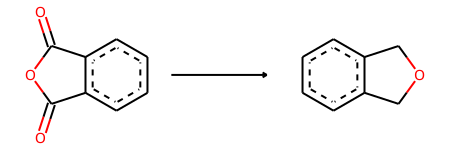

In [215]:
rdChemReactions.ReactionFromSmarts('O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2',useSmiles=True)

In [214]:
analoguerxnsparsed.loc[analoguerxnsparsed.msg.str.contains('Hydrogen carriers')]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87240      1               3         1          1   
87244      0              34         1          2   
           4              34         1          1   
           8              34         1          1   
           9              34         1          1   
...                      ...       ...        ...   
142601     3               4         1          1   
142611     0               1         1          1   
142649     0               1         1          1   
142700     0               1         1          1   
142702     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87240      1                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87244      0                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           4                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           8                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           9                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
...                                                                ...   
142601     3         Cc1cc(C)c2c(c1)C(=O)C(=O)N2>>Cc1cc(C)c(N)c(C(=...   
142611     0            CC(=O)Nc1cc(C(C)=O)sc1C>>CCc1cc(NC(C)=O)c(C)s1   
142649     0           Cc1cnc(C(=O)c2ccccc2)s1>>Cc1cnc(C(O)c2ccccc2)s1   
142700     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>Cc1cc(C(C)(C)C...   
142702     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>CC(C)(C)CCC(CO...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87240      1                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87244      0                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           4                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           8                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           9                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
...                                                                ...   
142601     3         Cc1cc(C)c2c(c1)C(=O)C(=O)N2>>Cc1cc(C)c(N)c(C(=...   
142611     0            CC(=O)Nc1cc(C(C)=O)sc1C>>CCc1cc(NC(C)=O)c(C)s1   
142649     0           Cc1cnc(C(=O)c2ccccc2)s1>>Cc1cnc(C(O)c2ccccc2)s1   
142700     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>Cc1cc(C(C)(C)C...   
142702     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>CC(C)(C)CCC(CO...   

                                                                   msg  \
ReactionID Instance                                                      
87240      1                   Hydrogen carriers: 118515,967586,102391   
87244      0         Hydrogen carriers: 118515,11343078,1098214,358...   
           4         Hydrogen carriers: 118515,11343078,1098229,102391   
           8         Hydrogen carriers: 118515,11343078,1098229,102391   
           9         Hydrogen carriers: 118515,11343078,1098229,102391   
...                                                                ...   
142601     3                Hydrogen carriers: 143679,11342940,3587191   
142611     0                         Hydrogen carriers: 143702,1098214   
142649     0                  Hydrogen carriers: 143777,3910275,635639   
142700     0         Hydrogen carriers: 143817,11342937,4933273,969209   
142702     0                         Hydrogen carriers: 143817,1718733   

                          LHS        RHS hcrct hcprod  \
ReactionID Instance                                     
87240      1         [118515]   [111932]    []     []   
87244      0         [118515]   [114632]    []     []   
           4         [118515]   [114632]    []     []   
           8         [118515]   [114632]    []     []   
           9         [118515]   [114632]    []     []   
...                       ...        ...   

In [199]:
analoguerxnsparsed.loc[analoguerxnsparsed.msg.str.contains('Mandatory')].iloc[6].msg.split('Mandatory species unmapped from LHS: ')[1].split(', ')[0].split(',')

['133939']

In [221]:
# %%writefile MapRxns.py
# %load ./MapRxns.py

from collections import OrderedDict #Preserve order of keys relative to reaction from left to right
from rdkit import Chem
from rdkit.Chem import rdChemReactions #Reaction processing
import copy
from FunctionsDB import getCarrierFrags
from rxnmapper import RXNMapper #Importing RXNMapper for unsupervised atom mapping
#%% Reaction Mapping

def maprxn(rxns):
    """
    For a given list of reactions, rxns, returns mapped reactions with confidence scores.
    Uses IBM transformer model.

    Parameters
    ----------
    rxns : list
        List of reaction SMILES (no reactant/reagent split)

    Returns
    -------
    Output : list
        Mapped reactions with confidence scores
           
           mapped_rxn: str
               Mapped reaction SMARTS
             
           confidence: str
               Model confidence in the mapping rxn
                   
    ['Error']: list
        If code doesn't run or mapper doesn't work
    """

    rxn_mapper=RXNMapper()
    try:
        return rxn_mapper.get_attention_guided_atom_maps(rxns)
    except Exception:
        return ['Error']

def maprxns(row):
    '''
    Applies maprxn to each row of a dataframe
    
    '''
    balrxnsmiles=''
    balrxnsmiles=row['balrxnsmiles']
    mappedrxn=maprxn([balrxnsmiles])[0]
    if mappedrxn=='Error':
        return 'Error','Error'
    else:
        mapped_rxn=mappedrxn.get('mapped_rxn')
        conf=mappedrxn.get('confidence')
    return mapped_rxn,conf
    

def map_rxns(analoguerxnsbalfilt,refmappedrxns=None,ncpus=16,restart=True,reaxys_update=True): #Done
    '''
    Applies maprxn to a given dataframe
    
    '''
    if not analoguerxnsbalfilt.index.name and not analoguerxnsbalfilt.index.names:
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refmappedrxns is not None:
        analoguerxnsbalfilt,commondf=userefrxns(analoguerxnsbalfilt,idxcol=idxcol,refanaloguerxns=refmappedrxns)
        idxreset=False
    if not analoguerxnsbalfilt.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxnsbalfilt.reset_index(inplace=True)
                idxreset=True
            analoguerxnsbalfiltdis=mpd.DataFrame(analoguerxnsbalfilt)
        else:
            analoguerxnsbalfiltdis=analoguerxnsbalfilt
        mappedrxns=analoguerxnsbalfiltdis.apply(maprxns,axis=1,result_type='reduce')
        mappedrxns=pd.DataFrame(data=mappedrxns.values,index=mappedrxns.index,columns=['mappedrxns'])
        mappedrxns[['mapped_rxn','confidence']]=pd.DataFrame(mappedrxns['mappedrxns'].tolist(),index=mappedrxns.index)
        mappedrxns.drop(columns=['mappedrxns'],inplace=True)
        analoguerxnsmapped=copy.deepcopy(analoguerxnsbalfilt)
        analoguerxnsmapped[['mapped_rxn','confidence']]=mappedrxns
        if idxreset:
            analoguerxnsmapped.set_index(idxcol,inplace=True)
        if refmappedrxns and not commondf.empty:
            analoguerxnsmapped=pd.concat([analoguerxnsmapped,commondf])
    else:
        analoguerxnsmapped=commondf
    return analoguerxnsmapped


def checkrxns(analoguerxnsmappedfilt,refparsedrxns=None,ncpus=16,updateall=True,removeunmapped=True,restart=True,
              reaxys_update=True): #Done
    if not analoguerxnsmappedfilt.index.name and not analoguerxnsmappedfilt.index.names:
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refparsedrxns is not None:
        analoguerxnsmappedfilt,commondf=userefrxns(analoguerxnsmappedfilt,idxcol=idxcol,refanaloguerxns=refparsedrxns)
        idxreset=False
    if not analoguerxnsmappedfilt.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxnsmappedfilt.reset_index(inplace=True)
                idxreset=True
            analoguerxnsmappedfiltdis=mpd.DataFrame(analoguerxnsmappedfilt)
        else:
            analoguerxnsmappedfiltdis=analoguerxnsmappedfilt
        compdupdate=analoguerxnsmappedfiltdis.apply(checkrxnrow,updateall=updateall,removeunmapped=removeunmapped,axis=1,result_type='reduce')
        compdupdate=pd.Series(data=compdupdate.values,index=compdupdate.index) #Optional convert modin back to pandas
        compdupdatedf=pd.DataFrame(data=compdupdate.tolist(),index=compdupdate.index,columns=['LHSdata','RHSdata','msg1'])
        analoguerxnsparsed=copy.deepcopy(analoguerxnsmappedfilt)
        analoguerxnsparsed[['LHSdata','RHSdata','msg1']]=compdupdatedf
        if idxreset:
            analoguerxnsparsed.set_index(idxcol,inplace=True)
        if refparsedrxns is not None and not commondf.empty:
            analoguerxnsparsed=pd.concat([analoguerxnsparsed,commondf])
    else:
        analoguerxnsparsed=commondf
    return analoguerxnsparsed

def checkrxnrow(row,updateall=True,removeunmapped=True):
#     breakpoint()
    mappedrxn=row['mapped_rxn']
    Rdata=row['LHSdata']
    Pdata=row['RHSdata']
    msg=row['msg']
    if 'with species' in msg:
        mandrcts=set(Rdata.keys())-set([int(addedspec) for addedspec in msg.split('with species: ')[1].split(' with help product(s): ')[0].split(',')])
    else:
        mandrcts=set(Rdata.keys())
    if 'With hydrogen carriers' in msg:
        hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
    else:
        hcarriers=[]
    if 'Mandatory' in msg:
        mandrcts=mandrcts.union({int(mandrct) for mandrct in msg.split('Mandatory species unmapped from LHS: ')[1].split(', ')[0].split(',')})
    res=checkrxn(mappedrxn,Rdata=Rdata,Pdata=Pdata,updateall=updateall,removeunmapped=removeunmapped,mandrcts=mandrcts,hcarriers=hcarriers)
    
    return res


def checkrxn(mappedrxn,Rdata={},Pdata={},ordered=True,updateall=True,removeunmapped=True,mandrcts=[],mandprods=[],hcarriers=[]): #Assume same rxn smiles stored next to each other
    '''
    Checks reaction, updating mapped and clean molecules, removing unmapped species
    
    '''
    
#     breakpoint()
    rdrxn=rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)
    cleanrxn=copy.copy(rdrxn)
    rdChemReactions.RemoveMappingNumbersFromReactions(cleanrxn)
    if ordered:
        LHSdata=OrderedDict({})
        RHSdata=OrderedDict({})
    else:
        LHSdata={}
        RHSdata={}
    msgr=[]
    msgp=[]
    # Updating LHSdata
    if Rdata:
        rsmilesfreq=gensmilesfreq(Rdata)
        smilesmismatch=[]
        rmixtures={}
        mismatch=False
        for ID,rct in enumerate(cleanrxn.GetReactants()):
            mappedmol=rdrxn.GetReactants()[ID]
            formula=rdkit.Chem.rdMolDescriptors.CalcMolFormula(rct)
            if removeunmapped:
                if any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]) or formula=='H2' or hcarriers: #Confirmed, mapped reactant
                    LHSdata,rmixtures,msg_,ID0=updatespecdict(Rdata,rsmilesfreq,rct,mappedmol,updateddict=LHSdata,mixtures=rmixtures,updateall=updateall,hcarriers=hcarriers)
                    if msg_!='Valid':
#                         if ID0 not in smilesmismatch:
#                             smilesmismatch+=[ID0]
                        mismatch=True
            else:
                LHSdata,rmixtures,msg_,ID0=updatespecdict(Rdata,rsmilesfreq,rct,mappedmol,updateddict=LHSdata,mixtures=rmixtures,updateall=updateall,hcarriers=hcarriers)
                if msg_!='Valid':
#                     if ID0 not in smilesmismatch:
#                         smilesmismatch+=[ID0]
                    mismatch=True
        if mismatch:
            smilesmismatch=[ID0 for ID0 in Rdata if ID0 not in LHSdata and ID0 not in rmixtures]
            if smilesmismatch:
                msgr+=['Smiles discrepancy for LHS species: '+', '.join([str(ID) for ID in smilesmismatch])]
            else:
                msgr+=['Smiles discrepancy for LHS species']
#         breakpoint()
        if rmixtures:
            msgr+=['Mixture detected for LHS species: '+','.join([str(ID) for ID in rmixtures])]
            for ID0 in rmixtures:
                localcounts=[int(Counter(rsmilesfreq[mixsmiles])[ID0]) for mixsmiles in rmixtures[ID0]]
                numinsts=[len(rmixtures[ID0][mixsmiles]) for mixsmiles in rmixtures[ID0]]
                lb=[0 for j in range(len(numinsts))]
                ub=[0 for j in range(len(numinsts))]
                div=[int(ceil(numinst/localcount)) for numinst,localcount in zip(numinsts,localcounts)]
                count=max(div)
                if updateall:
                    LHSdata[ID0].update({'mappedsmiles':[],'cleanmol':[],'unmappedmix':[]})
                    for i in range(count):
                        mappedsmiles=[]
                        unmappedsmiles=[]
                        cleanmol=[]
                        for j,mixsmiles in enumerate(rmixtures[ID0]):
                            ub_=min(numinsts[j],localcounts[j])
                            ub[j]=ub_+lb[j]
                            mappedlist=rmixtures[ID0][mixsmiles][lb[j]:ub[j]]
                            mappedsmiles+=[comb[0] for comb in mappedlist]
                            cleanmol+=[comb[1] for comb in mappedlist]
                        mappedsmiles=tuple(mappedsmiles)
                        cleanmol=tuple(cleanmol)
                        unmappedsmiles=tuple([mixsmiles for mixsmiles in rsmilesfreq for k in range(int(Counter(rsmilesfreq[mixsmiles])[ID0])) if mixsmiles in Rdata[ID0]['smiles'] if mixsmiles not in rmixtures[ID0]])
                        LHSdata[ID0]['mappedsmiles'].extend([mappedsmiles])
                        LHSdata[ID0]['cleanmol'].extend([cleanmol])
                        LHSdata[ID0]['unmappedmix'].extend([unmappedsmiles])
                        lb=copy.deepcopy(ub)
                LHSdata[ID0]['count']=count                            
        if removeunmapped:
            rem=Counter()
            Rspecies=Counter([ID0 for ID0 in Rdata for _ in range(Rdata[ID0]['count'])])
            LHSspecies=Counter([ID0 for ID0 in LHSdata for _ in range(LHSdata[ID0]['count'])])
            rem.update(Rspecies)
            rem.subtract(LHSspecies)
#             removedmandrcts=[ID0 for ID0 in rem if ID0 in mandrcts if ID0 not in LHSspecies]
#             removedrcts=[ID0 for ID0 in rem if ID0 not in removedmandrcts if ID0 not in smilesmismatch if ID0 in Rspecies if ID0 not in LHSspecies]
            removedrcts=[ID0 for ID0 in rem if ID0 in Rspecies if ID0 not in LHSspecies if ID0 not in smilesmismatch]
            removedmandrcts=[ID0 for ID0 in removedrcts if ID0 in mandrcts]
            #New
            removedmandrcts=list(set(removedmandrcts).union({mandrct for mandrct in mandrcts if mandrct not in LHSspecies}))
            #New
            runmapped=[ID0 for ID0 in rem if rem[ID0]!=0 if ID0 not in removedrcts if ID0 not in smilesmismatch]
            if removedmandrcts:
                msgr+=['Mandatory species unmapped from LHS: '+', '.join([str(ID) for ID in removedmandrcts])]
                removedrcts=[ID0 for ID0 in removedrcts if ID0 not in removedmandrcts]
            if removedrcts:
                msgr+=['Unmapped species from LHS: '+', '.join([str(ID) for ID in removedrcts])]
            if runmapped:
                msgr+=['Unmapped species instances from LHS: '+', '.join([str(ID) for ID in runmapped])]
    if Pdata:
#         breakpoint()
        psmilesfreq=gensmilesfreq(Pdata)
        smilesmismatch=[]
        pmixtures={}
        mismatch=False
        for ID,prod in enumerate(cleanrxn.GetProducts()):
            mappedmol=rdrxn.GetProducts()[ID]
#             formula=rdkit.Chem.rdMolDescriptors.CalcMolFormula(prod)
            if removeunmapped:
                if any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]): #Confirmed, mapped reactant
                    RHSdata,pmixtures,msg_,ID0=updatespecdict(Pdata,psmilesfreq,prod,mappedmol,updateddict=RHSdata,mixtures=pmixtures,updateall=updateall)
                    if msg_!='Valid':
#                         if ID0 not in smilesmismatch:
#                             smilesmismatch+=[ID0]
                        mismatch=True
            else:
                RHSdata,pmixtures,msg_,ID0=updatespecdict(Pdata,psmilesfreq,prod,mappedmol,updateddict=RHSdata,mixtures=pmixtures,updateall=updateall)
                if msg_!='Valid':
#                     if ID0 not in smilesmismatch:
#                         smilesmismatch+=[ID0]
                    mismatch=True
        if mismatch:
            smilesmismatch=[ID0 for ID0 in Pdata if ID0 not in RHSdata and ID0 not in pmixtures]
            if smilesmismatch:
                msgp+=['Smiles discrepancy for RHS species: '+', '.join([str(ID) for ID in smilesmismatch])]
            else:
                msgp+=['Smiles discrepancy for RHS species']
        if pmixtures:
            msgp+=['Mixture detected for RHS species: '+','.join([str(ID) for ID in pmixtures])]
#             breakpoint()
            for ID0 in pmixtures:
                localcounts=[int(Counter(psmilesfreq[mixsmiles])[ID0]) for mixsmiles in pmixtures[ID0]]
                numinsts=[len(pmixtures[ID0][mixsmiles]) for mixsmiles in pmixtures[ID0]]
                lb=[0 for j in range(len(numinsts))]
                ub=[0 for j in range(len(numinsts))]
                div=[int(ceil(numinst/localcount)) for numinst,localcount in zip(numinsts,localcounts)]
                count=max(div)
                if updateall:
                    RHSdata[ID0].update({'mappedsmiles':[],'cleanmol':[],'unmappedmix':[]})
                    for i in range(count):
                        mappedsmiles=[]
                        unmappedsmiles=[]
                        cleanmol=[]
                        for j,mixsmiles in enumerate(pmixtures[ID0]):
                            ub_=min(numinsts[j],localcounts[j])
                            ub[j]=ub_+lb[j]
                            mappedlist=pmixtures[ID0][mixsmiles][lb[j]:ub[j]]
                            mappedsmiles+=[comb[0] for comb in mappedlist]
                            cleanmol+=[comb[1] for comb in mappedlist]
                        mappedsmiles=tuple(mappedsmiles)
                        cleanmol=tuple(cleanmol)
                        unmappedsmiles=tuple([mixsmiles for mixsmiles in psmilesfreq for k in range(int(Counter(psmilesfreq[mixsmiles])[ID0])) if mixsmiles in Pdata[ID0]['smiles'] if mixsmiles not in pmixtures[ID0]])
                        RHSdata[ID0]['mappedsmiles'].extend([mappedsmiles])
                        RHSdata[ID0]['cleanmol'].extend([cleanmol])
                        RHSdata[ID0]['unmappedmix'].extend([unmappedsmiles])
                        lb=copy.deepcopy(ub)
                RHSdata[ID0]['count']=count      
        if removeunmapped:
            rem=Counter()
            Pspecies=Counter([ID0 for ID0 in Pdata for _ in range(Pdata[ID0]['count'])])
            RHSspecies=Counter([ID0 for ID0 in RHSdata for _ in range(RHSdata[ID0]['count'])])
            rem.update(Pspecies)
            rem.subtract(RHSspecies)
#             removedmandprod=[ID0 for ID0 in rem if ID0 in mandprods if ID0 not in RHSspecies]
#             removedprods=[ID0 for ID0 in rem if ID0 not in removedmandprod if ID0 not in smilesmismatch if ID0 in Pspecies if ID0 not in RHSspecies]
            removedprods=[ID0 for ID0 in rem if ID0 in Pspecies if ID0 not in RHSspecies if ID0 not in smilesmismatch]
            removedmandprods=[ID0 for ID0 in removedprods if ID0 in mandprods]
            punmapped=[ID0 for ID0 in rem if rem[ID0]!=0 if ID0 not in removedprods if ID0 not in smilesmismatch]
            if removedmandprods:
                msgp+=['Mandatory species unmapped from RHS: '+', '.join([str(ID) for ID in removedmandprods])]
                removedprods=[ID0 for ID0 in removedprods if ID0 not in removedmandprods]
            if removedprods:
                msgp+=['Unmapped species from RHS: '+', '.join([str(ID) for ID in removedprods])]
            if punmapped:
                msgp+=['Unmapped species instances from RHS: '+', '.join([str(ID) for ID in punmapped])]
    msg=msgr+msgp
    if not msg:
        msg='Valid'
    else:
        msg=', '.join(msg)
    return LHSdata,RHSdata,msg

def gensmilesfreq(specdict,validate=True):
    '''
    Generates smile frequency dictionary (Sometimes species have the same SMILES with different IDs eg. mixture vs pure)
    
    '''
    smilesfreq={}
    for ID0 in specdict:
        specsmiles=specdict[ID0]['smiles']
        specsmiles=specsmiles.split('.')
        for specsmile in specsmiles:
            if validate:
                specsmile=Chem.MolToSmiles(molfromsmiles(specsmile))
            if specsmile in smilesfreq:
                smilesfreq[specsmile].extend([ID0])
            else:
                smilesfreq.update({specsmile:[ID0]})
    return smilesfreq
                

def updatespecdict(refdict,smilesfreq,cleanmol,mappedmol,updateddict=OrderedDict({}),mixtures={},hcarriers=[],updateall=True):
    '''
    Updates species dictionary based on given reactant and cleaned molecule from a reaction
    hcarriers (list of hydrogen containing species involved in reaction but not mapped)
    '''
    foundmatch=False
    specsmiles=Chem.MolToSmiles(molfromsmiles(Chem.MolToSmiles(cleanmol))) #Ensuring RDKit smiles
#     breakpoint()
    if specsmiles not in smilesfreq:
        ID0=''
        msg='Smiles discrepancy for species'
    else:
        idx=''
        msg='Valid'
        IDlist=smilesfreq[specsmiles]
        mixtures_=['.' in refdict[ID0]['smiles'] for ID0 in IDlist]
        if len(IDlist)>1: #Try mixtures first
            pure=[ID0 for i,ID0 in enumerate(IDlist) if not mixtures_[i]] #Pure matches
            if any(mixtures):
                for i,ID0 in enumerate(IDlist):
                    if mixtures_[i] and ID0 in mixtures:
                        if specsmiles in mixtures[ID0]:
                            loccount=len(mixtures[ID0][specsmiles])
                        else:
                            loccount=0
                        if any([len(mixtures[ID0][specsmiles_])>loccount for specsmiles_ in mixtures[ID0]]):
                            idx=i
                            break
                if not idx and not pure:
                    for i,ID0 in enumerate(IDlist):
                        if mixtures_[i] and ID0 not in mixtures:
                            idx=i
                            break    
            if not idx and pure:
                for i,ID0 in enumerate(IDlist):
                    if not mixtures_[i] and ID0 not in updateddict:
                        idx=i
                        break         
            if not idx:
                idx=0       
        else:
            idx=0
        ID0=IDlist[idx]
        #New
        if hcarriers and ID0 not in hcarriers and not any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]):
            return updateddict,mixtures,msg,ID0
        #New
        mixture=mixtures_[idx]
        if updateall:
            mappedsmiles=Chem.MolToSmiles(mappedmol)
            if mixture:
                if ID0 not in mixtures:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    mixtures.update({ID0:{specsmiles:[(mappedsmiles,cleanmol)]}})
                elif specsmiles not in mixtures[ID0]:
                    mixtures[ID0].update({specsmiles:[(mappedsmiles,cleanmol)]})
                else:
                    mixtures[ID0][specsmiles].extend([(mappedsmiles,cleanmol)])    
            else:
                if ID0 not in updateddict:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    updateddict[ID0]['count']=1
                    updateddict[ID0].update({'mappedsmiles':[mappedsmiles],'cleanmol':[cleanmol]})
                else:
                    updateddict[ID0]['count']+=1
                    updateddict[ID0]['mappedsmiles'].extend([mappedsmiles])
                    updateddict[ID0]['cleanmol'].extend([cleanmol])     
        else:
            if mixture:
                if ID0 not in mixtures:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    mixtures.update({ID0:{specsmiles:[()]}})
                elif specsmiles not in mixtures[ID0]:
                    mixtures[ID0].update({specsmiles:[()]})
                else:
                    mixtures[ID0][specsmiles].extend([()])
            else:
                if ID0 not in updateddict:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    updateddict[ID0]['count']=1
                else:
                    updateddict[ID0]['count']+=1
    return updateddict,mixtures,msg,ID0


def updaterxns(analoguerxnsparsed,hc_prod={},analoguerxns=None,ncpus=16,restart=True):
    '''
    Updates reactions if there are unmapped species and balances if there are changes (optional)
    
    '''
    if analoguerxns is not None:
        analoguerxnsparsed=updatecolumns(analoguerxns,analoguerxnsparsed,cols=['ReactantID','Rgtdata','Solvdata'])
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsparseddis=mpd.DataFrame(analoguerxnsparsed)
    else:
        analoguerxnsparseddis=analoguerxnsparsed
    updatedrxn=analoguerxnsparseddis.apply(updaterxns_,hc_prod=hc_prod,axis=1,result_type='reduce')
    updatedrxn=pd.DataFrame(data=updatedrxn.values,index=updatedrxn.index,columns=['rxncomb'])
    analoguerxnsparsed[['mapped_rxn','confidence','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata','msg1']]=pd.DataFrame(updatedrxn['rxncomb'].tolist(), index=updatedrxn.index)
    return analoguerxnsparsed


    
def updaterxns_(row,hc_prod={}):
    '''
    Updates reactions if there are unmapped species and balances if there are changes (optional). Assumes both
    balancerxn, maprxn and checkrxn have all been called already
    
    '''
#     breakpoint()
    msg1=copy.deepcopy(row['msg1'])
    msg=copy.deepcopy(row['msg']) #Balanced output message
    LHSdata=copy.deepcopy(row['LHSdata'])
    RHSdata=copy.deepcopy(row['RHSdata'])
    hcprod=copy.deepcopy(row['hcprod'])
    hcrct=copy.deepcopy(row['hcrct'])
    if 'Rgtdata' in row.keys():
        Rgtdata=row['Rgtdata']
    else:
        Rgtdata={}
    if 'Solvdata' in row.keys():
        Solvdata=row['Solvdata']
    else:
        Solvdata={}
    if 'ReactantID' in row.keys():
        mandrcts=row['ReactantID']
    else:
        if 'with species' in msg:
            mandrcts=set(LHSdata.keys())-{int(addedspec) for addedspec in msg.split('with species: ')[1].split(' with help product(s): ')[0].split(',')}
        else:
            mandrcts=set(LHS.keys())
        if 'Mandatory' in msg1:
            mandrcts=mandrcts.union({int(mandrct) for mandrct in msg.split('Mandatory species unmapped from LHS: ')[1].split(', ')[0].split(',')})
    while 'Unmapped' in msg1: #Unmapped species exist not reflected
        hcprod=[hcprod_ for hcprod_ in hcprod if hcprod_ in RHSdata]
        hcrct=[hcrct_ for hcrct_ in hcrct if hcrct_ in LHSdata]
        balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata=balancerxn(LHSdata,RHSdata,first=False,Rgtdata=Rgtdata,Solvdata=Solvdata,hc_prod=hc_prod,coefflim=6,mandrcts=mandrcts,ignoreH=False)
#         if 'Hydrogen carriers' in msg or not hc_prod: #No point balancing again as hydrogen deficit always present
#             balrxnsmiles,_,LHSids,RHSids,_,_,_,_=update_rxn(LHSdata,RHSdata,hc_prod=hc_prod,hcprod=hcprod,hcrct=hcrct,msg=msg)
        mappedrxn=maprxn([balrxnsmiles])[0]
        if mappedrxn=='Error':
            mapped_rxn='Error'
            conf='Error'
            msg1='Mapping error'
            break
        else:
            mapped_rxn=mappedrxn.get('mapped_rxn')
            conf=mappedrxn.get('confidence')
            if 'With hydrogen carriers' in msg:
                hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
            else:
                hcarriers=[]
            LHSdata,RHSdata,msg1=checkrxn(mappedrxn,Rdata=LHSdata,Pdata=RHSdata,updateall=updateall,removeunmapped=True,mandrcts=mandrcts,hcarriers=hcarriers)   
    return mapped_rxn,confidence,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,msg1
    
def updatecolumns(parent,child,cols=[],config=[]):
    if type(parent)==str:
        parent=pd.read_pickle(parent)
    if type(child)==str:
        child=pd.read_pickle(child)
    child[cols]=parent[cols]
    if config:
        child=child[config]
    return child


def assignfrags(analoguerxnsparsedfilt,fragdict,strict=False,ncpus=16):
    '''
    Assigns fragments to analogue species, and corresponding atom indices/mapping numbers
    
    
    '''
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsparsedfiltdis=mpd.DataFrame(analoguerxnsparsedfilt)
    else:
        analoguerxnsparsedfiltdis=analoguerxnsparsedfilt
    compdassigned=analoguerxnsparsedfiltdis.apply(assignfragsrow,fragdict=fragdict,strict=strict,axis=1,result_type='reduce')
    compdassigned=pd.Series(data=compdassigned.values,index=compdassigned.index) #Optional convert modin back to pandas
    compdassigneddf=pd.DataFrame(data=compdassigned.tolist(),index=compdassigned.index,columns=['LHSdata','nofg','msg2'])
    analoguerxnsassigned=copy.deepcopy(analoguerxnsparsedfilt)
    analoguerxnsassigned[['LHSdata','nofg','msg2']]=compdassigneddf
    return analoguerxnsassigned
        
        
def assignfragsrow(row,fragdict,strict=False):
    '''
    Assigns fragments to analogue species, and corresponding atom indices/mapping numbers
    
    '''
    LHSdata=row.LHSdata
    return assignfrags_(LHSdata,fragdict,strict=strict)
def assignfrags_(LHSdata,fragdict,strict=False):
    '''
    Assigns fragments to analogue species, and corresponding atom indices/mapping numbers 
    
    '''
    if strict:
        checkresults=True #Not recommended now as isotopic, hydrocarbon and user-defined fragments may be rejected
    else:
        checkresults=False
    fragdata=copy.deepcopy(LHSdata)
    msg=[]
    nofg=set() #Species with no functional groups
    nonanalogue=set() #Species that don't have correct/desired functional group
    for rctid in fragdata:
        fragloc={}
        fragdata[rctid]['querycompds']={}
        commonfrags=[frag for frag in fragdict if rctid in fragdict[frag]['analoguepool']]
        if not commonfrags:
            nonanalogue.add(rctid)
            continue
        fragdata[rctid]['querycompds'].update({frag:fragdict[frag]['Query'] for frag in commonfrags})
        for idx,cleanmol0 in enumerate(fragdata[rctid]['cleanmol']):
            if type(cleanmol0)==tuple: #Mixture detected
                for idx2,cleanmol in enumerate(cleanmol0):
                    cleanmol=Chem.AddHs(cleanmol)
                    for frag in commonfrags:
                        fragloc,nofg=update_matches(cleanmol,frag,fragloc=fragloc,nofg=nofg,checkresults=checkresults,idx=(idx,idx2),rctid=rctid)          
                    if not fragloc[(idx,idx2)]:
                        nonanalogue.add(rctid)
            else:
                cleanmol=Chem.AddHs(cleanmol0) # Add hydrogens
                for frag in commonfrags:
                    fragloc,nofg=update_matches(cleanmol,frag,fragloc=fragloc,nofg=nofg,checkresults=checkresults,idx=idx,rctid=rctid)
                if not fragloc[idx]:
                    nonanalogue.add(rctid)
        fragdata[rctid]['fragloc']=fragloc
    if nonanalogue:
        msg='Species '+', '.join([str(rctid) for rctid in nonanalogue])+' not analogue'
    else:
        msg='Valid'
    return fragdata,nofg,msg
    
        
#%% Substructure matching
def update_matches(mol,pattsmiles,checkresults=False,fragloc={},nofg=set(),idx=0,rctid=0):
    '''
    Returns atom indices for substructure matches of a pattern in a molecule
    '''
    patt=Chem.MolFromSmarts(pattsmiles)
    patt.UpdatePropertyCache(strict=False)
    corr_matches,funcgroupids,msg=get_matches(mol,patt,checkresults=checkresults) #funcgroupids refers to active fragment, change checkresults to true if more strict
    if not corr_matches:
        fragloc.update({idx:{}})
    else:
        if msg!='Valid' or not funcgroupids:
            nofg.add(rctid)
    #                     corr_matches=[tuple((idx for idx in co if idx<len(molfromsmiles(LHSdata[analoguecompd]['smiles']).GetAtoms()))) for co in corr_matches]
        if idx not in fragloc.keys():
            fragloc.update({idx:{pattsmiles:{'corrmatches':corr_matches,'funcgroupids':funcgroupids}}})
        else:
            fragloc[idx].update({pattsmiles:{'corrmatches':corr_matches,'funcgroupids':funcgroupids}})
    return fragloc,nofg 
    
        
def get_matches(mol,patt,checkresults=False):
    '''
    Returns atom indices for substructure matches of a pattern in a molecule
    
        Parameters
        ----------
        mol : RDKit mol
            Molecule to check pattern
        patt : RDKit mol
            Pattern fragment
        checkresults: bool
            Optional, True if strict match with the pattern is needed including hydrogens

        Returns
        -------
       corr_matches: Set
           Set of tuples containing atom indices for every pattern match, after verification
           that correct functional group is present. Returned only if checkresults is True. 
       
       funcgroupids: List
           List of atom ids corresponding to functional groups in each correct pattern match
           
        matches: Set
            Set of tuples containing atom indices for every pattern match. Returned only if checkresults is False.
    '''
    msg=''
    matches=mol.GetSubstructMatches(patt)
    if not matches:
        return False,False,'No match'
    funcgroupmol=IFG(mol) #Functional groups of RDKit reactant
    funcgrouppatt=IFG(patt) #Functional groups of carrier fragment
    if not funcgroupmol:
        msg='No functional group in parent'
        checkresults=False
    elif not funcgrouppatt:
        msg='No functional group in pattern'
        checkresults=False
    if checkresults: #Buggy
#         breakpoint()
        funcids=set() #Store functional groups that are of the same type as the carrier fragment
        for funcgroup in funcgrouppatt:
            matchtype=[molgroup for molgroup in funcgroupmol if molgroup.atoms==funcgroup.atoms] #change to .atoms if not working
            for molgroup in matchtype:
#                 if not any([atoms_are_different(mol.GetAtomWithIdx(atomid),patt.GetAtomWithIdx(pattid),usesmarts=False) 
#                             for atomid,pattid in zip(molgroup.atomIds,funcgroup.atomIds)]): #BUGGY
                funcids.update({atomid for atomid in molgroup.atomIds})
        corr_matches=[match for match in matches if set(match).intersection(funcids)]
        funcgroupids=[set(match).intersection(funcids) for match in corr_matches]
        msg='Valid'
    else:
#         breakpoint()
        funcgroupids=[] #Added
        corr_matches=[match for match in matches]
        if not msg:
            funcids={atomid for molgroup in funcgroupmol for atomid in molgroup.atomIds}
            funcgroupids=[set(match).intersection(funcids) for match in corr_matches]
            msg='Valid'
    return corr_matches,funcgroupids,msg

    

In [117]:
['Rgtdata','Solvdata'] in analoguerxns3.dtypes

TypeError: unhashable type: 'list'

In [126]:
analoguerxns3.xs((87248,19))

ReactantID                                             [118515]
ProductID                                              [118522]
NumRefs                                                      43
NumSteps                                                      1
NumStages                                                     1
ReagentID                                             [1868220]
SolventID                                                    []
Rdata         {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...
Pdata         {118522: {'atomdict': {'O': 2, 'C': 8, 'N': 1,...
Rgtdata       {1868220: {'atomdict': {'N': 2, 'C': 8, 'O': 2...
Solvdata                                                     {}
hc_prod       {0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...
hc_react      {1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0...
Name: (87248, 19), dtype: object

In [220]:
analoguerxnsparsed.loc[(analoguerxnsparsed.msg1.str.contains('Unmapped')) & (analoguerxnsparsed.msg.str.contains('Hydrogen carriers'))].iloc[0].msg

'Hydrogen carriers: 118515,506007 with species: 3587218'

## RxnCenter.py

In [ ]:
# %%writefile RxnCenter.py
#%load ./RxnCenter.py

from MainFunctions import molfromsmiles
from FindFunctionalGroups import identify_functional_groups as IFG
import copy
from rdkit import Chem #Importing RDKit

def reactioncenter(analoguerxnsassignedfilt,ncpus=16,restart=True):
    '''
    Finds reaction center of a reaction
    '''
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsassignedfiltdis=mpd.DataFrame(analoguerxnsassignedfilt)
    else:
        analoguerxnsassignedfiltdis=analoguerxnsassignedfilt
    rxncenterser=analoguerxnsassignedfiltdis.apply(getrxncenterrow,axis=1,result_type='reduce')
    rxncenterser=pd.Series(data=rxncenterser.values,index=rxncenterser.index) #Optional convert modin back to pandas
    rxncenterdf=pd.DataFrame(data=rxncenterser.tolist(),index=rxncenterser.index,columns=['specmap','rnbmap','rxncentermapnum','rxncenter'])
    analoguerxnscent=copy.deepcopy(analoguerxnsassignedfilt)
    analoguerxnscent[['specmap','rnbmap','rxncentermapnum','rxncenter']]=rxncenterdf
    return analoguerxnscent

def validreactioncenter(analoguerxnscentfilt,ncpus=16,restart=True):
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnscentfiltdis=mpd.DataFrame(analoguerxnscentfilt)
    else:
        analoguerxnscentfiltdis=analoguerxnscentfilt
    validrxncenterser=analoguerxnscentfiltdis.apply(validrxncenterrow,axis=1,result_type='reduce')
    validrxncenterser=pd.Series(data=validrxncenterser.values,index=validrxncenterser.index)
    validrxncenterdf=pd.DataFrame(data=validrxncenterser.tolist(),index=validrxncenterser.index,columns=['LHSdata','msg3','outfrag','outfg','outneighbor','unusedanalogue'])
    analoguerxnsvalid=copy.deepcopy(analoguerxnscentfilt)
    analoguerxnsvalid[['LHSdata','msg3','outfrag','outfg','outneighbor','unusedanalogue']]=validrxncenterdf
    return analoguerxnsvalid
    
    

#%% Reaction center identification

def bond_to_label(bond):
    '''
    This function takes an RDKit bond and creates a label describing
    the beginning atom (atomic number and atom map number) and ending atom
    (atomic number and atom map number)

    Parameters
    ----------
    bond : RDKit bond

    Returns
    -------
    output: str
        String label containing information about beginning and end atom linked
        by bond
        

    '''
    a1_label = str(bond.GetBeginAtom().GetAtomicNum())
    a2_label = str(bond.GetEndAtom().GetAtomicNum())
    if bond.GetBeginAtom().HasProp('molAtomMapNumber'):
        a1_label += bond.GetBeginAtom().GetProp('molAtomMapNumber')
    if bond.GetEndAtom().HasProp('molAtomMapNumber'):
        a2_label += bond.GetEndAtom().GetProp('molAtomMapNumber')
    atoms = sorted([a1_label, a2_label])
    # return '{}{}{}'.format(atoms[0], bond.GetSmarts(), atoms[1])
    return '{}{}'.format(atoms[0], atoms[1])



def atoms_are_different(atom1, atom2, level = 1,usesmarts=True):
    '''
    Compares two RDKit atoms based on common properties (Smarts, number of
    bonded hydrogens, charge, degree, radical electrons, neighbors etc.).
    From rdchiral.

    Parameters
    ----------
    atom1 : RDKit atom
    atom2 : RDKit atom
    level : Optional
            The default is 1.
    usesmarts : Optional (boolean)
                Option to use or ignore differences in atom smarts

    Returns
    -------
    True if the two atoms are different and False if they are similar.

    '''
    # import pdb; pdb.set_trace()
    if usesmarts:
        if atom1.GetSmarts() != atom2.GetSmarts(): return True # should be very general
    if atom1.GetAtomicNum() != atom2.GetAtomicNum(): return True # must be true for atom mapping
    if atom1.GetTotalNumHs() != atom2.GetTotalNumHs(): return True
    if atom1.GetFormalCharge() != atom2.GetFormalCharge(): return True
    if atom1.GetDegree() != atom2.GetDegree(): return True
    if atom1.GetIsAromatic() != atom2.GetIsAromatic(): return True
    #if atom1.IsInRing() != atom2.IsInRing(): return True
    if atom1.GetNumRadicalElectrons() != atom2.GetNumRadicalElectrons(): return True
    # TODO: add # pi electrons like ICSynth? Account for chirality
    # Check bonds and nearest neighbor identity
    if level >= 1:
        bonds1 = sorted([bond_to_label(bond) for bond in atom1.GetBonds()])
        bonds2 = sorted([bond_to_label(bond) for bond in atom2.GetBonds()])
        if bonds1 != bonds2: return True
    return False

def getrxncenterrow(row):
    '''
    Applies getrxncenter to each row of a dataframe

    '''
    LHSdata=row.LHSdata
    RHSdata=row.RHSdata
    specmap,rnbmap=parsemap(LHSdata,RHSdata)
    rxncenter,msg=getrxncenter(specmap,LHSdata,RHSdata)
    return specmap,rnbmap,rxncenter,msg

def storeatommap(mappedsmiles,specid=0,idx=0,atommap={},neighbormap={}):
    mappedmol=molfromsmiles(mappedsmiles) #Hydrogens will never be mapped
    for atom in mappedmol.GetAtoms():
        if atom.HasProp('molAtomMapNumber'):
            mnum = atom.GetAtomMapNum()
            atommap[mnum] = (specid,idx,atom.GetIdx())
#             breakpoint()
            neighbors=set([nb.GetIdx() for nb in atom.GetNeighbors() if not nb.HasProp('molAtomMapNumber')])
            if neighbors:
                if neighbormap:
                    startidx=max([int(key.split('n')[1]) for key in neighbormap])+1
                else:
                    startidx=0
                for i,nb in enumerate(neighbors,start=startidx):
                    neighbormap['n'+str(i)]=(specid,idx,nb)
    return atommap,neighbormap

    

def parsemap(LHSdata,RHSdata):
    '''
    Takes reaction and product data, analyzes mapped smiles
    and generates a dictionary with keys as atom map numbers, and values as a tuple 
    containing the reactant ID, reactant instance, reactant atom index, product ID,
    product instance,and product atom index

    Parameters
    ----------
    LHSdata : dict
        Reactant data formatted as output of getcompdict with 'mappedsmiles' key under
        each reactant ID with value as mapped smiles string
    RHSdata : dict
        Product data formatted as output of getcompdict with 'mappedsmiles' key under
        each product ID with value as mapped smiles string

    Returns
    -------
    specmap : dict
        Dictionary with keys as atom map numbers, and values as tuples 
        containing the owning reactant ID, reactant instance, reactant atom index, product ID,
        product instance,and product atom index

    '''
#     breakpoint()
    reactantMap = {}
    rnbmap={}
    for rctid in LHSdata:
        for ridx,mappedsmiles in enumerate(LHSdata[rctid]['mappedsmiles']):
            if type(mappedsmiles)==tuple: #Mixture detected
                for ridx2,mappedsmile in enumerate(mappedsmiles):
                    reactantMap,rnbmap=storeatommap(mappedsmile,specid=rctid,idx=(ridx,ridx2),atommap=reactantMap,
                                                    neighbormap=rnbmap)
            else:
                reactantMap,rnbmap=storeatommap(mappedsmiles,specid=rctid,idx=ridx,atommap=reactantMap,
                                                neighbormap=rnbmap)          
    productMap={}
    pnbmap={}
    for prodid in RHSdata:
        for pidx,mappedsmiles in enumerate(RHSdata[prodid]['mappedsmiles']):
            if type(mappedsmiles)==tuple: #Mixture detected
                for pidx2,mappedsmile in enumerate(mappedsmiles):
                    productMap,pnbmap=storeatommap(mappedsmile,specid=prodid,idx=(pidx,pidx2),atommap=productMap,
                                                   neighbormap=pnbmap)
            else:
                productMap,pnbmap=storeatommap(mappedsmiles,specid=prodid,idx=pidx,atommap=productMap,
                                               neighbormap=pnbmap)
#         if pnbmap: Error will never happen
            
    specmap={mapnum:tuple([elem for map_ in [reactantMap,productMap] for elem in map_[mapnum]]) for mapnum in reactantMap}              
    return specmap,rnbmap


def getrxncenter(specmap,LHSdata,RHSdata):
    '''
    Takes specmap (mapdict), reactant data, product data, optionally neighbor information and returns a set of
    changed atoms, as well as a message indicating if reaction center exists
    Note reaction center will ignore hydrogen reactants as these aren't mapped in products

    Parameters
    ----------
    specmap : dict
        Output of parsemap() function. Dictionary with keys as atom map numbers, and values as tuples 
        containing the owning reactant ID, reactant instance, reactant atom index, product ID,
        product instance,and product atom index
    LHSdata : dict
        DESCRIPTION.
    RHSdata : dict
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.
    msg : TYPE
        DESCRIPTION.

    '''
    
    changed_atoms=[]
    changed_mapnum=[]
    msg=True

    for mapnum,val in specmap.items():
        rctid=val[0]
        ridx=val[1]
        ratomidx=val[2]
        prodid=val[3]
        pidx=val[4]
        patomidx=val[5]
        
        if type(ridx)==tuple: #Mixture detected
            ridx1=ridx[0]
            ridx2=ridx[1]
            rtempl=molfromsmiles(LHSdata[rctid]['mappedsmiles'][ridx1][ridx2])
        else:
            rtempl=molfromsmiles(LHSdata[rctid]['mappedsmiles'][ridx])
        if type(pidx)==tuple: #Mixture detected
            pidx1=pidx[0]
            pidx2=pidx[1]
            ptempl=molfromsmiles(RHSdata[prodid]['mappedsmiles'][pidx1][pidx2])
        else:
            ptempl=molfromsmiles(RHSdata[prodid]['mappedsmiles'][pidx])
        ratom=rtempl.GetAtomWithIdx(ratomidx)
        patom=ptempl.GetAtomWithIdx(patomidx)
        if mapnum not in changed_mapnum:
            if atoms_are_different(patom,ratom):
                changed_atoms.append(ratom)
                changed_mapnum.append(mapnum)
    if not changed_mapnum:
        msg=False
    return set(changed_mapnum),msg 

#%% Valid reaction center

def validrxncenterrow(row):
    specmap=row.specmap
    rxncenter=row.rxncentermapnum
    LHSdata=copy.deepcopy(row.LHSdata)
    rnbmap=row.rnbmap
    return validrxncenter(specmap,rxncenter,LHSdata,rnbmap=rnbmap) 

def validrxncenter(specmap,rxncenter,LHSdata,rnbmap={}):
#     breakpoint()
    RCs=[copy.copy(rxncenter),set(rnbmap.keys())]
    mapdicts=[specmap,rnbmap]
    outfrag=[] #Species not directly involved in the reaction at carrier fragments
    outfg={} #Species not directly involved in the reaction at functional group
    outneighbor={} #Species not involved at a neighboring atom to a functional group
#     unusedanalogue={analoguecompd for analoguecompd in LHSdata}
    for RC,mapdict in zip(RCs,mapdicts):
        for changemapnum in RC:
#             breakpoint()
            assigned=False
            fg=False
            nb=False
            rctid=mapdict[changemapnum][0]
            ridx=mapdict[changemapnum][1]
            idxr=mapdict[changemapnum][2]
            if type(ridx)==tuple:
                rctmol=molfromsmiles(LHSdata[rctid]['mappedsmiles'][ridx[0]][ridx[1]])
            else:
                rctmol=molfromsmiles(LHSdata[rctid]['mappedsmiles'][ridx])
            neidx=[atom.GetIdx() for atom in rctmol.GetAtomWithIdx(idxr).GetNeighbors()]
            if 'reacfrag' not in LHSdata[rctid]:
                LHSdata[rctid].update({'reacfrag':{}})
            reacfrag=LHSdata[rctid]['reacfrag']
#             unusedanalogue-={rctid}
            for carrierfrag,loc in LHSdata[rctid]['fragloc'][ridx].items():
                for matchidx,corrmatch in enumerate(loc['corrmatches']):
    #                 breakpoint()
                    if {idxr}.issubset(corrmatch):
                        if loc['funcgroupids']: # Some carrier fragments don't have functional groups
                            if {idxr}.issubset(loc['funcgroupids'][matchidx]):
                                fg=True #changed atom lies within functional group
                                nb=True #To bypass neighbor check
                            # New code for neighbors
                            else:
                                if any([atomidx in loc['funcgroupids'][matchidx] for atomidx in neidx]):
                                    nb=True
                        else:
                            fg=True
                            nb=True
                        if ridx not in reacfrag:
                            reacfrag.update({ridx:{carrierfrag:[matchidx]}})
                        else: #already initialized
                            if ridx in reacfrag:
                                if carrierfrag in reacfrag[ridx]:
                                    if matchidx not in reacfrag[ridx][carrierfrag]:
                                        reacfrag[ridx][carrierfrag].extend([matchidx])
                                else:
                                    reacfrag[ridx].update({carrierfrag:[matchidx]})
                            else:
                                reacfrag.update({ridx:{carrierfrag:[matchidx]}})
                        assigned=True
#             breakpoint()
            if not assigned: #changed atom not in any fragments
                if rctid not in outfrag:
                    outfrag+=[rctid]
            if not fg: #changed atom not in any functional groups
                if rctid not in outfg:
                    outfg.update({rctid:[changemapnum]})
                else:
                    outfg[rctid].extend([changemapnum])
            if not nb: #changed atom neighbors functional groups
                if rctid not in outneighbor:
                    outneighbor.update({rctid:[changemapnum]})
                else:
                    outneighbor[rctid].extend([changemapnum])
    #%% New (SUSPECT)
    unusedanalogue=[ID for ID in LHSdata if LHSdata[ID]['formula']!='H2' if 
                    ('reacfrag' not in LHSdata[ID] or set(LHSdata[ID]['reacfrag'].keys())!=set(LHSdata[ID]['fragloc'].keys()))
                   if ID not in outfrag if ID not in outfg if ID not in outneighbor]
    #%% New
    addstr=[]
    if outfrag:
        addstr.append('Species '+', '.join([str(ID) for ID in outfrag])+' not reacting at carrier fragment')
    if outfg:
        addstr.append('Species '+', '.join([str(ID) for ID in outfg])+' not reacting at functional group')
    if unusedanalogue:
        addstr.append('Species '+', '.join([str(ID) for ID in unusedanalogue])+' does not participate in reaction')
    if not addstr:
        msg='Valid'
    else:
        msg=', '.join(addstr)
    return LHSdata,msg,outfrag,outfg,outneighbor,unusedanalogue
        

## GenTemplate.py

In [ ]:
# %%writefile GenApplyTempl.py
# %load ./GenApplyTempl.py
import copy,itertools
from rdkit import Chem
from MainFunctions import molfromsmiles
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Descriptors

def gentemplate(analoguerxnsfinal,ncpus=16,restart=True):
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsfinaldis=mpd.DataFrame(analoguerxnsfinal)
    else:
        analoguerxnsfinaldis=analoguerxnfinal
    templts=analoguerxnsfinaldis.apply(gen_template_row,axis=1,result_type='reduce')
    templtser=pd.Series(data=templts.values,index=templts.index) #Optional convert modin back to pandas
    templtdf=pd.DataFrame(data=templtser.tolist(),index=templtser.index,columns=['template','LHSdata','RHSdata','msg4','farfg','unusedprod'])
    analoguerxnstempl=copy.deepcopy(analoguerxnsfinal)
    analoguerxnstempl[['template','LHSdata','RHSdata','msg4','farfg','unusedprod']]=templtdf
    return analoguerxnstempl

def gen_template_row(row):
    LHSdata=copy.deepcopy(row.LHSdata)
    RHSdata=copy.deepcopy(row.RHSdata)
    specmap=copy.deepcopy(row.specmap)
    unusedanalogue=row.unusedanalogue
    return gen_template(LHSdata,RHSdata,specmap,unusedanalogue=unusedanalogue)


def gen_template(LHSdata,RHSdata,specmap,unusedanalogue=[]): #Don't add invalid reactions here
    farfg=[]
    unusedprod=[]
    for analoguecompd in LHSdata:
        LHSdata_=LHSdata[analoguecompd]
        if 'templatefragidx' not in LHSdata_ or 'templatefrag' not in LHSdata_:
            LHSdata_['templatefragidx']={}
            LHSdata_['templatefrag']={}
#         breakpoint()
        if 'reacfrag' not in LHSdata_ or not LHSdata_['reacfrag']: #Hydrogen will not be mapped and won't show up in reaction center
            if analoguecompd not in unusedanalogue:
                for inst in LHSdata_['fragloc']:
                    if type(inst)==tuple:
                        mappedmol=Chem.AddHs(molfromsmiles(LHSdata_['mappedsmiles'][inst[0]][inst[1]]))
                    else:
                        mappedmol=Chem.AddHs(molfromsmiles(LHSdata_['mappedsmiles'][inst]))
                    LHSdata_['templatefragidx'].update({inst:{atom.GetIdx() for atom in mappedmol.GetAtoms()}})
                    LHSdata_['templatefrag'].update({inst:Chem.MolFragmentToSmiles(mappedmol,LHSdata_['templatefragidx'][inst])})
            continue
        for inst,fraginf in LHSdata_['reacfrag'].items():
#             breakpoint()
            reacfragidx={atomidx for frag,matchidx in fraginf.items() for match in matchidx for atomidx in list(LHSdata_['fragloc'][inst][frag]['corrmatches'])[match]}
            if type(inst)==tuple:
                reacmol=Chem.AddHs(molfromsmiles(LHSdata_['mappedsmiles'][inst[0]][inst[1]]))
            else:
                reacmol=Chem.AddHs(molfromsmiles(LHSdata_['mappedsmiles'][inst]))
            reacfragcurr=Chem.MolFragmentToSmiles(reacmol,reacfragidx)
            if len(reacfragcurr.split('.'))>1:
                reacfragidx=set(Chem.GetShortestPath(reacmol,min(reacfragidx),max(reacfragidx)))
                reacfragcurr=Chem.MolFragmentToSmiles(reacmol,reacfragidx)
            if len(reacfragcurr.split('.'))>1 and analoguecompd not in farfg: # Fragments involved in the reaction are too far away, and are decomposed into more than 1 species. Invalid template.
                farfg+=[analoguecompd]
            LHSdata_['templatefragidx'].update({inst:reacfragidx})
            LHSdata_['templatefrag'].update({inst:reacfragcurr})
            for atomidx in reacfragidx:
#                 breakpoint()
                assigned=False
                for val in specmap.values(): #Don't consider rnbmap as unmapped reactant atoms will not appear on RHS
                    if val[0]==analoguecompd and val[1]==inst and val[2]==atomidx:
#                         breakpoint()
                        assigned=True
                        prodid=val[3]
                        prodinst=val[4]
                        prodatomidx=val[5]
                        if 'rxnatomidx' not in RHSdata[prodid].keys():
                            RHSdata[prodid]['rxnatomidx']={prodinst:{prodatomidx}}
                            assigned=True
                            break
                        elif prodinst in RHSdata[prodid]['rxnatomidx']:
                            RHSdata[prodid]['rxnatomidx'][prodinst].add(prodatomidx)
                            assigned=True
                            break
                        else:
                            RHSdata[prodid]['rxnatomidx'].update({prodinst:{prodatomidx}})
                            assigned=True
                            break
    for prodid in RHSdata:
#         breakpoint()
        RHSdata_=RHSdata[prodid]
        if 'templatefragidx' not in RHSdata_ or 'templatefrag' not in RHSdata_:
            RHSdata_['templatefragidx']={}
            RHSdata_['templatefrag']={}
        if 'rxnatomidx' not in RHSdata_:
            if RHSdata_['formula']=='H2': # Template may NOT be balanced!
                for i,inst in enumerate(RHSdata_['mappedsmiles']):
                    if type(inst)==tuple:
                        for j,inst1 in enumerate(inst):
                            mappedmol=Chem.AddHs(molfromsmiles(inst1))
                            RHSdata_['templatefragidx'].update({(i,j):{atom.GetIdx() for atom in mappedmol.GetAtoms()}})
                            RHSdata_['templatefrag'].update({(i,j):Chem.MolFragmentToSmiles(mappedmol,RHSdata_['templatefragidx'][(i,j)])})     
                    else:
                        mappedmol=Chem.AddHs(molfromsmiles(inst))
                        RHSdata_['templatefragidx'].update({i:{atom.GetIdx() for atom in mappedmol.GetAtoms()}})
                        RHSdata_['templatefrag'].update({i:Chem.MolFragmentToSmiles(mappedmol,RHSdata_['templatefragidx'][i])})
            elif prodid not in unusedprod: #H2 product
                unusedprod+=[prodid]
            continue
        for inst,prodfragidx in RHSdata_['rxnatomidx'].items(): #Ideally need to keep looping
#             breakpoint()
            if type(inst)==tuple:
                prodmol=Chem.AddHs(molfromsmiles(RHSdata_['mappedsmiles'][inst[0]][inst[1]]))
            else:
                prodmol=Chem.AddHs(molfromsmiles(RHSdata_['mappedsmiles'][inst]))
            prodfragcurr=Chem.MolFragmentToSmiles(prodmol,prodfragidx)
#             breakpoint()
            if len(prodfragcurr.split('.'))>1:
                prodfragidx=set(Chem.GetShortestPath(prodmol,min(prodfragidx),max(prodfragidx)))
                prodfragcurr=Chem.MolFragmentToSmiles(prodmol,prodfragidx)
                if len(prodfragcurr.split('.'))>1 and prodid not in farfg: # Product fragment is still split
                    farfg+=[prodid]
                prodfragmapidx={atom.GetAtomMapNum() for frag in prodfragcurr.split('.') for atom in Chem.MolFromSmarts(frag).GetAtoms()}
                reacfragmapidx={atom.GetAtomMapNum() for analoguecompd in LHSdata 
                                for reacfrag in LHSdata[analoguecompd]['templatefrag'].values()
                                for atom in Chem.MolFromSmarts(reacfrag).GetAtoms() if atom.HasProp('molAtomMapNumber')}
                if prodfragmapidx!=reacfragmapidx: #Extra atoms in product
#                     breakpoint()
                    missingmapidx=prodfragmapidx-reacfragmapidx
                    for missingmap in missingmapidx:
                        analoguecompd=specmap[missingmap][0]
                        inst=specmap[missingmap][1]
                        idx=specmap[missingmap][2]
                        LHSdata[analoguecompd]['templatefragidx'][inst].add(idx)
                        reacmol=molfromsmiles(LHSdata[analoguecompd]['mappedsmiles'][inst])
                        reacfragcurr=Chem.MolFragmentToSmiles(Chem.AddHs(reacmol),LHSdata[analoguecompd]['templatefragidx'][inst])
                        LHSdata[analoguecompd]['templatefrag'][inst]=reacfragcurr
            RHSdata_['templatefragidx'].update({inst:prodfragidx})
            RHSdata_['templatefrag'].update({inst:prodfragcurr})
    addstr=[]
    if farfg:
        addstr.append('Reacting functional groups are too far away in '+'species '+', '.join([str(rctid) for rctid in farfg]))
    if unusedprod:
        addstr.append('Product '+', '.join([str(ID) for ID in unusedprod])+' is not produced from reacting fragments')
    if not addstr:
        msg4='Valid'
    else:
        msg4=', '.join(addstr)
    reacfrag=[reacfragcurr for analoguecompd in LHSdata for reacfragcurr in LHSdata[analoguecompd]['templatefrag'].values() if reacfragcurr]
    prodfrag=[prodfragcurr for prodid in RHSdata for prodfragcurr in RHSdata[prodid]['templatefrag'].values() if prodfragcurr]
    return '>>'.join(['.'.join(reacfrag),'.'.join(prodfrag)]),LHSdata,RHSdata,msg4,farfg,unusedprod



def matchtemplaterow(row,samplerxn):
    LHSdata=copy.deepcopy(row.LHSdata)
    template=copy.deepcopy(row.template)
    return matchtemplate(samplerxn,LHSdata,template)
    

def matchtemplate(samplerxn,LHSdata,template,exact=False): #Pass in similarly sized fragments
#     breakpoint()
    samplerxn_=rdChemReactions.ReactionFromSmarts(samplerxn,useSmiles=True)
    samplercts=[Chem.MolToSmiles(samplerct) for samplerct in samplerxn_.GetReactants()]
    samplerctscounter=Counter(samplercts)
    sampleprods=[Chem.MolToSmiles(sampleprod) for sampleprod in samplerxn_.GetProducts()]
    sampleprodscounter=Counter(sampleprods)
    templaterxn=rdChemReactions.ReactionFromSmarts(template,useSmiles=True)
    rdChemReactions.RemoveMappingNumbersFromReactions(templaterxn)
    templprods=[Chem.MolToSmiles(prod) for prod in templaterxn.GetProducts()]
    templprodscounter=Counter(templprods)
    valid=True
    for ID0 in LHSdata:
        if LHSdata[ID0]['templatefrag']:
            if 'reacfrag' not in LHSdata[ID0] or not LHSdata[ID0]['reacfrag']:
                fraglist=[Chem.MolToSmiles(Chem.MolFromSmarts(frag)) for inst in LHSdata[ID0]['fragloc'] for frag in LHSdata[ID0]['fragloc'][inst]]
            else:
                fraglist=[Chem.MolToSmiles(Chem.MolFromSmarts(frag)) for inst in LHSdata[ID0]['reacfrag'] for frag in LHSdata[ID0]['reacfrag'][inst]]
            fraglistcounter=Counter(fraglist)
            if set(fraglistcounter.keys()).issubset(set(samplerctscounter.keys())):
                rem=Counter()
                rem.update(samplerctscounter)
                rem.subtract(fraglistcounter)
                samplerctscounter={i:rem[i] for i in rem if rem[i]>0}
            else:
                valid=False
                break
    if samplerctscounter:
        valid=False
    if not valid:
        return valid
    rem=Counter()
    rem.update(sampleprodscounter)
    rem.subtract(templprodscounter)
    sampleprodscounter2={i:rem[i] for i in rem if rem[i]>0}
    templprodscounter2={i:rem[i] for i in rem if rem[i]<0}
    if sampleprodscounter2:
        if not exact:
            for sampleprod in sampleprodscounter2:
                for templprod in templprodscounter2:
                    match=findfrag(templprod,sampleprod,fragment=True,returnindices=False)
                    if match:
                        sampleprodscounter2[sampleprod]-=templprodscounter2[templprod]
                if sampleprodscounter2[sampleprod]>0:
                    valid=False
                    return valid
    return valid



## ApplyTemplate.py

In [11]:
def applytemplate(analoguerxnstemplfilt,inputquery,ncpus=16,restart=True):
#     breakpoint()
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnstemplfiltdis=mpd.DataFrame(analoguerxnstemplfilt)
    else:
        analoguerxnstemplfiltdis=analoguerxnstemplfilt
    impurities=analoguerxnstemplfiltdis.apply(apply_template_row,inputquery=inputquery,axis=1,result_type='reduce')
    impurities=pd.Series(data=impurities.values,index=impurities.index) #Optional convert modin back to pandas
    impuritiesdf=pd.DataFrame(data=impurities.tolist(),index=impurities.index,columns=['querycompds','impurities','impurityrxn','msg5'])
    analoguerxnsimp=copy.deepcopy(analoguerxnstemplfilt)
    analoguerxnsimp[['querycompds','impurities','impurityrxn','msg5']]=impuritiesdf
    return analoguerxnsimp


def apply_template_row(row,inputquery):
    LHSdata=copy.deepcopy(row.LHSdata)
    templt=copy.deepcopy(row.template)
    unusedanalogue=row.unusedanalogue
    return apply_template(LHSdata,templt,inputquery,unusedanalogue=unusedanalogue) 


def apply_template(LHSdata,templt,inputquery,unusedanalogue=[]):
#     breakpoint()
    combs=[]
    imp_raw=[]
    imp_smles=[]
    imp_mol=[]
    imp_Rsmiles=[]
    diffreac=set()
    msg5=''
#     breakpoint()
    template_rxn=rdChemReactions.ReactionFromSmarts(templt,useSmiles=False)
    querycompdbin=[]
    for analoguecompd in LHSdata:
        LHSdata_=LHSdata[analoguecompd]
        if 'reacfrag' not in LHSdata_ or not LHSdata_['reacfrag']: #Hydrogen will not be mapped and won't show up in reaction center 
            if analoguecompd not in unusedanalogue:
                querycompdbin+=[{LHSdata_['smiles']} for i in range(LHSdata_['count'])]
            continue
        for inst,fraginf in LHSdata_['reacfrag'].items():
#             breakpoint()
            querycompdset=set()
            for frag,matchidx in fraginf.items():
                for querycompd in LHSdata_['querycompds'][frag]:
                    if inputquery['species'][querycompd][frag]['count']<len(matchidx):
                        return [],[],[],'Species '+str(analoguecompd)+' has too many reacting functional groups' #Invalid templates as one/more reactants have more functional groups reacting relative to query
                if not querycompdset:
                    querycompdset=set(LHSdata_['querycompds'][frag])
                else:
                    querycompdset2=querycompdset.intersection(set(LHSdata[analoguecompd]['querycompds'][frag])) #There may be more than one query compound with match
                    if not querycompdset2:
                        diffreac.add(analoguecompd)
                        querycompdset=querycompdset.union(set(LHSdata[analoguecompd]['querycompds'][frag]))
                    else:
                        querycompdset=querycompdset2
            querycompdbin+=[querycompdset]            
#             if querycompdset:
#                 querycompdbin+=[querycompdset]
#         if not querycompdbin:
#             return [],[],[],'Species '+str(analoguecompd)+' reacts at fragments from different query compounds'
#     breakpoint()
    if diffreac:
        msg5='Species reacts at fragments from different query compounds: '+','.join([str(rct) for rct in diffreac])
    combs=list(itertools.product(*querycompdbin)) #Buggy if too many (keep limit at 6)
    try:
        imp_raw=[template_rxn.RunReactants([Chem.AddHs(molfromsmiles(query_reactant)) for query_reactant in comb]) for comb in combs]
    except Exception as e:
        if msg5:
            msg5=msg5+', '+'Template cannot be applied to reactants'
        else:
            msg5='Template cannot be applied to reactants'
        return combs,'Error','Error',msg5
    if not imp_raw[0]:
        if msg5:
            msg5=msg5+', '+'Template cannot be applied to reactants'
        else:
            msg5='Template cannot be applied to reactants'
        return combs,'Error','Error',msg5
#     breakpoint()
    imp_smles=[tuple(tuple(Chem.MolToSmiles(imp) for imp in imp_prod) for imp_prod in comb) for comb in imp_raw]
    imp_smles=[{imp_prod for imp_prod in comb} for comb in imp_smles] # Remove duplicates
    combs2=[] #Check chemical validity--only add chemically valid combinations
    comb2=set()
    imp_smles2=[]
    for idx,comb in enumerate(imp_smles):
        comb2=set()
        for imp_prod in comb:
            try:
                imp_mol={tuple(molfromsmiles(imp) for imp in imp_prod)}
                comb2.add(imp_prod)
            except Exception as e:
                continue
        if comb2:
            imp_smles2+=[comb2]
            combs2+=[combs[idx]]
    if not imp_smles2:
        if msg5:
            msg5=msg5+', '+'Impurities not chemically valid'
        else:
            msg5='Impurities not chemically valid'
        return combs,imp_smles,'Error',msg5
    imp_Rsmiles=[set('>>'.join(['.'.join(combs2[idx]),'.'.join(impprod)]) for impprod in imp_smles2[idx]) for idx in range(len(imp_smles2))]
    if not msg5:
        msg5='Valid'
    return combs2,imp_smles2,imp_Rsmiles,msg5

def removeduplicates(analoguerxnsimpfinal,ncpus=16,restart=False):
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsimpfinaldis=mpd.DataFrame(analoguerxnsimpfinal)
    else:
        analoguerxnsimpfinaldis=analoguerxnsimpfinal
    duplicatesrem=analoguerxnsimpfinaldis.apply(removeduplicates_,axis=1,result_type='reduce') #remove duplicates
    duplicatesrem=pd.Series(data=duplicatesrem.values,index=duplicatesrem.index)
    duplicatesremdf=pd.DataFrame(data=duplicatesrem.tolist(),index=duplicatesrem.index,columns=['querycompds','impurities','impurityrxn'])
    analoguerxnsimpfinal[['querycompds','impurities','impurityrxn']]=duplicatesremdf
    return analoguerxnsimpfinal

def removeduplicates_(row):
#     breakpoint()
    rejidx=[]
    querycompds=copy.deepcopy(row.querycompds)
    impurities=copy.deepcopy(row.impurities)
    impurityrxns=copy.deepcopy(row.impurityrxn)
    collset=copy.deepcopy(set(tuple(sorted(t)) for t in querycompds))
    for idx,comb in enumerate(querycompds):
        norm=tuple(sorted(comb))
        if norm in collset:
            collset=collset-{norm}   
        else:
            rejidx+=[idx]
    if not rejidx: #No duplicates
        return querycompds,impurities,impurityrxns
    rejidx2=[]
    for idx in rejidx:
        compareset=set(tuple(sorted(t)) for t in impurities[idx])
        otheridx=[i for i in range(len(impurities)) if i!=idx]
        otherset=set(tuple(sorted(t)) for oidx in otheridx for t in impurities[oidx])
        if compareset.issubset(otherset): #Duplicate entry is present in other query compound combinations
            rejidx2+=[idx]
    querycompds=[comb for idx,comb in enumerate(querycompds) if idx not in rejidx2]
    impurities=[comb for idx,comb in enumerate(impurities) if idx not in rejidx2]
    impurityrxns=[comb for idx,comb in enumerate(impurityrxns) if idx not in rejidx2]
    return querycompds,impurities,impurityrxns



## ImpurityCleaning.py

In [12]:
def cleanimpurities(analoguerxnsimpfinal,analoguerxnsfinal2,analoguerxnsfinal,inputquery,includesolv=True,reaxys_update=True,hc_prod={}):
    impfinal=analoguerxnsimpfinal[['querycompds','impurities','impurityrxn','rxnsmiles0','LHS','RHS','hcrct',
                                   'hcprod','LHSdata','RHSdata','NumRefs','NumSteps','NumStages','rxncentermapnum','specmap','rnbmap',
                                   'mapped_rxn','msg1','template','msg4']].copy()
    if includesolv:
        impfinal=updatecolumns(analoguerxnsfinal2,impfinal,cols=['Rgtdata','ReagentID','SolventID','Solvdata'])
    else:
        impfinal=updatecolumns(analoguerxnsfinal2,impfinal,cols=['Rgtdata','ReagentID'])
    if reaxys_update:
        if includesolv:
            impfinal=updatecolumns(analoguerxnsfinal,impfinal,cols=['Temperature','Pressure','ReactionTime',
              'SolventID','MissingSolvent','CatalystID','MissingCatalyst','NameDict','ConditionNotes',
              'ReactionType','YearPublished','Yield'],config=['querycompds','impurities','impurityrxn',
                                                            'template','msg4','rxncentermapnum','specmap','rnbmap',
                                                            'mapped_rxn','msg1','NumRefs','NumSteps','NumStages',
                                                            'rxnsmiles0','LHS','hcrct','LHSdata','RHS','hcprod','RHSdata',
                                                            'ReagentID','Rgtdata','CatalystID','MissingCatalyst',
                                                            'SolventID','MissingSolvent','NameDict','Temperature',
                                                            'Pressure','ReactionTime','ConditionNotes','ReactionType',
                                                            'Yield','YearPublished'])
        else:
            impfinal=updatecolumns(analoguerxnsfinal,impfinal,cols=['Temperature','Pressure','ReactionTime',
             'CatalystID','MissingCatalyst','NameDict','ConditionNotes','ReactionType','YearPublished','Yield'],
                                   config=['querycompds','impurities','impurityrxn',
                                                            'template','msg4','rxncentermapnum','specmap','rnbmap',
                                                            'mapped_rxn','msg1','NumRefs','NumSteps','NumStages',
                                                            'rxnsmiles0','LHS','hcrct','LHSdata','RHS','hcprod','RHSdata',
                                                            'ReagentID','Rgtdata','CatalystID','MissingCatalyst',
                                                            'NameDict','Temperature','Pressure','ReactionTime',
                                                            'ConditionNotes','ReactionType','Yield','YearPublished'])
            
    else:
        if includesolv:
            impfinal=updatecolumns(analoguerxnsfinal,impfinal,cols=['Temperature','Pressure','ReactionTime',
                                                                'SolventID','CatalystID','ReactionType'],
                                                                config=['querycompds','impurities',
                                                                        'impurityrxn', 'template','msg4','rxncentermapnum',
                                                                        'specmap','rnbmap','mapped_rxn','msg1','NumRefs',
                                                                        'NumSteps','NumStages','rxnsmiles0','LHS','hcrct',
                                                                        'LHSdata','RHS','hcprod','RHSdata','ReagentID',
                                                                        'Rgtdata','CatalystID','SolventID','Temperature',
                                                                        'Pressure','ReactionTime','ReactionType'])
        else:
            impfinal=updatecolumns(analoguerxnsfinal,impfinal,cols=['Temperature','Pressure','ReactionTime',
                                                                'CatalystID','ReactionType'],
                                                                config=['querycompds','impurities',
                                                                        'impurityrxn', 'template','msg4','rxncentermapnum',
                                                                        'specmap','rnbmap','mapped_rxn','msg1','NumRefs',
                                                                        'NumSteps','NumStages','rxnsmiles0','LHS','hcrct',
                                                                        'LHSdata','RHS','hcprod','RHSdata','ReagentID',
                                                                        'Rgtdata','CatalystID','Temperature',
                                                                        'Pressure','ReactionTime','ReactionType'])
            

    impfinal=impfinal.explode('querycompds')
    # query
    imp1=analoguerxnsimpfinal[['impurities']].copy()
    impquery=imp1.explode('impurities') #Explode impurity set list per query compound set
    # impquery
    imprxn1=analoguerxnsimpfinal[['impurityrxn']].copy()
    imprxnquery=imprxn1.explode('impurityrxn')
    # imprxnquery
    impfinal['impurities']=impquery
    impfinal=impfinal.explode('impurities')# Explode again to get each impurity set
    impfinal['impurityrxn']=imprxnquery.explode('impurityrxn') # Explode again to get each impurity reaction
    impfinal=checkimpurities(impfinal,inputquery,hc_prod,reaxys_update=reaxys_update)
    return impfinal


def addconditions(row,db):
    ID=row.name
    dat=pd.read_sql_query('''SELECT ReactionID,ReagentID,Temperature,Pressure,ResidenceTime,SolventID,CatalystID from ReactionDB Where ReactionID=  "'''+ str(ID) + '''"''',db)
    dat.set_index('ReactionID',inplace=True)
    return dat

def checkimpurities(impfinal,inputquery,hc_prod={},reaxys_update=True,ncpus=16,restart=False):
    querycompds=list(inputquery['species'].keys())
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        impfinaldis=mpd.DataFrame(impfinal)
    else:
        analoguerxnsimpfinaldis=analoguerxnsimpfinal
    validimp=impfinaldis.apply(valid_impurities,hc_prod=hc_prod,querycompds=querycompds,reaxys_update=reaxys_update,axis=1,result_type='reduce')
    validimp=pd.DataFrame(data=validimp,index=validimp.index,columns=['msg6'])
    impfinal['msg6']=validimp
    return impfinal

# Removing unrealistic impurities (atoms and query compounds)
def valid_impurities(row,hc_prod,querycompds,reaxys_update=True):
    impset=copy.deepcopy(set(row.impurities))
    if row.hcprod:
        impset=impset-set([hc_prod[hcid]['smiles'] for hcid in row.hcprod])
    if all([imp in row.querycompds for imp in impset]):
        return 'No transformation of interest'
    if any([Descriptors.NumRadicalElectrons(Chem.MolFromSmiles(imp))>0 for imp in impset]):
        return 'Impurities are atoms/radicals'
    if reaxys_update:
        if (row.ReagentID=='NaN' or row.ReagentID is None or not row.ReagentID) and ((row.SolventID=='NaN' or row.SolventID is None or not row.SolventID) and not row.MissingSolvent) and ((row.CatalystID=='NaN' or row.CatalystID is None or not row.CatalystID) and not row.MissingCatalyst) and (row.Temperature is None or not row.Temperature) and (row.Pressure is None or not row.Pressure) and (row.ReactionTime is None or not row.ReactionTime):
            return 'No reaction conditions detected. Check reaction record to verify plausibility'
    else:
        if (row.ReagentID=='NaN' or row.ReagentID is None or not row.ReagentID) and (row.SolventID=='NaN' or row.SolventID is None or not row.SolventID) and (row.CatalystID=='NaN' or row.CatalystID is None or not row.CatalystID) and (row.Temperature is None or not row.Temperature) and (row.Pressure is None or not row.Pressure) and (row.ReactionTime is None or not row.ReactionTime):
            return 'No reaction conditions detected. Check reaction record to verify plausibility'
    if reaxys_update:
        if (len(set(row.querycompds))==1 or len(set(row.LHS))==1) and ((row.ReagentID=='NaN' or row.ReagentID is None or not row.ReagentID) and (row.CatalystID=='NaN' or row.CatalystID is None or not row.CatalystID) and not row.MissingCatalyst):
            return 'Self-reaction/single reactant detected with no reagents and catalysts. Check reaction record to verify plausibility.'
    else:
        if (len(set(row.querycompds))==1 or len(set(row.LHS))==1) and ((row.ReagentID=='NaN' or row.ReagentID is None or not row.ReagentID) and (row.CatalystID=='NaN' or row.CatalystID is None or not row.CatalystID)):
            return 'Self-reaction/single reactant detected with no reagents and catalysts. Check reaction record to verify plausibility.'
    if all([imp in querycompds for imp in impset]):
        return 'Query compounds suggested as impurities'    
    return 'Valid'





## ImpurityRanking.py

In [13]:
def updatecatalyst_(row,catpool):
#     breakpoint()
    rgt=row['ReagentID']
    cat=row['CatalystID']
    if rgt=='NaN' or rgt is None or not rgt:
        return cat
    else:
        combinedcat=list((set(rgt).intersection(catpool)))+cat
    return combinedcat


def relevance_score_morgan_(row,querydict,version='mean',includereagents=False,expand=1,morganradius=2): #Will use morgan/circular fingerprints and dice similarity
#     breakpoint()
    LHSids=[compd for compd in row.LHSdata for _ in range(row.LHSdata[compd]['count'])]
    querycompds=copy.deepcopy(row.querycompds)
    LHSdata=copy.deepcopy(row.LHSdata)
    Rgtdata=copy.deepcopy(row.Rgtdata)
    catids=copy.deepcopy(row.CatalystID2)
    pos=0
    cycles=0
    if version=='mean':
        globalsim=0
    else:
        globalsim=1
#     breakpoint()
    while pos<=len(querycompds)-1:
        cycles+=1
        query=querycompds[pos]
        analgcompd=LHSids[pos]
        analgsmiles=LHSdata[analgcompd]['smiles']
        m1=Chem.MolFromSmiles(query)
        m2=Chem.MolFromSmiles(analgsmiles) #4-nitrophenol
        fp1 = AllChem.GetMorganFingerprint(m1,morganradius)
        fp2 = AllChem.GetMorganFingerprint(m2,morganradius)
        localsim=DataStructs.DiceSimilarity(fp1,fp2)
        if version=='mean':
            globalsim+=localsim
        else:
            globalsim=globalsim*localsim
        pos+=row.LHSdata[analgcompd]['count']
    if includereagents and Rgtdata:
        rgtids=[rgtid for rgtid in list(Rgtdata.keys()) if rgtid not in LHSids and rgtid not in catids]
        for rgtid in rgtids:
            cycles+=1
            rgtsmiles=Rgtdata[rgtid]['smiles']
            m1=Chem.MolFromSmiles(rgtsmiles)
            fp1 = AllChem.GetMorganFingerprint(m1,morganradius)
            frags=set(getCarrierFrags0(m1,userinput='mol',expand=expand,resFormat='smiles')).intersection(set(querydict.keys()))
            querycompds=[]
            for frag in frags:
                querycompds+=querydict[frag]
            localsim=[]
            for querycompd in querycompds:
                m2=Chem.MolFromSmiles(querycompd)
                fp2 = AllChem.GetMorganFingerprint(m2,2)
                localsim.append(DataStructs.DiceSimilarity(fp1,fp2))
            localsim=max(localsim)
            if version=='mean':
                globalsim+=localsim
            else:
                globalsim=globalsim*localsim   
    if version=='mean':
        return globalsim/cycles
    else:
        return globalsim
    
def standardizerxns(row):
    querycompds=copy.deepcopy(row.querycompds)
    impurities=copy.deepcopy(row.impurities)
    querycompds=tuple(sorted(querycompds))
    impurities=tuple(sorted(impurities))
    impurityrxn='>>'.join([getfragments(querycompds,smiles=True),getfragments(impurities,smiles=True)])
    return querycompds,impurities,impurityrxn


# def translatenotes(row):
# #     breakpoint()
#     conditionnotes=copy.deepcopy(row.ConditionNotes)
#     if conditionnotes:
#         translator=Translator()
#         time.sleep(4)
# #         try:
#         translated=translator.translate(conditionnotes)
#         translated=translated.text
# #         except Exception:
# #             return conditionnotes
#         m = re.search(' <sub> (.+?) </ sub>', translated)
#         if m:
#             found = m.group(1)
#             re.sub(' <sub> (.+?) </ sub>','<sub>'+found+'</sub',translated)
#         return translated
#     else:
#         return conditionnotes

def checkmissing_(row,analoguerxnsfinal):
    rct=row.LHS
    ID=row.name
    refrct=analoguerxnsfinal.loc[ID].ReactantID
    prod=row.RHS
    refprod=analoguerxnsfinal.loc[ID].ProductID
    
    if len(rct)<len(refrct) or len(prod)<len(refprod):
        return False
    else:
        return True

def checkmissing(impfinalfilt,analoguerxnssource):
    if type(analoguerxnssource)==str:
        analoguerxnsfinal=pd.read_pickle(analoguerxnssource)
    elif type(analoguerxnssource)==pd.core.frame.DataFrame:
        analoguerxnsfinal=analoguerxnssource
    initray()
    impfinalfiltdis=mpd.DataFrame(impfinalfilt)
    mask=impfinalfiltdis.apply(checkmissing_,analoguerxnsfinal=analoguerxnsfinal,axis=1,result_type='reduce')
    mask=pd.Series(data=mask.values,index=mask.index)
    masklist=mask[mask.values==True].index
    impfinalfilt=impfinalfilt[impfinalfilt.index.isin(masklist)]
    return impfinalfilt
        
    
def conditionfilter(impfinalfilt,conditions=[]): #German entries are not translated/covered yet
    conditionlist=['radiat','pyrolysis','enzym','sonic','electro','distillation','bacter','gasif']
    conditionlist=[condition for condition in conditionlist if not any([(condition in cond.lower()) or (condition in cond) for cond in conditions])]
    for condition in conditionlist:
        impfinalfilt=impfinalfilt.loc[~impfinalfilt.ConditionNotes.str.contains(condition,case=False)]
    return impfinalfilt

def catfilter_(row,catsmiles,catnames,substancedb,unresolvedids):
#     breakpoint()
    catID=copy.deepcopy(row.CatalystID2)
    missingcat=copy.deepcopy(row.MissingCatalyst)
    namedict=copy.deepcopy(row.NameDict)
    if not catID and not missingcat:
        return True
    if catID:
        for catID_ in catID:
            matched=False
            for catsmiles_,catnames_ in zip(catsmiles,catnames):
                if catID_ in unresolvedids or catsmiles_ is None or catID_ not in substancedb: #No smiles
                    if namedict[catID_] is not None and catnames_ is not None:
                        if any([re.match(catnames__,namedict[catID_],flags=re.IGNORECASE) for catnames__ in catnames_]):
                            matched=True
                            break
                        else:
                            continue
                    else:
                        return False
                else:
                    if substancedb.loc[catID_].Smiles==catsmiles_:
                        matched=True
                        break
                    else:
                        continue
            if not matched:
                return False    
        
    if missingcat:
        for missingcat_ in missingcat:
            matched=False
            for catnames_ in catnames:
                if catnames_ is not None:
                    if any([re.match(catnames__,missingcat_,flags=re.IGNORECASE) for catnames__ in catnames_]):
                        matched=True
                        break
                    else:
                        continue
                else:
                    return False
            if not matched:
                return False
    return True
                    
                                      

def catfilter(impfinalfilt,substancesource,unresolveddir,catalyst=[],useray=True):
    if not catalyst:
        impfinalfilt=impfinalfilt.loc[(~impfinalfilt.CatalystID2.astype(bool)) & (~impfinalfilt.MissingCatalyst.astype(bool))]
    else:
        if type(substancesource)==str:
            substancedb=pd.read_pickle(substancesource)
        elif type(substancesource)==pd.core.frame.DataFrame:
            substancedb=substancesource
        if type(unresolveddir)==str:
            unresolvedids=openpickle(unresolveddir) # Unresolved IDs
        elif type(unresolveddir)==list:
            unresolvedids=unresolveddir
        catsmiles=[]
        catnames=[]
        for catref in catalyst:
            try:
                catmol=molfromsmiles(catref)
                catsmiles_=Chem.MolToSmiles(catmol)
                smiles=True
            except Exception:
                smiles=False
            if smiles:
                catsmiles+=[catsmiles_]
                catnames_=cirpy.resolve(catsmiles_,'names')
                catnames_=list(map(re.escape,catnames_))
                catnames+=[catnames_]
            else:
                catnames_=cirpy.resolve(catref,'names')
                catnames_=list(map(re.escape,catnames_))
                catnames+=[catnames_]
                catsmiles+=[None] #Can try to resolve but better not to avoid errors
        if useray:
            impfinalfiltdis=mpd.DataFrame(impfinalfilt)
            mask=impfinalfiltdis.apply(catfilter_,catsmiles=catsmiles,catnames=catnames,substancedb=substancedb,
                                       unresolvedids=unresolvedids,axis=1,result_type='reduce')
            mask=pd.Series(data=mask.values,index=mask.index)
        else:
            mask=impfinalfilt.apply(catfilter_,catsmiles=catsmiles,catnames=catnames,substancedb=substancedb,
                                   unresolvedids=unresolvedids,axis=1,result_type='reduce')
        masklist=mask[mask.values==True].index
        impfinalfilt=impfinalfilt[impfinalfilt.index.isin(masklist)]
    
    return impfinalfilt

def updatetemp(row):
#     breakpoint()
    temp=copy.deepcopy(row.Temperature)
    updatedt=[]
    if not temp:
        return updatedt
    if type(temp)!=list:
        temp=[temp]
    for t in temp:
        t2=[elem.strip() for elem in re.split(',|-',t)]
        t3=[]
        if not all(t2): #Some negative temperatures exist
            negative=False
            for i,t2elem in enumerate(t2):
                if not t2elem:
                    negative=True
                    t3elem='-'
                elif negative:
                    t3elem+=t2elem
                    t3+=[t3elem]
                    negative=False
                else:
                    t3+=[t2elem]     
        else: # No negative temperatures
            t3=t2
        t3=[round(float(t3elem)) for t3elem in t3]
        maxtemp=max(t3)
        mintemp=min(t3)
        if maxtemp!=mintemp:
            t3=list(range(mintemp,maxtemp+1,1)) #Note float values will be rounded to int values
        updatedt+=t3
    return updatedt


## MainScript.py

In [14]:
# %%writefile MainScript.py
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import initray
import matplotlib.pyplot as plt
import pandas as pd

# Main Script
def main(casename,stages,userinput='',catalyst=[],Trange=[],showresults=True,**kwargs):
    '''
    casename: case folder
    steps: All steps to execute
    userinput: Input reaction SMILES
    catalyst: Specify catalyst SMILES or text (recommended to be as general as possible) *optional*
    Trange: Temperature range ([lowerbound, upperbound]) of reaction *optional*
    showresults: True if results need to be returned to the user. Otherwise, results will be written to file
    **kwargs: Inputs to steps if modular execution is required (>30 possible inputs)
    
    '''
    reaxys_update=True,

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main workflow %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%   Step 2       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Step 2 involves processing an input SMILES (userinput), and identifying valid carrier fragments.
# This information is stored in an easily queried dictionary. Other accepted user inputs (under **kwargs) include
# expansion degree (expand),reference user query dictionary (refquery), debug mode (debug), 
    if 1 in stages: 

        if inputquery is not None: #User has given a query reaction object (Step 1.2)
            if not isinstance(inputquery,queryrxn):
                raise CustomError('Please provide a query reaction object')
            combinedpool,inputqueryclean,fraglist,fragdict,querydict=getanaloguecomps(inputquery,SimThresh=SimThresh,
                                                          MWThresh=MWThresh,nomixtures=nomixtures)
            writepickle(combinedpool,querydir,'analoguepool')
            dill.dump(inputqueryclean,open(querydir+'inputqueryclean.pickle','wb'))
            dill.dump(fraglist,open(querydir+'fraglist.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(fragdict,open(querydir+'fragdict.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(querydict,open(querydir+'querydict.pickle','wb')) #Dill can store dynamically created classes/objects
        elif userinput: #User has supplied a reaction smiles string (Step 1.1)
            if not type(userinput)==str:
                raise CustomError('Please provide a query reaction smiles')
            inputsmiles=userinput
            if 'refquery' in kwargs: #Reference query rxn object supplied, and common query compounds will be added
                refquery=kwargs['refquery']
                if not type(refquery)==list:
                    refquery=[refquery]
                if type(refquery[0])==str: #Address given
                    try:
                        refquery=[dill.load(open(address,'rb')) for address in refquery]
                    except Exception:
                        raise CustomError('Please provide a valid address for reference query')
            else:
                refquery=[]
            initray(ncpus) #Starting a distributed cluster
            inputquery=getqueryrxn(inputsmiles,fragexpand=fragexpand,FragDB=db,SQL=SQL,
                                        SimThresh=SimThresh,MWThresh=MWThresh,refquery=refquery)
            print('query reaction object created')
            combinedpool,inputqueryclean,fraglist,fragdict,querydict=getanaloguecomps(inputquery,SimThresh=SimThresh,
                                                                      MWThresh=MWThresh,nomixtures=nomixtures) # (Step 1.2)
            dill.dump(inputquery,open(querydir+'queryrxn','wb')) #Dill can store dynamically created classes/objects
            writepickle(combinedpool,querydir,'analoguepool')
            dill.dump(inputqueryclean,open(querydir+'inputqueryclean.pickle','wb'))
            dill.dump(fraglist,open(querydir+'fraglist.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(fragdict,open(querydir+'fragdict.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(querydict,open(querydir+'querydict.pickle','wb')) #Dill can store dynamically created classes/objects
        print('Step 1 complete')

## Case studies

In [15]:
fraggroupssource='/home/aa2133/Impurity-Project/Reaxys_Data/fragfreq.pickle'
fragdbsource='/home/aa2133/Impurity-Project/Reaxys_Data/fragdb.pickle'
rxnsource='/home/aa2133/Impurity-Project/Reaxys_Data/ReactionDB.pickle'
exemptiondir='/home/aa2133/Impurity-Project/Reaxys_Data/PotCatList.pickle'
unresolveddir='/home/aa2133/Impurity-Project/Reaxys_Data/UnresolvedIDs.pickle'
substancesource='/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceSmiles.pickle'
SQLdatsource='/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db'

In [16]:
 # GENERAL
casename='Case5'
stages=['DataMining','DataProcessing','ImpurityPrediction','ImpurityRanking']
casedir='/home/aa2133/Impurity-Project/Input/'+casename+'/'
dmdir=casedir+stages[0]+'/'
dpdir=casedir+stages[1]+'/'
ipdir=casedir+stages[2]+'/'
irdir=casedir+stages[3]+'/'
for fdir in [dmdir,dpdir,ipdir,irdir]:
    if not os.path.exists(fdir):
        os.makedirs(fdir)

In [13]:
DB=sqlite3.connect(SQLdatsource)
cursor = DB.cursor()
# DB.close()

In [103]:
freqtable=openpickle(fraggroupssource)
fragdb=pd.read_pickle(fragdbsource)

In [104]:
fragdb
freqtable

,,count,Smiles,>1 Compound
FragmentSmiles,SubstanceID,,,
CF,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
CBr,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
cnc,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
cF,27615522,2,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[H]C1([H])OccO1,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
...,...,...,...,...
cn(c)C(=O)[O-],22727365,1,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O...,True
[Li+],22727365,1,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O...,True
cOC,11404182,2,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False


,Frequency,Popularity
FragmentSmiles,,
CF,1034442,2.0
CBr,207543,0.0
cnc,2820013,6.0
cF,864157,2.0
[H]C1([H])OccO1,95034,0.0
...,...,...
[H]C(=C([H])C1=C([H])C([H])=C([H])C1=P(c)(c)c)C([H])=C([H])/C([H])=C1\C([H])=C([H])C([H])=C1[P+](c)(c)c,1,0.0
[H]N(C)C(=O)O/N=C1/CN(C)C(C)(C)N1[H],1,0.0
[H]C([H])=C([S@@](c)=O)[S@](c)=O,1,0.0


In [ ]:
rdChemReactions.ReactionFromSmarts('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',useSmiles=True)
demoquery=processquery('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',debug=True)

In [32]:
demoquery

{'smiles': 'c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',
 'species': {'c1ccc2[nH]ccc2c1': {'[H]n(c)c': {'parent': 'c1ccc2[nH]ccc2c1',
    'count': 1,
    'expand': 1,
    'usermodified': True},
   'c[H]': {'parent': 'c1ccc2[nH]ccc2c1',
    'count': 6,
    'expand': 1,
    'usermodified': True}},
  'O=C1CCC(=O)N1Cl': {'Cl': {'parent': 'O=C1CCC(=O)N1Cl',
    'count': 1,
    'expand': 1,
    'usermodified': True}},
  'Clc1c[nH]c2ccccc12': {'cCl': {'parent': 'Clc1c[nH]c2ccccc12',
    'count': 1,
    'expand': 1,
    'usermodified': True},
   '[H]n(c)c': {'parent': 'Clc1c[nH]c2ccccc12',
    'count': 1,
    'expand': 1,
    'usermodified': True},
   'c[H]': {'parent': 'Clc1c[nH]c2ccccc12',
    'count': 5,
    'expand': 1,
    'usermodified': True}}}}

In [16]:
# writepickle(demoquery,dmdir,'inputquery')
demoquery=openpickle(dmdir+'inputquery.pickle')

In [115]:
demoquery2,fragdict=getanaloguespecies(demoquery,fragdb,SQL=False,refquery={},ncpus=16,fragtable=freqtable,substancedbsource=substancesource,includeisotopes=True)
# demoquery2,fragdict=getanaloguespecies(demoquery,fragdb,SQL=False,refquery=demoquery2,ncpus=16,fragtable=freqtable,substancedbsource=substancesource)

# Passing in pre-loaded fragment database is fastest (29 seconds) followed by database address (42 seconds) followed by
#SQL connection (1m 22.6 seconds) followed by SQL address (7 minutes)

2022-01-19 01:59:05,827	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-19 01:59:36,795	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-19 02:09:38,541	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-19 02:19:17,060	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [116]:
demoquery2
demoquery2['species']['O=C1CCC(=O)N1Cl']['Cl']['analoguepool']

{'smiles': 'c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',
 'species': {'c1ccc2[nH]ccc2c1': {'[H]n(c)c': {'parent': 'c1ccc2[nH]ccc2c1',
    'count': 1,
    'expand': 1,
    'usermodified': True,
    'analoguepool':              count                                             Smiles  \
    SubstanceID                                                             
    9019791          1  CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...   
    10278961         1  Cc1[nH]c(O)nc2nc(=O)n(Nc3ccc([N+](=O)[O-])cc3)...   
    22979863         1          Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Br)cc23)c1Cl   
    10625448         1  C[C@@H]1NC(=O)CCCCCCCNC(=O)[C@H](c2ccccc2)NC(=...   
    10051113         2  CCCCCCc1c2nc(c(-c3cc(OC)cc(OC)c3)c3ccc(cc4nc(c...   
    ...            ...                                                ...   
    4406830          1                             CNn1c(=O)[nH]c2ccccc21   
    6235669          1  O=c1[nH]c(Cl)nc2c1ncn2[C@H]1C[C@H](O)[C@H](O)[...   
    2908065

,Smiles,>1 Compound
SubstanceID,,
9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
4584084,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False
11095222,CC(C)[Si](Cc1cc(-c2ccccc2)nc2ccc(Cl)cc12)(C(C)...,False
10510505,CC(C)(C)[Si](C)(C)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2...,False
1944772,CCCCCCC(Cl)CNC(=O)OCC,False
...,...,...
31232054,COc1ccc(C=CC(=O)c2ccc(NC(=O)CCl)cc2)cc1,False
15730941,CCOP(=O)(COCCCONc1nc(NC=O)nc(Cl)c1NC=O)OCC,False
18091249,Cc1ccncc1.O=C([O-])C(Cl)(Cl)Cl.[Mn+2],True


True

,count,Smiles,>1 Compound
SubstanceID,,,
18066407,1,[c]1cccc(-c2nc3ccc(-c4ccc5n[c][nH]c5c4)cc3[nH]...,False
17601631,1,[c]1ccc(-c2nc3cc(-c4ccc5[nH][c]nc5c4)ccc3[nH]2...,False
27965403,2,[c]1ccc(-c2cc[c][nH]2)[nH]1,False
17693551,2,CCCCCCCCCCCCOS(=O)(=O)[O-].[Cu+2].[c]1ccc(-c2c...,True
20830116,1,[c]1cnc[nH]1,False
18188756,1,[c]1ccc(-c2nc3ccc(-c4ccc5n[c][nH]c5c4)cc3[nH]2...,False
17601544,1,[c]1ccc(-c2nc3cc4n[c][nH]c4cc3[nH]2)nc1,False
27153375,1,[5*]c1[c][nH]c2[c][c][c][c]c12.[6*].[7*]B([8*]...,True
6394448,1,Nc1ncnc2[nH][c]nc12,False


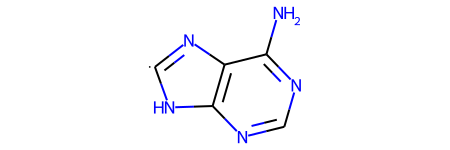

True

In [93]:
Chem.AddHs(molfromsmiles('O=c1ccc(=O)c2[nH]c1=2')).HasSubstructMatch(Chem.MolFromSmarts('[H]n(c)c'))
fragdb.xs('[H]n([c])c')
molfromsmiles('Nc1ncnc2[nH][c]nc12')
Chem.AddHs(molfromsmiles('c1ccc2[nH]ccc2c1')).HasSubstructMatch(Chem.MolFromSmarts('[H]n([c])c'))

In [70]:
# Chem.MolFromSmarts('[H]Cl(c)(=O)Cl').GetSubstructMatch(Chem.MolFromSmarts('cCl'))
demol=Chem.MolFromSmarts('[H][15n](c)c')
[a.SetIsotope(0) for a in demol.GetAtoms()]
Chem.MolToSmiles(demol)

[None, None, None, None]

'[H]n(c)c'

In [33]:
fragdict

{'[H]n(c)c': {'Query': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12'],
  'Fraglist': ['[H]n(c)c',
   '[2H]n(c)c',
   '[H][15n](c)c',
   '[H][n+](c)c',
   '[H][15n](c)[13c]',
   '[H][15n]([13c])[13c]',
   '[H]n(c)[14c]',
   '[H]n(c)[13c]',
   '[2H][n+](c)c',
   '[H]n(c)[11c]',
   '[H]n([c])c',
   '[H]n(c)[c+]',
   '[H]n1c=c1',
   '[H]n([13c])[13c]',
   '[H]n(-c)-c',
   '[H]n([c-])c',
   '[2H]n(c)[13c]',
   '[3H]n(c)c',
   '[H]n(c)[c-]',
   '[2H][15n+](c)c',
   '[H]n1cc1',
   '[H-][n+](c)c'],
  'analoguepool': {4194306,
   23068676,
   12582924,
   12582925,
   31457295,
   31457296,
   31457297,
   12582931,
   10485780,
   12582935,
   29360152,
   29360153,
   4194330,
   29360154,
   29360157,
   29360158,
   29360159,
   29360160,
   29360161,
   29360162,
   29360163,
   29360164,
   29360165,
   10485798,
   10485797,
   29360166,
   29360167,
   29360168,
   29360169,
   29360170,
   29360171,
   29360172,
   29360186,
   29360187,
   29360188,
   29360190,
   29360191,
   29360192,


In [ ]:
# demoquery3=updatequery(demoquery2, fragchoice={},similarity=True,fingerprint='morgan',morganradius=2,addHs=True,molwt=True) # Optional


In [769]:
# writepickle(demoquery2,dmdir,'inputquery_analg_compds')
demoquery2=openpickle(dmdir+'inputquery_analg_compds.pickle')

In [13]:
# writepickle(fragdict,dmdir,'fragdict')
fragdict=openpickle(dmdir+'fragdict.pickle')

In [ ]:
combinedpooldf=getcombinedpool(demoquery2,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,nomixtures=True,res_format='df')
combinedpool=getcombinedpool(demoquery2,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,nomixtures=True,res_format='list')

In [ ]:
combinedpooldf
combinedpool
len(combinedpool)

In [59]:
# pd.to_pickle(combinedpooldf,dmdir+'combinedpooldf.pickle')
# writepickle(combinedpool,dmdir,'combinedpool')
combinedpool=openpickle(dmdir+'combinedpool.pickle')

In [35]:
exemptionlist=openpickle(exemptiondir) #Catalysts misclassified as reagents (uncertain)
# combinedpoolex=updatecombinedpool(combinedpool,exemptionlist=exemptionlist)

In [60]:
# writepickle(combinedpoolex,dmdir,'combinedpoolex')
combinedpoolex=openpickle(dmdir+'combinedpoolex.pickle')

In [25]:
combinedpoolex
len(combinedpoolex)

{464,
 925,
 929,
 930,
 931,
 932,
 933,
 981,
 983,
 985,
 986,
 988,
 990,
 992,
 996,
 1001,
 1003,
 1013,
 1021,
 1028,
 1031,
 1035,
 1036,
 1037,
 1038,
 1040,
 1044,
 1045,
 1055,
 1059,
 1061,
 1062,
 1067,
 1097,
 1098,
 1106,
 1108,
 1114,
 1130,
 1142,
 1154,
 1159,
 1176,
 1184,
 1199,
 1202,
 1222,
 1263,
 1279,
 1292,
 1293,
 1299,
 1300,
 1323,
 1325,
 1327,
 1336,
 1345,
 1366,
 1368,
 1369,
 1372,
 1398,
 1400,
 1406,
 1429,
 1453,
 1454,
 1457,
 1458,
 1471,
 1483,
 1485,
 1500,
 1506,
 1507,
 1509,
 1511,
 1514,
 1515,
 1520,
 1526,
 1527,
 1538,
 1543,
 1548,
 1559,
 1563,
 1566,
 1569,
 1594,
 1595,
 1599,
 1607,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1633,
 1636,
 1637,
 1638,
 1639,
 1647,
 1649,
 1658,
 1659,
 1678,
 1701,
 1703,
 1711,
 1712,
 1713,
 1715,
 1717,
 1718,
 1720,
 1721,
 1722,
 1723,
 1725,
 1726,
 1727,
 1732,
 1733,
 1735,
 1736,
 1760,
 1773,
 1790,
 1791,
 1794,
 1799,
 1807,
 1808,
 1809,
 1815,
 1820,
 1821,


11021878

In [ ]:
reactiondb=pd.read_pickle(rxnsource)

In [ ]:
reactiondb

In [ ]:
analgdict=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strict',returnall=True,reaxys_update=False,refanaloguerxns=None,ncpus=16)

In [ ]:
getanaloguerxns(reactiondb,list(combinedpool)[:2000],combinedpoolex=list(combinedpoolex)[:2000],workflow='strict',returnall=True,reaxys_update=True,refanaloguerxns=analgdict['loosest']['analoguerxns'],ncpus=16)

In [ ]:
analgdict=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strict',returnall=True,reaxys_update=True,refanaloguerxns=analgdict['loosest']['analoguerxns'],ncpus=16)

In [ ]:
analgdict['loosest']['analoguerxns']

In [17]:
# writepickle(analgdict,dmdir,'analgrxns')
analgdict=pd.read_pickle(dmdir+'analgrxns.pickle')

In [18]:
analoguerxns=analgdict['loosest']['analoguerxns']
# analoguerxns
# analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False,na=False)) & (~analoguerxns.ReagentID.astype(bool)) & (~analoguerxns.SolventID.astype(bool)) & (~analoguerxns.Temperature.astype(bool)) & (~analoguerxns.Pressure.astype(bool)) & (~analoguerxns.ReactionTime.astype(bool)) & (~analoguerxns.CatalystID.astype(bool))]
# analoguerxns.loc[analoguerxns.MissingReagent.astype(bool)]
# analgdict['strict']['analoguerxns']

In [23]:
analoguerxns

,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,360592,1,[2464984],[],[198583],[],1,1,"[1098214, 8127940, 969212]",[],...,[],[],[],[],[],,[],"{2464984: '2-(2-hydroxy-ethoxy)-1,1-diphenyl-e...",[1958],{}
1,623995,1,[471913],[],[3269110],[],1,1,[19255899],[],...,[],[],[],[],[],,[],"{471913: '3-methoxy-2-hydroxybenzaldehyde', 32...",[1954],{}
2,798393,1,"[1912500, 774965]",[],[1990721],[],1,1,[3592982],[],...,[],[],[],[],[],,[],"{1912500: 'Diethyl phthalate', 774965: 'methyl...",[1958],{}
3,803260,2,"[507924, 79785]",[],[1873114],[],1,1,[],[],...,[],[605632],[],[3574984],[],var. concentration of reactants,[],"{507924: '4-methoxy-phenol', 79785: 'epichloro...",[1980],{}
4,803260,2,"[507924, 79785]",[],[1873114],[],1,1,[3611699],[],...,[],[],[],[],[],Behandeln des Reaktionsprodukts in CHCl<sub>3<...,[],"{507924: '4-methoxy-phenol', 79785: 'epichloro...",[1955],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,1,[31201625],[],[31201627],[],1,1,[742035],[],...,[4],[1098229],[],[],[],Inert atmosphere,[],{31201625: '(S)-tert-butyl (1-(2-cyano-4-(2-me...,[2017],{31201627: 48.0}
1358439,46546703,1,[31906875],[],[31906847],[],1,1,[3556712],[],...,[2],[506008],[],[],[],"Green chemistry, regiospecific reaction",[],{31906875: 'C<sub>18</sub>H<sub>19</sub>ClFNO'...,[2017],{31906847: 86.0}
1358440,41310364,1,[28783542],[],[28783556],[],1,1,[3615340],[],...,[2],[],[],[],[],"Inert atmosphere, Sealed tube",[],"{28783542: '(3',5'-dichloro-2,6-dimethoxybiphe...",[2015],{28783556: 96.0}
1358441,40504203,1,[28388225],[],[28388226],[],1,1,"[3587155, 8128150]",[],...,[2],[1098229],[],[],[],,[],{28388225: 'methyl 4-[[2-(tert-butoxycarbonyla...,[2015],{}


In [ ]:
analoguerxns.loc[analoguerxns.MissingCatalyst.astype(bool)]
analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool)) | (analoguerxns.MissingSolvent.astype(bool)) | (analoguerxns.MissingCatalyst.astype(bool))]
analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool))]

In [ ]:
analgdict2=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strictest',returnall=False,reaxys_update=True,refanaloguerxns=None,ncpus=16)

In [ ]:
updateanaloguerxns(analoguerxns2.iloc[:10000])

In [34]:
unresolvedids=openpickle(unresolveddir)

In [27]:
unresolvedids

{16777216,
 1,
 16777223,
 8388629,
 16777240,
 20971545,
 16777244,
 16777247,
 29360173,
 8388667,
 16777286,
 29360211,
 29360212,
 29360213,
 29360214,
 29360215,
 29360216,
 16777304,
 8388693,
 8388699,
 29360220,
 29360221,
 16777370,
 29360285,
 29343364,
 29360287,
 29360288,
 29360289,
 29360296,
 29360298,
 29360299,
 29360300,
 8388788,
 29360309,
 29360310,
 29360311,
 29360312,
 8388789,
 16777402,
 8388796,
 8388803,
 8388806,
 8388807,
 8388808,
 8388810,
 8388811,
 8388812,
 16777421,
 8388854,
 8388855,
 8388857,
 16777465,
 8388870,
 8388871,
 8388872,
 8388873,
 8388875,
 8388876,
 8388877,
 8388878,
 8388879,
 8388881,
 8388882,
 8388883,
 8388884,
 8388886,
 8388887,
 8388888,
 8388890,
 8388891,
 8388893,
 8388894,
 16777503,
 8388895,
 8388897,
 8388898,
 8388899,
 8388900,
 8388901,
 8388903,
 8388904,
 8388906,
 8388907,
 8388908,
 8388909,
 8388911,
 8388912,
 8388914,
 8388915,
 16777541,
 4194660,
 4194663,
 16777581,
 16777620,
 4194717,
 12583327,
 125833

In [36]:
analoguerxns2=filteranaloguerxns(analoguerxns,unresolvedids,reaxys_update=True,exemptionlist=exemptionlist)

2022-02-20 20:42:32,561	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


86.58% reactions remaining after cleaning


In [16]:
# pd.to_pickle(analoguerxns2,dpdir+'analgrxnsfinal.pickle')
analoguerxns2=pd.read_pickle(dpdir+'analgrxnsfinal.pickle')

In [43]:
rxn_ids=['92']
reaxys_final=[]
while rxn_ids:
    if len(rxn_ids)>=5:
        nsessions=5
    else:
        nsessions=len(rxn_ids)    
    finalres=main__(nsessions,reaxys_ids=rxn_ids) #Calls API with 5 concurrent sessions, 100 IDs selected and retrieved at once
    reaxys_dat=[record for batch in finalres for record in batch[0]]
    errorlst=[errorid for batch in finalres for errorid in batch[1]]
    if not reaxys_dat:
        break
    if not errorlst or len(errorlst)==1:
        reaxys_final+=reaxys_dat
        break
    reaxys_final+=reaxys_dat
    rxn_ids=errorlst

2022-02-20 03:13:27,534	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [49]:
analoguerxns3=addspeciesdata(analoguerxns2,substancesource,includesolv=True,ncpus=16,SQL=False,reaxys_update=True,hc_Dict=hc_Dict,hc_rct=hc_rct,refanaloguerxns=analoguerxns3)#refanaloguerxns=ff

2022-02-21 03:05:38,655	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [ ]:
analoguerxns3=addspeciesdata(analoguerxns2,substancesource,includesolv=True,ncpus=16,SQL=False,reaxys_update=True,hc_Dict=hc_Dict,hc_rct=hc_rct)

In [17]:
# pd.to_pickle(analoguerxns3[:1000],dpdir+'analgrxnsfinal2lite.pickle')
# pd.to_pickle(analoguerxns3,dpdir+'analgrxnsfinal2.pickle')
analoguerxns3=pd.read_pickle(dpdir+'analgrxnsfinal2.pickle')

For balancing, there are message outputs: Already balanced (reaction is balanced as represented in Reaxys), balanced * with (reaction has been balanced with added species (reactants, reagents), help products or help reactants), 'Imbalanced * with (Reaction is imbalanced with potentially compatible LHS species), 'Invalid balancing' (Balancing is invalid or wrong due to moving species from LHS to RHS, missing species, inability to resolve duplicate molecular formulae), 'LHS species insufficient' (Reaction lacks species on LHS for balancing)

In [ ]:
balance_analogue(analoguerxns3.iloc[30],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('CCCC/C(Cl)=C\\C(=O)[Si](C)(C)C>>CCCC=C(Cl)CC(=O)[Si](C)(C)C',useSmiles=True)

In [ ]:
balance_analogue(analoguerxns3.iloc[10],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('OC(c1ccc(Cl)cc1)P(c1ccccc1)c1ccccc1.OO>>O=P(c1ccccc1)(c1ccccc1)C(O)c1ccc(Cl)cc1.O',useSmiles=True)

In [ ]:
balance_analogue(analoguerxns3.iloc[0],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1.Cl',useSmiles=True)

In [ ]:
balance_analogue(analoguerxns3.iloc[50],basic=True,balance=True,coefflim=5,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('N#CC1(Cl)CCCCC1.CC(C)(C)C(=O)Cl>>CC(C)(C)C(=O)C1(C#N)CCCCC1',useSmiles=True)

In [ ]:
balance_analogue(analoguerxns3.iloc[20],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl>>C[C@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl',useSmiles=True)
balance_analogue(analoguerxns3.iloc[100],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('C#CCOC(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1.O=C1CCC(=O)N1Br>>O=C(CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1)OCC#CBr',useSmiles=True)

In [ ]:
rdChemReactions.ReactionFromSmarts('COC(=O)C1(C#N)C(=NC(C)(C)C)C(c2ccc(Cl)cc2)N1N1C(=O)c2ccccc2C1=O>>O=C1NC(=O)c2ccccc21.COC(=O)C(C#N)=NC(=C(NC(C)(C)C)OC)c1ccc(Cl)cc1.COC(=O)C(C#N)=NC(=C(NC(C)(C)C)N1C(=O)c2ccccc2C1=O)c1ccc(Cl)cc1',useSmiles=True)
balance_analogue(analoguerxns3.loc[4197],basic=True,helpreact=False,helpprod=False,includesolv=True)
rdChemReactions.ReactionFromSmarts('COC(=O)C1(C#N)C(=NC(C)(C)C)C(c2ccc(Cl)cc2)N1N1C(=O)c2ccccc2C1=O.COC(=O)C1(C#N)C(=NC(C)(C)C)C(c2ccc(Cl)cc2)N1N1C(=O)c2ccccc2C1=O.CO>>O=C1NC(=O)c2ccccc21.COC(=O)C(C#N)=NC(=C(NC(C)(C)C)OC)c1ccc(Cl)cc1.COC(=O)C(C#N)=NC(=C(NC(C)(C)C)N1C(=O)c2ccccc2C1=O)c1ccc(Cl)cc1',useSmiles=True)

In [ ]:
rdChemReactions.ReactionFromSmarts('Cc1nc2cc(Cl)c(Cl)cc2nc1-c1ccccc1>>C[C@H]1Nc2cc(Cl)c(Cl)cc2N[C@H]1c1ccccc1.C[C@H]1Nc2cc(Cl)c(Cl)cc2N[C@H]1c1ccccc1',useSmiles=True)
balance_analogue(analoguerxns3.loc[1356850],includesolv=True,helpprod=False,helpreact=False,coefflim=6) # 485968
rdChemReactions.ReactionFromSmarts('Cc1nc2cc(Cl)c(Cl)cc2nc1-c1ccccc1.Cc1nc2cc(Cl)c(Cl)cc2nc1-c1ccccc1.[H][H].[H][H].[H][H].[H][H]>>C[C@H]1Nc2cc(Cl)c(Cl)cc2N[C@H]1c1ccccc1.C[C@H]1Nc2cc(Cl)c(Cl)cc2N[C@H]1c1ccccc1',useSmiles=True)

In [ ]:
balance_analogue(analoguerxns3.loc[analoguerxns3.ReactionID==44420].iloc[1],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',useSmiles=True)

### Balancing

First pass is balancing just the LHS of reactions (to make sure that all product atoms can be traced to reactant atoms). However, in most cases there will be a surplus of atoms on the LHS, implying there should be by-products on the RHS. This can be tackled later

In [94]:
analoguerxns3

NameError: name 'analoguerxns3' is not defined

In [ ]:
# analoguerxns3[5210:5212].apply(balance_analogue,includesolv=True,helpprod=False,helpreact=False,axis=1,result_type='reduce')
balance_analogue(analoguerxns3.loc[38197],includesolv=True,helpprod=False,helpreact=False)

In [299]:
balance_analogue_(analoguerxns3[5150:5200],includesolv=True,reaxys_update=True,helpprod=False,helpreact=False)

2022-02-10 02:10:44,316	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


(5150    (O=CC(CCc1ccc(O)cc1)CCc1ccc(O)cc1>>OCC(CCc1ccc...
 5151    (O=C(O)c1cccc(Cl)c1.CC[Si](CC)(CC)O[C@H]1C[C@H...
 5152    (O=C(O)c1cccc(Cl)c1.CC[Si](CC)(CC)O[C@H]1C[C@H...
 5153    (O=C(NCc1ccc(S(=O)(=O)Cl)cc1)c1ccc(Cl)cc1Cl.NC...
 5154    (C=C(CCN(C(=O)OC(C)(C)C)c1ccco1)Sc1ccccc1>>CC(...
 5155    (COC(=O)[C@H](Cc1ccc(OC(C)=O)c(OC(C)=O)c1)NC(C...
 5156    (COC(=O)[C@H](Cc1ccc(OC(C)=O)c(OC(C)=O)c1)NC(C...
 5157    (CCCC(=O)c1ccccc1.N#Cc1ccccc1>>CCc1oc(-c2ccccc...
 5158    (COC(=O)[C@H](O)[C@@H](N)c1ccccc1.C=CCOC(=O)Cl...
 5159    (Nc1ccccc1CNc1ccccc1.O=Cc1cccc([N+](=O)[O-])c1...
 5160    (C[Si](C)(C)CCOC(=O)N1CCC[C@@H](C(=O)N2C(=O)OC...
 5161    (N#Cc1ncccc1-n1cncn1>>NCc1ncccc1-n1cncn1, N#Cc...
 5162    (NNc1nnc2sc3ccccc3n12.COc1ccc(C=O)cc1OC>>COc1c...
 5163    (COc1cc(C(=O)c2cn(S(=O)(=O)c3ccccc3)c3ccccc23)...
 5164    (COc1cc(C(=O)c2cn(S(=O)(=O)c3ccccc3)c3ccccc23)...
 5165    (CNCC(O)c1cccc(C#N)c1.Cn1cc(C(=O)NCc2ccc(Cl)cc...
 5166    (CNCC(O)c1cccc(C#N)c1.Cn1cc(C(=O)NCc2ccc(Cl)cc.

In [159]:
analoguerxnsbal6=analoguerxnsbal5

In [201]:
balrxns5,analoguerxnsbal5=balance_analogue_(analoguerxns3[:50000],refbalrxns=None,reaxys_update=True,includesolv=True,
                                          helpprod=True,helpreact=False,addrctonly=False,ignoreH=False,ncpus=16)

2022-02-24 15:18:05,000	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [20]:
balrxns,analoguerxnsbal=balance_analogue_(analoguerxns3,refbalrxns=None,reaxys_update=True,includesolv=True,
                                          helpprod=False,helpreact=False,ncpus=16)

2022-01-13 03:35:29,848	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [103]:
analoguerxnsbal5

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87107      3              17         1          1   
           5              17         1          2   
           6              17         1          1   
           7              17         1          2   
           8              17         1          1   
...                      ...       ...        ...   
142739     0               1         1          1   
142741     0               1         1          1   
142744     0               1         1          1   
142746     0               3         1          1   
           1               3         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12>>Cc1ccc2c(c1)nc(O)c...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   
           1         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12.O=[Cr](=O)([O-])O[C...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   
           1         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   

                                                                   msg  \
ReactionID Instance                                                      
87107      3                                          Already balanced   
           5                                          Already balanced   
           6                                          Already balanced   
           7                                          Already balanced   
           8                                          Already balanced   
...                                                                ...   
142739     0                        Balanced with help product(s): HCl   
142741     0                        Balanced with help product(s): HCl   
142744     0         Mapper used, Mixture detected for LHS species:...   
142746     0         Mapper used, Unmapped species from LHS: 103233...   
           1             RHS species insufficient with species: 143877   

                                    LHS        RHS hcrct hcprod  \
ReactionID Instance                                               
87107      3           [118515, 774631]  [3368113]    []     []   
           5           [118515, 774631]  [3368113]    []     []   
           6           [118515, 774631]  [3368113]    []     []   
           7           [118515, 774631]  [3368113]    []     []   
           8           [118515, 774631] 

In [23]:
import ipywidgets as widgets
def visoutput(analoguerxns):
    if analoguerxns.index.name or analoguerxns.index.names:
        analoguerxns.reset_index(inplace=True)
    a = widgets.IntSlider(min=0,max=len(analoguerxns)-1,description='Row Number')
# b = widgets.IntSlider(description='b')
# c = widgets.IntSlider(description='c')
    def f(a):
        reaxysID=analoguerxns.iloc[a].ReactionID
        print('Reaxys reaction '+str(reaxysID)+':')
        if 'rxnsmiles0' in analoguerxns.dtypes:
            rxnsmiles0=analoguerxns.iloc[a].rxnsmiles0
            display(drawReaction(rdChemReactions.ReactionFromSmarts(rxnsmiles0,useSmiles=True)))
        if 'balrxnsmiles' in analoguerxns.dtypes:
            balrxnsmiles=analoguerxns.iloc[a].balrxnsmiles
            msg=analoguerxns.iloc[a].msg
            print('Balancing algorithm output: '+msg)
            print('Balanced reaction:')
            if balrxnsmiles!='Error':
                display(drawReaction(rdChemReactions.ReactionFromSmarts(balrxnsmiles,useSmiles=True)))
                print(balrxnsmiles)
            else:
                print('Error')
        if 'mapped_rxn' in analoguerxns.dtypes:
            mappedrxn=analoguerxns.iloc[a].mapped_rxn
        else:
            try:
                mappedrxn=maprxn([balrxnsmiles])[0]['mapped_rxn']
            except Exception:
                mappedrxn='Error'
        print('Mapped reaction:')
        if mappedrxn!='Error':
            display(drawReaction(rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)))
        else:
            print(mappedrxn)
        if 'msg1' in analoguerxns.dtypes:
            msg1=analoguerxns.iloc[a].msg1
            print('Mapping validity: '+msg1)
        if 'template' in analoguerxns.dtypes:
            template=analoguerxns.iloc[a].template
            msg4=analoguerxns.iloc[a].msg4
            print('Template message: '+msg4)
            print('Template:')
            display(drawReaction(rdChemReactions.ReactionFromSmarts(template,useSmiles=True)))
    out = widgets.interactive_output(f, {'a': a})
    display(a)
    display(out)
    
def visoutput2(analoguerxns):
    if analoguerxns.index.name or analoguerxns.index.names:
        analoguerxns.reset_index(inplace=True)
    b = widgets.IntSlider(min=min(analoguerxns.ReactionID),max=max(analoguerxns.ReactionID),description='Reaxys ID')
    c = widgets.IntSlider(min=0,max=len(analoguerxns.loc[analoguerxns.ReactionID==b]),description='Instance')
    def f(b,c):
        reaxysID=b
        inst=c
        print('Reaxys reaction '+str(reaxysID)+':')
        if 'rxnsmiles0' in analoguerxns.dtypes:
            rxnsmiles0=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].rxnsmiles0
            display(drawReaction(rdChemReactions.ReactionFromSmarts(rxnsmiles0,useSmiles=True)))
        if 'balrxnsmiles' in analoguerxns.dtypes:
            balrxnsmiles=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].balrxnsmiles
            msg=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg
            print('Balancing algorithm output: '+msg)
            print('Balanced reaction:')
            if balrxnsmiles!='Error':
                display(drawReaction(rdChemReactions.ReactionFromSmarts(balrxnsmiles,useSmiles=True)))
                print(balrxnsmiles)
            else:
                print('Error')
        if 'mapped_rxn' in analoguerxns.dtypes:
            mappedrxn=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].mapped_rxn
        else:
            try:
                mappedrxn=maprxn([balrxnsmiles])[0]['mapped_rxn']
            except Exception:
                mappedrxn='Error'
        print('Mapped reaction:')
        if mappedrxn!='Error':
            display(drawReaction(rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)))
        else:
            print(mappedrxn)
        if 'msg1' in analoguerxns.dtypes:
            msg1=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg1
            print('Mapping validity: '+msg1)
        if 'template' in analoguerxns.dtypes:
            template=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].template
            msg4=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg4
            print('Template message: '+msg4)
            print('Template:')
            display(drawReaction(rdChemReactions.ReactionFromSmarts(template,useSmiles=True)))
    out = widgets.interactive_output(f, {'b': b,'c':c})
    display(b)
    display(c)
    display(out)

In [252]:
demostr='With hydrogen carriers: 3587189,34234234,324324, Balanced with species: 3587189 with help product(s): O2'
demostr.split('With hydrogen carriers: ')[1].split(', ')

['3587189,34234234,324324',
 'Balanced with species: 3587189 with help product(s): O2']

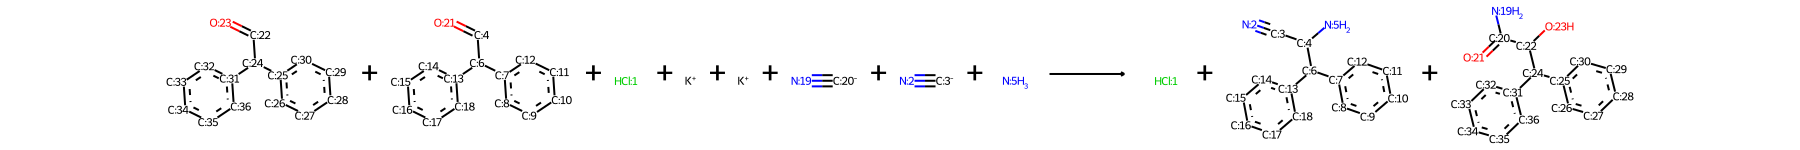

In [32]:
rdChemReactions.ReactionFromSmarts('[CH:22](=[O:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1.[CH:4]([CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)[c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1)=[O:21].[ClH:1].[K+].[K+].[N:19]#[C-:20].[N:2]#[C-:3].[NH3:5]>>[ClH:1].[N:2]#[C:3][CH:4]([NH2:5])[CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)[c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1.[NH2:19][C:20](=[O:21])[CH:22]([OH:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1',useSmiles=True)

In [31]:
maprxn(['[C-]#N.[K+].[C-]#N.[K+].O=CC(c1ccccc1)c1ccccc1.O=CC(c1ccccc1)c1ccccc1.Cl.N>>Cl.N#CC(N)C(c1ccccc1)c1ccccc1.NC(=O)C(O)C(c1ccccc1)c1ccccc1'])

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': '[CH:22](=[O:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1.[CH:4]([CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)[c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1)=[O:21].[ClH:1].[K+].[K+].[N:19]#[C-:20].[N:2]#[C-:3].[NH3:5]>>[ClH:1].[N:2]#[C:3][CH:4]([NH2:5])[CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)[c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1.[NH2:19][C:20](=[O:21])[CH:22]([OH:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1',
  'confidence': 0.07709951024404355}]

In [29]:
analoguerxnsmapped.xs((140912,0)).LHSdata

{11043468: {'atomdict': {'C': 1, 'N': 1, 'K': 1},
  'charge': 0,
  'smiles': '[C-]#N.[K+]',
  'formula': 'CKN',
  'count': 2,
  'mixture': True},
 1424292: {'atomdict': {'O': 1, 'C': 14, 'H': 12},
  'charge': 0,
  'smiles': 'O=CC(c1ccccc1)c1ccccc1',
  'formula': 'C14H12O',
  'count': 2,
  'mixture': False},
 4371014: {'atomdict': {'Cl': 1, 'N': 1, 'H': 4},
  'charge': 0,
  'smiles': 'Cl.N',
  'formula': 'H4ClN',
  'count': 2,
  'mixture': True}}

In [104]:
balance_analogue(analoguerxns3.xs((140912,0)),ignoreH=True)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


('O=CC(c1ccccc1)c1ccccc1>>Cl.N#CC(N)C(c1ccccc1)c1ccccc1.NC(=O)C(O)C(c1ccccc1)c1ccccc1',
 '[C-]#N.[K+].[C-]#N.[K+].O=CC(c1ccccc1)c1ccccc1.O=CC(c1ccccc1)c1ccccc1.Cl.N>>Cl.N#CC(N)C(c1ccccc1)c1ccccc1.NC(=O)C(O)C(c1ccccc1)c1ccccc1',
 'Mapper used, Mixture detected for LHS species: 11043468,4371014, Unmapped species instances from LHS: 4371014, Hydrogen carriers: 1424292,4371014 with species: 11043468,4371014',
 [11043468, 11043468, 1424292, 1424292, 4371014],
 [3722435, 3312646],
 [],
 [],
 OrderedDict([(11043468,
               {'atomdict': {'C': 1, 'N': 1, 'K': 1},
                'charge': 0,
                'smiles': '[C-]#N.[K+]',
                'formula': 'CKN',
                'count': 2,
                'mixture': True}),
              (1424292,
               {'atomdict': {'O': 1, 'C': 14, 'H': 12},
                'charge': 0,
                'smiles': 'O=CC(c1ccccc1)c1ccccc1',
                'formula': 'C14H12O',
                'count': 2,
                'mixture': False}),
 

In [ ]:
analoguerxnsbal5.xs((116671, 1799))
analoguerxnsbal4.xs((116671, 1799)).RHSdata
analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('3587189')]

In [161]:
set(analoguerxnsbal6.loc[analoguerxnsbal6.msg.str.contains('balanced',case=False,na=False)].index)-set(analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('balanced',case=False,na=False)].index)
# set(analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal3.loc[analoguerxnsbal3.msg.str.contains('balanced',case=False,na=False)].ReactionID)

set()

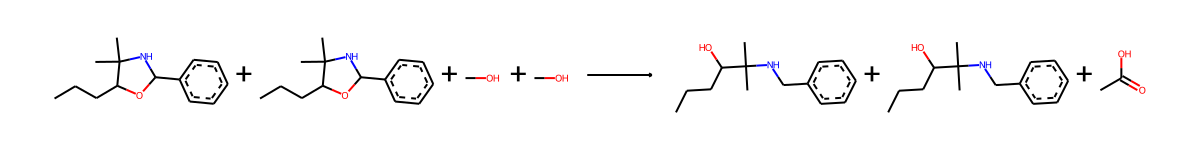

In [146]:
rdChemReactions.ReactionFromSmarts('CCCC1OC(c2ccccc2)NC1(C)C.CCCC1OC(c2ccccc2)NC1(C)C.CO.CO>>CCCC(O)C(C)(C)NCc1ccccc1.CCCC(O)C(C)(C)NCc1ccccc1.CC(=O)O',useSmiles=True)

In [303]:
analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('hydrogen carriers')]


NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87239      0               2         1          1   
           1               2         1          1   
87240      0               3         1          1   
87241      0               1         2          1   
           1               1         1          1   
...                      ...       ...        ...   
142603     0               1         1          1   
142695     0               1         1          1   
142710     0               1         1          1   
142711     0               1         1          1   
142723     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87239      0                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
           1                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
87240      0                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87241      0                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
           1                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
...                                                                ...   
142603     0         Cc1cc(C)c2c(c1)C(=O)C(=O)N2>>Cc1cc(C)c2c(c1)C(...   
142695     0            CCCCCCC(=O)c1cc(CC)sc1CC>>CCCCCCCc1cc(CC)sc1CC   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C>>CCCC(O)C(C)(C)NCc1cc...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3>>Cc1ccc2c(c1)NC1CCCCC...   
142723     0              Cc1cc(Cl)nc2c(Cl)cccc12>>Cc1ccnc2c(Cl)cccc12   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87239      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.[H][H]...   
           1           O=C1OC(=O)c2ccccc21.S.S.S.[Mo]>>Cc1ccccc1C(=O)O   
87240      0         O=C1OC(=O)c2ccccc21.[AlH4-].[Li+]>>c1ccc2c(c1)...   
87241      0         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
           1         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
...                                                                ...   
142603     0         Cc1cc(C)c2c(c1)C(=O)C(=O)N2.Cc1cc(C)c2c(c1)C(=...   
142695     0         CCCCCCC(=O)c1cc(CC)sc1CC.NN>>CCCCCCCc1cc(CC)sc1CC   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C.CCCC1OC(c2ccccc2)NC1(...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3.CO>>Cc1ccc2c(c1)NC1CC...   
142723     0           Cc1cc(Cl)nc2c(Cl)cccc12.Cl>>Cc1ccnc2c(Cl)cccc12   

                                                                   msg  \
ReactionID Instance                                                      
87239      0         With hydrogen carriers: 3587189, Balanced with...   
           1         With hydrogen carriers: 14327304, RHS species ...   
87240      0         With hydrogen carriers: 11460447, RHS species ...   
87241      0         Mapper used, Unmapped species from LHS: 358721...   
           1         With hydrogen carriers: 3587189, RHS species i...   
...                                                                ...   
142603     0         With hydrogen carriers: 1718733, Balanced with...   
142695     0         With hydrogen carriers: 878137, RHS species in...   
142710     0         With hydrogen carriers: 1098229, Balanced with...   
142711     0         With hydrogen carriers: 1098229, RHS species i...   
142723     0         With hydrogen carriers: 1098214, RHS species i...   

                                                                   LHS  \
ReactionID Instance                                                      
87239      0         [118515, 118515, 3587189, 3587189, 3587189, 35...   
           1                                        [118515, 14327304]   
87240      0                                        [118515, 11460447]   
87241      0              [118515, 3587189, 3587189, 3587189, 3587189]  

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87239      0               2         1          1   
           1               2         1          1   
87240      0               3         1          1   
87241      0               1         2          1   
           1               1         1          1   
...                      ...       ...        ...   
142603     0               1         1          1   
142695     0               1         1          1   
142710     0               1         1          1   
142711     0               1         1          1   
142723     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87239      0                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
           1                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
87240      0                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87241      0                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
           1                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
...                                                                ...   
142603     0         Cc1cc(C)c2c(c1)C(=O)C(=O)N2>>Cc1cc(C)c2c(c1)C(...   
142695     0            CCCCCCC(=O)c1cc(CC)sc1CC>>CCCCCCCc1cc(CC)sc1CC   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C>>CCCC(O)C(C)(C)NCc1cc...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3>>Cc1ccc2c(c1)NC1CCCCC...   
142723     0              Cc1cc(Cl)nc2c(Cl)cccc12>>Cc1ccnc2c(Cl)cccc12   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87239      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.[H][H]...   
           1           O=C1OC(=O)c2ccccc21.S.S.S.[Mo]>>Cc1ccccc1C(=O)O   
87240      0         O=C1OC(=O)c2ccccc21.[AlH4-].[Li+]>>c1ccc2c(c1)...   
87241      0         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
           1         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
...                                                                ...   
142603     0         Cc1cc(C)c2c(c1)C(=O)C(=O)N2.Cc1cc(C)c2c(c1)C(=...   
142695     0         CCCCCCC(=O)c1cc(CC)sc1CC.NN>>CCCCCCCc1cc(CC)sc1CC   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C.CCCC1OC(c2ccccc2)NC1(...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3.CO>>Cc1ccc2c(c1)NC1CC...   
142723     0           Cc1cc(Cl)nc2c(Cl)cccc12.Cl>>Cc1ccnc2c(Cl)cccc12   

                                                                   msg  \
ReactionID Instance                                                      
87239      0         With hydrogen carriers: 3587189, Balanced with...   
           1         With hydrogen carriers: 14327304, RHS species ...   
87240      0         With hydrogen carriers: 11460447, RHS species ...   
87241      0         Mapper used, Unmapped species from LHS: 358721...   
           1         With hydrogen carriers: 3587189, RHS species i...   
...                                                                ...   
142603     0         With hydrogen carriers: 1718733, Balanced with...   
142695     0         With hydrogen carriers: 878137, RHS species in...   
142710     0         With hydrogen carriers: 1098229, Balanced with...   
142711     0         With hydrogen carriers: 1098229, RHS species i...   
142723     0         With hydrogen carriers: 1098214, RHS species i...   

                                                                   LHS  \
ReactionID Instance                                                      
87239      0         [118515, 118515, 3587189, 3587189, 3587189, 35...   
           1                                        [118515, 14327304]   
87240      0                                        [118515, 11460447]   
87241      0              [118515, 3587189, 3587189, 3587189, 3587189]  

In [367]:
analoguerxns3.iloc[44].Rgtdata
analoguerxnsbal7.loc[analoguerxnsbal7.msg.str.contains('balanced',case=False,na=False)]
analoguerxnsbal6.loc[analoguerxnsbal6.msg.str.contains('balanced',case=False,na=False)]
analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('balanced',case=False,na=False)]
set(analoguerxnsbal7.loc[analoguerxnsbal7.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal8.loc[analoguerxnsbal8.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal6.loc[analoguerxnsbal6.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal7.loc[analoguerxnsbal7.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal7.loc[analoguerxnsbal7.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal2.loc[analoguerxnsbal2.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal7.loc[analoguerxnsbal7.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal6.loc[analoguerxnsbal6.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal5.loc[analoguerxnsbal5.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal3.loc[analoguerxnsbal3.msg.str.contains('balanced',case=False,na=False)].ReactionID)
set(analoguerxnsbal3.loc[analoguerxnsbal3.msg.str.contains('balanced',case=False,na=False)].ReactionID)-set(analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('balanced',case=False,na=False)].ReactionID)
analoguerxnsbal3.loc[4441]

{11342940: {'atomdict': {'Na': 1, 'O': 1, 'H': 1},
  'charge': 0,
  'smiles': '[Na+].[OH-]',
  'formula': 'HNaO',
  'count': 1}}

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,Balanced with help product(s): H2O,[2464984],[198583],[],[1],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1..."
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,Balanced with help product(s): C2H6O,"[1912500, 774965]",[1990721],[],[22],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ..."
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
6,924560,1,1,1,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,Balanced with species: 3587191 with help produ...,"[1157357, 3587191]",[1164235],[],[1],"{1157357: {'atomdict': {'C': 16, 'O': 4, 'N': ...","{1164235: {'atomdict': {'C': 16, 'O': 5, 'N': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10832,9100817,4,1,1,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1>>CO...,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1.[H]...,Balanced with species: 3587189 with help produ...,"[9136995, 3587189]",[8260331],[],[29],"{9136995: {'atomdict': {'C': 18, 'O': 4, 'N': ...","{8260331: {'atomdict': {'C': 11, 'O': 4, 'N': ..."
10836,9750974,1,1,1,Cc1ccc(C(O)CCCCCCCCCCCO)cc1>>Cc1ccc(C(=O)CCCCC...,Cc1ccc(C(O)CCCCCCCCCCCO)cc1.Cc1ccc(C(O)CCCCCCC...,"Mapper used, Balanced with species: 9864597 wi...","[9864597, 9864597]","[9861312, 9864598]",[],[2],"{9864597: {'atomdict': {'C': 19, 'O': 2, 'H': ...","{9861312: {'atomdict': {'C': 19, 'O': 2, 'H': ..."
10837,9755378,1,1,1,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,Balanced with species: 3587189 with help produ...,"[9880339, 3587189]",[9875386],[],[29],"{9880339: {'atomdict': {'C': 28, 'O': 4, 'N': ...","{9875386: {'atomdict': {'C': 21, 'O': 4, 'N': ..."
10838,9785884,1,1,1,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,Balanced with help product(s): H2,[3277866],[9196991],[],[2],"{3277866: {'atomdict': {'C': 13, 'O': 3, 'H': ...","{9196991: {'atomdict': {'C': 13, 'O': 3, 'H': ..."


,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,Balanced with help product(s): H2O,[2464984],[198583],[],[1],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1..."
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,Balanced with help product(s): C2H6O,"[1912500, 774965]",[1990721],[],[22],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ..."
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
6,924560,1,1,1,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,Balanced with species: 3587191 with help produ...,"[1157357, 3587191]",[1164235],[],[1],"{1157357: {'atomdict': {'C': 16, 'O': 4, 'N': ...","{1164235: {'atomdict': {'C': 16, 'O': 5, 'N': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10832,9100817,4,1,1,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1>>CO...,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1.[H]...,Balanced with species: 3587189 with help produ...,"[9136995, 3587189]",[8260331],[],[29],"{9136995: {'atomdict': {'C': 18, 'O': 4, 'N': ...","{8260331: {'atomdict': {'C': 11, 'O': 4, 'N': ..."
10836,9750974,1,1,1,Cc1ccc(C(O)CCCCCCCCCCCO)cc1>>Cc1ccc(C(=O)CCCCC...,Cc1ccc(C(O)CCCCCCCCCCCO)cc1.Cc1ccc(C(O)CCCCCCC...,"Mapper used, Balanced with species: 9864597 wi...","[9864597, 9864597]","[9861312, 9864598]",[],[2],"{9864597: {'atomdict': {'C': 19, 'O': 2, 'H': ...","{9861312: {'atomdict': {'C': 19, 'O': 2, 'H': ..."
10837,9755378,1,1,1,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,Balanced with species: 3587189 with help produ...,"[9880339, 3587189]",[9875386],[],[29],"{9880339: {'atomdict': {'C': 28, 'O': 4, 'N': ...","{9875386: {'atomdict': {'C': 21, 'O': 4, 'N': ..."
10838,9785884,1,1,1,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,Balanced with help product(s): H2,[3277866],[9196991],[],[2],"{3277866: {'atomdict': {'C': 13, 'O': 3, 'H': ...","{9196991: {'atomdict': {'C': 13, 'O': 3, 'H': ..."


,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,Balanced with help product(s): H2O,[2464984],[198583],[],[1],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1..."
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,Balanced with help product(s): C2H6O,"[1912500, 774965]",[1990721],[],[22],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ..."
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':..."
6,924560,1,1,1,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,Balanced with species: 3587191 with help produ...,"[1157357, 3587191]",[1164235],[],[1],"{1157357: {'atomdict': {'C': 16, 'O': 4, 'N': ...","{1164235: {'atomdict': {'C': 16, 'O': 5, 'N': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10831,9100817,4,1,1,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1>>CO...,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1.[H]...,Balanced with species: 3587189 with help produ...,"[9136995, 3587189]",[8260331],[],[29],"{9136995: {'atomdict': {'C': 18, 'O': 4, 'N': ...","{8260331: {'atomdict': {'C': 11, 'O': 4, 'N': ..."
10832,9100817,4,1,1,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1>>CO...,COc1ccc([C@H]2NC(=O)O[C@H]2COCc2ccccc2)cc1.[H]...,Balanced with species: 3587189 with help produ...,"[9136995, 3587189]",[8260331],[],[29],"{9136995: {'atomdict': {'C': 18, 'O': 4, 'N': ...","{8260331: {'atomdict': {'C': 11, 'O': 4, 'N': ..."
10837,9755378,1,1,1,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,COc1ccc(C2(C#N)CCN(C3(C(=O)OCc4ccccc4)CC3)CC2)...,Balanced with species: 3587189 with help produ...,"[9880339, 3587189]",[9875386],[],[29],"{9880339: {'atomdict': {'C': 28, 'O': 4, 'N': ...","{9875386: {'atomdict': {'C': 21, 'O': 4, 'N': ..."
10838,9785884,1,1,1,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,C=CC(OC(=O)CC(C)=O)c1ccccc1>>CC(=O)[C@@]12C[C@...,Balanced with help product(s): H2,[3277866],[9196991],[],[2],"{3277866: {'atomdict': {'C': 13, 'O': 3, 'H': ...","{9196991: {'atomdict': {'C': 13, 'O': 3, 'H': ..."


{84104,
 412346,
 2560771,
 2619051,
 2625758,
 2993193,
 3060351,
 3125452,
 3221905,
 3276544,
 3513451,
 3778534,
 4277330,
 4288316,
 5162399,
 5323415,
 8602590,
 8640596,
 8898678,
 9241136,
 9424390,
 9852159,
 9853106,
 10093521,
 10179877,
 10609444,
 10623157,
 10700998,
 10718171,
 10750481,
 10866889,
 11020506,
 11048865,
 11255113,
 11291243,
 15023417,
 23072022,
 23153571,
 23241285,
 23326241,
 23328394,
 23415048,
 23504049,
 23512466,
 23597593,
 23759263,
 23768521,
 23848406,
 23999096,
 24143527,
 24284154,
 25054328,
 25338319,
 25406840,
 25466353,
 25605989,
 25684625,
 25688602,
 25691687,
 25850343,
 25995072,
 27736307,
 27798566,
 27960446,
 28128710,
 28129711,
 28270372,
 28356272,
 28476300,
 28491436,
 28511518,
 28533745,
 28679471,
 28787464,
 28818957,
 28958495,
 28980885,
 29018310,
 29044699,
 29158979,
 29188177,
 29273764,
 29361730,
 29434433,
 29515262,
 29582408,
 29590815,
 29618245,
 29727447,
 29747247,
 29982041,
 29986639,
 30074158,
 30

{4224734,
 10000694,
 24733565,
 24820788,
 29051755,
 29561379,
 31059895,
 31335139,
 33373645,
 41483056,
 43470854,
 46188482}

{69506,
 70516,
 267198,
 270792,
 290521,
 295004,
 300221,
 301161,
 305575,
 311835,
 335188,
 337755,
 339152,
 344226,
 357571,
 415341,
 438699,
 585505,
 649920,
 671170,
 712376,
 716353,
 729265,
 803299,
 949479,
 1024851,
 1054637,
 1064837,
 1081648,
 1150435,
 1206103,
 1364755,
 1416632,
 1514043,
 1739219,
 1742440,
 1779075,
 2006069,
 2054536,
 2103327,
 2103892,
 2120908,
 2153577,
 2399077,
 2604995,
 2620340,
 2630625,
 2704493,
 2709709,
 2714838,
 2802404,
 2858226,
 2874417,
 2962965,
 3043714,
 3057051,
 3102549,
 3133575,
 3234521,
 3235698,
 3320825,
 3377156,
 3763041,
 3794979,
 3917021,
 4117934,
 4238425,
 4290282,
 4303478,
 4317608,
 4321869,
 4348992,
 4458449,
 4534458,
 4566599,
 4578309,
 4669510,
 4673950,
 4697925,
 4718042,
 4778770,
 4805517,
 4870031,
 4923924,
 5011342,
 5067252,
 5135336,
 5154457,
 5279933,
 5287646,
 5339195,
 6207776,
 8610791,
 8638862,
 8764370,
 8764374,
 8775640,
 8901824,
 9102180,
 9247578,
 9313954,
 9314776,
 934225

{88430,
 1235333,
 1252525,
 1821839,
 3132493,
 3138367,
 4656547,
 5027062,
 5160348,
 8681767,
 9093731,
 9406660,
 11117920,
 22962727,
 23310765,
 24431623,
 24792696,
 24817738,
 24969995,
 24976735,
 25031334,
 25047460,
 25513090,
 25981116,
 27887022,
 28119411,
 28345852,
 28657221,
 29060999,
 29422640,
 30459633,
 31157473,
 31335139,
 31876825,
 31916136,
 32105316,
 32661337,
 32691474,
 33053089,
 33968757,
 34056031,
 34676331,
 34766073,
 35571381,
 36460440,
 37681182,
 38557836,
 39116471,
 40008924,
 40104157,
 40173512,
 40360713,
 40873303,
 41287827,
 41812206,
 41957848,
 42036628,
 43786710,
 44118278,
 44130052,
 44850054,
 47284611}

{3708606, 4511606, 47857347}

{2894177,
 4844774,
 8868387,
 9617159,
 10081474,
 23503962,
 23684189,
 23769046,
 28797439,
 29442874,
 30685447,
 31909599,
 33836974,
 34841298,
 39600483,
 41748065,
 45271537,
 45932887,
 46861813,
 46925838}

{1077201,
 2479356,
 2560771,
 2619051,
 2625758,
 3039071,
 3060351,
 3125452,
 3221905,
 3276544,
 4100369,
 4288316,
 4639960,
 4799610,
 4842546,
 5162399,
 8640596,
 8898678,
 9241136,
 9424390,
 10093521,
 10179877,
 10700998,
 10718171,
 10866889,
 11020506,
 11048865,
 11233081,
 11255113,
 11291243,
 18606176,
 23072022,
 23153571,
 23326241,
 23328394,
 23415048,
 23504049,
 23597593,
 23757333,
 23759263,
 23768521,
 23999096,
 24143527,
 24284154,
 25054328,
 25338319,
 25466353,
 25605989,
 25684625,
 25688602,
 25691687,
 25850343,
 25995072,
 27736307,
 27960446,
 27994365,
 28129711,
 28190265,
 28419186,
 28448353,
 28511518,
 28533745,
 28683852,
 28912280,
 28915400,
 28980885,
 29029805,
 29088199,
 29145367,
 29158979,
 29188177,
 29354527,
 29434433,
 29618245,
 29747247,
 29982041,
 29986639,
 30127228,
 30456428,
 30766356,
 31503462,
 31521593,
 31580573,
 31938047,
 31970613,
 32329682,
 32786003,
 32789292,
 32832106,
 33050281,
 33495899,
 33992632,
 3409466

{1235333,
 1252525,
 1821839,
 2894177,
 3132493,
 3138367,
 4656547,
 5160348,
 8681767,
 8868387,
 9093731,
 9406660,
 9617159,
 10045719,
 10081474,
 11117920,
 22962727,
 23238598,
 23310765,
 23503962,
 23684189,
 24431623,
 24792696,
 24817738,
 24969995,
 24976735,
 25031334,
 25047460,
 25513090,
 25981116,
 27887022,
 28119411,
 28345852,
 28657221,
 28797439,
 29060999,
 29442874,
 30459633,
 30685447,
 31157473,
 31335139,
 31876825,
 31909599,
 31916136,
 32661337,
 33053089,
 33836974,
 34609361,
 34676331,
 34766073,
 35571381,
 36460440,
 37681182,
 39116471,
 39600483,
 40008924,
 40173512,
 40360713,
 40873303,
 41287827,
 41748065,
 41957848,
 42036628,
 43786710,
 44130052,
 44850054,
 45271537,
 45932887,
 46861813,
 47284611}

ReactionID                                               45807261
NumRefs                                                         1
NumSteps                                                        1
NumStages                                                       1
rxnsmiles0               Fc1ccc(S)c(F)c1>>O=S(=O)(Br)c1ccc(F)cc1F
balrxnsmiles    Br.O=O.Fc1ccc(S)c(F)c1>>O=S(=O)(Br)c1ccc(F)cc1...
msg             Mapper used, Balanced with species: 3587158,35...
LHS                                   [3587158, 3587218, 2516728]
RHS                                                    [31480309]
hcrct                                                          []
hcprod                                                        [2]
LHSdata         {3587158: {'atomdict': {'Br': 1, 'H': 1}, 'cha...
RHSdata         {31480309: {'atomdict': {'O': 2, 'S': 1, 'Br':...
Name: 4441, dtype: object

'[H][N]1[S]2([H])[N]([H])[S]3([H])[N]([H])[S]2([H])[N]([H])[S]13[H]'

'[N]1[S]2[N][S]3[N][S]2[N][S]13'

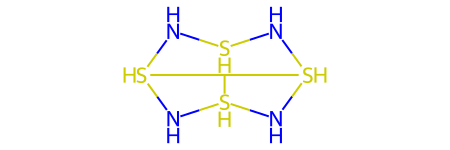

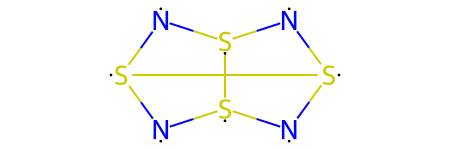

'[N]1[S]2[N][S]3[N][S]2[N][S]13'

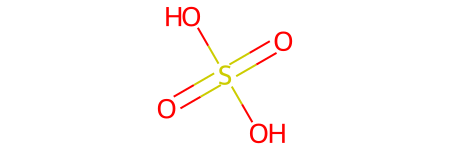

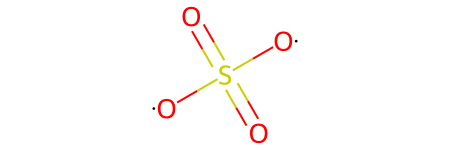

In [355]:
Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles('N1[SH]2N[SH]3N[SH]2N[SH]13')),allHsExplicit=True)
Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles('[N]1[S]2[N][S]3[N][S]2[N][S]13')),allHsExplicit=True)
molfromsmiles('N1[SH]2N[SH]3N[SH]2N[SH]13')
molfromsmiles('[N]1[S]2[N][S]3[N][S]2[N][S]13')
Chem.MolToSmiles(Chem.MolFromSmiles('[N]1[S]2[N][S]3[N][S]2[N][S]13'),allHsExplicit=True)
molfromsmiles('O=S(=O)(O)O')
molfromsmiles('[O]S([O])(=O)=O')

In [24]:
visoutput2(analoguerxnsbal4)

IntSlider(value=87107, description='Reaxys ID', max=142746, min=87107)

IntSlider(value=0, description='Instance', max=0)

Output()

In [378]:
balance_analogue(analoguerxns3.loc[analoguerxns3.ReactionID==33524898].iloc[0],basic=True,balance=True,coefflim=6,includesolv=True,helpprod=True,helpreact=False)
# balance_analogue(analoguerxns3.loc[2131].iloc[0],basic=True,balance=True,coefflim=6,includesolv=True,helpprod=True,helpreact=False)
# balance_analogue(analoguerxns3.loc[analoguerxns3.ReactionID==241618].iloc[0],basic=True,balance=True,coefflim=6,includesolv=True,helpprod=True,helpreact=False)

# analoguerxns3[:1000].apply(balance_analogue,includesolv=True,helpreact=False,helpprod=False,axis=1,result_type='reduce')

('Cc1ccc(S(=O)(=O)OCC2(C)COC2)cc1>>CC1(CSCC2(C)COC2)COC1',
 'Cc1ccc(S(=O)(=O)OCC2(C)COC2)cc1.O>>CC1(CSCC2(C)COC2)COC1',
 'RHS species insufficient with species: 3587155',
 [4441465, 3587155],
 [22699233],
 [],
 [],
 {4441465: {'atomdict': {'C': 12, 'S': 1, 'O': 4, 'H': 16},
   'charge': 0,
   'smiles': 'Cc1ccc(S(=O)(=O)OCC2(C)COC2)cc1',
   'formula': 'C12H16O4S',
   'count': 1},
  3587155: {'atomdict': {'O': 1, 'H': 2},
   'charge': 0,
   'smiles': 'O',
   'formula': 'H2O',
   'count': 1}},
 {22699233: {'atomdict': {'C': 10, 'S': 1, 'O': 2, 'H': 18},
   'charge': 0,
   'smiles': 'CC1(CSCC2(C)COC2)COC1',
   'formula': 'C10H18O2S',
   'count': 1}})

In [33]:
# rdChemReactions.ReactionFromSmarts(analoguerxnsbal5.xs((127175,0)).balrxnsmiles,useSmiles=True)
# analoguerxnsbal5.xs((127175,0)).LHS

In [151]:
# analoguerxnsbal.loc[analoguerxnsbal.msg.str.contains('Already',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('Balanced',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('RHS',case=False,na=False)]
# analoguerxnsbal.loc[(analoguerxnsbal.msg.str.contains('LHS',na=False)) | (analoguerxnsbal.msg.str.contains('Invalid',na=False))]
# analoguerxnsbal.loc[~(analoguerxnsbal.msg.str.contains('LHS',na=False)) & ~(analoguerxnsbal.msg.str.contains('Invalid',na=False)) & ~(analoguerxnsbal.msg.str.contains('Balanced',case=False,na=False)) & ~(analoguerxnsbal.msg.str.contains('RHS',case=False,na=False))]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('LHS species insufficient',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('mapping error',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('Hydrogen',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('invalid',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('Mandatory',case=False,na=False)]
analoguerxnsbal4.loc[analoguerxnsbal4.msg.str.contains('discrepancy',case=False,na=False)]
# analoguerxnsbal.loc[~(analoguerxnsbal.msg.str.contains('Balanced',case=False,na=False)) & ~(analoguerxnsbal.msg.str.contains('RHS',case=False,na=False))& ~(analoguerxnsbal.msg.str.contains('LHS',case=False,na=False)) & ~(analoguerxnsbal.msg.str.contains('mapping error',case=False,na=False)) & ~(analoguerxnsbal.msg.str.contains('agent',case=False,na=False)) & ~(analoguerxnsbal.msg.str.contains('invalid',case=False,na=False))]
# analoguerxnsbal.loc[analoguerxnsbal.msg.str.contains('discrepancy',case=False,na=False)].msg.iloc[1]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87107      3              17         1          1   
           5              17         1          2   
           6              17         1          1   
           7              17         1          2   
           8              17         1          1   
...                      ...       ...        ...   
142729     0               1         1          1   
142730     0               1         1          1   
142736     0               1         1          1   
142739     0               1         1          1   
142741     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142729     0         CCCCCCSc1nc(-c2ccccc2)c[nH]1>>CCCCCCS(=O)c1nc(...   
142730     0         CCCCCCSc1nc(-c2ccccc2)c[nH]1>>CCCCCCS(=O)(=O)c...   
142736     0         ICc1ccccc1.CCn1cc(-c2ccccc2)nn1>>CCn1cc(-c2ccc...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142729     0         CCCCCCSc1nc(-c2ccccc2)c[nH]1.OO>>CCCCCCS(=O)c1...   
142730     0         CCCCCCSc1nc(-c2ccccc2)c[nH]1.OO>>CCCCCCS(=O)(=...   
142736     0         ICc1ccccc1.CCn1cc(-c2ccccc2)nn1>>CCn1cc(-c2ccc...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   

                                                                   msg  \
ReactionID Instance                                                      
87107      3                                          Already balanced   
           5                                          Already balanced   
           6                                          Already balanced   
           7                                          Already balanced   
           8                                          Already balanced   
...                                                                ...   
142729     0         Balanced with species: 3587191 with help produ...   
142730     0         Balanced with species: 3587191 with help produ...   
142736     0                                          Already balanced   
142739     0                        Balanced with help product(s): HCl   
142741     0                        Balanced with help product(s): HCl   

                                  LHS        RHS hcrct hcprod  \
ReactionID Instance                                             
87107      3         [118515, 774631]  [3368113]    []     []   
           5         [118515, 774631]  [3368113]    []     []   
           6         [118515, 774631]  [3368113]    []     []   
           7         [118515, 774631]  [3368113]    []     []   
           8         [118515, 774631]  [3368113]    

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87119      0               1         1          1   
87133      0               2         1          1   
           1               2         1          1   
87152      0               1         1          1   
87158      0               1         1          1   
...                      ...       ...        ...   
142731     0               2         1          1   
142732     0               1         1          1   
142744     0               1         1          1   
142746     0               3         1          1   
           1               3         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87119      0         O=C1OC(=O)c2ccccc21.COc1ccc(C(=O)O)c(N)c1>>COc...   
87133      0         O=C1OC(=O)c2ccccc21.COc1cccc(OC)c1>>COc1ccc(C(...   
           1         O=C1OC(=O)c2ccccc21.COc1cccc(OC)c1>>COc1ccc(C(...   
87152      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21.COc1cc(-c2ccc...   
87158      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
...                                                                ...   
142731     0                   COc1cccc2c(C)cnnc12>>Cc1cnnc2c(O)cccc12   
142732     0                   COc1cccc2c(C)ncnc12>>Cc1ncnc2c(O)cccc12   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12>>Cc1ccc2c(c1)nc(O)c...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   
           1         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87119      0         O=C1OC(=O)c2ccccc21.COc1ccc(C(=O)O)c(N)c1>>COc...   
87133      0         O=C1OC(=O)c2ccccc21.COc1cccc(OC)c1>>COc1ccc(C(...   
           1         O=C1OC(=O)c2ccccc21.COc1cccc(OC)c1>>COc1ccc(C(...   
87152      0         COc1cc(-c2ccc(N)c(OC)c2)ccc1N.COc1cc(-c2ccc(N)...   
87158      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
...                                                                ...   
142731     0                   COc1cccc2c(C)cnnc12>>Cc1cnnc2c(O)cccc12   
142732     0                   COc1cccc2c(C)ncnc12>>Cc1ncnc2c(O)cccc12   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12.O=[Cr](=O)([O-])O[C...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   
           1         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   

                                                                   msg  \
ReactionID Instance                                                      
87119      0                                  RHS species insufficient   
87133      0                                  RHS species insufficient   
           1                                  RHS species insufficient   
87152      0         Mapper used, Unmapped species instances from L...   
87158      0         Mapper used, RHS species insufficient with spe...   
...                                                                ...   
142731     0                                  RHS species insufficient   
142732     0                                  RHS species insufficient   
142744     0         Mapper used, Mixture detected for LHS species:...   
142746     0         Mapper used, Unmapped species from LHS: 103233...   
           1             RHS species insufficient with species: 143877   

                                                                   LHS  \
ReactionID Instance                                                      
87119      0                                          [118515, 777691]   
87133      0                                          [118515, 878582]   
           1                                          [118515, 878582]   
87152      0         [1879884, 1879884, 118515, 118515, 906905, 906...  

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87131      0               1         1          1   
87248      11             43         1          1   
           20             43         1          1   
           21             43         1          1   
           31             43         1          1   
...                      ...       ...        ...   
142161     0               3         1          1   
142288     0               2         1          1   
           1               2         1          1   
142492     29             78         1          1   
142721     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87131      0         O=C1OC(=O)c2ccccc21.OCc1ccccc1>>O=C(OCc1ccccc1...   
87248      11                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           20                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           21                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           31                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
...                                                                ...   
142161     0         CCS(=O)(=O)Cc1ccc(Br)s1>>Br.[Br-].c1ccc2[s+]c3...   
142288     0         O=C(O)Cc1c[nH]c2ccccc12>>O=C(Cc1c[nH]c2ccccc12...   
           1         O=C(O)Cc1c[nH]c2ccccc12>>O=C(Cc1c[nH]c2ccccc12...   
142492     29         CC(=O)c1cc2ccccc2oc1=O>>O=C(CBr)c1cc2ccccc2oc1=O   
142721     0             Cc1cc(Cl)nc2c(N)cccc12>>Cc1cc(O)nc2c(N)cccc12   

                    balrxnsmiles                       msg               LHS  \
ReactionID Instance                                                            
87131      0               Error  LHS species insufficient  [118515, 878307]   
87248      11              Error  LHS species insufficient          [118515]   
           20              Error  LHS species insufficient          [118515]   
           21              Error  LHS species insufficient          [118515]   
           31              Error  LHS species insufficient          [118515]   
...                          ...                       ...               ...   
142161     0               Error  LHS species insufficient          [143267]   
142288     0               Error  LHS species insufficient          [143358]   
           1               Error  LHS species insufficient          [143358]   
142492     29              Error  LHS species insufficient          [143498]   
142721     0               Error  LHS species insufficient          [143840]   

                           RHS hcrct hcprod  \
ReactionID Instance                           
87131      0         [3485944]    []     []   
87248      11         [118522]    []     []   
           20         [118522]    []     []   
           21         [118522]    []     []   
           31         [118522]    []     []   
...                        ...   ...    ...   
142161     0         [3892963]    []     []   
142288     0          [221149]    []     []   
           1          [221149]    []     []   
142492     29         [178461]    []     []   
142721     0          [143843]    []     []   

                                                               LHSdata  \
ReactionID Instance                                                      
87131      0         {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...   
87248      11        {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...   
           20        {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...   
           21        {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...   
           31        {118515: {'atomdict': {'O': 3, 'C': 8, 'H': 4}...   
...                                                                ...   
142161     0         {143267: {'atomdict': {'C': 7, 'S': 2, 'O': 2,...   
142288     0         {143358: {'atomdict': {'O': 

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
ReactionID,Instance,,,,,,,,,,,,
127175,0,1,1,1,Oc1cc(O)cc(O)c1.CC(=O)Oc1cc(C(=O)Oc2c(OC(C)=O)...,Error,Mapping error,"[1341907, 1341907, 1341907, 1341907, 1341907, ...",[3497685],[],[],"{1341907: {'atomdict': {'O': 3, 'C': 6, 'H': 6...","{3497685: {'atomdict': {'C': 78, 'O': 42, 'H':..."


NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87239      0               2         1          1   
           1               2         1          1   
87240      0               3         1          1   
           1               3         1          1   
87241      0               1         2          1   
...                      ...       ...        ...   
142700     0               1         1          1   
142702     0               1         1          1   
142710     0               1         1          1   
142711     0               1         1          1   
142723     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87239      0                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
           1                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
87240      0                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
           1                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87241      0                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
...                                                                ...   
142700     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>Cc1cc(C(C)(C)C...   
142702     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>CC(C)(C)CCC(CO...   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C>>CCCC(O)C(C)(C)NCc1cc...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3>>Cc1ccc2c(c1)NC1CCCCC...   
142723     0              Cc1cc(Cl)nc2c(Cl)cccc12>>Cc1ccnc2c(Cl)cccc12   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87239      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.[H][H]...   
           1           O=C1OC(=O)c2ccccc21.S.S.S.[Mo]>>Cc1ccccc1C(=O)O   
87240      0         O=C1OC(=O)c2ccccc21.[AlH4-].[Li+]>>c1ccc2c(c1)...   
           1                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87241      0         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
...                                                                ...   
142700     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>Cc1cc(C(C)(C)C...   
142702     0         CC(C)(C)c1cc(C=O)c(C(C)(C)C)s1>>CC(C)(C)CCC(CO...   
142710     0         CCCC1OC(c2ccccc2)NC1(C)C.CCCC1OC(c2ccccc2)NC1(...   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3.CO>>Cc1ccc2c(c1)NC1CC...   
142723     0           Cc1cc(Cl)nc2c(Cl)cccc12.Cl>>Cc1ccnc2c(Cl)cccc12   

                                                                   msg  \
ReactionID Instance                                                      
87239      0         With hydrogen carriers: 3587189, Balanced with...   
           1         With hydrogen carriers: 14327304, RHS species ...   
87240      0         With hydrogen carriers: 11460447, RHS species ...   
           1                   Hydrogen carriers: 118515,967586,102391   
87241      0         Mapper used, Unmapped species from LHS: 358721...   
...                                                                ...   
142700     0         Hydrogen carriers: 143817,11342937,4933273,969209   
142702     0                         Hydrogen carriers: 143817,1718733   
142710     0         With hydrogen carriers: 1098229, Balanced with...   
142711     0         With hydrogen carriers: 1098229, RHS species i...   
142723     0         With hydrogen carriers: 1098214, RHS species i...   

                                                                   LHS  \
ReactionID Instance                                                      
87239      0         [118515, 118515, 3587189, 3587189, 3587189, 35...   
           1                                        [118515, 14327304]   
87240      0                                        [118515, 11460447]   
           1                                                  [118515]  

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87210      0               3         1          1   
           1               3         1          1   
103769     7              10         2          1   
107981     0               2         1          1   
           1               2         1          1   
           2               2         1          1   
           3               2         1          1   
119778     0               1         1          1   
140089     0               1         1          1   
           1               1         1          1   
140119     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87210      0         c1ccc2c(c1)ccc1c3ccccc3ccc21.O=C1OC(=O)c2ccccc...   
           1         c1ccc2c(c1)ccc1c3ccccc3ccc21.O=C1OC(=O)c2ccccc...   
103769     7                  CC(=O)c1ccccc1C(=O)O>>CC1OC(=O)c2ccccc21   
107981     0         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)c1ccccc1...   
           1         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)c1ccccc1...   
           2         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)c1ccccc1...   
           3         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)c1ccccc1...   
119778     0         Oc1ccccc1.O=C1CC(=O)c2ccccc2O1.O=C(CC(=O)Oc1cc...   
140089     0         CC(C)(C)c1ccccc1.CC(C)(OOC(C)(C)c1ccccc1)c1ccc...   
           1         CC(C)(C)c1ccccc1.CC(C)(OOC(C)(C)c1ccccc1)c1ccc...   
140119     0                    CC(C)(C)c1ccccc1>>CC(C)C.C.C=C(C)C.CCC   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87210      0         c1ccc2c(c1)ccc1c3ccccc3ccc21.O=C1OC(=O)c2ccccc...   
           1         c1ccc2c(c1)ccc1c3ccccc3ccc21.O=C1OC(=O)c2ccccc...   
103769     7         CC(=O)c1ccccc1C(=O)O.CC(=O)c1ccccc1C(=O)O.O=O>...   
107981     0         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)(OOC(C)(...   
           1         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)(OOC(C)(...   
           2         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)(OOC(C)(...   
           3         CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1.CC(C)(OOC(C)(...   
119778     0         Oc1ccccc1.O=C1CC(=O)c2ccccc2O1.O=C(CC(=O)Oc1cc...   
140089     0         CC(C)(C)c1ccccc1.CC(C)(OOC(C)(C)c1ccccc1)c1ccc...   
           1         CC(C)(C)c1ccccc1.CC(C)(OOC(C)(C)c1ccccc1)c1ccc...   
140119     0         CC(C)(C)c1ccccc1.CC(C)(C)c1ccccc1.CC(C)(C)c1cc...   

                                                                   msg  \
ReactionID Instance                                                      
87210      0         Invalid balancing. Species missing:969212 from...   
           1         Invalid balancing. Species missing:969212 from...   
103769     7         Invalid balancing. Species missing:3587218 fro...   
107981     0         Invalid balancing. Species missing:1718732 fro...   
           1         Invalid balancing. Species missing:1718732 fro...   
           2         Invalid balancing. Species missing:1718732 fro...   
           3         Invalid balancing. Species missing:1718732 fro...   
119778     0         Invalid balancing. Species missing:969616 from...   
140089     0         Invalid balancing. Species missing:1718732 fro...   
           1         Invalid balancing. Species missing:1718732 fro...   
140119     0         Invalid balancing. Species missing:1718732 fro...   

                                                                   LHS  \
ReactionID Instance                                                      
87210      0                                 [1909297, 118515, 969212]   
           1                                 [1909297, 118515, 969212]   
103769     7                               [1210557, 1210557, 3587218]   
107981     0         [2056090, 2056090, 2056090, 2056090, 2056090, ...  

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
ReactionID,Instance,,,,,,,,,,,,
103351,0,1,1,1,O=C(OO)c1ccccc1.ClC(Cl)Cl.O=C(c1ccccc1)C1CCCCC...,O=C(OO)c1ccccc1.ClC(Cl)Cl.O=C(c1ccccc1)C1CCCCC...,"Mapper used, Mandatory species unmapped from L...","[1210120, 1731042, 2046712]","[1311449, 1873466]",[],[],"{1210120: {'atomdict': {'O': 3, 'C': 7, 'H': 6...","{1311449: {'atomdict': {'O': 2, 'C': 13, 'H': ..."
108356,24,32,1,1,Brc1ccccc1>>Oc1ccccc1,Brc1ccccc1>>Oc1ccccc1,"Mapper used, Mandatory species unmapped from L...",[1236661],[969616],[],[],"{1236661: {'atomdict': {'Br': 1, 'C': 6, 'H': ...","{969616: {'atomdict': {'O': 1, 'C': 6, 'H': 6}..."
112312,0,1,1,1,O=[N+]([O-])c1cc([N+](=O)[O-])cc([N+](=O)[O-])...,O=[N+]([O-])c1cc([N+](=O)[O-])cc([N+](=O)[O-])...,"Mapper used, Mandatory species unmapped from L...","[1252144, 1915077]","[1914275, 2698044]",[],[],"{1252144: {'atomdict': {'O': 6, 'N': 3, 'C': 6...","{1914275: {'atomdict': {'C': 18, 'O': 2, 'H': ..."
117581,2,1,1,1,O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.Oc1c(Cl)c(C...,O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.Oc1c(Cl)c(C...,"Mapper used, Mandatory species unmapped from L...","[2055056, 1285380]","[2136445, 2136662]",[],[],"{2055056: {'atomdict': {'O': 1, 'C': 6, 'Cl': ...","{2136445: {'atomdict': {'O': 1, 'C': 6, 'Cl': ..."
119793,0,1,1,1,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.ClC(Cl...,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.ClC(Cl...,"Mapper used, Mandatory species unmapped from L...","[774044, 130237, 969206]","[58944, 19662]",[],[],"{774044: {'atomdict': {'O': 2, 'C': 3, 'Cl': 2...","{58944: {'atomdict': {'O': 8, 'C': 18, 'Se': 1..."
120368,0,3,1,1,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1ccc(O)c...,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1ccc(O)c...,"Mapper used, Mandatory species unmapped from L...","[2060433, 1305151]",[2068355],[],[],"{2060433: {'atomdict': {'C': 17, 'O': 4, 'H': ...","{2068355: {'atomdict': {'C': 31, 'O': 4, 'H': ..."
126664,0,1,1,1,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.c1ccc2c(c1)Cc1cc...,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.c1ccc2c(c1)Cc1cc...,"Mapper used, Mandatory species unmapped from L...","[1878026, 133939]",[2027895],[],[],"{1878026: {'atomdict': {'C': 15, 'O': 3, 'H': ...","{2027895: {'atomdict': {'C': 30, 'O': 6, 'H': ..."
126678,5,189,1,1,c1ccc2c(c1)Cc1ccccc1O2>>O=c1c2ccccc2oc2ccccc12,c1ccc2c(c1)Cc1ccccc1O2>>O=c1c2ccccc2oc2ccccc12,"Mapper used, Mixture detected for LHS species:...",[133939],[140443],[],[],"{133939: {'atomdict': {'C': 13, 'O': 1, 'H': 1...","{140443: {'atomdict': {'O': 2, 'C': 13, 'H': 8..."
132530,0,1,1,1,c1ccc(Oc2ccccc2)cc1.O=C1c2ccc(Cl)c(C(=O)O)c2-c...,c1ccc(Oc2ccccc2)cc1.O=C1c2ccc(Cl)c(C(=O)O)c2-c...,"Mapper used, Mandatory species unmapped from L...","[1364620, 3365679]",[249660],[],[],"{1364620: {'atomdict': {'C': 12, 'O': 1, 'H': ...","{249660: {'atomdict': {'O': 5, 'C': 14, 'H': 8..."


,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
ReactionID,Instance,,,,,,,,,,,,
91849,0,1,1,1,N#CCc1cccnc1Cl>>O=C(O)Cc1cccnc1O.Nc1ncccc1CC(=O)O,Error,"Mapper used, Smiles discrepancy for LHS specie...",[120624],"[129105, 5206]",[],[],"{120624: {'atomdict': {'N': 2, 'C': 7, 'Cl': 1...","{129105: {'atomdict': {'O': 3, 'C': 7, 'N': 1,..."
92291,0,2,1,1,c1ccc2c(c1)OCCS2>>O=S1(=O)CCOc2ccccc21,Error,"Mapper used, Smiles discrepancy for LHS specie...",[120847],[140018],[],[],"{120847: {'atomdict': {'C': 8, 'O': 1, 'S': 1,...","{140018: {'atomdict': {'O': 3, 'S': 1, 'C': 8,..."
99050,4,7,1,1,C[Si](C)(C)Cl>>C[Si](C)(C)OS(=O)(=O)O[Si](C)(C)C,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1209232],[1781429],[],[],"{1209232: {'atomdict': {'C': 3, 'Si': 1, 'Cl':...","{1781429: {'atomdict': {'C': 6, 'Si': 2, 'O': ..."
102840,4,10,1,1,CNC(=O)c1ccccc1>>CN(N=O)C(=O)c1ccccc1,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1209880],[2254366],[],[],"{1209880: {'atomdict': {'C': 8, 'N': 1, 'O': 1...","{2254366: {'atomdict': {'C': 8, 'N': 2, 'O': 2..."
107975,0,4,1,1,[c]1ccccc1.CC(C)c1ccccc1>>CC(C)c1ccc(-c2ccccc2...,Error,"Mapper used, Smiles discrepancy for LHS specie...","[1848242, 1236613]","[1858288, 1935561, 2516570, 1868628]",[],[],"{1848242: {'atomdict': {'C': 6, 'H': 5}, 'char...","{1858288: {'atomdict': {'C': 15, 'H': 16}, 'ch..."
108013,2,12,1,1,CC(C)c1ccccc1>>CC(C)c1ccccc1[N+](=O)[O-].CC(C)...,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1236613],"[1867637, 1863535]",[],[],"{1236613: {'atomdict': {'C': 9, 'H': 12}, 'cha...","{1867637: {'atomdict': {'C': 9, 'N': 1, 'O': 2..."
108301,0,1,1,1,Brc1ccccc1>>OC(c1ccccc1)(c1ccccc1)c1ccccc1,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1236661],[1460837],[],[],"{1236661: {'atomdict': {'Br': 1, 'C': 6, 'H': ...","{1460837: {'atomdict': {'O': 1, 'C': 19, 'H': ..."
108349,0,1,1,1,Brc1ccccc1>>O=S(=O)(O)c1ccccc1,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1236661],[742513],[],[],"{1236661: {'atomdict': {'Br': 1, 'C': 6, 'H': ...","{742513: {'atomdict': {'O': 3, 'S': 1, 'C': 6,..."
108561,0,1,1,1,COc1ccc(C)cc1>>Cc1cc([N+](=O)[O-])c(O)c([N+](=...,Error,"Mapper used, Smiles discrepancy for LHS specie...",[1237336],"[1978786, 1869307]",[],[],"{1237336: {'atomdict': {'C': 8, 'O': 1, 'H': 1...","{1978786: {'atomdict': {'C': 7, 'N': 2, 'O': 5..."


In [202]:
analoguerxnsbal2=analoguerxnsbal5.loc[~(analoguerxnsbal5.msg.str.contains('LHS species insufficient',na=False)) & ~(analoguerxnsbal5.msg.str.contains('Invalid',na=False)) & ~(analoguerxnsbal5.msg.str.contains('mapping error',case=False,na=False)) & ~(analoguerxnsbal5.msg.str.contains('discrepancy',case=False,na=False))]#& ~(analoguerxnsbal4.msg.str.contains('Mandatory'))
# analoguerxnsbal.loc[analoguerxnsbal.msg.str.contains('balanced',case=False,na=False)] #Strict

In [163]:
# pd.to_pickle(analoguerxnsbal,dpdir+'analoguerxnsbal.pickle')
# pd.to_pickle(analoguerxnsbal2,dpdir+'analoguerxnsbalfilt.pickle')
# analoguerxnsbal=pd.read_pickle(dpdir+'analoguerxnsbal.pickle')
# analoguerxnsbal2=pd.read_pickle(dpdir+'analoguerxnsbalfilt.pickle')

NameError: name 'analoguerxnsbal' is not defined

In [164]:
analoguerxnsbal2.loc[(analoguerxnsbal2.msg.str.contains('Unmapped')) & (analoguerxnsbal2.msg.str.contains('With hydrogen'))]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87241      0               1         2          1   
           2               1         2          1   
87243      0               1         1          1   
87244      34             34         1          1   
87262      0               1         1          1   
...                      ...       ...        ...   
140042     38             41         1          1   
140905     0               1         1          1   
140912     0               1         1          1   
141804     0               1         1          1   
142306     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87241      0                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
           2                      O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12   
87243      0         O=C1OC(=O)c2ccccc21>>O=C1OCC2CCCCC12.O=C(O)C1C...   
87244      34                     O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
87262      0                  O=C1OC(=O)c2ccccc21>>c1ccc(-c2ccccc2)cc1   
...                                                                ...   
140042     38          c1ccc2ccccc2c1>>C1CCC2CCCCC2C1.c1ccc2c(c1)CCCC2   
140905     0         O=CC(c1ccccc1)c1ccccc1>>OCC(CO)(c1ccccc1)c1ccccc1   
140912     0         O=CC(c1ccccc1)c1ccccc1>>Cl.N#CC(N)C(c1ccccc1)c...   
141804     0         C=CCN1C(=O)c2ccccc2C1=O>>C=CCNC(=O)c1ccccc1C(=O)O   
142306     0               Brc1cnc(C(Br)(Br)Br)nc1>>O=C(O)c1ncc(Br)cn1   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87241      0         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
           2         O=C1OC(=O)c2ccccc21.[H][H].[H][H].[H][H].[H][H...   
87243      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.[H][H]...   
87244      34             CC(=O)O.O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
87262      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.[Li]C>...   
...                                                                ...   
140042     38        [H][H].[H][H].[H][H].[H][H].[H][H].[H][H].[H][...   
140905     0         C=O.C=O.O=CC(c1ccccc1)c1ccccc1>>OCC(CO)(c1cccc...   
140912     0         [C-]#N.[K+].[C-]#N.[K+].O=CC(c1ccccc1)c1ccccc1...   
141804     0         C=CCN1C(=O)c2ccccc2C1=O.[K+].[OH-].[K+].[OH-]>...   
142306     0         Brc1cnc(C(Br)(Br)Br)nc1.Brc1cnc(C(Br)(Br)Br)nc...   

                                                                   msg  \
ReactionID Instance                                                      
87241      0         Mapper used, Unmapped species from LHS: 358721...   
           2         Mapper used, Unmapped species from LHS: 358721...   
87243      0         Mapper used, Unmapped species from LHS: 506007...   
87244      34        Mapper used, Unmapped species from LHS: 358721...   
87262      0         Mapper used, Unmapped species from LHS: 358716...   
...                                                                ...   
140042     38        Mapper used, Unmapped species from LHS: 190022...   
140905     0         Mapper used, Unmapped species from LHS: 426758...   
140912     0         Mapper used, Mixture detected for LHS species:...   
141804     0         Mapper used, Mixture detected for LHS species:...   
142306     0         Mapper used, Mixture detected for LHS species:...   

                                                                   LHS  \
ReactionID Instance                                                      
87241      0              [118515, 3587189, 3587189, 3587189, 3587189]   
           2              [118515, 3587189, 3587189, 3587189, 3587189]   
87243      0         [118515, 118515, 3587189, 3587189, 3587189, 35...   
87244      34                                         [506007, 118515]  

### Mapping

In [203]:
analoguerxnsmapped=map_rxns(analoguerxnsbal2)

2022-02-24 15:22:01,776	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [209]:
# pd.to_pickle(analoguerxnsmapped,dpdir+'analoguerxnsmapped.pickle')
# analoguerxnsmapped=pd.read_pickle(dpdir+'analoguerxnsmapped.pickle')

In [204]:
analoguerxnsmappedfilt=analoguerxnsmapped[analoguerxnsmapped.mapped_rxn!='Error']

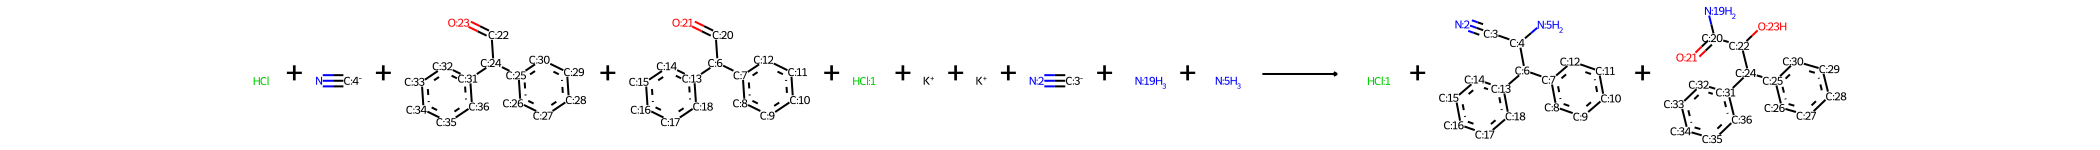

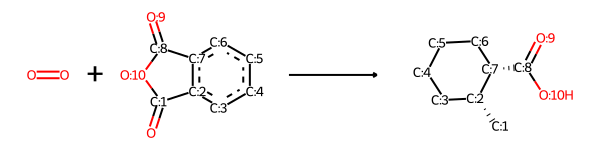

In [55]:
rdChemReactions.ReactionFromSmarts('Cl.N#[C-:4].[CH:22](=[O:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1.[CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)([c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1)[CH:20]=[O:21].[ClH:1].[K+].[K+].[N:2]#[C-:3].[NH3:19].[NH3:5]>>[ClH:1].[N:2]#[C:3][CH:4]([NH2:5])[CH:6]([c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1)[c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1.[NH2:19][C:20](=[O:21])[CH:22]([OH:23])[CH:24]([c:25]1[cH:26][cH:27][cH:28][cH:29][cH:30]1)[c:31]1[cH:32][cH:33][cH:34][cH:35][cH:36]1',useSmiles=True)
rdChemReactions.ReactionFromSmarts('O=O.O=[C:1]1[c:2]2[cH:3][cH:4][cH:5][cH:6][c:7]2[C:8](=[O:9])[O:10]1>>[CH3:1][C@@H:2]1[CH2:3][CH2:4][CH2:5][CH2:6][C@@H:7]1[C:8](=[O:9])[OH:10]',useSmiles=True)

In [167]:
analoguerxnsmappedfilt.xs((140912,0)).msg
analoguerxnsmappedfilt.xs((140912,0)).LHSdata

'Mapper used, Mixture detected for LHS species: 11043468,4371014, Unmapped species instances from LHS: 4371014, With hydrogen carriers: 4371014, RHS species insufficient with species: 11043468,4371014'

{11043468: {'atomdict': {'C': 1, 'N': 1, 'K': 1},
  'charge': 0,
  'smiles': '[C-]#N.[K+]',
  'formula': 'CKN',
  'count': 2,
  'mixture': True},
 1424292: {'atomdict': {'O': 1, 'C': 14, 'H': 12},
  'charge': 0,
  'smiles': 'O=CC(c1ccccc1)c1ccccc1',
  'formula': 'C14H12O',
  'count': 2,
  'mixture': False},
 4371014: {'atomdict': {'Cl': 1, 'N': 1, 'H': 4},
  'charge': 0,
  'smiles': 'Cl.N',
  'formula': 'H4ClN',
  'count': 2,
  'mixture': True}}

In [323]:
# analoguerxnsmappedfilt[:100].apply(checkrxnrow,axis=1,result_type='reduce')
# checkrxnrow(analoguerxnsmappedfilt.loc[38197])
# checkrxnrow(analoguerxnsmappedfilt.loc[analoguerxnsmappedfilt.ReactionID==6682766].iloc[0])

(OrderedDict([(3902968,
               {'atomdict': {'Cl': 2},
                'charge': 0,
                'smiles': 'ClCl',
                'formula': 'Cl2',
                'count': 1,
                'mixture': False,
                'mappedsmiles': ['Cl[Cl:1]'],
                'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f94cce3d9e0>]}),
              (969212,
               {'atomdict': {'C': 6, 'H': 6},
                'charge': 0,
                'smiles': 'c1ccccc1',
                'formula': 'C6H6',
                'count': 1,
                'mixture': False,
                'mappedsmiles': ['[cH:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1'],
                'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f94cce3d900>]})]),
 OrderedDict([(605632,
               {'atomdict': {'Cl': 1, 'C': 6, 'H': 5},
                'charge': 0,
                'smiles': 'Clc1ccccc1',
                'formula': 'C6H5Cl',
                'count': 1,
                'mixture': False,
                'mappedsm

In [205]:
analoguerxnsparsed=checkrxns(analoguerxnsmappedfilt)

2022-02-24 15:28:27,578	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [206]:
analoguerxnsparsed.xs((141964,1)).msg
analoguerxnsparsed.xs((141964,1)).LHSdata
analoguerxnsparsed.loc[(analoguerxnsparsed.msg.str.contains('Hydrogen carriers')) & (analoguerxnsparsed.msg.str.contains('with'))].iloc[5]

'Mapper used, Unmapped species from LHS: 506007, Unmapped species instances from LHS: 143232, RHS species insufficient with species: 2037554,3587310'

{3587310: {'atomdict': {'O': 3, 'N': 1, 'H': 1},
  'charge': 0,
  'smiles': 'O=[N+]([O-])O',
  'formula': 'HNO3',
  'count': 3,
  'mixture': False,
  'mappedsmiles': ['O[N+:16](=[O:17])[O-:18]',
   'O[N+:24](=[O:23])[O-:25]',
   'O[N+:2](=[O:1])[O-:3]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f33521a8db0>,
   <rdkit.Chem.rdchem.Mol at 0x7f33521a8f40>]},
 143232: {'atomdict': {'C': 12, 'O': 1, 'S': 1, 'H': 8},
  'charge': 0,
  'smiles': 'c1ccc2c(c1)Oc1ccccc1S2',
  'formula': 'C12H8OS',
  'count': 2,
  'mixture': False,
  'mappedsmiles': ['S1[c:8]2[c:7]([cH:6][cH:5][cH:4][cH:9]2)[O:22][c:21]2[c:13]1[cH:14][cH:15][cH:19][cH:20]2',
   '[cH:26]1[cH:27][cH:28][c:29]2[c:30]([cH:31]1)[O:41][c:40]1[c:35]([cH:36][cH:37][cH:38][cH:39]1)[S:32]2'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f33521a8f90>,
   <rdkit.Chem.rdchem.Mol at 0x7f33521b1040>]},
 2037554: {'atomdict': {'O': 4, 'S': 1, 'H': 2},
  'charge': 0,
  'smiles': 'O=S(=O)(O)O',
  'formula': 'H2O4S',
  'count': 1,
  'mixture': Fal

NumRefs                                                         7
NumSteps                                                        2
NumStages                                                       1
rxnsmiles0                O=[N+]([O-])c1ccc(Cl)nc1>>COc1ccc(N)cn1
balrxnsmiles      CC(=O)O.O=[N+]([O-])c1ccc(Cl)nc1>>COc1ccc(N)cn1
msg             Mapper used, Unmapped species instances from L...
LHS                                              [506007, 120453]
RHS                                                      [115155]
hcrct                                                          []
hcprod                                                         []
LHSdata         {506007: {'atomdict': {'C': 2, 'O': 2, 'H': 4}...
RHSdata         {115155: {'atomdict': {'C': 6, 'O': 1, 'N': 2,...
mapped_rxn      C[C:1](=O)[OH:2].O=[N+:7]([O-])[c:6]1[cH:5][cH...
confidence                                               0.470619
msg1                                                        Valid
Name: (912

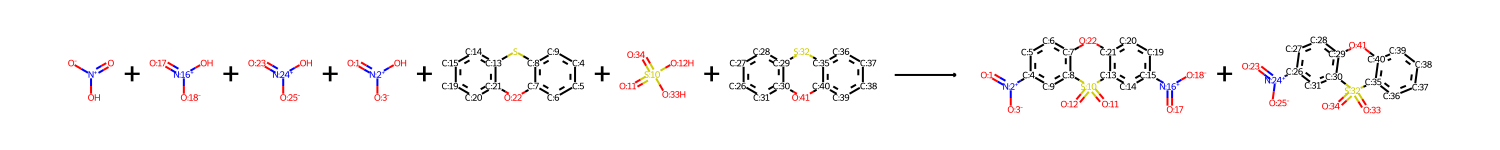

In [207]:
rdChemReactions.ReactionFromSmarts(analoguerxnsparsed.xs((141964,1)).mapped_rxn,useSmiles=True)

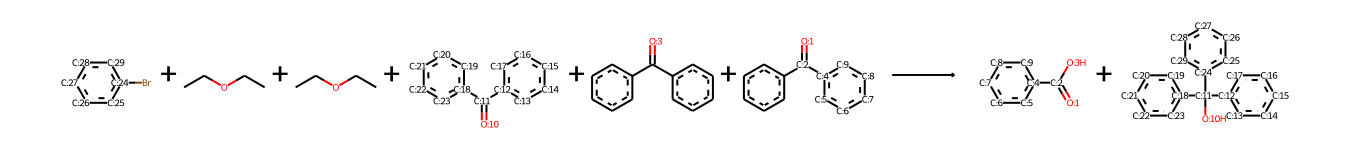

In [73]:
rdChemReactions.ReactionFromSmarts('Br[c:24]1[cH:25][cH:26][cH:27][cH:28][cH:29]1.CCOCC.CCOCC.[O:10]=[C:11]([c:12]1[cH:13][cH:14][cH:15][cH:16][cH:17]1)[c:18]1[cH:19][cH:20][cH:21][cH:22][cH:23]1.c1ccc(C(c2ccccc2)=[O:3])cc1.c1ccc([C:2](=[O:1])[c:4]2[cH:5][cH:6][cH:7][cH:8][cH:9]2)cc1>>[O:1]=[C:2]([OH:3])[c:4]1[cH:5][cH:6][cH:7][cH:8][cH:9]1.[OH:10][C:11]([c:12]1[cH:13][cH:14][cH:15][cH:16][cH:17]1)([c:18]1[cH:19][cH:20][cH:21][cH:22][cH:23]1)[c:24]1[cH:25][cH:26][cH:27][cH:28][cH:29]1',useSmiles=True)

In [168]:
balance_analogue(analoguerxns3.xs((103351,0)))
maprxn(['O=C(OO)c1ccccc1.O=C(c1ccccc1)C1CCCCC1.O=C(c1ccccc1)C1CCCCC1>>O=C(Oc1ccccc1)C1CCCCC1.O=C(OC1CCCCC1)c1ccccc1'])

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


('O=C(OO)c1ccccc1.ClC(Cl)Cl.O=C(c1ccccc1)C1CCCCC1>>O=C(Oc1ccccc1)C1CCCCC1.O=C(OC1CCCCC1)c1ccccc1',
 'O=C(OO)c1ccccc1.O=C(OO)c1ccccc1.O=C(c1ccccc1)C1CCCCC1.O=C(c1ccccc1)C1CCCCC1>>O=C(Oc1ccccc1)C1CCCCC1.O=C(OC1CCCCC1)c1ccccc1',
 'Mapper used, Mandatory species unmapped from LHS: 1731042, RHS species insufficient with species: 1210120,2046712',
 [1210120, 1210120, 2046712, 2046712],
 [1311449, 1873466],
 [],
 [],
 OrderedDict([(1210120,
               {'atomdict': {'O': 3, 'C': 7, 'H': 6},
                'charge': 0,
                'smiles': 'O=C(OO)c1ccccc1',
                'formula': 'C7H6O3',
                'count': 2,
                'mixture': False}),
              (2046712,
               {'atomdict': {'O': 1, 'C': 13, 'H': 16},
                'charge': 0,
                'smiles': 'O=C(c1ccccc1)C1CCCCC1',
                'formula': 'C13H16O',
                'count': 2,
                'mixture': False})]),
 {1311449: {'atomdict': {'O': 2, 'C': 13, 'H': 16},
   'charge': 0,
 

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': '[C:17](=[O:18])([c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1.[O:1]=[C:2]([CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1.c1ccc(C(O[OH:3])=[O:16])cc1>>[O:16]=[C:17]([O:18][c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1.[O:1]=[C:2]([O:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1',
  'confidence': 0.055333589388217586}]

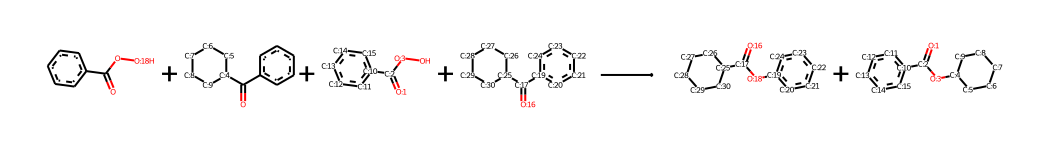

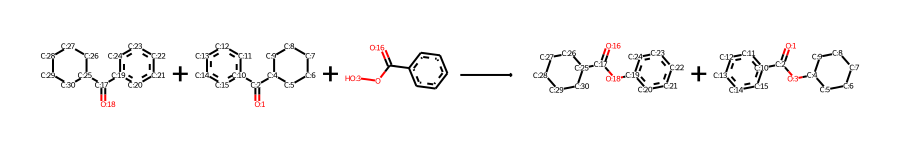

In [154]:
rdChemReactions.ReactionFromSmarts('O=C(O[OH:18])c1ccccc1.O=C(c1ccccc1)[CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1.O[O:3][C:2](=[O:1])[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1.[O:16]=[C:17]([c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1>>[O:16]=[C:17]([O:18][c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1.[O:1]=[C:2]([O:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1',useSmiles=True)
rdChemReactions.ReactionFromSmarts('[C:17](=[O:18])([c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1.[O:1]=[C:2]([CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1.c1ccc(C(O[OH:3])=[O:16])cc1>>[O:16]=[C:17]([O:18][c:19]1[cH:20][cH:21][cH:22][cH:23][cH:24]1)[CH:25]1[CH2:26][CH2:27][CH2:28][CH2:29][CH2:30]1.[O:1]=[C:2]([O:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8][CH2:9]1)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1',useSmiles=True)

In [208]:
analoguerxnsparsed.loc[(analoguerxnsparsed.msg.str.contains('Mandatory'))]
analoguerxnsparsed.loc[(analoguerxnsparsed.msg1.str.contains('Mandatory'))]
analoguerxnsparsed.loc[(analoguerxnsparsed.msg1.str.contains('Mandatory')) & (analoguerxnsparsed.msg.str.contains('Mandatory'))]
analoguerxnsparsed.loc[(analoguerxnsparsed.msg1.str.contains('Unmapped')) & (analoguerxnsparsed.msg.str.contains('Unmapped'))].iloc[0].mapped_rxn

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
ReactionID,Instance,,,,,,,,,,,,,,,
103351,0,1,1,1,O=C(OO)c1ccccc1.ClC(Cl)Cl.O=C(c1ccccc1)C1CCCCC...,O=C(OO)c1ccccc1.O=C(OO)c1ccccc1.O=C(c1ccccc1)C...,"Mapper used, Mandatory species unmapped from L...","[1210120, 1210120, 2046712, 2046712]","[1311449, 1873466]",[],[],"{1210120: {'atomdict': {'O': 3, 'C': 7, 'H': 6...","{1311449: {'atomdict': {'O': 2, 'C': 13, 'H': ...",O=C(O[OH:18])c1ccccc1.O=C(c1ccccc1)[CH:4]1[CH2...,0.024141,Mandatory species unmapped from LHS: 1731042
108356,24,32,1,1,Brc1ccccc1>>Oc1ccccc1,c1ccc(Oc2ccccc2)cc1>>Oc1ccccc1,"Mapper used, Mandatory species unmapped from L...",[1364620],[969616],[],[],"{1364620: {'atomdict': {'C': 12, 'O': 1, 'H': ...","{969616: {'atomdict': {'O': 1, 'C': 6, 'H': 6}...",c1ccc([O:1][c:2]2[cH:3][cH:4][cH:5][cH:6][cH:7...,0.478008,Mandatory species unmapped from LHS: 1236661
112312,0,1,1,1,O=[N+]([O-])c1cc([N+](=O)[O-])cc([N+](=O)[O-])...,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CCC2...,"Mapper used, Mandatory species unmapped from L...","[1915077, 1915077]","[1914275, 2698044]",[],[],"{1915077: {'atomdict': {'C': 18, 'O': 2, 'H': ...","{1914275: {'atomdict': {'C': 18, 'O': 2, 'H': ...",[CH3:1][C@:2]12[CH2:3][CH2:4][C@@H:5]3[c:6]4[c...,0.516838,Mandatory species unmapped from LHS: 1252144
117581,2,1,1,1,O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.Oc1c(Cl)c(C...,ClCl.ClCl.O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.O...,"Mapper used, Mandatory species unmapped from L...","[3902968, 3902968, 2055056, 2055056]","[2136445, 2136662]",[],[],"{3902968: {'atomdict': {'Cl': 2}, 'charge': 0,...","{2136662: {'atomdict': {'O': 1, 'C': 6, 'Cl': ...",[Cl:12][Cl:29].[Cl:5][Cl:15].[O:16]=[C:17]1[C:...,0.003409,Mandatory species unmapped from LHS: 1285380
119793,0,1,1,1,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.ClC(Cl...,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.O=C1CC...,"Mapper used, Mandatory species unmapped from L...","[774044, 130237, 130237, 130237, 130237, 130237]","[58944, 19662]",[],[],"{774044: {'atomdict': {'O': 2, 'C': 3, 'Cl': 2...","{58944: {'atomdict': {'O': 8, 'C': 18, 'Se': 1...",Cl[C:2]([CH2:3][C:4](Cl)=[O:5])=[O:27].[O:1]=[...,0.000044,Mandatory species unmapped from LHS: 969206
120368,0,3,1,1,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1ccc(O)c...,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1cc(CO)c...,"Mapper used, Mandatory species unmapped from L...","[2060433, 2060433]",[2068355],[],[],"{2060433: {'atomdict': {'C': 17, 'O': 4, 'H': ...","{2068355: {'atomdict': {'C': 31, 'O': 4, 'H': ...",OC[c:28]1[cH:27][c:25]([CH3:26])[cH:24][c:23](...,0.433353,Mandatory species unmapped from LHS: 1305151
126664,0,1,1,1,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.c1ccc2c(c1)Cc1cc...,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.COc1ccc(C(=O)c2c...,"Mapper used, Mandatory species unmapped from L...","[1878026, 1878026, 969212]",[2027895],[],[],"{1878026: {'atomdict': {'C': 15, 'O': 3, 'H': ...","{2027895: {'atomdict': {'C': 30, 'O': 6, 'H': ...",[C:17](=[O:18])([c:19]1[cH:20][cH:21][c:22]([O...,0.300688,Mandatory species unmapped from LHS: 133939
126678,5,189,1,1,c1ccc2c(c1)Cc1ccccc1O2>>O=c1c2ccccc2oc2ccccc12,CN(C)C=O.O.O=C([O-])c1cc(Oc2ccccc2C(=O)[O-])cc...,"Mapper used, Mixture detected for LHS species:...",[30970911],[140443],[],[],"{30970911: {'atomdict': {'C': 34, 'N': 3, 'O':...","{140443: {'atomdict': {'O': 2, 'C': 13, 'H': 8...",CN(C)C=O.O.O=C([O-])c1cc(O[c:10]2[cH:11][cH:12...,0.309024,"Mixture detected for LHS species: 30970911, Ma..."
132530,0,1,1,1,c1ccc(Oc2ccccc2)cc1.O=C1c2ccc(Cl)c(C(=O)O)c2-c...,O=C1c2ccc(Cl)c(C(=O)O)c2-c2cccc(Cl)c21.O=C1c2c...,"Mapper used, Mandatory species unmapped from L...","[3365679, 3365679]",[249660],[],[],"{3365679: {'atomdict': {'O': 3, 'C': 14, 'Cl':...","{249660: {'atomdict': {'O': 5, 'C': 14, 'H': 8...",Cl[c:7]1[c:4]([C:2](=[O:1])[OH:3])[c:19]2[c:9]...,0.08794,Mandatory species unmapped from LHS: 1364620


NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87248      19             43         1          1   
           38             43         1          1   
90596      0               2         1          1   
           1               2         1          1   
90684      0               1         1          1   
...                      ...       ...        ...   
139909     0               2         1          1   
139913     0               1         1          1   
140707     0               1         1          1   
142524     0               1         1          1   
142573     0               2         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87248      19                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           38                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
90596      0         CCSc1ccc2ccccc2n1.CCOS(=O)(=O)c1ccc(C)cc1>>CCn...   
           1         CCSc1ccc2ccccc2n1.CCOS(=O)(=O)c1ccc(C)cc1>>CCn...   
90684      0         c1ccc2nc3ccccc3cc2c1.Cc1ccc(S)cc1>>c1ccc2c(c1)...   
...                                                                ...   
139909     0         N#CC(=CC1C(c2ccccc2)C(C=C(C#N)c2ccccc2)C1c1ccc...   
139913     0         Cc1cc2c(c(Br)c1N)C(=O)c1ccccc1C2=O.c1ccc2ccccc...   
140707     0         CC(C)=C(c1ccccc1)c1ccccc1.C=C(C)C(c1ccccc1)c1c...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1>>O=C(O)c1cnccc1Sc...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87248      19        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
           38        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
90596      0         CCSc1ccc2ccccc2n1.CCSc1ccc2ccccc2n1.CCSc1ccc2c...   
           1         CCSc1ccc2ccccc2n1.CCSc1ccc2ccccc2n1.CCSc1ccc2c...   
90684      0         c1ccc2nc3ccccc3cc2c1.c1ccc2nc3ccccc3cc2c1.c1cc...   
...                                                                ...   
139909     0         N#CC(=CC1C(c2ccccc2)C(C=C(C#N)c2ccccc2)C1c1ccc...   
139913     0         Cc1cc2c(c(Br)c1N)C(=O)c1ccccc1C2=O.Cc1cc2c(c(B...   
140707     0         CC(C)=C(c1ccccc1)c1ccccc1.C=C(C)C(c1ccccc1)c1c...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1.O=C=O>>O=C(O)c1cn...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                                msg  \
ReactionID Instance                                                   
87248      19        RHS species insufficient with species: 1868220   
           38        RHS species insufficient with species: 1868220   
90596      0                               RHS species insufficient   
           1                               RHS species insufficient   
90684      0                               RHS species insufficient   
...                                                             ...   
139909     0                               RHS species insufficient   
139913     0                               RHS species insufficient   
140707     0         RHS species insufficient with species: 3535376   
142524     0         RHS species insufficient with species: 1900390   
142573     0                               RHS species insufficient   

                                                          LHS  \
ReactionID Instance                                             
87248      19                               [118515, 1868220]   
           38                               [118515, 1868220]   
90596      0         [120140, 120140, 120140, 120140, 611213]   
           1         [120140, 120140, 120140, 120140, 611213]   
90684      0                 [120200, 120200, 120200, 605761]   
...                       

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
ReactionID,Instance,,,,,,,,,,,,,,,
103351,0,1,1,1,O=C(OO)c1ccccc1.ClC(Cl)Cl.O=C(c1ccccc1)C1CCCCC...,O=C(OO)c1ccccc1.O=C(OO)c1ccccc1.O=C(c1ccccc1)C...,"Mapper used, Mandatory species unmapped from L...","[1210120, 1210120, 2046712, 2046712]","[1311449, 1873466]",[],[],"{1210120: {'atomdict': {'O': 3, 'C': 7, 'H': 6...","{1311449: {'atomdict': {'O': 2, 'C': 13, 'H': ...",O=C(O[OH:18])c1ccccc1.O=C(c1ccccc1)[CH:4]1[CH2...,0.024141,Mandatory species unmapped from LHS: 1731042
108356,24,32,1,1,Brc1ccccc1>>Oc1ccccc1,c1ccc(Oc2ccccc2)cc1>>Oc1ccccc1,"Mapper used, Mandatory species unmapped from L...",[1364620],[969616],[],[],"{1364620: {'atomdict': {'C': 12, 'O': 1, 'H': ...","{969616: {'atomdict': {'O': 1, 'C': 6, 'H': 6}...",c1ccc([O:1][c:2]2[cH:3][cH:4][cH:5][cH:6][cH:7...,0.478008,Mandatory species unmapped from LHS: 1236661
112312,0,1,1,1,O=[N+]([O-])c1cc([N+](=O)[O-])cc([N+](=O)[O-])...,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CCC2...,"Mapper used, Mandatory species unmapped from L...","[1915077, 1915077]","[1914275, 2698044]",[],[],"{1915077: {'atomdict': {'C': 18, 'O': 2, 'H': ...","{1914275: {'atomdict': {'C': 18, 'O': 2, 'H': ...",[CH3:1][C@:2]12[CH2:3][CH2:4][C@@H:5]3[c:6]4[c...,0.516838,Mandatory species unmapped from LHS: 1252144
117581,2,1,1,1,O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.Oc1c(Cl)c(C...,ClCl.ClCl.O=C1C(Cl)=C(Cl)C(Cl)(Cl)C(Cl)=C1Cl.O...,"Mapper used, Mandatory species unmapped from L...","[3902968, 3902968, 2055056, 2055056]","[2136445, 2136662]",[],[],"{3902968: {'atomdict': {'Cl': 2}, 'charge': 0,...","{2136662: {'atomdict': {'O': 1, 'C': 6, 'Cl': ...",[Cl:12][Cl:29].[Cl:5][Cl:15].[O:16]=[C:17]1[C:...,0.003409,Mandatory species unmapped from LHS: 1285380
119793,0,1,1,1,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.ClC(Cl...,O=C(Cl)CC(=O)Cl.O=C1CC(=O)c2ccccc2[Se]1.O=C1CC...,"Mapper used, Mandatory species unmapped from L...","[774044, 130237, 130237, 130237, 130237, 130237]","[58944, 19662]",[],[],"{774044: {'atomdict': {'O': 2, 'C': 3, 'Cl': 2...","{58944: {'atomdict': {'O': 8, 'C': 18, 'Se': 1...",Cl[C:2]([CH2:3][C:4](Cl)=[O:5])=[O:27].[O:1]=[...,0.000044,Mandatory species unmapped from LHS: 969206
120368,0,3,1,1,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1ccc(O)c...,Cc1cc(CO)c(O)c(Cc2cc(C)cc(CO)c2O)c1.Cc1cc(CO)c...,"Mapper used, Mandatory species unmapped from L...","[2060433, 2060433]",[2068355],[],[],"{2060433: {'atomdict': {'C': 17, 'O': 4, 'H': ...","{2068355: {'atomdict': {'C': 31, 'O': 4, 'H': ...",OC[c:28]1[cH:27][c:25]([CH3:26])[cH:24][c:23](...,0.433353,Mandatory species unmapped from LHS: 1305151
126664,0,1,1,1,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.c1ccc2c(c1)Cc1cc...,COc1ccc(C(=O)c2ccc(OC)cc2)cc1.COc1ccc(C(=O)c2c...,"Mapper used, Mandatory species unmapped from L...","[1878026, 1878026, 969212]",[2027895],[],[],"{1878026: {'atomdict': {'C': 15, 'O': 3, 'H': ...","{2027895: {'atomdict': {'C': 30, 'O': 6, 'H': ...",[C:17](=[O:18])([c:19]1[cH:20][cH:21][c:22]([O...,0.300688,Mandatory species unmapped from LHS: 133939
126678,5,189,1,1,c1ccc2c(c1)Cc1ccccc1O2>>O=c1c2ccccc2oc2ccccc12,CN(C)C=O.O.O=C([O-])c1cc(Oc2ccccc2C(=O)[O-])cc...,"Mapper used, Mixture detected for LHS species:...",[30970911],[140443],[],[],"{30970911: {'atomdict': {'C': 34, 'N': 3, 'O':...","{140443: {'atomdict': {'O': 2, 'C': 13, 'H': 8...",CN(C)C=O.O.O=C([O-])c1cc(O[c:10]2[cH:11][cH:12...,0.309024,"Mixture detected for LHS species: 30970911, Ma..."
132530,0,1,1,1,c1ccc(Oc2ccccc2)cc1.O=C1c2ccc(Cl)c(C(=O)O)c2-c...,O=C1c2ccc(Cl)c(C(=O)O)c2-c2cccc(Cl)c21.O=C1c2c...,"Mapper used, Mandatory species unmapped from L...","[3365679, 3365679]",[249660],[],[],"{3365679: {'atomdict': {'O': 3, 'C': 14, 'Cl':...","{249660: {'atomdict': {'O': 5, 'C': 14, 'H': 8...",Cl[c:7]1[c:4]([C:2](=[O:1])[OH:3])[c:19]2[c:9]...,0.08794,Mandatory species unmapped from LHS: 1364620


'O=C1OC(=O)c2ccccc21.O=[C:23]1[O:22][C:21](=[O:20])[c:44]2[c:39]1[cH:40][cH:41][cH:42][cH:43]2.O[c:30]1[cH:24][cH:25][cH:26][c:27]([OH:28])[cH:29]1.[O:1]=[C:2]1[O:3][C:10](=[O:11])[c:9]2[c:4]1[cH:5][cH:6][cH:7][cH:8]2.[OH:31][c:32]1[cH:33][c:34]([OH:35])[cH:36][cH:37][cH:38]1.[cH:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][c:18]1[OH:19]>>[O:1]=[C:2]([OH:3])[c:4]1[cH:5][cH:6][cH:7][cH:8][c:9]1[C:10](=[O:11])[c:12]1[cH:13][cH:14][c:15]([OH:16])[cH:17][c:18]1[OH:19].[O:20]=[C:21]1[O:22][C:23]2([c:24]3[cH:25][cH:26][c:27]([OH:28])[cH:29][c:30]3[O:31][c:32]3[cH:33][c:34]([OH:35])[cH:36][cH:37][c:38]32)[c:39]2[cH:40][cH:41][cH:42][cH:43][c:44]21'

In [65]:
analoguerxnsparsed.loc[(analoguerxnsparsed.msg.str.contains('With hydrogen carriers',case=False,na=False)) & (analoguerxnsparsed.msg1.str.contains('unmapped',case=False))]
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('unmapped',case=False)]

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
ReactionID,Instance,,,,,,,,,,,,,,,


NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87160      0               2         1          1   
           1               2         1          1   
87248      19             43         1          1   
           38             43         1          1   
87295      1               1         2          1   
...                      ...       ...        ...   
141973     0               1         1          1   
141980     0               1         1          1   
142394     1               2         2          1   
142524     0               1         1          1   
142573     0               2         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87160      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
           1         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87248      19                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           38                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
87295      1            O=C1OC(=O)c2ccccc21>>C[C@@H]1CCCC[C@@H]1C(=O)O   
...                                                                ...   
141973     0         c1ccc2c(c1)Nc1ccccc1O2.COc1ccc(C(=O)c2ccc(OC)c...   
141980     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1ccc2ccccc2o1>>[O-][...   
142394     1         Nc1cccc2c1oc1ccccc12>>O=C1Nc2c(ccc3c2oc2ccccc2...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1>>O=C(O)c1cnccc1Sc...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87160      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
           1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
87248      19        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
           38        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
87295      1         O=C1OC(=O)c2ccccc21.O=O>>C[C@@H]1CCCC[C@@H]1C(...   
...                                                                ...   
141973     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.COc1...   
141980     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
142394     1         Nc1cccc2c1oc1ccccc12.Nc1cccc2c1oc1ccccc12.O=S(...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1.O=C=O>>O=C(O)c1cn...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                                   msg  \
ReactionID Instance                                                      
87160      0         Mapper used, Unmapped species instances from L...   
           1         Mapper used, Unmapped species instances from L...   
87248      19           RHS species insufficient with species: 1868220   
           38           RHS species insufficient with species: 1868220   
87295      1         Hydrogen carriers: 118515,506007 with species:...   
...                                                                ...   
141973     0         Mapper used, Unmapped species instances from L...   
141980     0         Mapper used, Unmapped species instances from L...   
142394     1         Mapper used, Unmapped species from LHS: 353976...   
142524     0            RHS species insufficient with species: 1900390   
142573     0                                  RHS species insufficient   

                                                                   LHS  \
ReactionID Instance                                                      
87160      0          [118515, 118515, 118515, 906905, 906905, 906905]   
           1          [118515, 118515, 118515, 906905, 906905, 906905]   
87248      19                                        [118515, 1868220]   
           38                                        [118515, 1868220]  

In [210]:
pd.to_pickle(analoguerxnsparsed,dpdir+'analoguerxnsparsed.pickle')

In [99]:
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('Valid',case=False,na=False)]
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('mixture',case=False,na=False)]
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('unmapped',case=False,na=False)]
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('instances',case=False,na=False)]
analoguerxnsparsed.loc[analoguerxnsparsed.msg1.str.contains('discrepancy',case=False,na=False)]
# analoguerxnsparsed.loc[~(analoguerxnsparsed.msg1.str.contains('Valid',case=False,na=False)) & ~(analoguerxnsparsed.msg1.str.contains('mixture',case=False,na=False)) & ~(analoguerxnsparsed.msg1.str.contains('unmapped',case=False,na=False)) & ~(analoguerxnsparsed.msg1.str.contains('discrepancy',case=False,na=False))]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87107      3              17         1          1   
           5              17         1          2   
           6              17         1          1   
           7              17         1          2   
           8              17         1          1   
...                      ...       ...        ...   
142732     0               1         1          1   
142739     0               1         1          1   
142741     0               1         1          1   
142746     0               3         1          1   
           1               3         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142732     0                   COc1cccc2c(C)ncnc12>>Cc1ncnc2c(O)cccc12   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   
           1         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142732     0                   COc1cccc2c(C)ncnc12>>Cc1ncnc2c(O)cccc12   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   
           1         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   

                                                                   msg  \
ReactionID Instance                                                      
87107      3                                          Already balanced   
           5                                          Already balanced   
           6                                          Already balanced   
           7                                          Already balanced   
           8                                          Already balanced   
...                                                                ...   
142732     0                                  RHS species insufficient   
142739     0                        Balanced with help product(s): HCl   
142741     0                        Balanced with help product(s): HCl   
142746     0         Mapper used, Unmapped species from LHS: 103233...   
           1             RHS species insufficient with species: 143877   

                                  LHS        RHS hcrct hcprod  \
ReactionID Instance                                             
87107      3         [118515, 774631]  [3368113]    []     []   
           5         [118515, 774631]  [3368113]    []     []   
           6         [118515, 774631]  [3368113]    []     []   
           7         [118515, 774631]  [3368113]    []     []   
           8         [118515, 774631]  [3368113]    

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87157      0               1         1          1   
87247      0              10         1          1   
           1              10         1          1   
           2              10         1          1   
           3              10         1          1   
...                      ...       ...        ...   
142685     0               2         1          1   
           1               2         1          1   
           2               2         2          1   
142736     0               1         1          1   
142744     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87157      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87247      0                  O=C1OC(=O)c2ccccc21>>O=C1SC(=O)c2ccccc21   
           1                  O=C1OC(=O)c2ccccc21>>O=C1SC(=O)c2ccccc21   
           2                  O=C1OC(=O)c2ccccc21>>O=C1SC(=O)c2ccccc21   
           3                  O=C1OC(=O)c2ccccc21>>O=C1SC(=O)c2ccccc21   
...                                                                ...   
142685     0         c1ccc2c(c1)Nc1ccccc1N2>>c1ccc2c(c1)Nc1ccccc1N2...   
           1         c1ccc2c(c1)Nc1ccccc1N2>>c1ccc2c(c1)Nc1ccccc1N2...   
           2         c1ccc2c(c1)Nc1ccccc1N2>>c1ccc2c(c1)Nc1ccccc1N2...   
142736     0         ICc1ccccc1.CCn1cc(-c2ccccc2)nn1>>CCn1cc(-c2ccc...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12>>Cc1ccc2c(c1)nc(O)c...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87157      0         O=C1OC(=O)c2ccccc21.Oc1cccc(O)c1.Oc1cccc(O)c1....   
87247      0         O=C1OC(=O)c2ccccc21.S.[H]O[H].[NaH].[NaH]>>O=C...   
           1         O=C1OC(=O)c2ccccc21.S.[NaH].[NaH]>>O=C1SC(=O)c...   
           2         O=C1OC(=O)c2ccccc21.S.[H]O[H].[NaH].[NaH]>>O=C...   
           3         O=C1OC(=O)c2ccccc21.S.[NaH].[NaH]>>O=C1SC(=O)c...   
...                                                                ...   
142685     0         c1ccc2c(c1)Nc1ccccc1N2.c1ccc2c(c1)Nc1ccccc1N2>...   
           1         c1ccc2c(c1)Nc1ccccc1N2.c1ccc2c(c1)Nc1ccccc1N2>...   
           2         c1ccc2c(c1)Nc1ccccc1N2.c1ccc2c(c1)Nc1ccccc1N2>...   
142736     0         ICc1ccccc1.CCn1cc(-c2ccccc2)nn1>>CCn1cc(-c2ccc...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12.O=[Cr](=O)([O-])O[C...   

                                                                   msg  \
ReactionID Instance                                                      
87157      0         Mapper used, Balanced with species: 2037554 wi...   
87247      0           RHS species insufficient with species: 16494176   
           1           RHS species insufficient with species: 11323291   
           2           RHS species insufficient with species: 16494176   
           3           RHS species insufficient with species: 11323291   
...                                                                ...   
142685     0                         Balanced with help product(s): H2   
           1                         Balanced with help product(s): H2   
           2         Mapper used, Unmapped species from LHS: 358721...   
142736     0                                          Already balanced   
142744     0         Mapper used, Mixture detected for LHS species:...   

                                                   LHS        RHS hcrct  \
ReactionID Instance                                                       
87157      0         [118515, 906905, 906905, 2037554]  [3844345]    []   
87247      0                        [118515, 16494176]   [118516]    []   
           1                        [118515, 11323291]   [118516]    []   
           2                        [118515, 16494176]   [118516]  

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87160      0               2         1          1   
           1               2         1          1   
87239      1               2         1          1   
87240      0               3         1          1   
87244      1              34         1          1   
...                      ...       ...        ...   
142540     0               1         1          1   
142573     0               2         1          1   
142695     0               1         1          1   
142711     0               1         1          1   
142723     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87160      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
           1         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87239      1                      O=C1OC(=O)c2ccccc21>>Cc1ccccc1C(=O)O   
87240      0                      O=C1OC(=O)c2ccccc21>>c1ccc2c(c1)COC2   
87244      1                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
...                                                                ...   
142540     0               CC(=O)c1nc2ccccc2nc1C>>CC(O)C1Nc2ccccc2NC1C   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   
142695     0            CCCCCCC(=O)c1cc(CC)sc1CC>>CCCCCCCc1cc(CC)sc1CC   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3>>Cc1ccc2c(c1)NC1CCCCC...   
142723     0              Cc1cc(Cl)nc2c(Cl)cccc12>>Cc1ccnc2c(Cl)cccc12   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87160      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
           1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
87239      1           O=C1OC(=O)c2ccccc21.S.S.S.[Mo]>>Cc1ccccc1C(=O)O   
87240      0         O=C1OC(=O)c2ccccc21.[AlH4-].[Li+]>>c1ccc2c(c1)...   
87244      1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21>>O=C1O...   
...                                                                ...   
142540     0           CC(=O)c1nc2ccccc2nc1C.CCO>>CC(O)C1Nc2ccccc2NC1C   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   
142695     0         CCCCCCC(=O)c1cc(CC)sc1CC.NN>>CCCCCCCc1cc(CC)sc1CC   
142711     0         Cc1ccc2nc3c(nc2c1)CCCCC3.CO>>Cc1ccc2c(c1)NC1CC...   
142723     0           Cc1cc(Cl)nc2c(Cl)cccc12.Cl>>Cc1ccnc2c(Cl)cccc12   

                                                                   msg  \
ReactionID Instance                                                      
87160      0         Mapper used, Unmapped species instances from L...   
           1         Mapper used, Unmapped species instances from L...   
87239      1           RHS species insufficient with species: 14327304   
87240      0           RHS species insufficient with species: 11460447   
87244      1             RHS species insufficient with species: 118515   
...                                                                ...   
142540     0            RHS species insufficient with species: 1718733   
142573     0                                  RHS species insufficient   
142695     0             RHS species insufficient with species: 878137   
142711     0            RHS species insufficient with species: 1098229   
142723     0            RHS species insufficient with species: 1098214   

                                                                  LHS  \
ReactionID Instance                                                     
87160      0         [118515, 118515, 118515, 906905, 906905, 906905]   
           1         [118515, 118515, 118515, 906905, 906905, 906905]   
87239      1                                       [118515, 14327304]   
87240      0                                       [118515, 11460447]   
8724

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87160      0               2         1          1   
           1               2         1          1   
87244      1              34         1          1   
           6              34         1          1   
87325      1               4         1          1   
...                      ...       ...        ...   
141971     0               1         1          1   
141973     0               1         1          1   
141980     0               1         1          1   
142306     0               1         1          1   
142450     0               1         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87160      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
           1         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87244      1                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
           6                      O=C1OC(=O)c2ccccc21>>O=C1OCc2ccccc21   
87325      1                             O=C1OC(=O)c2ccccc21>>c1ccccc1   
...                                                                ...   
141971     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1cc(-c2ccccc2)oc2ccc...   
141973     0         c1ccc2c(c1)Nc1ccccc1O2.COc1ccc(C(=O)c2ccc(OC)c...   
141980     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1ccc2ccccc2o1>>[O-][...   
142306     0               Brc1cnc(C(Br)(Br)Br)nc1>>O=C(O)c1ncc(Br)cn1   
142450     0         CCC1(C)CC(=O)C(Cc2ccccc2)O1>>CCC1(C)CC(O)C(Cc2...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87160      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
           1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
87244      1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21>>O=C1O...   
           6         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21>>O=C1O...   
87325      1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21>>c1ccccc1   
...                                                                ...   
141971     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
141973     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.COc1...   
141980     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
142306     0         Brc1cnc(C(Br)(Br)Br)nc1.Brc1cnc(C(Br)(Br)Br)nc...   
142450     0         CCC1(C)CC(=O)C(Cc2ccccc2)O1.CCC1(C)CC(=O)C(Cc2...   

                                                                   msg  \
ReactionID Instance                                                      
87160      0         Mapper used, Unmapped species instances from L...   
           1         Mapper used, Unmapped species instances from L...   
87244      1             RHS species insufficient with species: 118515   
           6             RHS species insufficient with species: 118515   
87325      1             RHS species insufficient with species: 118515   
...                                                                ...   
141971     0         Mapper used, Unmapped species instances from L...   
141973     0         Mapper used, Unmapped species instances from L...   
141980     0         Mapper used, Unmapped species instances from L...   
142306     0         Mapper used, Mixture detected for LHS species:...   
142450     0             RHS species insufficient with species: 143472   

                                                                   LHS  \
ReactionID Instance                                                      
87160      0          [118515, 118515, 118515, 906905, 906905, 906905]   
           1          [118515, 118515, 118515, 906905, 906905, 906905]   
87244      1                                          [118515, 118515]   
           6                                          [118515, 118515]  

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
88657      2               6         1          1   
89961      0               1         1          1   
90222      1               2         1          1   
90722      3               7         1          1   
           4               7         1          1   
...                      ...       ...        ...   
141922     1               4         1          1   
142492     9              78         1          1   
           47             78         1          1   
           67             78         1          1   
           70             78         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
88657      2                Cc1ccc2cccc(Cl)c2n1>>O=Cc1ccc2cccc(Cl)c2n1   
89961      0          CC(C)c1cncc(C(C)C)c1>>CC(C)(O)c1cncc(C(C)(C)O)c1   
90222      1                O=C(O)c1ccc(=O)oc1>>O=C(O)c1coc(=O)c(Br)c1   
90722      3          c1ccc2nc3ccccc3cc2c1>>Brc1ccc2nc3ccc(Br)cc3cc2c1   
           4          c1ccc2nc3ccccc3cc2c1>>Brc1ccc2nc3ccc(Br)cc3cc2c1   
...                                                                ...   
141922     1         c1ccc2c(c1)Oc1ccccc1O2>>O=[N+]([O-])c1ccc2c(c1...   
142492     9          CC(=O)c1cc2ccccc2oc1=O>>O=C(CBr)c1cc2ccccc2oc1=O   
           47         CC(=O)c1cc2ccccc2oc1=O>>O=C(CBr)c1cc2ccccc2oc1=O   
           67         CC(=O)c1cc2ccccc2oc1=O>>O=C(CBr)c1cc2ccccc2oc1=O   
           70         CC(=O)c1cc2ccccc2oc1=O>>O=C(CBr)c1cc2ccccc2oc1=O   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
88657      2         Cc1ccc2cccc(Cl)c2n1.[Fe+3].[O][N+](=O)[O-]>>O=...   
89961      0         CC(C)c1cncc(C(C)C)c1.[O][Mn](=O)(=O)=O>>CC(C)(...   
90222      1         O=C(O)c1ccc(=O)oc1.Br[Br]Br.[H+].c1ccncc1>>O=C...   
90722      3         c1ccc2nc3ccccc3cc2c1.Br[Br]Br.C[N+](C)(C)Cc1cc...   
           4         c1ccc2nc3ccccc3cc2c1.Br[Br]Br.CC[N+](CC)(CC)Cc...   
...                                                                ...   
141922     1         c1ccc2c(c1)Oc1ccccc1O2.[O][N+](=O)[O-]>>O=[N+]...   
142492     9         CC(=O)c1cc2ccccc2oc1=O.Br[Br]Br.CCCC[N+](CCCC)...   
           47        CC(=O)c1cc2ccccc2oc1=O.Br[Br]Br.CCCC[N+](CCCC)...   
           67        CC(=O)c1cc2ccccc2oc1=O.Br[Br]Br.CCCC[N+](CCCC)...   
           70        CC(=O)c1cc2ccccc2oc1=O.Br[Br]Br.CCCC[N+](CCCC)...   

                                                                   msg  \
ReactionID Instance                                                      
88657      2         Charge imbalance, RHS species insufficient wit...   
89961      0            RHS species insufficient with species: 3903871   
90222      1         Charge imbalance, RHS species insufficient wit...   
90722      3         Charge imbalance, RHS species insufficient wit...   
           4         Charge imbalance, RHS species insufficient wit...   
...                                                                ...   
141922     1            RHS species insufficient with species: 6367539   
142492     9         Charge imbalance, RHS species insufficient wit...   
           47        Charge imbalance, RHS species insufficient wit...   
           67        Charge imbalance, RHS species insufficient wit...   
           70        Charge imbalance, RHS species insufficient wit...   

                                   LHS       RHS hcrct hcprod  \
ReactionID Instance                                             
88657      2         [119193, 5122836]  [127520]    []     []   
89961      0         [119547, 3903871]  [140605]    []     []   
90222      1         [119747, 5362527]  [139439]    []     []   
90722      3         [120200, 6993128]  [166552]    []     []   
           4         [120200, 7402545]  [166552]    

In [123]:
analoguerxns3.dtypes

ReactantID    object
ProductID     object
NumRefs        int64
NumSteps       int64
NumStages      int64
ReagentID     object
SolventID     object
Rdata         object
Pdata         object
Rgtdata       object
Solvdata      object
hc_prod       object
hc_react      object
dtype: object

In [212]:
analoguerxnsparsedfilt=analoguerxnsparsed.loc[~analoguerxnsparsed.msg1.str.contains('discrepancy',case=False,na=False)]

In [213]:
analoguerxnsparsedfilt

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87107      3              17         1          1   
           5              17         1          2   
           6              17         1          1   
           7              17         1          2   
           8              17         1          1   
...                      ...       ...        ...   
142739     0               1         1          1   
142741     0               1         1          1   
142744     0               1         1          1   
142746     0               3         1          1   
           1               3         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12>>Cc1ccc2c(c1)nc(O)c...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   
           1         C/C(=N\N)c1c[nH]c2ccccc12>>C/C(=N\N=C(/C)c1c[n...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87107      3         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           5         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           6         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           7         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
           8         O=C1OC(=O)c2ccccc21.CN(C)c1cccc(O)c1>>CN(C)c1c...   
...                                                                ...   
142739     0         Cc1cc(Cl)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142741     0         Cc1cc(Br)c(N)c2cccnc12.O=C(Cl)c1ccccc1>>Cc1cc(...   
142744     0         Cc1ccc2c(c1)nc(C)c1ccccc12.O=[Cr](=O)([O-])O[C...   
142746     0         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   
           1         C/C(=N\N)c1c[nH]c2ccccc12.C/C(=N\N)c1c[nH]c2cc...   

                                                                   msg  \
ReactionID Instance                                                      
87107      3                                          Already balanced   
           5                                          Already balanced   
           6                                          Already balanced   
           7                                          Already balanced   
           8                                          Already balanced   
...                                                                ...   
142739     0                        Balanced with help product(s): HCl   
142741     0                        Balanced with help product(s): HCl   
142744     0         Mapper used, Mixture detected for LHS species:...   
142746     0         Mapper used, Unmapped species from LHS: 103233...   
           1             RHS species insufficient with species: 143877   

                                    LHS        RHS hcrct hcprod  \
ReactionID Instance                                               
87107      3           [118515, 774631]  [3368113]    []     []   
           5           [118515, 774631]  [3368113]    []     []   
           6           [118515, 774631]  [3368113]    []     []   
           7           [118515, 774631]  [3368113]    []     []   
           8           [118515, 774631] 

In [225]:
analoguerxnsparsedfilt.loc[(analoguerxnsparsedfilt.msg1.str.contains('unmapped')) | (analoguerxnsparsedfilt.msg1.str.contains('Unmapped'))]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87160      0               2         1          1   
           1               2         1          1   
87248      19             43         1          1   
           38             43         1          1   
87295      1               1         2          1   
...                      ...       ...        ...   
141973     0               1         1          1   
141980     0               1         1          1   
142394     1               2         2          1   
142524     0               1         1          1   
142573     0               2         1          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87160      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
           1         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87248      19                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
           38                 O=C1OC(=O)c2ccccc21>>O=C1NC(=O)c2ccccc21   
87295      1            O=C1OC(=O)c2ccccc21>>C[C@@H]1CCCC[C@@H]1C(=O)O   
...                                                                ...   
141973     0         c1ccc2c(c1)Nc1ccccc1O2.COc1ccc(C(=O)c2ccc(OC)c...   
141980     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1ccc2ccccc2o1>>[O-][...   
142394     1         Nc1cccc2c1oc1ccccc12>>O=C1Nc2c(ccc3c2oc2ccccc2...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1>>O=C(O)c1cnccc1Sc...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87160      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
           1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
87248      19        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
           38        O=C1OC(=O)c2ccccc21.NC(=O)c1ccccc1C(N)=O>>O=C1...   
87295      1         O=C1OC(=O)c2ccccc21.O=O>>C[C@@H]1CCCC[C@@H]1C(...   
...                                                                ...   
141973     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.COc1...   
141980     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
142394     1         Nc1cccc2c1oc1ccccc12.Nc1cccc2c1oc1ccccc12.O=S(...   
142524     0         Cc1ccccc1.Ic1cnccc1Sc1ccccc1.O=C=O>>O=C(O)c1cn...   
142573     0         O=C(Cl)c1ccccc1Cl.CN(C)c1ccccc1.O=C1c2ccccc2CN...   

                                                                   msg  \
ReactionID Instance                                                      
87160      0         Mapper used, Unmapped species instances from L...   
           1         Mapper used, Unmapped species instances from L...   
87248      19           RHS species insufficient with species: 1868220   
           38           RHS species insufficient with species: 1868220   
87295      1         Hydrogen carriers: 118515,506007 with species:...   
...                                                                ...   
141973     0         Mapper used, Unmapped species instances from L...   
141980     0         Mapper used, Unmapped species instances from L...   
142394     1         Mapper used, Unmapped species from LHS: 353976...   
142524     0            RHS species insufficient with species: 1900390   
142573     0                                  RHS species insufficient   

                                                                   LHS  \
ReactionID Instance                                                      
87160      0          [118515, 118515, 118515, 906905, 906905, 906905]   
           1          [118515, 118515, 118515, 906905, 906905, 906905]   
87248      19                                        [118515, 1868220]   
           38                                        [118515, 1868220]  

In [222]:
# Updating balanced and mapped reactions

changedrxns=analoguerxnsparsedfilt.loc[analoguerxnsparsedfilt.msg1.str.contains('Unmapped')]
changedrxns

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
87160      0               2         1          1   
           1               2         1          1   
87295      1               1         2          1   
87929      0               1         1          1   
88143      0               1         1          1   
...                      ...       ...        ...   
141964     1               2         1          1   
141971     0               1         1          1   
141973     0               1         1          1   
141980     0               1         1          1   
142394     1               2         2          1   

                                                            rxnsmiles0  \
ReactionID Instance                                                      
87160      0         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
           1         Oc1cccc(O)c1.O=C1OC(=O)c2ccccc21>>O=C1OC2(c3cc...   
87295      1            O=C1OC(=O)c2ccccc21>>C[C@@H]1CCCC[C@@H]1C(=O)O   
87929      0         Cc1cnccc1[N+](=O)[O-]>>O=C(O)c1cnccc1[N+](=O)[O-]   
88143      0              O=C1CSCCc2ccccc21>>O=C1CS(=O)(=O)CCc2ccccc21   
...                                                                ...   
141964     1         c1ccc2c(c1)Oc1ccccc1S2>>O=[N+]([O-])c1ccc2c(c1...   
141971     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1cc(-c2ccccc2)oc2ccc...   
141973     0         c1ccc2c(c1)Nc1ccccc1O2.COc1ccc(C(=O)c2ccc(OC)c...   
141980     0         c1ccc2c(c1)Nc1ccccc1O2.O=c1ccc2ccccc2o1>>[O-][...   
142394     1         Nc1cccc2c1oc1ccccc12>>O=C1Nc2c(ccc3c2oc2ccccc2...   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
87160      0         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
           1         O=C1OC(=O)c2ccccc21.O=C1OC(=O)c2ccccc21.O=C1OC...   
87295      1         O=C1OC(=O)c2ccccc21.O=O>>C[C@@H]1CCCC[C@@H]1C(...   
87929      0         O=[Mn](=O)(=O)[O-].[K+].Cc1cnccc1[N+](=O)[O-]....   
88143      0         OO.O=C1CSCCc2ccccc21.O=C1CSCCc2ccccc21>>O=C1CS...   
...                                                                ...   
141964     1         O=S(=O)(O)O.O=[N+]([O-])O.O=[N+]([O-])O.O=[N+]...   
141971     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
141973     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.COc1...   
141980     0         O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=P(Cl)(Cl)Cl.O=c1...   
142394     1         Nc1cccc2c1oc1ccccc12.Nc1cccc2c1oc1ccccc12.O=S(...   

                                                                   msg  \
ReactionID Instance                                                      
87160      0         Mapper used, Unmapped species instances from L...   
           1         Mapper used, Unmapped species instances from L...   
87295      1         Hydrogen carriers: 118515,506007 with species:...   
87929      0         Mapper used, Mixture detected for LHS species:...   
88143      0         Mapper used, Unmapped species instances from L...   
...                                                                ...   
141964     1         Mapper used, Unmapped species from LHS: 506007...   
141971     0         Mapper used, Unmapped species instances from L...   
141973     0         Mapper used, Unmapped species instances from L...   
141980     0         Mapper used, Unmapped species instances from L...   
142394     1         Mapper used, Unmapped species from LHS: 353976...   

                                                                   LHS  \
ReactionID Instance                                                      
87160      0          [118515, 118515, 118515, 906905, 906905, 906905]   
           1          [118515, 118515, 118515, 906905, 906905, 906905]   
87295      1                                         [118515, 3587218]   
87929      0                               [11343348, 118797, 3587155]  

In [114]:
# changedrxns[1920:1922].apply(updaterxns_,axis=1,result_type='reduce')
updaterxns_(changedrxns.iloc[1920])
# updaterxns(changedrxns[1500:2000],ncpus=16)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


('O=[N+:27]([O-])[c:26]1[c:3]([O:2][CH3:1])[cH:4][cH:5][c:6]([CH2:7][n:8]2[cH:9][c:10](-[c:11]3[cH:12][c:13]([O:14][CH3:15])[c:16]([O:17][CH3:18])[c:19]([O:20][CH3:21])[cH:22]3)[n:23][n:24]2)[cH:25]1>>[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([CH2:7][n:8]2[cH:9][c:10](-[c:11]3[cH:12][c:13]([O:14][CH3:15])[c:16]([O:17][CH3:18])[c:19]([O:20][CH3:21])[cH:22]3)[n:23][n:24]2)[cH:25][c:26]1[NH2:27]',
 0.8898334287411993,
 'COc1ccc(Cn2cc(-c3cc(OC)c(OC)c(OC)c3)nn2)cc1[N+](=O)[O-]>>COc1ccc(Cn2cc(-c3cc(OC)c(OC)c(OC)c3)nn2)cc1N',
 'Hydrogen carriers: 20688282',
 [20688282],
 [20688269],
 [],
 [],
 OrderedDict([(20688282,
               {'atomdict': {'C': 19, 'O': 6, 'N': 4, 'H': 20},
                'charge': 0,
                'smiles': 'COc1ccc(Cn2cc(-c3cc(OC)c(OC)c(OC)c3)nn2)cc1[N+](=O)[O-]',
                'formula': 'C19H20N4O6',
                'count': 1,
                'mixture': False,
                'mappedsmiles': ['O=[N+:27]([O-])[c:26]1[c:3]([O:2][CH3:1])[cH:4][cH:5][c:6]([CH2:7][n:8]2[

In [128]:
changedrxns[1025:1030]
changedrxns.iloc[1025]
changedrxns.iloc[1920]

NumRefs  NumSteps  NumStages  \
ReactionID Instance                                 
110426     22             41         1          1   
           30             41         1          1   
           33             41         1          1   
           36             41         1          1   
           38             41         1          1   

                                                          rxnsmiles0  \
ReactionID Instance                                                    
110426     22        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1   
           30        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1   
           33        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1   
           36        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1   
           38        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1   

                                                          balrxnsmiles  \
ReactionID Instance                                                      
110426     22        O=Cc1ccc(OCc2ccccc2)cc1.[BH4-].[Na+]>>OCc1ccc(...   
           30        O=Cc1ccc(OCc2ccccc2)cc1.[BH4-].[K+]>>OCc1ccc(O...   
           33        O=Cc1ccc(OCc2ccccc2)cc1.[BH4-].[Na+]>>OCc1ccc(...   
           36        O=Cc1ccc(OCc2ccccc2)cc1.[AlH4-].[Li+]>>OCc1ccc...   
           38        O=Cc1ccc(OCc2ccccc2)cc1.C=O>>OCc1ccc(OCc2ccccc...   

                                                                 msg  \
ReactionID Instance                                                    
110426     22        RHS species insufficient with species: 11343078   
           30        RHS species insufficient with species: 13204030   
           33        RHS species insufficient with species: 11343078   
           36        RHS species insufficient with species: 11460447   
           38         RHS species insufficient with species: 1209228   

                                     LHS        RHS hcrct hcprod  \
ReactionID Instance                                                
110426     22        [1242385, 11343078]  [1877819]    []     []   
           30        [1242385, 13204030]  [1877819]    []     []   
           33        [1242385, 11343078]  [1877819]    []     []   
           36        [1242385, 11460447]  [1877819]    []     []   
           38         [1242385, 1209228]  [1877819]    []     []   

                                                               LHSdata  \
ReactionID Instance                                                      
110426     22        {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           30        {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           33        {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           36        {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           38        {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...   

                                                               RHSdata  \
ReactionID Instance                                                      
110426     22        {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           30        {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           33        {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           36        {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...   
           38        {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...   

                                                            mapped_rxn  \
ReactionID Instance                                                      
110426     22        [BH4-].[Na+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:...   
           30        [BH4-].[K+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:6...   
           33        [BH4-].[Na+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:...   
           36        [AlH4-].[Li+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c...   
           38        C=O.[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:6]([O:7][...   

                    confidence                                 msg1  
ReactionID Insta

NumRefs                                                        41
NumSteps                                                        1
NumStages                                                       1
rxnsmiles0        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1
balrxnsmiles    O=Cc1ccc(OCc2ccccc2)cc1.[BH4-].[Na+]>>OCc1ccc(...
msg               RHS species insufficient with species: 11343078
LHS                                           [1242385, 11343078]
RHS                                                     [1877819]
hcrct                                                          []
hcprod                                                         []
LHSdata         {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...
RHSdata         {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...
mapped_rxn      [BH4-].[Na+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:...
confidence                                               0.889027
msg1                          Unmapped species from LHS: 11343078
Name: (110

NumRefs                                                        33
NumSteps                                                        1
NumStages                                                       1
rxnsmiles0                     O=C1COc2ccccc2N1>>c1ccc2c(c1)NCCO2
balrxnsmiles                 O=C1COc2ccccc2N1.B>>c1ccc2c(c1)NCCO2
msg                RHS species insufficient with species: 3535005
LHS                                             [131133, 3535005]
RHS                                                        [3918]
hcrct                                                          []
hcprod                                                         []
LHSdata         {131133: {'atomdict': {'O': 2, 'C': 8, 'N': 1,...
RHSdata         {3918: {'atomdict': {'C': 8, 'N': 1, 'O': 1, '...
mapped_rxn      B.O=[C:8]1[NH:7][c:5]2[c:4]([cH:3][cH:2][cH:1]...
confidence                                               0.949273
msg1                           Unmapped species from LHS: 3535005
Name: (121

In [121]:
changedrxns.iloc[1027]

NumRefs                                                        41
NumSteps                                                        1
NumStages                                                       1
rxnsmiles0        O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1
balrxnsmiles    O=Cc1ccc(OCc2ccccc2)cc1.[BH4-].[Na+]>>OCc1ccc(...
msg               RHS species insufficient with species: 11343078
LHS                                           [1242385, 11343078]
RHS                                                     [1877819]
hcrct                                                          []
hcprod                                                         []
LHSdata         {1242385: {'atomdict': {'O': 2, 'C': 14, 'H': ...
RHSdata         {1877819: {'atomdict': {'O': 2, 'C': 14, 'H': ...
mapped_rxn      [BH4-].[Na+].[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:...
confidence                                               0.889027
msg1                          Unmapped species from LHS: 11343078
Name: (110

In [123]:
# changedrxns.iloc[172].mapped_rxn
# changedrxns.iloc[172].LHSdata
# changedrxns.iloc[172]
updaterxns_(changedrxns.iloc[1027])
# changedrxns[1025:2030].apply(updaterxns_,axis=1,result_type='reduce')
# changedrxns.iloc[7].mapped_rxn
# updaterxns_(changedrxns.iloc[172])
# updaterxns_(changedrxns.loc[changedrxns.ReactionID==6682766].iloc[0])

> <ipython-input-122-e5d2c91bd2c7>(200)balancerxn()
    198     breakpoint()
    199 
--> 200     if postype: #Reactants, Reagents may be needed
    201         status=[mandrcts[ID0]['count']>Rdata[ID0]['count'] for ID0 in mandrcts]
    202         if any(status):

ipdb> postype
{'H': 2}
ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(201)balancerxn()
    199 
    200     if postype: #Reactants, Reagents may be needed
--> 201         status=[mandrcts[ID0]['count']>Rdata[ID0]['count'] for ID0 in mandrcts]
    202         if any(status):
    203             if msg:

ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(202)balancerxn()
    200     if postype: #Reactants, Reagents may be needed
    201         status=[mandrcts[ID0]['count']>Rdata[ID0]['count'] for ID0 in mandrcts]
--> 202         if any(status):
    203             if msg:
    204                 msg=msg+', '+'Mapping error'+addedstr

ipdb> status
[]
ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(209)balancerxn()
    207             return u

ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(218)balancerxn()
    216         candirxt=[rctid for rctid in Rdata if set(postype.keys()).issubset(set(Rdata[rctid]['atomdict'].keys()))]
    217         #%% Get reagent match
--> 218         candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]
    219         #%% Get help compound match
    220         if hc_react:

ipdb> candirxt
[1242385]
ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(220)balancerxn()
    218         candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]
    219         #%% Get help compound match
--> 220         if hc_react:
    221             candihc=[hcid for hcid in hc_react if set(postype.keys()).issubset(set(hc_react[hcid]['atomdict'].keys()))]
    222 #         breakpoint()

ipdb> n
> <ipython-input-122-e5d2c91bd2c7>(223)balancerxn()
    221             cand

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


('[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:6]([O:7][CH2:8][c:9]2[cH:10][cH:11][cH:12][cH:13][cH:14]2)[cH:15][cH:16]1>>[OH:1][CH2:2][c:3]1[cH:4][cH:5][c:6]([O:7][CH2:8][c:9]2[cH:10][cH:11][cH:12][cH:13][cH:14]2)[cH:15][cH:16]1',
 0.8874346427596279,
 'O=Cc1ccc(OCc2ccccc2)cc1>>OCc1ccc(OCc2ccccc2)cc1',
 'Hydrogen carriers: 1242385',
 [1242385],
 [1877819],
 [],
 [],
 OrderedDict([(1242385,
               {'atomdict': {'O': 2, 'C': 14, 'H': 12},
                'charge': 0,
                'smiles': 'O=Cc1ccc(OCc2ccccc2)cc1',
                'formula': 'C14H12O2',
                'count': 1,
                'mixture': False,
                'mappedsmiles': ['[O:1]=[CH:2][c:3]1[cH:4][cH:5][c:6]([O:7][CH2:8][c:9]2[cH:10][cH:11][cH:12][cH:13][cH:14]2)[cH:15][cH:16]1'],
                'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f912e1d4cf0>]})]),
 OrderedDict([(1877819,
               {'atomdict': {'O': 2, 'C': 14, 'H': 14},
                'charge': 0,
                'smiles': 'OCc1ccc(OCc2ccccc2)cc1

In [103]:
# changedrxns=updaterxns(changedrxns,hc_prod=hc_Dict,ncpus=16)
changedrxns=updaterxns(changedrxns,ncpus=16)

2022-02-22 01:03:23,938	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-22 01:03:41,219	ERROR worker.py:980 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=13953, ip=172.24.144.187)
  File "python/ray/_raylet.pyx", line 463, in ray._raylet.execute_task
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 114, in deploy_ray_func
    result = func(*args)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/base/frame/axis_partition.py", line 277, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/base/frame/data.py", line 1049, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/backends/pandas/query_com

RayTaskError(TypeError): [36mray::deploy_ray_func()[39m (pid=13953, ip=172.24.144.187)
  File "python/ray/_raylet.pyx", line 425, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 447, in ray._raylet.execute_task
ray.exceptions.RayTaskError: [36mray::deploy_ray_func()[39m (pid=13953, ip=172.24.144.187)
  File "python/ray/_raylet.pyx", line 463, in ray._raylet.execute_task
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 114, in deploy_ray_func
    result = func(*args)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/base/frame/axis_partition.py", line 277, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/engines/base/frame/data.py", line 1049, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/backends/pandas/query_compiler.py", line 2446, in <lambda>
    axis, lambda df: df.apply(func, axis=axis, *args, **kwargs)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pandas/core/apply.py", line 185, in get_result
    return self.apply_standard()
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pandas/core/apply.py", line 290, in apply_series_generator
    results[i] = self.f(v)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/pandas/core/apply.py", line 110, in f
    return func(x, *args, **kwds)
  File "/home/aa2133/miniconda3/envs/impurityproject/lib/python3.8/site-packages/modin/utils.py", line 132, in wrapper
    result = func(*args, **kwargs)
  File "<ipython-input-78-fa9f6fa2c69b>", line 464, in updaterxns_
TypeError: string indices must be integers

In [341]:
changedrxns
analoguerxnsparsedfilt.update(changedrxns[['mapped_rxn','confidence','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata','msg1']])

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
77,30772497,4,1,1,Clc1ccc(-c2cn3ccccc3n2)cc1.c1ccc(SSc2ccccc2)cc...,Clc1ccc(-c2cn3ccccc3n2)cc1.c1ccc(SSc2ccccc2)cc...,RHS species insufficient,"[163832, 639794]",[21413611],[],[],"{163832: {'atomdict': {'Cl': 1, 'C': 13, 'N': ...","{21413611: {'atomdict': {'Cl': 1, 'C': 19, 'N'...",[Cl:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8...,0.443841,Valid
99,38337995,1,1,1,CC(C)(C)OC(=O)Nc1sc(-c2c(F)cccc2F)nc1C(=O)Nc1c...,CC(C)(C)OC(=O)Nc1sc(-c2c(F)cccc2F)nc1C(=O)Nc1c...,Hydrogen carriers: 27118190,[27118190],[27118176],[],[],"{27118190: {'atomdict': {'C': 33, 'O': 7, 'N':...","{27118176: {'atomdict': {'C': 32, 'O': 6, 'N':...",O=C1[O:38][C@H:37]2[CH2:36][CH2:35][N:34]([c:3...,0.146224,Valid
106,42096594,1,1,1,NNS(=O)(=O)c1ccccc1.Clc1cccc2cc[nH]c12>>Clc1cc...,NNS(=O)(=O)c1ccccc1.Clc1cccc2cc[nH]c12>>Clc1cc...,RHS species insufficient,"[640079, 114743]",[160522],[],[],"{640079: {'atomdict': {'N': 2, 'S': 1, 'O': 2,...","{160522: {'atomdict': {'Cl': 1, 'C': 14, 'N': ...",NNS(=O)(=O)[c:9]1[cH:10][cH:11][cH:12][cH:13][...,0.871272,Valid
112,44053150,1,1,1,COc1ccc(C(O)(C#CC(O)(c2ccc(C(C)C)cc2)c2ccc(C(C...,COc1ccc(C(O)(C#CC(O)(c2ccc(C(C)C)cc2)c2ccc(C(C...,Hydrogen carriers: 30424784,[30424784],[30424757],[],[],"{30424784: {'atomdict': {'C': 36, 'O': 4, 'H':...","{30424757: {'atomdict': {'C': 36, 'O': 4, 'H':...",[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([C:7]([OH:...,0.339025,Valid
139,578619,15,1,1,CC(=O)c1ccc(Br)cc1>>O=C(O)c1ccc(Br)cc1,CC(=O)c1ccc(Br)cc1.Cl.NO>>O=C(O)c1ccc(Br)cc1,RHS species insufficient,"[386015, 3539763]",[1906923],[],[],"{386015: {'atomdict': {'C': 8, 'O': 1, 'Br': 1...","{1906923: {'atomdict': {'O': 2, 'C': 7, 'Br': ...",C[C:2](=[O:1])[c:4]1[cH:5][cH:6][c:7]([Br:8])[...,0.974206,Mixture detected for LHS species: 3539763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49759,38350281,1,1,2,O=C(O)C(=O)c1cc2c3ccccc3ccc2c2ccccc12>>O=C(O)C...,O=C(O)C(=O)c1cc2c3ccccc3ccc2c2ccccc12>>O=C(O)C...,Hydrogen carriers: 26737773,[26737773],[2590198],[],[],"{26737773: {'atomdict': {'O': 3, 'C': 20, 'H':...","{2590198: {'atomdict': {'O': 2, 'C': 20, 'H': ...",O=[C:4]([C:2](=[O:1])[OH:3])[c:5]1[cH:6][c:7]2...,0.861675,Valid
49813,8836837,1,1,1,[2H]CC1=C(C[2H])CN(c2ccccc2)C1>>[2H]Cc1cn(-c2c...,[2H]CC1=C(C[2H])CN(c2ccccc2)C1>>[2H]Cc1cn(-c2c...,RHS species insufficient,[7921114],[8833884],[],[],"{7921114: {'atomdict': {'H': 15, 'C': 12, 'N':...","{8833884: {'atomdict': {'H': 13, 'C': 12, 'N':...",[2H:1][CH2:2][C:3]1=[C:13]([CH2:14][2H:15])[CH...,0.655450,Valid
49844,31783042,1,1,1,COc1ccc([Mg]Br)cc1.C=CC=Cc1ccccn1>>COc1ccc(C/C...,COc1ccc([Mg]Br)cc1.COc1ccc([Mg]Br)cc1.C=CC=Cc1...,"Hydrogen carriers: 607032,8130004","[607032, 607032, 8130004, 8130004]","[21891977, 21891978]",[],[],"{607032: {'atomdict': {'C': 7, 'O': 1, 'Mg': 1...","{21891977: {'atomdict': {'C': 16, 'O': 1, 'N':...",Br[Mg][c:24]1[cH:23][cH:22][c:21]([O:20][CH3:1...,0.304243,Valid
49934,9483729,1,1,1,[Li]c1ccc(C2CCN(CC)CC2)cc1.COc1ccc2c(c1)CCC21C...,COc1ccc2c(c1)CCC21CC(=O)c2cc(OC)ccc21.[Li]c1cc...,"Hydrogen carriers: 9502142,9556480","[9502142, 9556480]",[9596121],[],[],"{9502142: {'atomdict': {'C': 19, 'O': 3, 'H': ...","{9596121: {'atomdict': {'C': 32, 'N': 1, 'O': ...",[C:11]1(=[O:12])[CH2:13][C:14]2([CH2:15][CH2:1...,0.684245,Valid


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [342]:
analoguerxnsparsedfilt.loc[(analoguerxnsparsedfilt.msg1!='Valid') & ~(analoguerxnsparsedfilt.msg1.str.contains('Mixture'))]

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
752,24128520,1,1,1,COc1ccc(/C=C/C(=O)O)cc1O.Cc1ccc(P(c2ccc(C)cc2)...,COc1ccc(/C=C/C(=O)O)cc1O.Cc1ccc(P(c2ccc(C)cc2)...,RHS species insufficient with species: 3587189,"[2212760, 651045, 3587189]",[6502394],[],[],"{2212760: {'atomdict': {'C': 10, 'O': 4, 'H': ...","{6502394: {'atomdict': {'C': 10, 'O': 3, 'H': ...",Cc1ccc(P(c2ccc(C)cc2)c2ccc(C)cc2)cc1.O[C:9](/[...,0.633201,Mandatory species unmapped from LHS: 651045
1269,42625511,1,1,3,COc1cc(N)cc(OCCO)c1.COc1ccc2c(C(=O)C(Br)c3ccc(...,COc1cc(N)cc(OCCO)c1.COc1ccc2c(C(=O)C(Br)c3ccc(...,RHS species insufficient,"[13520712, 29532067, 29532064]",[29532070],[],[],"{29532067: {'atomdict': {'C': 18, 'O': 3, 'Br'...","{29532070: {'atomdict': {'C': 27, 'O': 6, 'N':...",Br[CH:7]([C:8](=[O:9])[c:10]1[cH:11][nH:12][c:...,0.478862,Mandatory species unmapped from LHS: 29532064
1566,25044434,1,1,1,CC1(C)OCC2CN(CCCC(c3ccc(F)cc3)c3ccc(F)cc3)CCN2...,CC1(C)OCC2CN(CCCC(c3ccc(F)cc3)c3ccc(F)cc3)CCN2...,RHS species insufficient,"[13561104, 1731042]",[13560594],[],[],"{13561104: {'atomdict': {'C': 24, 'O': 1, 'N':...","{13560594: {'atomdict': {'O': 1, 'C': 21, 'N':...",CC1(C)[O:1][CH2:2][CH:3]2[CH2:4][N:5]([CH2:6][...,0.70417,Mandatory species unmapped from LHS: 1731042
1632,622326,1,1,1,Cc1ccccc1.ClC(Cl)(c1ccccc1)c1ccccc1.Nc1ccc(C(=...,Cc1ccccc1.ClC(Cl)(c1ccccc1)c1ccccc1.Nc1ccc(C(=...,RHS species insufficient,"[635760, 1910601, 471605]",[3343814],[],[],"{1910601: {'atomdict': {'Cl': 2, 'C': 13, 'H':...","{3343814: {'atomdict': {'O': 2, 'C': 20, 'N': ...",Cc1ccccc1.Cl[C:9](Cl)([c:10]1[cH:11][cH:12][cH...,0.401608,Mandatory species unmapped from LHS: 635760
1756,21796,1,1,1,Cc1ccccc1C(=S)S.c1ccncc1.NNc1ccccc1>>Cc1ccccc1...,Cc1ccccc1C(=S)S.c1ccncc1.NNc1ccccc1>>Cc1ccccc1...,RHS species insufficient,"[1931560, 103233, 606080]",[2969063],[],[],"{1931560: {'atomdict': {'C': 8, 'S': 2, 'H': 8...","{2969063: {'atomdict': {'C': 14, 'N': 2, 'H': ...",S=[C:8](S)[c:7]1[c:2]([CH3:1])[cH:3][cH:4][cH:...,0.837184,Mandatory species unmapped from LHS: 103233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48196,24956262,1,1,1,Br[Mg]CCCCCCc1cc2ccccc2s1.BrCCCCCCc1cc2ccccc2s...,Br[Mg]CCCCCCc1cc2ccccc2s1.BrCCCCCCc1cc2ccccc2s...,RHS species insufficient,"[15099288, 4862344, 4665071]",[4881983],[],[],"{15099288: {'atomdict': {'Br': 1, 'Mg': 1, 'C'...","{4881983: {'atomdict': {'C': 22, 'Si': 1, 'O':...",BrCCCCCCc1cc2ccccc2s1.Br[Mg][CH2:10][CH2:11][C...,0.162063,Mandatory species unmapped from LHS: 4862344
48441,24418544,1,1,1,c1ccc(CNCc2ccccc2)cc1.CC(CCC(=O)O)(c1ccc(O)cc1...,c1ccc(CNCc2ccccc2)cc1.CC(CCC(=O)O)(c1ccc(O)cc1...,RHS species insufficient,"[909664, 1886361, 6826]",[8359518],[],[],"{1886361: {'atomdict': {'C': 17, 'O': 4, 'H': ...","{8359518: {'atomdict': {'C': 31, 'O': 3, 'N': ...",O=C(n1ccnc1)n1ccnc1.O[C:5]([CH2:4][CH2:3][C:2]...,0.322942,Mandatory species unmapped from LHS: 6826
48951,30365566,1,1,2,N#Cc1ccc(N)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl)(Cl)Cl>>...,N#Cc1ccc(N)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl)(Cl)Cl.S...,RHS species insufficient with species: 1098293,"[774507, 1787583, 1098293]",[2802621],[],[],"{1098293: {'atomdict': {'S': 2, 'C': 1}, 'char...","{2802621: {'atomdict': {'N': 2, 'C': 8, 'S': 1...",O=C(OC(Cl)(Cl)Cl)OC(Cl)(Cl)Cl.S=[C:8]=[S:9].[N...,0.665052,Mandatory species unmapped from LHS: 1787583
49214,7439505,1,1,1,COc1ccc2c3c(ccc2c1)CCCC3=O.O=[N+]([O-])c1ccccc...,COc1ccc2c3c(ccc2c1)CCCC3=O.O=[N+]([O-])c1ccccc...,"Mapper used, Mandatory species unmapped from L...","[2214306, 507540, 1209238, 605303]","[3354131, 3348301]",[],[],"{605303: {'atomdict': {'C': 2, 'O': 1, 'Cl': 1...","{3348301: {'atomdict': {'C': 16, 'O': 3, 'H': ...",Cl[Al](Cl)Cl.Cl[C:32]([CH3:33])=[O:34].[CH3:20...,0.652602,Mandatory species unmapped from LHS: 1209238


In [343]:
fragdict=openpickle(dmdir+'fragdict.pickle')

In [344]:
analoguerxnsassigned=assignfrags(analoguerxnsparsedfilt,fragdict)

2022-02-18 01:26:57,753	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [121]:
analoguerxnsassigned
analoguerxnsassigned.loc[5].mapped_rxn

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,RHS species insufficient,[2464984],[198583],[],[],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1...",O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1...,0.241027,Valid,{2464984},Valid
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,RHS species insufficient,"[1912500, 774965]",[1990721],[],[],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ...",CCO[C:14](=[O:15])[c:16]1[cH:17][cH:18][cH:19]...,0.692917,Valid,"{1912500, 774965}",Valid
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
5,919383,1,1,1,Cc1ccc(C)c2c1C=Nc1ccccc1O2>>Cc1ccc(C)c(-c2nc3c...,Cc1ccc(C)c2c1C=Nc1ccccc1O2.Cc1ccc(C)c2c1C=Nc1c...,"Mapper used, Unmapped species instances from L...","[1112850, 1112850, 3587191]","[1123137, 1122996]",[],[],"{1112850: {'atomdict': {'C': 15, 'N': 1, 'O': ...","{1122996: {'atomdict': {'C': 15, 'O': 2, 'N': ...",[CH3:19][c:20]1[cH:21][cH:22][c:23]([CH3:24])[...,0.229682,Valid,{1112850},Species 3587191 not analogue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,44252953,1,1,1,CC(=O)C=CC#Cc1ccccc1>>CC(=O)C1OC1C#Cc1ccccc1,CC(=O)C=CC#Cc1ccccc1.O>>CC(=O)C1OC1C#Cc1ccccc1,RHS species insufficient with species: 3587155,"[2085142, 3587155]",[30541692],[],[],"{2085142: {'atomdict': {'C': 12, 'O': 1, 'H': ...","{30541692: {'atomdict': {'C': 12, 'O': 2, 'H':...",[CH3:1][C:2](=[O:3])[CH:4]=[CH:6][C:7]#[C:8][c...,0.929499,Valid,{2085142},Species 3587155 not analogue
49996,44321226,1,1,2,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,RHS species insufficient,"[135299, 1787583]",[30587887],[],[],"{1787583: {'atomdict': {'O': 3, 'C': 3, 'Cl': ...","{30587887: {'atomdict': {'O': 1, 'C': 15, 'Cl'...",ClC(Cl)(Cl)O[C:2](OC(Cl)(Cl)[Cl:3])=[O:1].[NH:...,0.156704,Valid,{135299},Valid
49997,47251694,1,1,1,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,RHS species insufficient,[32314723],[32314720],[],[],"{32314723: {'atomdict': {'C': 12, 'O': 4, 'N':...","{32314720: {'atomdict': {'C': 10, 'O': 3, 'N':...",CC(=O)[O:13][CH2:12][C:10]([NH:9][c:8]1[cH:7][...,0.944339,Valid,{32314723},Valid
49998,412070,1,1,1,CN(C=O)c1ccccc1.c1ccc2c(c1)ccc1cc3cc4oc5ccccc5...,CN(C=O)c1ccccc1.c1ccc2c(c1)ccc1cc3cc4oc5ccccc5...,RHS species insufficient,"[636496, 30660]",[37913],[],[],"{636496: {'atomdict': {'C': 8, 'N': 1, 'O': 1,...","{37913: {'atomdict': {'O': 2, 'C': 25, 'H': 14...",CN(c1ccccc1)[CH:2]=[O:1].[cH:3]1[c:4]2[cH:5][c...,0.846511,Valid,{30660},Species 636496 not analogue


'[CH3:19][c:20]1[cH:21][cH:22][c:23]([CH3:24])[c:25]2[c:26]1[O:27][c:28]1[cH:29][cH:30][cH:31][cH:32][c:33]1[N:34]=[CH:35]2.[CH3:1][c:2]1[cH:3][cH:4][c:5]([CH3:6])[c:7]2[c:17]1[O:16][c:15]1[c:10]([cH:11][cH:12][cH:13][cH:14]1)[N:9]=[CH:8]2.[OH:18][OH:36]>>[CH3:19][c:20]1[cH:21][cH:22][c:23]([CH3:24])[c:25]2[c:26]1[O:27][c:28]1[cH:29][cH:30][cH:31][cH:32][c:33]1[N:34]2[CH:35]=[O:36].[CH3:1][c:2]1[cH:3][cH:4][c:5]([CH3:6])[c:7](-[c:8]2[n:9][c:10]3[cH:11][cH:12][cH:13][cH:14][c:15]3[o:16]2)[c:17]1[OH:18]'

In [481]:
pd.to_pickle(analoguerxnsassigned,dpdir+'analoguerxnsassigned.pickle')

In [298]:
analoguerxnsassigned.loc[analoguerxnsassigned.msg1.str.contains('mixture',case=False)]
analoguerxnsassigned.loc[analoguerxnsassigned.msg2.str.contains('not analogue',case=False,na=False)]
analoguerxnsassigned.loc[analoguerxnsassigned.msg2.str.contains('Valid',case=False,na=False)]

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2
27,3071789,1,1,1,CC(C)(C)C(O[Si](C)(C)C(C)(C)C)c1nc(C=O)co1>>CC...,CC(C)(C)C(O[Si](C)(C)C(C)(C)C)c1nc(C=O)co1.Cl....,RHS species insufficient with species: 3539763,"[5341435, 3539763]",[5345490],[],[],"{5341435: {'atomdict': {'C': 15, 'O': 3, 'Si':...","{5345490: {'atomdict': {'C': 15, 'O': 3, 'Si':...",Cl.O=[CH:17][c:16]1[n:15][c:14]([CH:5]([C:2]([...,0.179684,Mixture detected for LHS species: 3539763,{5341435},Species 3539763 not analogue
34,5279933,6,1,1,COc1ccc(C(=O)O)cc1>>COc1ccc(-c2nnc(-c3ccc(OC)c...,COc1ccc(C(=O)O)cc1.COc1ccc(C(=O)O)cc1.NN.[H]Cl...,"Mapper used, Mixture detected for LHS species:...","[508910, 508910, 13198600]",[32166],[],[],"{508910: {'atomdict': {'C': 8, 'O': 3, 'H': 8}...","{32166: {'atomdict': {'C': 16, 'O': 3, 'N': 2,...",Cl.O=[C:10]([c:11]1[cH:12][cH:13][c:14]([O:15]...,0.168855,Mixture detected for LHS species: 13198600,{508910},Species 13198600 not analogue
35,5279933,6,1,1,COc1ccc(C(=O)O)cc1>>COc1ccc(-c2nnc(-c3ccc(OC)c...,COc1ccc(C(=O)O)cc1.COc1ccc(C(=O)O)cc1.NN.[H]Cl...,"Mapper used, Mixture detected for LHS species:...","[508910, 508910, 13198600]",[32166],[],[],"{508910: {'atomdict': {'C': 8, 'O': 3, 'H': 8}...","{32166: {'atomdict': {'C': 16, 'O': 3, 'N': 2,...",Cl.O=[C:10]([c:11]1[cH:12][cH:13][c:14]([O:15]...,0.168855,Mixture detected for LHS species: 13198600,{508910},Species 13198600 not analogue
36,5279933,6,1,1,COc1ccc(C(=O)O)cc1>>COc1ccc(-c2nnc(-c3ccc(OC)c...,COc1ccc(C(=O)O)cc1.COc1ccc(C(=O)O)cc1.NN.O>>CO...,"Mapper used, Mixture detected for LHS species:...","[508910, 508910, 4933273]",[32166],[],[],"{508910: {'atomdict': {'C': 8, 'O': 3, 'H': 8}...","{32166: {'atomdict': {'C': 16, 'O': 3, 'N': 2,...",O.O=[C:10]([c:11]1[cH:12][cH:13][c:14]([O:15][...,0.140923,Mixture detected for LHS species: 4933273,{508910},Species 4933273 not analogue
37,5279933,6,1,1,COc1ccc(C(=O)O)cc1>>COc1ccc(-c2nnc(-c3ccc(OC)c...,COc1ccc(C(=O)O)cc1.COc1ccc(C(=O)O)cc1.NN.[H]O[...,"Mapper used, Mixture detected for LHS species:...","[508910, 508910, 16469476]",[32166],[],[],"{508910: {'atomdict': {'C': 8, 'O': 3, 'H': 8}...","{32166: {'atomdict': {'C': 16, 'O': 3, 'N': 2,...",O.O=[C:10]([c:11]1[cH:12][cH:13][c:14]([O:15][...,0.140923,Mixture detected for LHS species: 16469476,{508910},Species 16469476 not analogue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49853,34385302,1,1,1,CCC/C=C(\OP(=O)(Oc1ccc(OC)cc1)Oc1ccc(OC)cc1)c1...,O=S(=O)([O-])O.O=S(=O)([O-])OO.O=S(=O)([O-])[O...,"Mapper used, Mixture detected for LHS species:...","[11327464, 10588631]",[23089867],[],[],"{11327464: {'atomdict': {'O': 13, 'S': 3, 'K':...","{23089867: {'atomdict': {'C': 25, 'O': 7, 'P':...",O=S(=O)([O-])O.O=S(=O)([O-])O[OH:5].O=S(=O)([O...,0.518696,Mixture detected for LHS species: 11327464,{10588631},Species 11327464 not analogue
49864,40744471,1,1,1,Cc1ccc(C=O)cc1.O=Cc1c(CC(=O)c2ccccc2)[nH]c2ccc...,Cc1ccc(C=O)cc1.O=Cc1c(CC(=O)c2ccccc2)[nH]c2ccc...,RHS species insufficient with species: 3564799,"[385772, 21926845, 3564799]",[28504068],[],[],"{385772: {'atomdict': {'C': 8, 'O': 1, 'H': 8}...","{28504068: {'atomdict': {'C': 25, 'N': 2, 'O':...",CC(=O)O.O=[CH:6][c:5]1[cH:4][cH:3][c:2]([CH3:1...,0.819644,Mixture detected for LHS species: 3564799,"{385772, 21926845}",Species 3564799 not analogue
49882,332029,1,1,1,Cc1ccc(N)cc1N>>Cc1ccc(N)cc1N.[H]Cl,Cc1ccc(N)cc1N.Cl>>Cc1ccc(N)cc1N.[H]Cl,Balanced with species: 1098214,"[2205839, 1098214]",[3693860],[],[],"{2205839: {'atomdict': {'C': 7, 'N': 2, 'H': 1...","{3693860: {'atomdict': {'C': 7, 'N': 2, 'Cl': ...",[CH3:1][c:2]1[cH:3][cH:4][c:5]([NH2:6])[cH:7][...,0.996302,Mixture detected for RHS species: 3693860,{2205839},Valid
49944,25765059,2,1,2,CN(C)CC[C@H](O)c1cccs1.Fc1cccc2ccccc12>>CN(C)C...,CN(C)CC[C@H](O)c1cccs1.Fc1cccc2ccccc12.O=P(O)(...,RHS species insufficient with species: 1921286,"[4292369, 1906413, 1921286]",[148

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2
5,919383,1,1,1,Cc1ccc(C)c2c1C=Nc1ccccc1O2>>Cc1ccc(C)c(-c2nc3c...,Cc1ccc(C)c2c1C=Nc1ccccc1O2.Cc1ccc(C)c2c1C=Nc1c...,"Mapper used, Unmapped species instances from L...","[1112850, 1112850, 3587191]","[1123137, 1122996]",[],[],"{1112850: {'atomdict': {'C': 15, 'N': 1, 'O': ...","{1122996: {'atomdict': {'C': 15, 'O': 2, 'N': ...",[CH3:19][c:20]1[cH:21][cH:22][c:23]([CH3:24])[...,0.229682,Valid,{1112850},Species 3587191 not analogue
6,924560,1,1,1,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,CC(C)c1cc(=O)c2c(cc1[N+](=O)[O-])S(=O)c1ccccc1...,RHS species insufficient with species: 3587191,"[1157357, 3587191]",[1164235],[],[],"{3587191: {'atomdict': {'O': 2, 'H': 2}, 'char...","{1164235: {'atomdict': {'C': 16, 'O': 5, 'N': ...",O[OH:17].[CH3:1][CH:2]([CH3:3])[c:4]1[cH:5][c:...,0.484111,Valid,{1157357},Species 3587191 not analogue
19,2202328,1,1,1,Cc1ccc(C(C)(C)C)c(Br)c1>>Cc1ccc(C(C)(C)C)c(O)c...,Cc1ccc(C(C)(C)C)c(Br)c1.Cc1ccc(C(C)(C)C)c(Br)c...,"Mapper used, RHS species insufficient with spe...","[3237392, 3237392, 3237392, 3237392, 3587218]","[1908225, 3239053, 2038670]",[],[],"{3237392: {'atomdict': {'C': 11, 'Br': 1, 'H':...","{1908225: {'atomdict': {'C': 11, 'O': 1, 'H': ...",Br[c:10]1[c:5]([C:6]([CH3:7])([CH3:8])[CH3:9])...,0.002263,Valid,{3237392},"Species 3237392, 3587218 not analogue"
20,2202328,1,1,1,Cc1ccc(C(C)(C)C)c(Br)c1>>Cc1ccc(C(C)(C)C)c(O)c...,Cc1ccc(C(C)(C)C)c(Br)c1.Cc1ccc(C(C)(C)C)c(Br)c...,"Mapper used, RHS species insufficient with spe...","[3237392, 3237392, 3237392, 3237392, 3587218]","[1908225, 3239053, 2038670]",[],[],"{3237392: {'atomdict': {'C': 11, 'Br': 1, 'H':...","{1908225: {'atomdict': {'C': 11, 'O': 1, 'H': ...",Br[c:10]1[c:5]([C:6]([CH3:7])([CH3:8])[CH3:9])...,0.002263,Valid,{3237392},"Species 3237392, 3587218 not analogue"
21,2224406,1,1,1,COc1ccc(Cn2ccnc2C=NO)cc1>>COc1ccc(Cn2ccnc2CN)cc1,COc1ccc(Cn2ccnc2C=NO)cc1.[H][H]>>COc1ccc(Cn2cc...,RHS species insufficient with species: 3587189,"[3550747, 3587189]",[3591907],[],[],"{3550747: {'atomdict': {'C': 12, 'O': 2, 'N': ...","{3591907: {'atomdict': {'C': 12, 'O': 1, 'N': ...",O[N:14]=[CH:13][c:12]1[n:8]([CH2:7][c:6]2[cH:5...,0.97764,Valid,{3550747},Species 3587189 not analogue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49988,39132787,1,1,1,COc1ccc(F)c(-c2ccc(O)cc2C2=CCOCC2)c1>>COc1ccc(...,COc1ccc(F)c(-c2ccc(O)cc2C2=CCOCC2)c1.[H][H]>>C...,Already balanced with species: 3587189,"[27678991, 3587189]",[27678992],[],[],"{27678991: {'atomdict': {'C': 18, 'O': 3, 'F':...","{27678992: {'atomdict': {'C': 18, 'O': 3, 'F':...",[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([F:7])[c:8...,0.949104,Valid,{27678991},Species 3587189 not analogue
49990,39435922,1,1,1,Nc1ccccc1.C#Cc1ccc(Cl)cc1>>O=C(Nc1ccccc1)C(=O)...,Nc1ccccc1.C#Cc1ccc(Cl)cc1.O=O>>O=C(Nc1ccccc1)C...,RHS species insufficient with species: 3587218,"[605631, 1099287, 3587218]",[21523514],[],[],"{1099287: {'atomdict': {'C': 8, 'Cl': 1, 'H': ...","{21523514: {'atomdict': {'O': 2, 'C': 14, 'N':...",[CH:2]#[C:10][c:12]1[cH:13][cH:14][c:15]([Cl:1...,0.66336,Valid,"{605631, 1099287}",Species 3587218 not analogue
49991,40649008,1,1,1,CSc1ccc(-c2nnc(-c3ccccc3)o2)cc1>>CS(=O)(=O)c1c...,CSc1ccc(-c2nnc(-c3ccccc3)o2)cc1.O.O>>CS(=O)(=O...,"Mapper used, Unmapped species instances from L...","[1080241, 3587155, 3587155]",[28459986],[],[],"{1080241: {'atomdict': {'C': 15, 'S': 1, 'N': ...","{28459986: {'atomdict': {'C': 15, 'S': 1, 'O':...",[CH3:1][S:2][c:5]1[cH:6][cH:7][c:8](-[c:9]2[n:...,0.641521,Valid,{1080241},Species 3587155 not analogue
49995,44252953,1,1,1,CC(=O)C=CC#Cc1ccccc1>>CC(=O)C1OC1C#Cc1ccccc1,CC(=O)C=CC#Cc1ccccc1.O>>CC(=O)C1OC1C#Cc1ccccc1,RHS species insufficient with species: 3587155,"[2085142, 3587155]",[30541692],[],[],"{2085142: {'atomdict': {'C': 12, 'O': 1, 'H': ...","{30541692: {'atomdict': {'C': 12, 'O': 2, 'H':...",[CH3:1][C:2](=[O:3])[CH:

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,RHS species insufficient,[2464984],[198583],[],[],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1...",O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1...,0.241027,Valid,{2464984},Valid
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,RHS species insufficient,"[1912500, 774965]",[1990721],[],[],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ...",CCO[C:14](=[O:15])[c:16]1[cH:17][cH:18][cH:19]...,0.692917,Valid,"{1912500, 774965}",Valid
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
7,959798,1,1,1,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,RHS species insufficient,"[137144, 607604]",[1006840],[],[],"{607604: {'atomdict': {'O': 1, 'C': 8, 'Br': 2...","{1006840: {'atomdict': {'Br': 1, 'C': 15, 'N':...",O=[C:6]([c:5]1[cH:4][cH:3][c:2]([Br:1])[cH:20]...,0.900473,Valid,"{137144, 607604}",Valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],[],"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid
49994,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],[],"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid
49996,44321226,1,1,2,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,RHS species insufficient,"[135299, 1787583]",[30587887],[],[],"{1787583: {'atomdict': {'O': 3, 'C': 3, 'Cl': ...","{30587887: {'atomdict': {'O': 1, 'C': 15, 'Cl'...",ClC(Cl)(Cl)O[C:2](OC(Cl)(Cl)[Cl:3])=[O:1].[NH:...,0.156704,Valid,{135299},Valid
49997,47251694,1,1,1,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,RHS species insufficient,[32314723],[32314720],[],[],"{32314723: {'atomdict': {'C': 12, 'O': 4, 'N':...","{32314720: {'atomdict': {'C': 10, 'O': 3, 'N':...",CC(=O)[O:13][CH2:12][C:10]([NH:9][c:8]1[cH:7][...,0.944339,Valid,{32314723},Valid


In [345]:
analoguerxnsassignedfilt=analoguerxnsassigned.loc[~(analoguerxnsassigned.msg2.str.contains('not analogue',case=False,na=False))]

In [300]:
analoguerxnsassignedfilt
analoguerxnsassignedfilt.iloc[0].LHSdata

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,RHS species insufficient,[2464984],[198583],[],[],"{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': ...","{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1...",O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1...,0.241027,Valid,{2464984},Valid
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,RHS species insufficient,"[1912500, 774965]",[1990721],[],[],"{1912500: {'atomdict': {'C': 12, 'O': 4, 'H': ...","{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ...",CCO[C:14](=[O:15])[c:16]1[cH:17][cH:18][cH:19]...,0.692917,Valid,"{1912500, 774965}",Valid
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],[],"{79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1,...","{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid
7,959798,1,1,1,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,RHS species insufficient,"[137144, 607604]",[1006840],[],[],"{607604: {'atomdict': {'O': 1, 'C': 8, 'Br': 2...","{1006840: {'atomdict': {'Br': 1, 'C': 15, 'N':...",O=[C:6]([c:5]1[cH:4][cH:3][c:2]([Br:1])[cH:20]...,0.900473,Valid,"{137144, 607604}",Valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],[],"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid
49994,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],[],"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid
49996,44321226,1,1,2,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,RHS species insufficient,"[135299, 1787583]",[30587887],[],[],"{1787583: {'atomdict': {'O': 3, 'C': 3, 'Cl': ...","{30587887: {'atomdict': {'O': 1, 'C': 15, 'Cl'...",ClC(Cl)(Cl)O[C:2](OC(Cl)(Cl)[Cl:3])=[O:1].[NH:...,0.156704,Valid,{135299},Valid
49997,47251694,1,1,1,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,RHS species insufficient,[32314723],[32314720],[],[],"{32314723: {'atomdict': {'C': 12, 'O': 4, 'N':...","{32314720: {'atomdict': {'C': 10, 'O': 3, 'N':...",CC(=O)[O:13][CH2:12][C:10]([NH:9][c:8]1[cH:7][...,0.944339,Valid,{32314723},Valid


{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': 18},
  'charge': 0,
  'smiles': 'OCCOCC(O)(c1ccccc1)c1ccccc1',
  'formula': 'C16H18O3',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1)([c:6]1[cH:7][cH:8][cH:9][cH:10][cH:11]1)[CH2:12][O:13][CH2:14][CH2:15][OH:16]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f901c9e25e0>],
  'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
  'fragloc': {0: {'c[H]': {'corrmatches': [(3, 19),
      (4, 20),
      (5, 21),
      (6, 22),
      (7, 23),
      (9, 24),
      (10, 25),
      (11, 26),
      (12, 27),
      (13, 28)],
     'funcgroupids': []}}}}}

### Reaction Center

In [582]:
analoguerxnsassignedfilt.iloc[2895]
analoguerxnsassignedfilt.iloc[2895].RHSdata
analoguerxnsassignedfilt.iloc[2895].mapped_rxn

ReactionID                                               47494111
NumRefs                                                         1
NumSteps                                                        1
NumStages                                                       1
rxnsmiles0      CCN(CC)c1ccc2c(c1)Oc1cc(N(CC)CC)ccc1C21c2ccccc...
balrxnsmiles    CCN(CC)c1ccc2c(c1)Oc1cc(N(CC)CC)ccc1C21c2ccccc...
msg                                                      Balanced
LHS                       [28971420, 28971420, 28971420, 1787583]
RHS                                [32456769, 32456769, 32456769]
hcrct                                                          []
hcprod                                                       None
LHSdata         {1787583: {'atomdict': {'O': 3, 'C': 3, 'Cl': ...
RHSdata         {32456769: {'atomdict': {'C': 35, 'N': 4, 'O':...
mapped_rxn      [C:26](=[O:27])([O:69][C:68]([Cl:28])([Cl:70])...
confidence                                               0.000037
msg1      

{32456769: {'atomdict': {'C': 35, 'N': 4, 'O': 2, 'Cl': 2, 'H': 34},
  'charge': 0,
  'smiles': 'CCN(CC)c1ccc2c(-c3ccccc3-c3nc4ccccc4n3C(=O)Cl)c3ccc(=[N+](CC)CC)cc-3oc2c1.[Cl-]',
  'formula': 'C35H34Cl2N4O2',
  'count': 3,
  'mixture': True,
  'mappedsmiles': [('[CH3:1][CH2:2][N:3]([CH2:4][CH3:5])[c:6]1[cH:7][cH:8][c:9]2[c:10](-[c:11]3[cH:12][cH:13][cH:14][cH:15][c:16]3-[c:17]3[n:18][c:19]4[cH:20][cH:21][cH:22][cH:23][c:24]4[n:25]3[C:26](=[O:27])[Cl:28])[c:29]3[cH:30][cH:31][c:32](=[N+:33]([CH2:34][CH3:35])[CH2:36][CH3:37])[cH:38][c:39]-3[o:40][c:41]2[cH:42]1',
    '[Cl-:127]'),
   (),
   ()],
  'cleanmol': [('[CH3:1][CH2:2][N:3]([CH2:4][CH3:5])[c:6]1[cH:7][cH:8][c:9]2[c:10](-[c:11]3[cH:12][cH:13][cH:14][cH:15][c:16]3-[c:17]3[n:18][c:19]4[cH:20][cH:21][cH:22][cH:23][c:24]4[n:25]3[C:26](=[O:27])[Cl:28])[c:29]3[cH:30][cH:31][c:32](=[N+:33]([CH2:34][CH3:35])[CH2:36][CH3:37])[cH:38][c:39]-3[o:40][c:41]2[cH:42]1',
    '[Cl-:127]'),
   (),
   ()],
  'unmappedmix': [(), (), ()]}}

'[C:26](=[O:27])([O:69][C:68]([Cl:28])([Cl:70])[Cl:129])[O:111][C:110]([Cl:112])([Cl:127])[Cl:128].[CH3:1][CH2:2][N:3]([CH2:4][CH3:5])[c:6]1[cH:7][cH:8][c:9]2[c:41]([cH:42]1)[O:40][c:39]1[c:29]([cH:30][cH:31][c:32]([N:33]([CH2:34][CH3:35])[CH2:36][CH3:37])[cH:38]1)[C:10]21[c:11]2[cH:12][cH:13][cH:14][cH:15][c:16]2-[c:17]2[n:18][c:19]3[cH:20][cH:21][cH:22][cH:23][c:24]3[n:25]21.[CH3:43][CH2:44][N:45]([CH2:46][CH3:47])[c:48]1[cH:49][cH:50][c:51]2[c:83]([cH:84]1)[O:82][c:81]1[c:71]([cH:72][cH:73][c:74]([N:75]([CH2:76][CH3:77])[CH2:78][CH3:79])[cH:80]1)[C:52]21[c:53]2[cH:54][cH:55][cH:56][cH:57][c:58]2-[c:59]2[n:60][c:61]3[cH:62][cH:63][cH:64][cH:65][c:66]3[n:67]21.[CH3:85][CH2:86][N:87]([CH2:88][CH3:89])[c:90]1[cH:91][cH:92][c:93]2[c:125]([cH:126]1)[O:124][c:123]1[c:113]([cH:114][cH:115][c:116]([N:117]([CH2:118][CH3:119])[CH2:120][CH3:121])[cH:122]1)[C:94]21[c:95]2[cH:96][cH:97][cH:98][cH:99][c:100]2-[c:101]2[n:102][c:103]3[cH:104][cH:105][cH:106][cH:107][c:108]3[n:109]21>>[CH3:1][CH2:2][

In [125]:
# analoguerxnsassignedfilt[2895:2897].apply(getrxncenterrow,axis=1,result_type='reduce')
getrxncenterrow(analoguerxnsassignedfilt.loc[651])

({9: (1072122, 0, 1, 20866043, 0, 8),
  10: (1072122, 0, 2, 20866043, 0, 9),
  11: (1072122, 0, 3, 20866043, 0, 10),
  12: (1072122, 0, 4, 20866043, 0, 11),
  13: (1072122, 0, 5, 20866043, 0, 12),
  14: (1072122, 0, 6, 20866043, 0, 13),
  15: (1072122, 0, 7, 20866043, 0, 14),
  16: (1072122, 0, 8, 20866043, 0, 15),
  1: (107045, 0, 0, 20866043, 0, 0),
  2: (107045, 0, 1, 20866043, 0, 1),
  3: (107045, 0, 2, 20866043, 0, 2),
  4: (107045, 0, 3, 20866043, 0, 3),
  5: (107045, 0, 4, 20866043, 0, 4),
  6: (107045, 0, 5, 20866043, 0, 5),
  7: (107045, 0, 6, 20866043, 0, 6),
  8: (107045, 0, 7, 20866043, 0, 7),
  17: (107045, 0, 8, 20866043, 0, 16)},
 {'n0': (1072122, 0, 0)},
 {8, 9},
 True)

In [346]:
analoguerxnscent=reactioncenter(analoguerxnsassignedfilt)

2022-02-18 01:27:52,936	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [482]:
pd.to_pickle(analoguerxnscent,dpdir+'analoguerxnscent.pickle')

In [302]:
analoguerxnscent
analoguerxnscent.loc[analoguerxnscent.rxncenter==False]
analoguerxnscent.loc[analoguerxnscent.rxncenter==True]

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2,specmap,rnbmap,rxncentermapnum,rxncenter
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,RHS species insufficient,[2464984],[198583],[],...,"{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1...",O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1...,0.241027,Valid,{2464984},Valid,"{5: (2464984, 0, 1, 198583, 0, 4), 4: (2464984...","{'n0': (2464984, 0, 0)}","{16, 5}",True
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,RHS species insufficient,"[1912500, 774965]",[1990721],[],...,"{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ...",CCO[C:14](=[O:15])[c:16]1[cH:17][cH:18][cH:19]...,0.692917,Valid,"{1912500, 774965}",Valid,"{14: (1912500, 0, 3, 1990721, 0, 13), 15: (191...","{'n0': (1912500, 0, 2), 'n1': (1912500, 0, 12)}","{13, 14, 22}",True
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],...,"{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid,"{8: (79785, 0, 0, 1873114, 0, 7), 9: (79785, 0...",{},"{8, 10, 7}",True
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],...,"{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid,"{8: (79785, 0, 0, 1873114, 0, 7), 9: (79785, 0...",{},"{8, 10, 7}",True
7,959798,1,1,1,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,RHS species insufficient,"[137144, 607604]",[1006840],[],...,"{1006840: {'atomdict': {'Br': 1, 'C': 15, 'N':...",O=[C:6]([c:5]1[cH:4][cH:3][c:2]([Br:1])[cH:20]...,0.900473,Valid,"{137144, 607604}",Valid,"{6: (607604, 0, 1, 1006840, 0, 5), 5: (607604,...","{'n0': (607604, 0, 0), 'n1': (607604, 0, 10)}","{8, 18, 6, 7}",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],...,"{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid,"{31: (1730800, 0, 2, 29881952, 0, 30), 29: (29...","{'n0': (1730800, 0, 1), 'n1': (29881951, 0, 0)}","{3, 28, 29, 31}",True
49994,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],...,"{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid,"{31: (1730800, 0, 2, 29881952, 0, 30), 29: (29...","{'n0': (1730800, 0, 1), 'n1': (29881951, 0, 0)}","{3, 28, 29, 31}",True
49996,44321226,1,1,2,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,RHS species insufficient,"[135299, 1787583]",[30587887],[],...,"{30587887: {'atomdict': {'O': 1, 'C': 15, 'Cl'...",ClC(Cl)(Cl)O[C:2](OC(Cl)(Cl)[Cl:3])=[O:1].[NH:...,0.156704,Valid,{135299},Valid,"{2: (1787583, 0, 5, 30587887, 0, 1), 3: (17875...","{'n0': (1787583, 0, 4), 'n1': (1787583, 0, 6),...","{2, 3, 4}",True
49997,47251694,1,1,1,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,RHS species insufficient,[32314723],[32314720],[],...,"{32314720: {'atomdict': {'C': 10, 'O': 3, 'N':...",CC(=O)[O:13][CH2:12][C:10]([NH:9][c:8]1[cH:7][...,0.944339,Valid,{32314723},Valid,"{13: (32314723, 0, 3, 32314720, 0, 12), 12: (3...","{'n0': 

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2,specmap,rnbmap,rxncentermapnum,rxncenter
1331,28349519,1,1,1,CCCN(CCc1cccs1)[C@H]1CCc2c(O)cccc2C1.O=S(=O)(O...,CCCN(CCc1cccs1)[C@H]1CCc2c(O)cccc2C1.O=S(=O)(O...,Already balanced,"[5822772, 619838]",[19042778],[],...,"{19042778: {'atomdict': {'C': 29, 'N': 1, 'S':...",[CH3:1][CH2:2][CH2:3][N:4]([CH2:5][CH2:6][c:7]...,0.399114,Mixture detected for RHS species: 19042778,"{5822772, 619838}",Valid,"{1: (5822772, 0, 0, 19042778, (0, 0), 0), 2: (...",{},{},False
1806,9212269,1,1,1,CC(N)c1ccccc1>>CC(N)c1ccccc1,CC(N)c1ccccc1>>CC(N)c1ccccc1,Already balanced,[8198184],[8198183],[],...,"{8198183: {'atomdict': {'C': 8, 'N': 1, 'H': 1...",[CH3:1][CH:2]([NH2:3])[c:4]1[cH:5][cH:6][cH:7]...,0.972775,Valid,{8198184},Valid,"{1: (8198184, 0, 0, 8198183, 0, 0), 2: (819818...",{},{},False
2158,22827525,1,1,1,CCCCOc1ccc(N(CCC2(O)CCN(Cc3ccccc3)CC2)C(C)C)cc...,CCCCOc1ccc(N(CCC2(O)CCN(Cc3ccccc3)CC2)C(C)C)cc...,Balanced with species: 1098214,"[11557542, 1098214]",[11511847],[],...,"{11511847: {'atomdict': {'C': 27, 'O': 2, 'N':...",[CH3:1][CH2:2][CH2:3][CH2:4][O:5][c:6]1[cH:7][...,0.608476,Mixture detected for RHS species: 11511847,{11557542},Valid,"{1: (11557542, 0, 0, 11511847, (0, 0), 0), 2: ...",{},{},False
2431,38181309,1,1,1,O=P(c1ccccc1)(c1ccccc1)c1ccccc1/C(=C\c1cccs1)c...,O=P(c1ccccc1)(c1ccccc1)c1ccccc1/C(=C\c1cccs1)c...,Already balanced,[27044136],[23931145],[],...,"{23931145: {'atomdict': {'O': 1, 'P': 1, 'C': ...",[O:1]=[P:2]([c:3]1[cH:4][cH:5][cH:6][cH:7][cH:...,0.476276,Valid,{27044136},Valid,"{1: (27044136, 0, 0, 23931145, 0, 0), 2: (2704...",{},{},False
2589,2962396,1,1,1,O=C(O)CCCCCCCCCc1ccc(/C=C/c2ccccc2)cc1>>O=C(O)...,O=C(O)CCCCCCCCCc1ccc(/C=C/c2ccccc2)cc1>>O=C(O)...,Already balanced,[5088406],[6279060],[],...,"{6279060: {'atomdict': {'O': 2, 'C': 24, 'H': ...",[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][CH2:6][CH2:7...,0.731153,Valid,{5088406},Valid,"{1: (5088406, 0, 0, 6279060, 0, 0), 2: (508840...",{},{},False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49170,39816966,1,1,1,CCOC(=O)C(=C\c1ccc(OC)cc1)/C(C)=N/OC(=O)c1ccc(...,CCOC(=O)C(=C\c1ccc(OC)cc1)/C(C)=N/OC(=O)c1ccc(...,Already balanced,[28024642],[28024749],[],...,"{28024749: {'atomdict': {'C': 22, 'O': 5, 'N':...",[CH3:1][CH2:2][O:3][C:4](=[O:5])[C:6](=[CH:7]\...,0.265868,Valid,{28024642},Valid,"{1: (28024642, 0, 0, 28024749, 0, 0), 2: (2802...",{},{},False
49520,31133722,1,1,1,COc1ccc(N2CCN(CCCn3cnc4c(cnc5ccccc54)c3=O)CC2)...,COc1ccc(N2CCN(CCCn3cnc4c(cnc5ccccc54)c3=O)CC2)...,Balanced with species: 1098214,"[21577770, 1098214]",[21577828],[],...,"{21577828: {'atomdict': {'C': 25, 'O': 2, 'N':...",[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([N:7]2[CH2...,0.917152,Mixture detected for RHS species: 21577828,{21577770},Valid,"{1: (21577770, 0, 0, 21577828, (0, 0), 0), 2: ...",{},{},False
49726,28338310,1,1,2,c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2nc(C3CCC3)nc...,c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2nc(C3CCC3)nc...,Balanced,"[19030595, 19030595]","[19030601, 19030602]",[],...,"{19030601: {'atomdict': {'C': 34, 'P': 1, 'N':...",[cH:1]1[cH:2][cH:3][c:4]([P:5]([c:6]2[cH:7][cH...,0.172271,Valid,{19030595},Valid,"{1: (19030595, 0, 0, 19030601, 0, 0), 2: (1903...",{},{},False
49828,23855846,1,1,1,CC(C)[C@@H](CN1CC[C@@](C)(c2cccc(O)c2)[C@@H](C...,CC(C)[C@@H](CN1CC[C@@](C)(c2cccc(O)c2)[C@@H](C...,Balanced with species: 1098214,"[12674064, 1098214]",[12674182],[],...,"{12674182: {'atomdict': {'C': 28, 'N': 2, 'O':...",[CH3:1][CH:2]([CH3:3])[C@@H:4]([CH2:5][N:6]1[C...,0.882846,Mixture detected for RHS species: 12674182,{12674064},Valid,"{1: (12674064, 0, 0, 12674182, (0, 0), 0), 2: ...",{},{},False


,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,RHSdata,mapped_rxn,confidence,msg1,nofg,msg2,specmap,rnbmap,rxncentermapnum,rxncenter
0,360592,1,1,1,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,OCCOCC(O)(c1ccccc1)c1ccccc1>>c1ccc(C2(c3ccccc3...,RHS species insufficient,[2464984],[198583],[],...,"{198583: {'atomdict': {'C': 16, 'O': 2, 'H': 1...",O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1...,0.241027,Valid,{2464984},Valid,"{5: (2464984, 0, 1, 198583, 0, 4), 4: (2464984...","{'n0': (2464984, 0, 0)}","{16, 5}",True
2,798393,1,1,1,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,CCOC(=O)c1ccccc1C(=O)OCC.CC(=O)c1ccc2ccccc2c1>...,RHS species insufficient,"[1912500, 774965]",[1990721],[],...,"{1990721: {'atomdict': {'O': 3, 'C': 20, 'H': ...",CCO[C:14](=[O:15])[c:16]1[cH:17][cH:18][cH:19]...,0.692917,Valid,"{1912500, 774965}",Valid,"{14: (1912500, 0, 3, 1990721, 0, 13), 15: (191...","{'n0': (1912500, 0, 2), 'n1': (1912500, 0, 12)}","{13, 14, 22}",True
3,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],...,"{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid,"{8: (79785, 0, 0, 1873114, 0, 7), 9: (79785, 0...",{},"{8, 10, 7}",True
4,803260,2,1,1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,ClCC1CO1.COc1ccc(O)cc1>>COc1ccc(OCC(O)CCl)cc1,Already balanced,"[79785, 507924]",[1873114],[],...,"{1873114: {'atomdict': {'C': 10, 'O': 3, 'Cl':...",[CH2:8]1[CH:9]([CH2:11][Cl:12])[O:10]1.[CH3:1]...,0.958268,Valid,{507924},Valid,"{8: (79785, 0, 0, 1873114, 0, 7), 9: (79785, 0...",{},"{8, 10, 7}",True
7,959798,1,1,1,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,Nc1nc(-c2cccs2)cs1.O=C(CBr)c1ccc(Br)cc1>>Brc1c...,RHS species insufficient,"[137144, 607604]",[1006840],[],...,"{1006840: {'atomdict': {'Br': 1, 'C': 15, 'N':...",O=[C:6]([c:5]1[cH:4][cH:3][c:2]([Br:1])[cH:20]...,0.900473,Valid,"{137144, 607604}",Valid,"{6: (607604, 0, 1, 1006840, 0, 5), 5: (607604,...","{'n0': (607604, 0, 0), 'n1': (607604, 0, 10)}","{8, 18, 6, 7}",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],...,"{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid,"{31: (1730800, 0, 2, 29881952, 0, 30), 29: (29...","{'n0': (1730800, 0, 1), 'n1': (29881951, 0, 0)}","{3, 28, 29, 31}",True
49994,43219739,2,1,1,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,C=C[C@@]1(C(=O)OC)N(C(=O)OCC2c3ccccc3-c3ccccc3...,RHS species insufficient with species: 1730800,"[29881951, 1730800]",[29881952],[],...,"{29881952: {'atomdict': {'C': 30, 'O': 7, 'N':...",ClC[Cl:31].O[C:29]([C@@:28]1([c:32]2[cH:33][cH...,0.342825,Valid,{29881951},Valid,"{31: (1730800, 0, 2, 29881952, 0, 30), 29: (29...","{'n0': (1730800, 0, 1), 'n1': (29881951, 0, 0)}","{3, 28, 29, 31}",True
49996,44321226,1,1,2,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,c1ccc(C2Cc3ccccc3N2)cc1.O=C(OC(Cl)(Cl)Cl)OC(Cl...,RHS species insufficient,"[135299, 1787583]",[30587887],[],...,"{30587887: {'atomdict': {'O': 1, 'C': 15, 'Cl'...",ClC(Cl)(Cl)O[C:2](OC(Cl)(Cl)[Cl:3])=[O:1].[NH:...,0.156704,Valid,{135299},Valid,"{2: (1787583, 0, 5, 30587887, 0, 1), 3: (17875...","{'n0': (1787583, 0, 4), 'n1': (1787583, 0, 6),...","{2, 3, 4}",True
49997,47251694,1,1,1,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,CC(=O)Nc1ccc(NC(=O)COC(C)=O)cc1>>CC(=O)Nc1ccc(...,RHS species insufficient,[32314723],[32314720],[],...,"{32314720: {'atomdict': {'C': 10, 'O': 3, 'N':...",CC(=O)[O:13][CH2:12][C:10]([NH:9][c:8]1[cH:7][...,0.944339,Valid,{32314723},Valid,"{13: (32314723, 0, 3, 32314720, 0, 12), 12: (3...","{'n0': 

In [347]:
analoguerxnscentfilt=analoguerxnscent.loc[analoguerxnscent.rxncenter==True]

In [131]:
analoguerxnscentfilt.iloc[0].LHSdata

{2464984: {'atomdict': {'O': 3, 'C': 16, 'H': 18},
  'charge': 0,
  'smiles': 'OCCOCC(O)(c1ccccc1)c1ccccc1',
  'formula': 'C16H18O3',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['O[C:5]([c:4]1[cH:3][cH:2][cH:1][cH:18][cH:17]1)([c:6]1[cH:7][cH:8][cH:9][cH:10][cH:11]1)[CH2:12][O:13][CH2:14][CH2:15][OH:16]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f905e6725e0>],
  'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
  'fragloc': {0: {'c[H]': {'corrmatches': [(3, 19),
      (4, 20),
      (5, 21),
      (6, 22),
      (7, 23),
      (9, 24),
      (10, 25),
      (11, 26),
      (12, 27),
      (13, 28)],
     'funcgroupids': []}}}}}

In [669]:
analoguerxnscentfilt[:3000].apply(validrxncenterrow,axis=1,result_type='reduce')
# validrxncenterrow(analoguerxnscentfilt.iloc[13])

0       ({2464984: {'atomdict': {'O': 3, 'C': 16, 'H':...
2       ({1912500: {'atomdict': {'C': 12, 'O': 4, 'H':...
3       ({79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1...
4       ({79785: {'atomdict': {'Cl': 1, 'C': 3, 'O': 1...
7       ({607604: {'atomdict': {'O': 1, 'C': 8, 'Br': ...
                              ...                        
3916    ({6862994: {'atomdict': {'C': 10, 'S': 1, 'O':...
3917    ({160532: {'atomdict': {'O': 2, 'C': 12, 'N': ...
3918    ({160532: {'atomdict': {'O': 2, 'C': 12, 'N': ...
3919    ({385632: {'atomdict': {'C': 3, 'O': 1, 'Cl': ...
3920    ({7575333: {'atomdict': {'C': 23, 'O': 2, 'N':...
Length: 3000, dtype: object

In [348]:
analoguerxnsvalid=validreactioncenter(analoguerxnscentfilt,ncpus=16)

2022-02-18 01:29:28,580	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [483]:
pd.to_pickle(analoguerxnsvalid,dpdir+'analoguerxnsvalid.pickle')

In [143]:
fragdict.keys()

dict_keys(['[H]n(c)c', 'c[H]', 'Cl', 'cCl'])

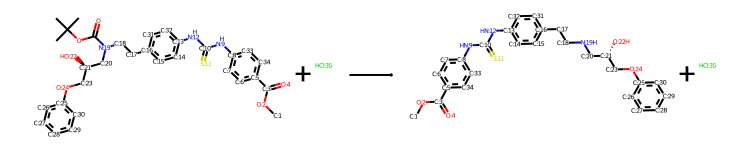

{5, 11, 17}

{20533894: {'atomdict': {'C': 36, 'N': 4, 'O': 7, 'F': 3, 'H': 51},
  'charge': 0,
  'smiles': 'Cc1cc(C[C@H]2CN(C(=O)OC(C)(C)C)C[C@H]2OCCN(CC(F)(F)c2cccc(F)c2)C(=O)OC(C)(C)C)nc(NC(=O)OC(C)(C)C)c1',
  'formula': 'C36H51F3N4O7',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['CC(C)(C)OC(=O)[NH:5][c:4]1[cH:3][c:2]([CH3:1])[cH:29][c:7]([CH2:8][C@H:9]2[CH2:10][N:11](C(=O)OC(C)(C)C)[CH2:12][C@H:13]2[O:14][CH2:15][CH2:16][N:17](C(=O)OC(C)(C)C)[CH2:18][C:19]([F:20])([F:21])[c:22]2[cH:23][cH:24][cH:25][c:26]([F:27])[cH:28]2)[n:6]1'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f8fc3249b80>],
  'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
  'fragloc': {0: {'c[H]': {'corrmatches': [(9, 51),
      (12, 55),
      (43, 70),
      (44, 71),
      (45, 72),
      (48, 73)],
     'funcgroupids': []}}},
  'reacfrag': {}},
 1098214: {'atomdict': {'Cl': 1, 'H': 1},
  'charge': 0,
  'smiles': 'Cl',
  'formula': 'HCl',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[ClH

In [150]:
rdChemReactions.ReactionFromSmarts(analoguerxnsvalid.loc[49729].mapped_rxn,useSmiles=True)
analoguerxnsvalid.loc[49733].rxncentermapnum
analoguerxnsvalid.loc[49733].LHSdata

In [349]:
# analoguerxnsvalid
analoguerxnsvalid.loc[analoguerxnsvalid['unusedanalogue'].astype(bool)]
# analoguerxnsvalid.loc[analoguerxnsvalid['outfrag'].astype(bool)]
# candirxnsfinal=candirxnsvalid.loc[(~candirxnsvalid['noanalogue'].astype(bool)) & (~candirxnsvalid['outfrag'].astype(bool)) & (~candirxnsvalid['unusedanalogue'].astype(bool))]
analoguerxnsfinal=analoguerxnsvalid.loc[~(analoguerxnsvalid['outfrag'].astype(bool))]

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,msg2,specmap,rnbmap,rxncentermapnum,rxncenter,msg3,outfrag,outfg,outneighbor,unusedanalogue
57,10011167,1,1,1,Cc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C)c1OCC...,Cc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C)c1OCC...,RHS species insufficient with species: 3659776,"[10221390, 3659776]",[10233350],[],...,Valid,"{1: (10221390, 0, 0, 10233350, (0, 0), 0), 2: ...",{},"{42, 43, 44, 45, 46, 47, 48}",True,Species 10221390 not reacting at carrier fragm...,[10221390],"{10221390: [48, 42, 43, 44, 45, 46, 47]}","{10221390: [48, 42, 43, 44, 45, 46, 47]}",[3659776]
76,29821250,1,1,1,CC(C)(C)OC(=O)NCCCC[C@H](NC(=O)c1ccc(CNc2ccc(/...,CC(C)(C)OC(=O)NCCCC[C@H](NC(=O)c1ccc(CNc2ccc(/...,RHS species insufficient with species: 1098214,"[20779620, 1098214]",[20779626],[],...,Valid,"{2: (20779620, 0, 7, 20779626, (0, 1), 0), 3: ...","{'n0': (20779620, 0, 5)}",{2},True,Species 20779620 not reacting at carrier fragm...,[20779620],"{20779620: [2, 'n0']}","{20779620: [2, 'n0']}",[1098214]
233,37083831,1,1,2,CC1(C)C2CC1C1OB(C(Cc3ccccc3)C(Cc3ccccc3)N=[N+]...,CC1(C)C2CC1C1OB(C(Cc3ccccc3)C(Cc3ccccc3)N=[N+]...,"Hydrogen carriers: 26538124,1098214,11460447,1...","[26538124, 1098214]",[26538127],[],...,Valid,"{31: (1098214, 0, 0, 26538127, (0, 1), 0), 19:...","{'n0': (26538124, 0, 1)}","{19, 28}",True,Species 26538124 not reacting at carrier fragm...,[26538124],"{26538124: [19, 28, 'n0']}","{26538124: [19, 28, 'n0']}",[1098214]
358,41941932,2,1,1,CN1CN(c2ccccc2)C2(CCN(C(=O)OC(C)(C)C)CC2)C1=O>...,CN1CN(c2ccccc2)C2(CCN(C(=O)OC(C)(C)C)CC2)C1=O....,RHS species insufficient with species: 1098214,"[8079719, 1098214]",[13312588],[],...,Valid,"{14: (8079719, 0, 7, 13312588, (0, 0), 13), 13...","{'n0': (8079719, 0, 5)}",{14},True,Species 8079719 not reacting at carrier fragme...,[8079719],"{8079719: [14, 'n0']}","{8079719: [14, 'n0']}",[1098214]
445,29589366,1,1,2,CC(OC[C@H]1CO1)c1ccc2ccccc2c1.CC(C)(N)Cc1ccc2c...,CC(OC[C@H]1CO1)c1ccc2ccccc2c1.CC(C)(N)Cc1ccc2c...,Balanced with species: 1098214,"[20511869, 3127174, 1098214]",[20511899],[],...,Valid,"{1: (20511869, 0, 0, 20511899, (0, 0), 0), 2: ...",{},"{8, 6, 7}",True,"Species 3127174, 20511869 not reacting at carr...","[3127174, 20511869]","{3127174: [8], 20511869: [6, 7]}","{3127174: [8], 20511869: [6, 7]}",[1098214]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49548,38247144,19,1,1,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,RHS species insufficient with species: 1098214,"[23786269, 1098214]",[27078074],[],...,Valid,"{24: (23786269, 0, 7, 27078074, (0, 0), 23), 2...","{'n0': (23786269, 0, 5)}","{24, 23}",True,Species 23786269 not reacting at carrier fragm...,[23786269],"{23786269: [24, 23, 'n0']}","{23786269: [24, 23, 'n0']}",[1098214]
49549,38247144,19,1,1,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,RHS species insufficient with species: 1098214,"[23786269, 1098214]",[27078074],[],...,Valid,"{24: (23786269, 0, 7, 27078074, (0, 0), 23), 2...","{'n0': (23786269, 0, 5)}","{24, 23}",True,Species 23786269 not reacting at carrier fragm...,[23786269],"{23786269: [24, 23, 'n0']}","{23786269: [24, 23, 'n0']}",[1098214]
49662,45894515,1,1,1,Nc1cccc([N+](=O)[O-])c1>>Cl.Cl[TeH](Cl)(Cl)(Cl...,Nc1cccc([N+](=O)[O-])c1.Cl[Te](Cl)(Cl)Cl.Cl.Cl...,"Balanced with species: 3903218,1098214","[636962, 3903218, 1098214, 1098214]",[31527126],[],...,Valid,"{2: (3903218, 0, 0, 31527126, (0, 0), 0), 3: (...",{},"{3, 5}",True,Species 3903218 not reacting at carrier fragme...,[3903218],{3903218: [3]},{3903218: [3]},"[1098214, 636962]"
49729,28873068,1,1,1,COC(=O)c1ccc(NC(=S)Nc2ccc(CCN(C[C@H](O)COc3ccc...,COC(=O)c1ccc(NC(=S)Nc2ccc(CCN(C[C@H](O)COc3ccc...,RHS species insufficient with species: 1098214,"[19697604, 1098214]",[19697628],[],...,Valid,"{19: (19697604, 0, 7, 19697628, (0, 0), 18), 1...","{'n0': (19697604, 0, 

In [350]:
analoguerxnsfinal

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,msg2,specmap,rnbmap,rxncentermapnum,rxncenter,msg3,outfrag,outfg,outneighbor,unusedanalogue
469,38266544,1,1,1,Cc1cccc[n+]1[O-].COc1ccc(Cn2ccnn2)cc1>>COc1ccc...,Cc1cccc[n+]1[O-].COc1ccc(Cn2ccnn2)cc1>>COc1ccc...,RHS species insufficient,"[106916, 881390]",[27088736],[],...,Valid,"{1: (881390, 0, 0, 27088736, 0, 0), 2: (881390...",{},"{12, 13}",True,Valid,[],{},{},[]
651,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,Valid,"{9: (1072122, 0, 1, 20866043, 0, 8), 10: (1072...","{'n0': (1072122, 0, 0)}","{8, 9}",True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[]
652,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,Valid,"{9: (1072122, 0, 1, 20866043, 0, 8), 10: (1072...","{'n0': (1072122, 0, 0)}","{8, 9}",True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[]
653,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,Valid,"{9: (1072122, 0, 1, 20866043, 0, 8), 10: (1072...","{'n0': (1072122, 0, 0)}","{8, 9}",True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[]
654,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,Valid,"{9: (1072122, 0, 1, 20866043, 0, 8), 10: (1072...","{'n0': (1072122, 0, 0)}","{8, 9}",True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46314,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,RHS species insufficient,"[1861359, 1861359]",[3398009],[],...,Valid,"{1: (1861359, 0, 0, 3398009, 0, 0), 2: (186135...",{},"{4, 5}",True,Valid,[],{},{},[]
46315,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,RHS species insufficient,"[1861359, 1861359]",[3398009],[],...,Valid,"{1: (1861359, 0, 0, 3398009, 0, 0), 2: (186135...",{},"{4, 5}",True,Valid,[],{},{},[]
46316,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,"Mapper used, Unmapped species from LHS: 635680...","[1861359, 1861359]",[3398009],[],...,Valid,"{1: (1861359, 0, 0, 3398009, 0, 0), 2: (186135...",{},"{4, 5}",True,Valid,[],{},{},[]
46778,6682766,1,1,1,ClCl.c1ccccc1.Cl[Al](Cl)Cl>>Clc1ccccc1,ClCl.c1ccccc1.Cl[Al](Cl)Cl>>Clc1ccccc1,RHS species insufficient,"[3902968, 969212, 1209238]",[605632],[],...,Valid,"{1: (3902968, 0, 1, 605632, 0, 0), 2: (969212,...","{'n0': (3902968, 0, 0)}","{1, 2}",True,Valid,[],{},{},[]


### Template generation

In [320]:
# analoguerxnsfinal.iloc[7].RHSdata
# analoguerxnsfinal[:6].apply(gen_template_row,axis=1,result_type='reduce')
# gen_template_row(analoguerxnsfinal.iloc[7])
gen_template_row(analoguerxnsfinal.loc[analoguerxnsfinal.ReactionID==6682766].iloc[0])
analoguerxnsfinal.loc[analoguerxnsfinal.ReactionID==6682766].iloc[0].LHSdata

('Cl[Cl:1].[H][c:2]>>[Cl:1][c:2]',
 {3902968: {'atomdict': {'Cl': 2},
   'charge': 0,
   'smiles': 'ClCl',
   'formula': 'Cl2',
   'count': 1,
   'mixture': False,
   'mappedsmiles': ['Cl[Cl:1]'],
   'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f8fc6b4d220>],
   'querycompds': {'Cl': ['O=C1CCC(=O)N1Cl']},
   'fragloc': {0: {'Cl': {'corrmatches': [(0,), (1,)],
      'funcgroupids': [{0}, {1}]}}},
   'reacfrag': {0: {'Cl': [1, 0]}},
   'templatefragidx': {0: {0, 1}},
   'templatefrag': {0: 'Cl[Cl:1]'}},
  969212: {'atomdict': {'C': 6, 'H': 6},
   'charge': 0,
   'smiles': 'c1ccccc1',
   'formula': 'C6H6',
   'count': 1,
   'mixture': False,
   'mappedsmiles': ['[cH:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1'],
   'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f8fd1fc3820>],
   'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
   'fragloc': {0: {'c[H]': {'corrmatches': [(0, 6),
       (1, 7),
       (2, 8),
       (3, 9),
       (4, 10),
       (5, 11)],
      'funcgroupids': []}}},
  

{3902968: {'atomdict': {'Cl': 2},
  'charge': 0,
  'smiles': 'ClCl',
  'formula': 'Cl2',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['Cl[Cl:1]'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f8f106a7ea0>],
  'querycompds': {'Cl': ['O=C1CCC(=O)N1Cl']},
  'fragloc': {0: {'Cl': {'corrmatches': [(0,), (1,)],
     'funcgroupids': [{0}, {1}]}}},
  'reacfrag': {0: {'Cl': [1, 0]}}},
 969212: {'atomdict': {'C': 6, 'H': 6},
  'charge': 0,
  'smiles': 'c1ccccc1',
  'formula': 'C6H6',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[cH:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f8f106a7ef0>],
  'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
  'fragloc': {0: {'c[H]': {'corrmatches': [(0, 6),
      (1, 7),
      (2, 8),
      (3, 9),
      (4, 10),
      (5, 11)],
     'funcgroupids': []}}},
  'reacfrag': {0: {'c[H]': [0]}}}}

In [351]:
analoguerxnstempl=gentemplate(analoguerxnsfinal)

2022-02-18 01:30:03,624	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [54]:
analoguerxnstempl=pd.read_pickle(ipdir+'analoguerxnstempl.pickle')
# pd.to_pickle(analoguerxnstempl,ipdir+'analoguerxnstempl.pickle')

In [447]:
visoutput2(analoguerxnstempl)

IntSlider(value=76842, description='Reaxys ID', max=47885376, min=76842)

IntSlider(value=0, description='Instance', max=0)

Output()

In [352]:
visoutput(analoguerxnstempl)

IntSlider(value=0, description='Row Number', max=186)

Output()

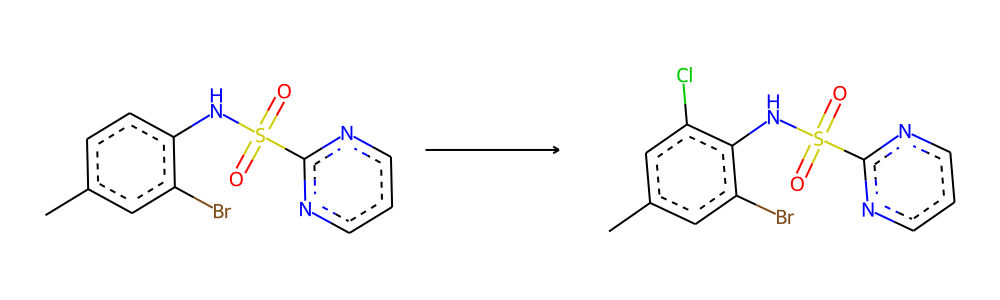

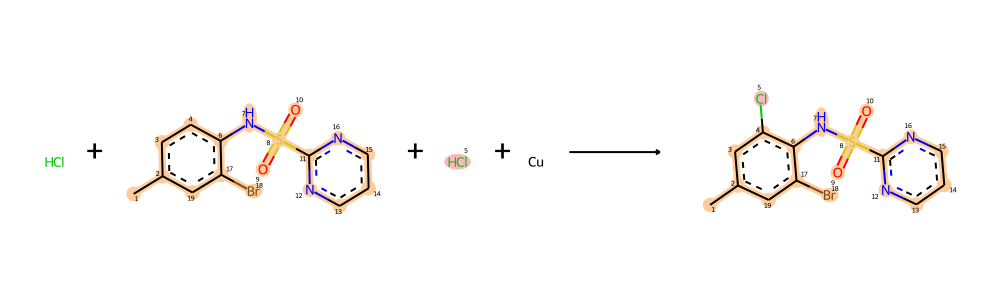

{24670501: {'atomdict': {'C': 11, 'N': 3, 'S': 1, 'O': 2, 'Br': 1, 'H': 10},
  'charge': 0,
  'smiles': 'Cc1ccc(NS(=O)(=O)c2ncccn2)c(Br)c1',
  'formula': 'C11H10BrN3O2S',
  'count': 1,
  'mixture': False,
  'mappedsmiles': ['[CH3:1][c:2]1[cH:3][cH:4][c:6]([NH:7][S:8](=[O:9])(=[O:10])[c:11]2[n:12][cH:13][cH:14][cH:15][n:16]2)[c:17]([Br:18])[cH:19]1'],
  'cleanmol': [<rdkit.Chem.rdchem.Mol at 0x7f905cb728b0>],
  'querycompds': {'c[H]': ['c1ccc2[nH]ccc2c1', 'Clc1c[nH]c2ccccc12']},
  'fragloc': {0: {'c[H]': {'corrmatches': [(2, 21),
      (3, 22),
      (11, 24),
      (12, 25),
      (13, 26),
      (17, 27)],
     'funcgroupids': []}}},
  'reacfrag': {0: {'c[H]': [1]}},
  'templatefragidx': {0: {3, 22}},
  'templatefrag': {0: '[H][c:4]'}},
 8128168: {'atomdict': {'Cl': 2, 'Cu': 1, 'H': 2},
  'charge': 0,
  'smiles': 'Cl.Cl.[Cu]',
  'formula': 'H2Cl2Cu',
  'count': 1,
  'mixture': True,
  'mappedsmiles': [('[ClH:5]',)],
  'cleanmol': [(<rdkit.Chem.rdchem.Mol at 0x7f905cb72810>,)],
  'unma

{3902968: {'atomdict': {'Cl': 2},
  'charge': 0,
  'smiles': 'ClCl',
  'formula': 'Cl2',
  'count': 1},
 969212: {'atomdict': {'C': 6, 'H': 6},
  'charge': 0,
  'smiles': 'c1ccccc1',
  'formula': 'C6H6',
  'count': 1},
 1209238: {'atomdict': {'Cl': 3, 'Al': 1},
  'charge': 0,
  'smiles': 'Cl[Al](Cl)Cl',
  'formula': 'AlCl3',
  'count': 1}}

In [235]:
drawReaction(rdChemReactions.ReactionFromSmarts(analoguerxnstempl.loc[41284].rxnsmiles0,useSmiles=True))
drawReaction(rdChemReactions.ReactionFromSmarts(analoguerxnstempl.loc[41284].mapped_rxn,useSmiles=True))
analoguerxnstempl.loc[41284].LHSdata
analoguerxns3.loc[analoguerxns3.ReactionID==6682766].iloc[0].Rdata

In [353]:
#If template is already known
reactionfilter=analoguerxnstempl.apply(matchtemplaterow,samplerxn='c[H].Cl>>cCl',axis=1,result_type='reduce')
reactionfilterlist=reactionfilter[reactionfilter.values==True].index
reaction2=analoguerxnstempl[analoguerxnstempl.index.isin(reactionfilterlist)]
reaction2
visoutput(reaction2)

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,rxncenter,msg3,outfrag,outfg,outneighbor,unusedanalogue,template,msg4,farfg,unusedprod
1056,289276,1,1,1,NC(=O)COc1ccccc1>>NC(=O)COc1ccc(Cl)cc1,NC(=O)COc1ccccc1.ClCl>>NC(=O)COc1ccc(Cl)cc1,RHS species insufficient with species: 3902968,"[1941781, 3902968]",[2259208],[],...,True,Valid,[],{},{},[],Cl[Cl:10].[H][c:9]>>[c:9][Cl:10],Valid,[],[]
2166,24514865,1,1,1,Cc1cc(N)[nH]n1>>Cc1n[nH]c(N)c1Cl.Cl.Cc1n[nH]c(...,Cc1cc(N)[nH]n1.Cc1cc(N)[nH]n1.Cl.Cl.Cl>>Cc1n[n...,"Mapper used, RHS species insufficient with spe...","[606047, 606047, 1098214, 1098214, 1098214]","[13568245, 11421758]",[],...,True,Species 1098214 does not participate in reaction,[],{},{},[1098214],[H][c:7].[H][c:15].[Cl:16].[Cl:8]>>[c:7][Cl:8]...,Valid,[],[]
3826,23323594,1,1,1,CC(=O)Nc1ccccc1CCN(C)C(C)=O>>CC(=O)Nc1ccc(Cl)c...,CC(=O)Nc1ccccc1CCN(C)C(C)=O.ClCl>>CC(=O)Nc1ccc...,RHS species insufficient with species: 3902968,"[14285961, 3902968]",[14285977],[],...,True,Valid,[],{},{},[],Cl[Cl:9].[H][c:8]>>[c:8][Cl:9],Valid,[],[]
6178,33686501,1,1,1,N#Cc1cc(F)c(F)c(F)n1>>N#Cc1nc(F)c(F)c(F)c1Cl,N#Cc1cc(F)c(F)c(F)n1.ClCl>>N#Cc1nc(F)c(F)c(F)c1Cl,RHS species insufficient with species: 3902968,"[22697325, 3902968]",[477966],[],...,True,Valid,[],{},{},[],Cl[Cl:12].[H][c:11]>>[c:11][Cl:12],Valid,[],[]
6700,4410496,1,1,1,O=C(O)[C@@H]1CCc2cc([C@@H]3CCC[C@@H](O)C3)ccc2...,O=C(O)[C@@H]1CCc2cc([C@@H]3CCC[C@@H](O)C3)ccc2...,RHS species insufficient with species: 3902968,"[7363898, 3902968]",[7364139],[],...,True,Valid,[],{},{},[],Cl[Cl:18].[H][c:17]>>[c:17][Cl:18],Valid,[],[]
9367,1117966,1,1,1,CCc1cc(CC)c(F)c(CC)c1>>CCc1cc(CC)c(Cl)c(CC)c1F,CCc1cc(CC)c(F)c(CC)c1.ClCl>>CCc1cc(CC)c(Cl)c(C...,RHS species insufficient with species: 3902968,"[2519348, 3902968]",[2521705],[],...,True,Valid,[],{},{},[],Cl[Cl:9].[H][c:8]>>[c:8][Cl:9],Valid,[],[]
11198,289424,4,1,1,CCCCc1ccc(O)cc1O>>CCCCc1cc(Cl)c(O)cc1O,CCCCc1ccc(O)cc1O.ClCl>>CCCCc1cc(Cl)c(O)cc1O,RHS species insufficient with species: 3902968,"[1942645, 3902968]",[3259181],[],...,True,Valid,[],{},{},[],Cl[Cl:8].[H][c:7]>>[c:7][Cl:8],Valid,[],[]
12404,46364272,4,1,1,CC(=O)Nc1ccc(C(F)(F)F)cc1>>CC(=O)Nc1ccc(C(F)(F...,CC(=O)Nc1ccc(C(F)(F)F)cc1.Cl.[NaH]>>CC(=O)Nc1c...,RHS species insufficient with species: 8127935,"[2106965, 8127935]",[27906248],[],...,True,Valid,[],{},{},[],[H][c:14].[Cl:15]>>[c:14][Cl:15],Valid,[],[]
12405,46364272,4,1,1,CC(=O)Nc1ccc(C(F)(F)F)cc1>>CC(=O)Nc1ccc(C(F)(F...,CC(=O)Nc1ccc(C(F)(F)F)cc1.Cl.[NaH]>>CC(=O)Nc1c...,RHS species insufficient with species: 8127935,"[2106965, 8127935]",[27906248],[],...,True,Valid,[],{},{},[],[H][c:14].[Cl:15]>>[c:14][Cl:15],Valid,[],[]
12561,43908639,10,1,1,CC(C)(C)C(=O)Nc1cccc2cccnc12>>CC(C)(C)C(=O)Nc1...,CC(C)(C)C(=O)Nc1cccc2cccnc12.Cl.[LiH]>>CC(C)(C...,RHS species insufficient with species: 8127934,"[17503248, 8127934]",[29604404],[],...,True,Valid,[],{},{},[],[H][c:11].[Cl:12]>>[c:11][Cl:12],Valid,[],[]


IntSlider(value=0, description='Row Number', max=21)

Output()

In [19]:
analoguerxnstemplfilt=analoguerxnstempl.loc[analoguerxnstempl.msg4=='Valid']
analoguerxnstemplfilt

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,...,rxncenter,msg3,outfrag,outfg,outneighbor,unusedanalogue,template,msg4,farfg,unusedprod
469,38266544,1,1,1,Cc1cccc[n+]1[O-].COc1ccc(Cn2ccnn2)cc1>>COc1ccc...,Cc1cccc[n+]1[O-].COc1ccc(Cn2ccnn2)cc1>>COc1ccc...,RHS species insufficient,"[106916, 881390]",[27088736],[],...,True,Valid,[],{},{},[],[H][c:12].[H][c:13]>>[c:12]-[c:13],Valid,[],[]
651,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[],Cl[c:9].[H][c:8]>>[c:8]-[c:9],Valid,[],[]
652,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[],Cl[c:9].[H][c:8]>>[c:8]-[c:9],Valid,[],[]
653,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[],Cl[c:9].[H][c:8]>>[c:8]-[c:9],Valid,[],[]
654,29900143,4,1,1,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,N#Cc1ccc(Cl)cc1.CCCCc1ccco1>>CCCCc1ccc(-c2ccc(...,RHS species insufficient,"[1072122, 107045]",[20866043],[],...,True,Species 1072122 not reacting at functional group,[],{1072122: [9]},{},[],Cl[c:9].[H][c:8]>>[c:8]-[c:9],Valid,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46314,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,RHS species insufficient,"[1861359, 1861359]",[3398009],[],...,True,Valid,[],{},{},[],[H][c:4].[H][c:5]>>[c:4]-[c:5],Valid,[],[]
46315,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,RHS species insufficient,"[1861359, 1861359]",[3398009],[],...,True,Valid,[],{},{},[],[H][c:4].[H][c:5]>>[c:4]-[c:5],Valid,[],[]
46316,9778141,5,1,1,Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc(C)c(O)c3ccccc23)...,Cc1ccc2ccccc2c1O.Cc1ccc2ccccc2c1O>>Cc1cc(-c2cc...,"Mapper used, Unmapped species from LHS: 635680...","[1861359, 1861359]",[3398009],[],...,True,Valid,[],{},{},[],[H][c:4].[H][c:5]>>[c:4]-[c:5],Valid,[],[]
46778,6682766,1,1,1,ClCl.c1ccccc1.Cl[Al](Cl)Cl>>Clc1ccccc1,ClCl.c1ccccc1.Cl[Al](Cl)Cl>>Clc1ccccc1,RHS species insufficient,"[3902968, 969212, 1209238]",[605632],[],...,True,Valid,[],{},{},[],Cl[Cl:1].[H][c:2]>>[Cl:1][c:2],Valid,[],[]


### Template application

In [388]:
apply_template_row(analoguerxnstemplfilt.iloc[1],demoquery)

([('Clc1c[nH]c2ccccc12', 'Clc1c[nH]c2ccccc12'),
  ('Clc1c[nH]c2ccccc12', 'c1ccc2[nH]ccc2c1')],
 [{('[H]c1c(-c2c([H])n([H])c3c([H])c([H])c([H])c([H])c23)c([H])c2c(c1[H])c(Cl)c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c(Cl)c3c([H])c([H])c([H])c([H])c3n1[H])c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c([H])c3c(Cl)c([H])n([H])c13)c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c([H])c3c1c(Cl)c([H])n3[H])c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c3c(c1[H])c(Cl)c([H])n3[H])c([H])n2[H]',)},
  {('[H]c1c(-c2c([H])n([H])c3c([H])c([H])c([H])c([H])c23)c([H])c2c(c1[H])c([H])c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c([H])c3c([H])c([H])n([H])c13)c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c([H])c3c1c([H])c([H])n3[H])c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c([H])c3c(c1[H])c([H])c([H])n3[H])c([H])n2[H]',),
   ('[H]c1c([H])c([H])c2c(c1[H])c(-c1c([H])c3c([H])c([H])c([H])c

In [20]:
analoguerxnsimp=applytemplate(analoguerxnstemplfilt,demoquery,ncpus=10)

2022-02-20 02:27:55,267	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [57]:
analoguerxnsimp=pd.read_pickle(ipdir+'analoguerxnsimp.pickle')
# pd.to_pickle(analoguerxnsimp,ipdir+'analoguerxnsimp.pickle')

In [21]:
analoguerxnsimpfinal=analoguerxnsimp.loc[(analoguerxnsimp.impurityrxn.astype(bool)) & (analoguerxnsimp.impurityrxn!='Error')]    

In [420]:
# analoguerxnsimpfinal[:107].apply(removeduplicates_,axis=1,result_type='reduce')
analoguerxnsimpfinal.iloc[105]
# removeduplicates_(analoguerxnsimpfinal.iloc[105])

ReactionID                                                  38628877
NumRefs                                                            4
NumSteps                                                           1
NumStages                                                          3
rxnsmiles0         Clc1cc(Cl)ncn1.CC1(Oc2ccc3nn(COCC[Si](C)(C)C)c...
balrxnsmiles       Clc1cc(Cl)ncn1.CC1(Oc2ccc3nn(COCC[Si](C)(C)C)c...
msg                                         RHS species insufficient
LHS                                               [111195, 27391397]
RHS                                                       [27391398]
hcrct                                                             []
hcprod                                                            []
LHSdata            {111195: {'atomdict': {'Cl': 2, 'C': 4, 'N': 2...
RHSdata            {27391398: {'atomdict': {'C': 21, 'O': 2, 'N':...
mapped_rxn         Cl[c:19]1[cH:20][c:21]([Cl:22])[n:23][cH:24][n...
confidence                        

In [22]:
analoguerxnsimpfinal=removeduplicates(analoguerxnsimpfinal,ncpus=5,restart=True)

2022-02-20 02:30:50,956	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [453]:
analoguerxnsimpfinal[['msg','msg1','msg2','msg3','msg4']]

,msg,msg1,msg2,msg3,msg4
469,RHS species insufficient,Valid,Valid,Valid,Valid
651,RHS species insufficient,Valid,Valid,Species 1072122 not reacting at functional group,Valid
652,RHS species insufficient,Valid,Valid,Species 1072122 not reacting at functional group,Valid
653,RHS species insufficient,Valid,Valid,Species 1072122 not reacting at functional group,Valid
654,RHS species insufficient,Valid,Valid,Species 1072122 not reacting at functional group,Valid
...,...,...,...,...,...
46313,"Mapper used, Unmapped species from LHS: 415456...",Valid,Valid,Valid,Valid
46314,RHS species insufficient,Valid,Valid,Valid,Valid
46315,RHS species insufficient,Valid,Valid,Valid,Valid
46316,"Mapper used, Unmapped species from LHS: 635680...",Valid,Valid,Valid,Valid


In [24]:
pd.to_pickle(analoguerxnsimpfinal,ipdir+'analoguerxnsimpfinal.pickle')

### Impurity cleaning

In [476]:
impfinal=cleanimpurities(analoguerxnsimpfinal,analoguerxns3,dpdir+'analgrxnsfinal.pickle',demoquery,includesolv=True,reaxys_update=True,hc_prod=hc_Dict)

ValueError: cannot reindex from a duplicate axis

In [118]:
analoguerxns2

NumRefs        ReactantID MissingReactant   ProductID  \
ReactionID Instance                                                          
87         4               2          [507131]              []   [2214815]   
92         0               3         [2040713]              []   [1887659]   
           1               3         [2040713]              []   [1887659]   
102        0               1           [10000]              []     [14981]   
103        0               1          [100014]              []     [97673]   
...                      ...               ...             ...         ...   
48368858   1               3  [30569344, 3956]              []  [32390765]   
           2               3  [30569344, 3956]              []  [32390765]   
48369092   0               1        [32979795]              []  [15596190]   
48369100   0               1        [32979802]              []   [6926411]   
48369459   0               1        [32980045]              []    [471401]   

                    MissingProduct  NumSteps  NumStages  \
ReactionID Instance                                       
87         4                    []         1          2   
92         0                    []         1          1   
           1                    []         1          1   
102        0                    []         1          1   
103        0                    []         1          1   
...                            ...       ...        ...   
48368858   1                    []         1          1   
           2                    []         1          1   
48369092   0                    []         1          1   
48369100   0                    []         1          1   
48369459   0                    []         1          1   

                                                          ReagentID  \
ReactionID Instance                                                   
87         4         [16474298, 3587155, 3587158, 3587218, 3587193]   
92         0                                    [11343348, 8128150]   
           1                                              [3587218]   
102        0                                    [11342940, 8129999]   
103        0                                    [11342940, 1731042]   
...                                                             ...   
48368858   1                           [11343411, 1738613, 8402623]   
           2                                    [11343411, 8402623]   
48369092   0                                     [3587155, 8128150]   
48369100   0                                     [3587155, 8128150]   
48369459   0                                              [4933273]   

                    MissingReagent  Temperature  ... ReactionTime  SolventID  \
ReactionID Instance                              ...                           
87         4                    []        [220]  ...           []  [3587155]   
92         0                    []        [100]  ...          [8]  [3587155]   
           1                    []  [180 - 280]  ...           []  [3587155]   
102        0                    []           []  ...           []         []   
103        0                    []           []  ...           []         []   
...                            ...          ...  ...          ...        ...   
48368858   1                    []        [120]  ...         [24]   [635760]   
           2                    []        [120]  ...         [24]   [635760]   
48369092   0                    []        [110]  ...          [5]  [1718733]   
48369100   0                    []        [110]  ...          [5]  [1718733]   
48369459   0                    []         [25]  ...        [0.5]   [102391]   

                    MissingSolvent CatalystID       MissingCatalyst  \
ReactionID Instance                                                   
87         4                    []         []                    []   
92         0                    []         []               

In [ ]:
impfinalfilt=impfinal.loc[(impfinal.msg6=='Valid')|(impfinal.msg6.str.contains('Query'))|(impfinal.msg6.str.contains('Self'))]
impfinalfilt=impfinalfilt.loc[~impfinalfilt.hcrct.astype(bool)] #Remove help reactants
print(str(round(len(impfinalfilt.index)/len(impfinal.index)*100,2))+'% reactions remaining with valid, sensible impurities')
catpool=combinedpoolex-combinedpool
impfinalfilt=updatecatalyst(impfinalfilt,catpool)
#Topological fingerprints
impfinalfilt=relevance(impfinalfilt,inputquery)
impfinalfilt0=copy.deepcopy(impfinalfilt)
# Morgan fingerprints
impfinalfilt=relevance_score_morgan(impfinalfilt,querydict,includereagents=True) # setting up morgan fingerprints
impfinalfilt_rctonly=relevance_score_morgan(impfinalfilt0,querydict,includereagents=False)
impfinalfilt['Relevance_morgan_rctonly']=impfinalfilt_rctonly['Relevance_morgan']
impfinalfilt=standardize(impfinalfilt,reaxys_update=reaxys_update)

## Sandbox

One limitation is that not all similar fragments are picked up on. For instance, for phenol, the aromatic hydroxyl group [H]Oc is outputted by the fragment algorithm and is found in the fragment database. However, there are isotopes, and charged species that also may be structurally identical but the SMILES/SMARTS encoding is different.

In [ ]:
'[H]Oc' in fragdb.index

In [ ]:
initray(num_cpus=16)
freqtabledis=mpd.DataFrame(freqtable)
fraglist=freqtabledis.apply(ffsrow,patt='[H]Oc',colname='FragSmiles',axis=1,result_type='reduce')
fraglist=pd.Series(data=fraglist.values,index=fraglist.index)
fraglist=list(fraglist[fraglist.values==True].index)

In [ ]:
fraglist

In [ ]:
fraglist

In [ ]:
molfromsmiles(fragdb.xs('[H][O+](c)[Mg-2](Oc)(Oc)[O+]([H])c').iloc[0].Smiles)
molfromsmiles(fragdb.xs('[2H]Oc').iloc[0].Smiles)

Another issue is that the fragmentation algorithm does not identify purely carbon and hydrogen fragments. Thus, halogenation reactions involving aromatic structures will have limited results, as fragments generated will just be the entire structure (sensitive to different smiles strings)

In [ ]:
molfromsmiles('c1ccccc1')
getCarrierFrags0('c1ccccc1',resFormat='smiles')

In [ ]:
fragdb.xs('c1ccccc1')

The below is code for experimentation/explanation of key steps in the workflow

In [ ]:
sql3='''SELECT FragmentSmiles from FragmentDB1 Where FragmentSmiles="cnc"'''
# sql3='''SELECT Exists(SELECT 1 from FragmentDB1 Where FragmentSmiles="CClO")'''
present=pd.read_sql_query(sql3,DB)
present.iloc[0].values[0]

In [ ]:
getCompPool(fragdb,['CN','cnc'],SQL=False)

In [ ]:
initray(num_cpus=16)

In [ ]:
freqtabledis=mpd.DataFrame(freqtable)
fraglist=freqtabledis.apply(ffsrow,patt='[H]n(c)c',colname='FragSmiles',axis=1,result_type='reduce')
fraglist=pd.Series(data=fraglist.values,index=fraglist.index)
fraglist=list(fraglist[fraglist.values==True].index)

In [ ]:
fragdb.xs('[2H][n+](c)c')
molfromsmiles('[2H]N([2H])c1c2ncn(C)c2nc[n+]1[2H]')

In [ ]:
fraglist
analoguepool=getCompPool(fragdb,fraglist)

In [ ]:
analoguepool
analoguepool.xs('[H][15n](c)c')

In [ ]:
if not analoguepool.empty:
    analoguepool2=analoguepool.droplevel(0)
    aggreg=analoguepool2.groupby(level='SubstanceID')['count'].sum()
    analoguepool2=analoguepool2[~analoguepool2.index.duplicated(keep='first')]
    analoguepool2[['count']]=aggreg

In [ ]:
analoguepool2

In [ ]:
fraglist2=freqtabledis.apply(ffsrow,patt='[H]n(c)c',colname='FragSmiles',reverse=True,axis=1,result_type='reduce')
fraglist2=pd.Series(data=fraglist2.values,index=fraglist2.index)
fraglist2=list(fraglist2[fraglist2.values==True].index)
analoguepool3=getCompPool(fragdb,fraglist2)
if not analoguepool3.empty: #Need to check if this is a true substructure match
    analoguepool3=analoguepool3.droplevel(0)
    aggreg=analoguepool3.groupby(level='SubstanceID')['count'].sum()
    analoguepool3=analoguepool3[~analoguepool3.index.duplicated(keep='first')]
    analoguepool3[['count']]=aggreg
    analoguepool3dis=mpd.DataFrame(analoguepool3)
    match=analoguepool3dis.apply(ffsrow,patt='[H]n(c)c',colname='Smiles',axis=1,result_type='reduce')
    match=pd.Series(data=match.values,index=match.index)
    match=list(match[match.values==True].index)
    analoguepool3=analoguepool3[analoguepool3.index.isin(match)]
# analoguepool=pd.concat([analoguepool,analoguepool2]).drop_duplicates()

In [ ]:
fraglist
fraglist2

In [ ]:
fragdb.xs(6235669,level=1)

In [ ]:
analoguepool2
analoguepool3

In [ ]:
set(analoguepool3.index)-set(analoguepool2.index)

In [ ]:
set(fragdb.xs('[H]n(c)c').index).issubset(analoguepool2.index)
set(demoquery3['species']['c1ccc2[nH]ccc2c1']['[H]n(c)c']['analoguepool'].index)-set(fragdb.xs('[H]n(c)c').index)
set(fragdb.xs('[H]n(c)c').index)-set(demoquery3['species']['c1ccc2[nH]ccc2c1']['[H]n(c)c']['analoguepool'].index)
# set(fragdb.xs('[H]n(c)c').index).issubset(set(demoquery3['species']['c1ccc2[nH]ccc2c1']['[H]n(c)c']['analoguepool'].index))
# len(set(demoquery3['species']['c1ccc2[nH]ccc2c1']['[H]n(c)c']['analoguepool'].index)-set(fragdb.xs('[H]n(c)c').index))
# molfromsmiles()

In [ ]:
demoquery2
demoquery3

In [ ]:
# def getanaloguespecies(inputquery,DBsource,SQL=False,refquery={},ncpus=16,fragtable=None,substancedbsource=None,includeisotopes=False):
#     '''
#     Takes in input query dictionary and fragment database (DBsource) and populates each carrier fragment, returning updated dictionary
#     with analogue species pools. Also returns a fragment dictionary (keys are fragments and values are query species).
    
#     Pass in an SQL connection under DBsource and put SQL as true if memory is low, or pass in a file or database location address
#     refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
#     ncpus indicates how many CPUs or cores for parallel execution
#     fragtable is a dataframe of possible carrier fragments in the current database, and is needed if the user specifies 
#     custom fragments (as results are not prestored)
    
#     substancedbsource can either be a substance dataframe or address, mainly for fragments containing only carbon and
#     hydrogen (aromatic/aliphatic hydrocarbons)as the fragment identification algorithm does not extract these 
#     (Only heteroatoms)
    
#     Specify includeisotopes as True if isotope fragments need to be considered
    
#     '''
#     if type(DBsource)==str:
#         if not SQL: #Address/location specified
#             DB=pd.read_pickle(DBsource)
#         else:
#             DB=sqlite3.connect(DBsource)
#     elif type(DBsource)==pd.core.frame.DataFrame:
#         DB=DBsource
#     elif type(DBsource)==sqlite3.Connection:
#         DB=DBsource
    
#     species=inputquery['species']
#     fragdict={} #To document fragments that are completed
#     for spec in species:
#         for frag in species[spec]:
#             breakpoint()
#             fraginfo=species[spec][frag]
#             if frag in fragdict: #If fragment has already been processed previously
#                 spec=fragdict[frag][0]
#                 analoguepool=species[spec][frag]['analoguepool']
#                 fragdict[frag].extend([fraginfo['parent']])
#             else:
#                 if frag not in fragdict:
#                     fragdict.update({frag:[fraginfo['parent']]})
#                 if refquery and spec in refquery['species'] and frag in refquery['species'][spec] and 'analoguepool' in refquery['species'][spec][frag]: #If user provides a reference query
#                     analoguepool=refquery['species'][spec][frag]['analoguepool']
#                 #Fragment contains only carbon and  hydrogen, and is not picked up by IFG
#                 fragmol=Chem.MolFromSmarts(frag)
#                 if all([atom.GetAtomicNum() in [1,6] for atom in fragmol.GetAtoms()]): 
#                     if substancedbsource is None:
#                         raise CustomError('Please supply a substance dataframe or address for hydrocarbon fragments')
#                     elif type(substancedbsource)==str:
#                         substancedb=pd.read_pickle(substancedbsource)
#                     else:
#                         substancedb=substancedbsource
#                     initray(num_cpus=ncpus)
#                     substancedbdis=mpd.DataFrame(substancedb)
#                     matches=substancedbdis.apply(ffsrow,patt=frag,colname='Smiles',axis=1,result_type='reduce')
#                     matches=pd.Series(data=matches.values,index=matches.index)
#                     match=list(matches[matches.values==True].index)
#                     analoguepool=substancedb.loc[substancedb.index.isin(match)]
#                 elif (not fraginfo['usermodified'] and fraginfo['expand']==1) or (frag in DB.index):
#                     analoguepool=getCompPool(DB,frag,SQL=SQL)
#                 else: #User has modified fragments
#                     if fragtable is None:
#                         raise CustomError('Please supply a fragment table or dataframe of fragments')
#                     fraglist=[]
#                     fraglist2=[]
#                     initray(num_cpus=ncpus)
#                     freqtabledis=mpd.DataFrame(freqtable)
#                     fraglist=freqtabledis.apply(ffsrow,patt=frag,colname='FragSmiles',axis=1,result_type='reduce')
#                     fraglist=pd.Series(data=fraglist.values,index=fraglist.index)
#                     fraglist=list(fraglist[fraglist.values==True].index)
#                     analoguepool=getCompPool(DB,fraglist,SQL=SQL)
#                     if not analoguepool.empty:
#                         analoguepool=analoguepool.droplevel(0)
#                         aggreg=analoguepool.groupby(level='SubstanceID')['count'].sum()
#                         analoguepool=analoguepool[~analoguepool.index.duplicated(keep='first')]
#                         analoguepool[['count']]=aggreg
#                     if fraginfo['usermodified'] or fraginfo['expand']>1:
#                         fraglist2=freqtabledis.apply(ffsrow,patt=frag,colname='FragSmiles',reverse=True,axis=1,result_type='reduce')
#                         fraglist2=pd.Series(data=fraglist2.values,index=fraglist2.index)
#                         fraglist2=list(fraglist2[fraglist2.values==True].index)
#                         analoguepool2=getCompPool(DB,fraglist2,SQL=SQL)
#                         if not analoguepool2.empty: #Need to check if this is a true substructure match
#                             analoguepool2=analoguepool2.droplevel(0)
#                             aggreg=analoguepool2.groupby(level='SubstanceID')['count'].sum()
#                             analoguepool2=analoguepool2[~analoguepool2.index.duplicated(keep='first')]
#                             analoguepool2[['count']]=aggreg
#                             analoguepool2dis=mpd.DataFrame(analoguepool2)
#                             match=analoguepool2dis.apply(ffsrow,patt=frag,colname='Smiles',axis=1,result_type='reduce')
#                             match=pd.Series(data=match.values,index=match.index)
#                             match=list(match[match.values==True].index)
#                             analoguepool2=analoguepool2[analoguepool2.index.isin(match)]
#                         analoguepool=pd.concat([analoguepool,analoguepool2]).drop_duplicates()
#             fraginfo.update({'analoguepool':analoguepool})     
#     return inputquery,fragdict

# def resolvecandidates(postype,Rdata,specdict,candidates,update=True,validate=True):
# #     breakpoint()
#     if validate:
#         combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
#         if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
#             msg='LHS species insufficient'
#             return Rdata,candidates,msg
#     if len(candidates)>1:
#         matches=[findmatch(postype,specdict[candi]['atomdict']) for candi in candidates]
#         if 1 in matches:
#             candidates=[candidates[matches.index(1)]]
#         else:
#             if all(not match for match in matches):
#                 candidates2=[candi for candi in candidates if specdict[candi]['atomdict'].keys()==postype.keys()]
#                 if candidates2:
#                     candidates=candidates2
#             if len(candidates)>1 and all(match is not False for match in matches):
#                 if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
#                     counter=Counter(matches)
#                     maxmatch=max(matches)
#                     if counter[maxmatch]==1:
#                         candidates=[candidates[matches.index(maxmatch)]]
#                 elif len(set(matches))==len(matches):
#                     index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                     candidates=[candidates[index_max]]
            
#     if len(postype)==1 and 'H' in postype and len(candidates)>1: #Still multiple options
#         msg='Reducing agent/hydrogen carriers required and available: '+','.join([str(candi) for candi in candidates])
#         return Rdata,candidates,msg      
#     msg='Valid'
#     if update:
#         for candi in candidates:
#             if candi in Rdata.keys():
#                 Rdata[candi]['count']+=1
#             else:
#                 Rdata.update({candi:specdict[candi]})
#     return Rdata,candidates,msg


In [ ]:
# from MainFunctions import CustomError,getfragments, getcompdict, molfromsmiles
# from chempy import balance_stoichiometry
# import copy
# from collections import Counter
# from decimal import Decimal, ROUND_HALF_UP
# from rdkit import Chem #Importing RDKit

# def buildrxn(Rdata,Pdata):
#     '''
#     Takes reaction and product data, and concatenates smiles strings, forming
#     reaction smiles/smarts

#     '''
#     LHS=[Rdata[ID]['smiles'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
#     RHS=[Pdata[ID]['smiles'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
#     return '>>'.join([getfragments(LHS,smiles=True), getfragments(RHS,smiles=True)])


# def update_stoich(stoich,compdict,hcID=None,hc_Dict=None):
#     '''
#     Based on balanced stoichiometry output of balance_stoichiometry function from chempy, and given a 
#     dictionary of help compounds and relevant help IDs, updates species dictionary
#     '''
#     usedid=[]
#     formdict={}
#     msg=''   
#     for ID in compdict:
#         form=compdict[ID]['formula']
#         if form not in formdict:
#             formdict.update({form:[ID]})
#         else:
#             formdict[form].extend([ID])
# #     breakpoint()
#     if hcID:
#         if hc_Dict is None:
#             raise CustomError("Please supply help compound reference dictionary/dataframe")
#         for hcid in hcID:
#             form=hc_Dict[hcid]['formula']
#             if form not in formdict:
#                 formdict.update({form:[hcid]})
#             else:
#                 formdict[form].extend([hcid])
# #     globalcoeff=1
#     for formula,coeff in stoich.items():
#         if formula in formdict:
# #             numisomers=len(formdict[formula])
# #             i=0
# #             if numisomers>1: #Duplicate molecular formula but different structural formulae
# #                 i+=1
# #                 if i>1: #Too many isomeric species on the same side..recommend mapping instead
# #                     msg='Invalid balancing. Isomers cannot be assigned'
# #                     break
# #                 if coeff>=numisomers:
# #                     if coeff%numisomers==0:
# #                         coeff=int(coeff/numisomers)
# #                     else:
# #                         msg='Invalid balancing. Isomers cannot be assigned'
# #                         break
# #                 else:
# #                     if numisomers%coeff==0:
# #                         globalcoeff=int(numisomers/coeff)
# #                         msg='Global coeff:'+str(globalcoeff)
# #                         coeff=1
# #                     else:
# #                         msg='Invalid balancing. Isomers cannot be assigned'
# #                         break
# #             else:
# #                 coeff=coeff*globalcoeff
# #             numisomers=len(formdict[formula])
#             for ID in formdict[formula]:
#                 if ID not in compdict:
#                     compdict.update({ID:hc_Dict[ID]})
#                 compdict[ID]['count']=coeff
#                 usedid+=[ID]
#         else:
#             msg='Invalid balancing. Formula indicated in stoich outside compound dictionary'
#             break
# #     if msg and 'Global' not in msg:
#     if msg:
#         return 'Error',msg,formdict
#     else:
#         valid=True
#         unusedid=set(compdict.keys())-set(usedid)
#         if unusedid:
#             for ID in unusedid:
#                 if 'rxs_ids' not in compdict[ID]: #Identifying help compounds
#                     valid=False
#                     break
#             if valid:
#                 for ID in unusedid:
#                     del compdict[ID] # 'Reactants' that aren't reactants..these are removed
#         if valid and compdict:
# #             if 'Global' not in msg:
# #                 msg='Valid'
#             return compdict,msg,formdict
#         else:
# #             breakpoint()
#             msg='Invalid balancing. Species missing:'+','.join([str(unused) for unused in unusedid])
#             return compdict,msg,formdict
        

# def update_rxn(Rdata,Pdata,reac=None,prod=None,hc_prod=None,hcprod=[],hcrct=[],rxnsmiles0=None,msg=None):
#     '''
#     Wrapper for calling update_stoich function 
    
#     '''
#     stoichupdated=False
#     LHSisomer=False
#     RHSisomer=False
#     addmsgr=''
#     addmsgp=''
#     rmissing=[]
#     pmissing=[]
#     if reac is not None:#Switched order
#         stoichupdated=True
#         Rdata1,addmsgr,formdictr=update_stoich(reac,Rdata)
# #         if 'Global' in addmsgr: #Global coeff
# #             LHSisomer=True
# #             globalcoeffr=int(addmsgr.split(':')[1])
# #         if 'Species missing' in addmsgr:
# #             rmissing+=addmsgr.split(':')[1].split(',')
# #             rmissing=[int(rm) for rm in rmissing]
    
#     if prod is not None:
#         stoichupdated=True
#         Pdata1,addmsgp,formdictp=update_stoich(prod,Pdata,hcID=hcprod,hc_Dict=hc_prod)
# #         if 'Global' in addmsgp: #Global coeff
# #             RHSisomer=True
# #             globalcoeffp=int(addmsgp.split(':')[1])
# #         if 'Species missing' in addmsgp:
# #             pmissing+=addmsgp.split(':')[1].split(',')
# #             pmissing=[int(pm) for pm in pmissing]
            
# # Dealing with removed isomers by chempy balancing algorithm on one side (LHS or RHS)      
# #     if LHSisomer or RHSisomer:
# #         if LHSisomer and RHSisomer:
# #             if globalcoeffr!=globalcoeffp:
# #                 if globalcoeffr>globalcoeffp:
# #                     if globalcoeffr%globalcoeffp==0:
# #                         globalcoeffr=globalcoeffr/globalcoeffp
# #                         RHSisomer=False
# #                 else:
# #                     if globalcoeffp%globalcoeffr==0:
# #                         globalcoeffp=globalcoeffp/globalcoeffr
# #                         LHSisomer=False            
# #         if RHSisomer and not LHSisomer:
# #             for ID in Rdata1:
# #                 oldcount=Rdata1[ID]['count']
# #                 Rdata1[ID]['count']=oldcount*globalcoeffp
# #             addmsgp='Valid'
# #         if LHSisomer and not RHSisomer:
# #             for ID in Pdata1:
# #                 oldcount=Pdata1[ID]['count']
# #                 Pdata1[ID]['count']=oldcount*globalcoeffr
# #             addmsgr='Valid'
# # Dealing with species removed by chempy balancing algorithm (usually compounds with same molecular formula but different
# # structural formula on LHS and RHS)
# #     if rmissing or pmissing:
# #         if rmissing:
# #             for missingspec in rmissing:
# #                 missingadded=False
# #                 missingform=Rdata1[missingspec]['formula']
# #                 if prod is not None and missingform in formdictp:
# #                     sourceIDs=formdictp[missingform]
# #                     if len(sourceIDs)==1:
# #                         if pmissing and sourceIDs[0] in pmissing:
# #                             pmissing.remove(sourceIDs[0])
# #                         else:  
# #                             Pdata1[sourceIDs[0]]['count']+=1
# #                         missingadded=True
# #                 if not missingadded:
# #                     Rdata1='Error'
# #                     Pdata1='Error'
# #                     break
# #         if pmissing and Pdata1!='Error':
# #             for missingspec in pmissing:
# #                 missingadded=False
# #                 missingform=Pdata1[missingspec]['formula']
# #                 if reac is not None and missingform in formdictr:
# #                     sourceIDs=formdictr[missingform]
# #                     if len(sourceIDs)==1:
# #                         Rdata1[sourceIDs[0]]['count']+=1
# #                         missingadded=True
# #                 if not missingadded:
# #                     Rdata1='Error'
# #                     Pdata1='Error'
# #                     break
# #         if missingadded:
# #             addmsgr='Valid'
# #             addmsgp='Valid'
                      
            
#     if addmsgr and addmsgr!='Valid':
#         if msg is not None:
#             msg=addmsgr+' from LHS'+', '+msg
#         else:
#             msg=addmsgr+' from LHS'
#     if addmsgp and addmsgp!='Valid':
#         if msg is not None:
#             msg=addmsgp+' from RHS'+', '+msg
#         else:
#             msg=addmsgp+' from RHS'
        
#     if stoichupdated:
#         if Rdata1!='Error' and Pdata1!='Error':
#             Rdata=Rdata1
#             Pdata=Pdata1
#             try:
#                 balrxnsmiles=buildrxn(Rdata,Pdata)
#             except Exception:
#                 balrxnsmiles='Error'
#                 msg='Invalid balancing. Species missing in database'+', '+msg
#         else:
#             balrxnsmiles='Error'
#     else:
#         balrxnsmiles=buildrxn(Rdata,Pdata)
                
#     if hcrct:
#         LHSids=[ID for ID in Rdata if ID not in hcrct for _ in range(Rdata[ID]['count'])]
#     else:
#         LHSids=[ID for ID in Rdata for _ in range(Rdata[ID]['count'])]
#     if hcprod:
#         RHSids=[ID for ID in Pdata if ID not in hcprod for _ in range(Pdata[ID]['count'])]
#     else:
#         RHSids=[ID for ID in Pdata for _ in range(int(Pdata[ID]['count']))]
      
#     if rxnsmiles0 is not None:
#         return rxnsmiles0,balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata  #Same number and type of atoms reactant and product side and same charge ie. perfectly balanced reaction. Pretty much impossible.
#     else:
#         return balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata
    
                
# def tryhelp(hc_atomtype,chempyr,chempyp,coefflim=6):
#     '''
#     Attempts to balance reaction with addition of help compounds in helpCompounds.py.
    
#     hc_atomtype is a dictionary or list of help compounds
#     chempyr is a set of LHS species formulae
#     chemyp is a set of RHS species formulae
#     coefflim is the maximum acceptable stoichiometric coefficient value after balancing
    
#     Returns reac,prod (outputs of balance_stoichiometry function in chempy) and a list of help compounds added

#     '''
# #     breakpoint()
#     reac={}
#     prod={}
#     hcid=None
#     lim=len(hc_atomtype)
#     keylist=[hcid for hcid in hc_atomtype]
#     counter=0
#     invalid=True
#     while any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]) or not reac or invalid:
#         if counter>lim-1:
#             print('Help compounds did not help. Extra reactant atoms')
#             raise CustomError("Help compounds unable to balance") 
#         if hcid is not None:
#             chempyp.remove(hc_atomtype[hcid]['formula'])
#         hcid=keylist[counter]
#         chempyp.add(hc_atomtype[hcid]['formula'])
#         try:
#             reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True)
#             if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
#                 invalid=True
#                 raise Exception
#             else:
#                 invalid=False
#                 counter+=1
#                 continue
#         except Exception:
#             counter+=1
#             continue
#     print('Reaction successfully balanced')
#     return reac,prod,[hcid]    

# def balance(Rdata,Pdata,hc_prod={},balbefore=True,coefflim=6,addedspecies=[],addedhc=[],hc_react={}):
#     '''
#     Balances reaction given LHS and RHS species
    
#     '''
# #     breakpoint()
#     chempyr=[Rdata[ID]['formula'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
#     chempyp=[Pdata[ID]['formula'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
#     if len(set(chempyr+chempyp))<len(chempyr+chempyp): #Isomers/same formulae present
#         raise CustomError('Isomers detected. Balancing will not work')
#     chempyr=set(chempyr)
#     chempyp=set(chempyp)
# #     highcoeff=False
#     reac0={}
#     prod0={}
#     msg='Balanced'
#     addedstr=''
#     if addedspecies:
#         addedstr=' with species: '+(','.join([str(species) for species in addedspecies]))
#     if addedhc:
#         addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
#         if addedstr:
#             addedstr+', '+addedstr2
#         else:
#             addedstr=addedstr2
#     msg+=addedstr
    
#     if balbefore or not hc_prod: #Either user has indicated that first pass at balancing needs to be done or fails to specify help compounds
#         try:
#             reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True) #Try balancing once without adding compounds
#             if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
#                 raise Exception
#             elif any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]):
# #                 reac0=copy.copy(reac)
# #                 prod0=copy.copy(prod)
# #                 highcoeff=True
#                 raise Exception
 
#         except Exception as e:
#             if not hc_prod: #User has not supplied help compounds
# #                 if highcoeff:
# #                     return reac0,prod0,None,'Warning. Coeffs high'
# #                 else:
# #                     raise CustomError('Reaction does not balance. Help compounds not provided')
#                 raise CustomError('Reaction does not balance. Help compounds not provided')
#             pass
#         else: #Reaction successfully balanced
#             return reac,prod,None,msg
            
#     if hc_prod: #Can try help compounds
#         try:
#             reac,prod,hcid=tryhelp(hc_prod,chempyr,chempyp,coefflim=coefflim)
#         except Exception as e:
# #             if highcoeff:
# #                 return reac0,prod0,None,'Warning. Coeffs high'
# #             else:
# #                 raise CustomError('Reaction does not balance even with help compounds')
#             raise CustomError('Reaction does not balance even with help compounds')
#         else:
#             hclist=','.join([hc_prod[hc]['formula'] for hc in hcid])
#             return reac,prod,hcid,msg+' with help product(s): '+hclist
    

# def findmatch(postype,atomdict):
#     '''
#     Calculates proportion of atoms mapped
    
#     '''
#     rem2=Counter()
#     rem2.update(atomdict)
#     rem2.subtract(Counter(postype))
#     if any([val<0 for val in rem2.values()]):
#         if rem2.keys()==atomdict.keys() and len(set(Counter({k:rem2[k]/atomdict[k] for k in rem2}).values()))==1:
#             return 1.0 #Exact multiple
#         else:
#             return False
#     mapprop=1-(sum(rem2.values())/sum(atomdict.values()))
#     return round(mapprop,1)

# def balancerxn(Rdata,Pdata,Rgtdata={},Rgtid=[],Solvdata={},rxnsmiles0=None,numrefs=None,first=True,
#                addedspecies=[],addedhc=[],hc_prod={},hc_react={},coefflim=6,singleworkflow=True):
#     '''
#     Balances reaction, calls the balance function
    
#     '''
    
#     #%% Initialize added species/addedhc
#     if first:
#         addedspecies=[]
#         addedhc=[]
#     ds=[]
#     #%% Settle diatomic species (H2,O2 and H2O if present add them as they are probably involved)
#     if first and Rgtdata and hc_react:
#         ds=[did for did in Rgtdata if Rgtdata[did]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [2,3]]]
# #         ds=[did for did in Rgtdata if Rgtdata[did]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [0,1,2]]]
#         if ds:
#             Rdata.update({did:Rgtdata[did] for did in ds})
#             addedspecies+=ds
#     if Solvdata:
#         Rgtdata={**Rgtdata,**Solvdata} #Newly added
        
#     Rcount=sum([Counter(Rdata[ID]['atomdict']) for ID in Rdata for _ in range(Rdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on LHS
#     Rcharge=sum([Rdata[ID]['charge'] for ID in Rdata for _ in range(Rdata[ID]['count'])])
#     Pcount=sum([Counter(Pdata[ID]['atomdict']) for ID in Pdata for _ in range(Pdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on RHS
#     Pcharge=sum([Pdata[ID]['charge'] for ID in Pdata for _ in range(Pdata[ID]['count'])])

#     #%% String output handling
#     addedstr=''
#     if addedspecies:
#         addedstr=' with species: '+(','.join([str(species) for species in addedspecies]))
#     if addedhc:
#         addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
#         if addedstr:
#             addedstr+', '+addedstr2
#         else:
#             addedstr=addedstr2
            
#     #%% If reaction is balanced already
#     if Rcount==Pcount and Rcharge==Pcharge:
#         print('Reaction is fully balanced')
#         if first:
#             if rxnsmiles0 is not None:
#                 balrxnsmiles=rxnsmiles0
#             else:
#                 balrxnsmiles=buildrxn(Rdata,Pdata)
#             msg='Already balanced'
#         else:
#             balrxnsmiles=buildrxn(Rdata,Pdata)
#             msg='Balanced'
#         if addedstr:
#             msg+=addedstr
#         return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
        
    
# #%% Testing for stoichiometric multipliers (If compounds have same molecular formulae but different structural formulae)
# #     multrhs=True
# #     multlhs=False
# #     balcharge=True
# #     if Rcount.keys()==Pcount.keys():
# #         try:
# #             multset={Rcount[key]/Pcount[key] for key in Rcount} #Is there a common stoichiometric multiplier
# #             if len(multset)>1:
# #                 raise Exception
# #         except Exception as e:
# #             pass
# #         else:
# #             mult=list(multset)[0]
# #             if mult<1:
# #                 mult=1/mult
# #                 multlhs=True
# #                 multrhs=False
# #                 if Pcharge!=mult*Rcharge:
# #                     balcharge=False
# #             elif Rcharge!=mult*Pcharge:
# #                 balcharge=False
# #             if mult.is_integer() and balcharge:
# #                 if multrhs:
# #                     for ID in Pdata:
# #                         Pdata[ID]['count']=int(mult)
# #                 else:
# #                     for ID in Rdata:
# #                         Rdata[ID]['count']=int(mult)
# #                 msg='Balanced'
# #                 if addedstr:
# #                     msg+=addedstr
# #                 return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)


# #%% Otherwise take difference between atom type/count RHS and LHS

#     rem=Counter() # Rem contains difference between product and reactant counters
#     rem.update(Pcount)  #If atoms not balanced and same charge, attempt to balance. Can try if different charge but more tricky
#     rem.subtract(Rcount) #Subtracting reactant atom type index from product atom type index
#     postype={key:rem[key] for key in rem.keys() if rem[key]>0} #Finding only positive keys. Note that if counter is positive this means extra molecules need to be added on LHS (eg. reagent).
#     negtype={key:abs(rem[key]) for key in rem.keys() if rem[key]<0} #Finding only negative keys. If counter is negative this means extra molecules need to be added on RHS (eg. help compounds)

# #     breakpoint()
    
#     if postype: #Reactants, Reagents may be needed (postype or (postype and negtype))
#         if hc_prod:
#             if Rcharge==Pcharge:
#                 hc_prod={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['charge']==0} #Atom type for help compounds
#         #%% Initializing variables
#         candirxt=[]
#         candirgt=[]
#         candihc=[]
#         sortedrgt=[]
#         commonrgt=[]
#         matches=[]
#         #%% Get reactant match first
#         candirxt=[rctid for rctid in Rdata if set(postype.keys()).issubset(set(Rdata[rctid]['atomdict'].keys()))]
#         #%% Get reagent match
#         candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]

#         if candirgt and numrefs is not None and numrefs>1 and not singleworkflow: #Too many references can lead to many reagents being added at the same time (limitation of our method)
#             idealanaloguenum=int(Decimal((1/numrefs)*(len(Rgtid))).to_integral_value(rounding=ROUND_HALF_UP))
#             if idealanaloguenum==0: # This means empty condition record is likely incorrect
#                 idealanaloguenum=1
#             if ds:
#                 idealanaloguenum=idealanaloguenum-len(ds)
#             commonrgt=[ID for ID,val in Counter(Rgtid).most_common() if val>1 if ID in candirgt if ID in Rgtdata]   
#             candihc=[ID for ID in candirgt if Rgtdata[ID]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [1]] if ID not in commonrgt] #H2O
#             sortedrgt=[ID for ID,val in Counter(Rgtid).most_common() if ID in candirgt if ID in Rgtdata if ID not in commonrgt if ID not in candihc]
#             if len(candihc)+len(commonrgt)>=idealanaloguenum:
#                 candirgt=list(set(candihc+commonrgt[:idealanaloguenum]))
#             else:
#                 extrargt=idealanaloguenum-(len(candihc)+len(commonrgt))
#                 candirgt=list(set(candihc+commonrgt+sortedrgt[:extrargt]))
#         #%% Get help compound match
#         if hc_react:
#             candihc=[hcid for hcid in hc_react if set(postype.keys()).issubset(set(hc_react[hcid]['atomdict'].keys()))]
            
# #         breakpoint() 
        
#         if candirxt and not candirgt: #Only reactant matches
#             if len(candirxt)>1:
#                 matches=[findmatch(postype,Rdata[candi]['atomdict']) for candi in candirxt]
#                 if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
#                     index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                     candirxt=[candirxt[index_max]]
#                 elif 1 in matches:
#                     candirxt=[candirxt[matches.index(1)]]
                    
#             try:
#                 if set(candirxt).issubset(set(addedspecies)) and not ds: #and not ds #If reactant has been added before, don't bother balancing
#                     raise Exception
#                 reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
#                                            addedspecies=addedspecies,addedhc=addedhc,hc_react=hc_react)
#             except Exception:
#                 first=False
#                 for candi in candirxt:
#                     Rdata[candi]['count']+=1
#                 return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
#                         first=first,addedspecies=addedspecies+candirxt,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
#                         coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
#             else:
#                 return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
            
#         elif candirgt and not candirxt:
#             if len(candirgt)>1:
#                 matches=[findmatch(postype,Rgtdata[candi]['atomdict']) for candi in candirgt]
#                 if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
#                     index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                     candirgt=[candirgt[index_max]]
#                 elif 1 in matches:
#                     candirgt=[candirgt[matches.index(1)]]
                
#             for candi in candirgt:
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=1
#                 else:
#                     Rdata.update({candi:Rgtdata[candi]})
#                 AddedSpecies=candirgt
#             try:
# #                 breakpoint()
#                 if set(AddedSpecies).issubset(set(addedspecies)):
#                     raise Exception
#                 reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
#                                           addedspecies=addedspecies+AddedSpecies,addedhc=addedhc,hc_react=hc_react)
            
#             except Exception:
# #                 breakpoint()
#                 first=False
#                 return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
#                         first=first,addedspecies=addedspecies+AddedSpecies,addedhc=addedhc,hc_prod=hc_prod,
#                         hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
#             else:
#                 return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
        
#         elif candirxt and candirgt: #Choice presents issues..mapper may be incorrect in selecting proper reactant
#             finalrt={}
#             finmatch={}
#             finalrt.update({candir:Rdata[candir] for candir in set(candirxt)})
#             finalrt.update({candirg:Rgtdata[candirg] for candirg in set(candirgt)})
#             matches=[findmatch(postype,finalrt[candi]['atomdict']) for candi in finalrt]
# #             breakpoint()
#             if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
#                 index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                 finmatch=[list(finalrt.keys())[index_max]]
#             elif 1 in matches:
#                 finmatch=[list(finalrt.keys())[matches.index(1)]]
#             else:
#                 finmatch=list(finalrt.keys())
#             for candi in finmatch:
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=1
#                 else:
#                     Rdata.update({candi:Rgtdata[candi]})
#             try:
#                 if set(finmatch).issubset(set(addedspecies)) and not ds: #and not ds
#                     raise Exception
#                 reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
#                                           addedspecies=addedspecies+list(finmatch),addedhc=addedhc,hc_react=hc_react)
#             except Exception:
#                 first=False
#                 return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
#                                 first=first,addedspecies=addedspecies+list(finmatch),addedhc=addedhc,hc_prod=hc_prod,
#                                 hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
#             else:
#                 return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
                
#         elif candihc and not candirxt and not candirgt:
#             for candi in candihc:
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=1
#                 else:
#                     Rdata.update({candi:hc_react[candi]})
#             try:
#                 if set(candihc).issubset(set(addedhc)):
#                     raise Exception
#                 reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
#                                            addedspecies=addedspecies,addedhc=addedhc+candihc,hc_react=hc_react)
#             except Exception:
#                 first=False
#                 return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
#                         first=first,addedspecies=addedspecies,addedhc=addedhc+candihc,hc_prod=hc_prod,
#                         hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
#             else:
#                 return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,hcrct=addedhc+candihc,
#                                   rxnsmiles0=rxnsmiles0,msg=msg)
        
#         else: #No matches
#             if rxnsmiles0 is not None:
#                 return rxnsmiles0,'Error','LHS species insufficient',list(Rdata.keys()),list(Pdata.keys()),[],[],Rdata,Pdata
#             else:
#                 return 'Error','LHS species insufficient',list(Rdata.keys()),list(Pdata.keys()),[],[],Rdata,Pdata
#     elif negtype and not postype:
#         hc_list=[]
#         hc_prod2={}
# #         breakpoint()
#         if first:
#             try:
#                 hc_list=[hc for hc in hc_prod if hc_prod[hc]['atomdict']==negtype]
#                 if not hc_list:
#                     hc_list=[hc for hc in hc_prod if hc_prod[hc]['atomdict'].keys()==negtype.keys()]
#                 if not hc_list: #No match
#                     raise Exception
#                 hc_prod2={hc:hc_prod[hc] for hc in hc_list} #Narrow down list of help compounds
#                 reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod2,coefflim=coefflim,addedspecies=addedspecies,
#                                           addedhc=addedhc,hc_react=hc_react)
#             except Exception:
#                 return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg='Imbalanced'+addedstr) 
            
#             else:
#                 return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod2,hcrct=addedhc,rxnsmiles0=rxnsmiles0,
#                                  msg=msg)
#         else:
#             return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg='Imbalanced'+addedstr)


# def balance_analogue(row,basic=True,balance=True,coefflim=5,singleworkflow=True,includesolv=False,
#                      helpprod=True,helpreact=True): #More reliable
#     '''
#     Applies balancerxn function across a given dataframe row
    
    
#     '''
#     Rdata={}
#     Pdata={}
#     Rgtdata={}
#     Solvdata={}
#     Rgtid=[]
#     hc_prod={}
#     hc_react={}
#     Rdata=copy.deepcopy(row['Rdata'])
#     Pdata=copy.deepcopy(row['Pdata'])
#     Rgtdata=copy.deepcopy(row['Rgtdata'])
#     if row['ReagentID']!='NaN':
#         Rgtid=copy.deepcopy(row['ReagentID'])
#     if helpprod:
#         hc_prod=copy.deepcopy(row['hc_prod'])
#     if helpreact:
#         hc_react=copy.deepcopy(row['hc_react'])
#     if includesolv:
#         Solvdata=copy.deepcopy(row['Solvdata'])
#     numrefs=row['NumRefs']
#     if type(Rdata)!=dict: #Error or compound invalid
#         if basic and balance:
#             return 'Error','Error',Rdata,'NaN','NaN',[],[],'NaN','NaN'
#         else:
#             return 'Error',Rdata,'NaN','NaN',[],[],'NaN','NaN' 
#     elif type(Pdata)!=dict: #Error or compound invalid
#         if basic and balance:
#             return 'Error','Error',Pdata,'NaN','NaN',[],[],'NaN','NaN'
#         else:
#             return 'Error',Pdata,'NaN','NaN',[],[],'NaN','NaN' 
#     rxnsmiles0='>>'.join([getfragments([Rdata[r]['smiles'] for r in Rdata],smiles=True),
#                           getfragments([Pdata[p]['smiles'] for p in Pdata],smiles=True)])
#     if basic and not balance:
#         return rxnsmiles0,list(Rdata.keys()),list(Pdata.keys())
#     else:
# #         breakpoint()
#         return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,Solvdata=Solvdata,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
#                           coefflim=coefflim,hc_prod=hc_prod,hc_react=hc_react,singleworkflow=singleworkflow)


# def balance_analogue_(analoguerxns,refbalrxns=None,singleworkflow=True,reaxys_update=True,includesolv=False,
#                      helpprod=True,helpreact=True,ncpus=16):
#     '''
#     Applies balance_analogue across each row of a given dataframe
    
#     '''
#     index=analoguerxns.index.name
#     if index and index!='ReactionID':
#         analoguerxns.reset_index(inplace=True).set_index('ReactionID',inplace=True)
#     if refbalrxns is not None:
#         if index:
#             commonids=set(refbalrxns.ReactionID).intersection(set(analoguerxns.index))
#             commondf=refbalrxns[refbalrxns.ReactionID.isin(commonids)]
#             analoguerxns=analoguerxns[~analoguerxns.index.isin(commonids)]
#         else:
#             commonids=set(refbalrxns.ReactionID).intersection(set(analoguerxns.ReactionID))
#             commondf=refbalrxns[refbalrxns.ReactionID.isin(commonids)]
#             analoguerxns=analoguerxns[~analoguerxns.ReactionID.isin(commonids)]
#         if analoguerxns.empty: #All reactions found
#             return commondf
#     initray(num_cpus=ncpus)
#     analoguerxnsdis=mpd.DataFrame(analoguerxns)
#     balrxns=analoguerxnsdis.apply(balance_analogue,coefflim=6,singleworkflow=singleworkflow,includesolv=includesolv,
#                                helpprod=helpprod,helpreact=helpreact,axis=1,result_type='reduce')
#     balrxns=pd.Series(data=balrxns.values,index=balrxns.index) #Optional convert modin back to pandas
#     analoguerxnsbal=pd.DataFrame(balrxns,columns=['rxnsmiles'])
#     analoguerxnsbal[['rxnsmiles0', 'balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']] = pd.DataFrame(analoguerxnsbal['rxnsmiles'].tolist(), index=analoguerxnsbal.index)
#     if reaxys_update:
#         analoguerxnsbal[['ReactionID','NumRefs','NumSteps','NumStages']]=analoguerxns[['ReactionID','NumRefs','NumSteps','NumStages']]
#         cols=['ReactionID','NumRefs','NumSteps','NumStages','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
#         analoguerxnsbal=analoguerxnsbal[cols]
#     else:
#         analoguerxnsbal[['NumRefs','NumSteps']]=analoguerxns[['NumRefs','NumSteps']]
#         cols=['NumRefs','NumSteps','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
#         analoguerxnsbal=analoguerxnsbal[cols]  
#     return balrxns,analoguerxnsbal


# def balance_rxn(rxnsmiles0,hc_prod=None,hc_react=None,coefflim=5):
# #     breakpoint()
#     try:
#         splitrxn=rxnsmiles0.split('>>')
#         if len(splitrxn)==1: #Only reactants specified
#             raise Exception
#         rcts=set(splitrxn[0].split('.'))
#         prods=set(splitrxn[1].split('.'))
#         rcts=[Chem.MolToSmiles(molfromsmiles(rct)) for rct in rcts]
#         prods=[Chem.MolToSmiles(molfromsmiles(prod)) for prod in prods]
#     except Exception:
#         print('Please supply valid reaction smiles. Reactant.Reactant >> Product.Product')
#     Rdata={}
#     Pdata={}
#     for i,rct in enumerate(rcts):
#         Rdata.update(getcompdict(ID=i,smiles=rct))
#     for j,prod in enumerate(prods):
#         Pdata.update(getcompdict(ID=j,smiles=prod))
#     return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,hc_prod=hc_prod,hc_react=hc_react,coefflim=coefflim)

In [ ]:
# def resolvecandidates(postype,Rdata,specdict,candidates,update=True,validate=True):
# #     breakpoint()
#     if validate:
#         combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
#         if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
#             msg='LHS species insufficient'
#             return Rdata,candidates,msg
            
#     if len(candidates)>1: #Multiple candidates
        
# #         candidates2=[candi for candi in candidates if set(specdict[candi]['atomdict'].keys())==set(postype.keys())]
# #         if candidates2:
# #             candidates=candidates2
# #         if len(candidates)>1:
#         matches=[findmatch(postype,specdict[candi]['atomdict']) for candi in candidates]
#         if all(match is not False for match in matches):
# #             counter=Counter(matches)
# #             maxmatch=max(matches)
# #             if counter[maxmatch]==1:
# #                 candidates=[candidates[matches.index(maxmatch)]]
# #         elif 1 in matches:
# #             candidates=[candidates[matches.index(1)]]
#             if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
#                 counter=Counter(matches)
#                 maxmatch=max(matches)
#                 if counter[maxmatch]==1:
#                     candidates=[candidates[matches.index(maxmatch)]]
#             elif len(set(matches))==len(matches):
#                 index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                 candidates=[candidates[index_max]]
#         elif 1 in matches:
#             candidates=[candidates[matches.index(1)]]
# #         if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
# #             index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
# #             candidates=[candidates[index_max]]
# #         elif 1 in matches:
# #             candidates=[candidates[matches.index(1)]]
#     if len(postype)==1 and 'H' in postype and len(candidates)>1: #Still multiple options
#         msg='Reducing agent/hydrogen carriers required and available: '+','.join([str(candi) for candi in candidates])
#         return Rdata,candidates,msg      
#     msg='Valid'
#     if update:
#         for candi in candidates:
#             if candi in Rdata.keys():
#                 Rdata[candi]['count']+=1
#             else:
#                 Rdata.update({candi:specdict[candi]})
#     return Rdata,candidates,msg

#    msg2='Smiles discrepancy for species: '+', '.join([str(ID) for ID in unusedprod+unusedrct])
#         if msg:
#             msg=msg+', '+msg2
#         else:
#             msg+=msg2 
#     elif nomixtures and (rmixtures or pmixtures):
#         msg3='Mapped mixture detected for species: '+', '.join([str(ID) for ID in rmixtures.union(pmixtures)])
#         if msg:
#             msg=msg+', '+msg3
#         else:
#             msg+=msg3
#     elif unmappedr and removeunmapped:
#         for ID in LHSdata:
#             LHSdata[ID]['count']=len(LHSdata[ID]['mappedsmiles'])
#         msg4='Unmapped species from LHS: '+', '.join([str(ID) for ID in unmappedr])
#         if msg:
#             msg=msg+', '+msg4
#         else:
#             msg+=msg4
#     elif unmappedp and removeunmapped:
#         for ID in RHSdata:
#             RHSdata[ID]['count']=len(RHSdata[ID]['mappedsmiles'])
#         msg5='Unmapped species from RHS: '+', '.join([str(ID) for ID in unmappedp])
#         if msg:
#             msg=msg+', '+msg5
#         else:
#             msg+=msg5
#     else:
#         msg+='Valid'


In [ ]:
# def resolvecandidates(postype,Rdata,specdict,candidates,Pdata,update=True,validate=True,rctonly=True,strlim=600,coefflim=6):
#     breakpoint()
#     msg=''
#     if validate:
#         combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
#         if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
#             msg='LHS species insufficient'
#             return Rdata,candidates,msg
#     if len(candidates)>1:
#         matches=[]
#         mult=[]
#         for candi in candidates:
#             match,mult_=findmatch(postype,specdict[candi]['atomdict'],strict=False)
#             matches+=[match]
#             mult+=[mult_] 
#         if 1 in matches:
#             index_max=[i for i,match in enumerate(matches) if match==1]
#             candidates=[candidates[idx] for idx in index_max]
#             mult=[mult[idx] for idx in index_max]
#         else:
#             if len(candidates)>1:
#                 if all(match is not False for match in matches):
#                     if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
#                         counter=Counter(matches)
#                         maxmatch=max(matches)
#                         if counter[maxmatch]==1:
#                             index_max=matches.index(maxmatch)
#                             candidates=[candidates[index_max]]
#                             mult=[mult[index_max]]
#                     elif len(set(matches))==len(matches): #Possibility of mapping wrong species still there
#                         index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                         candidates=[candidates[index_max]]
#                         mult=[mult[index_max]]
#                 else: #Higher stoichiometric coefficients needed or more than one species needed
# #                     breakpoint()
#                     atompop={k:[] for k in postype}
#                     for candi,mult_ in zip(candidates,mult):
#                         if type(mult_)==dict:
#                             for k in mult_:
#                                 if k in atompop:
#                                     atompop[k].extend([candi])
#                         else:
#                             for k in specdict[candi]['atomdict']:
#                                 if k in atompop:
#                                     atompop[k].extend([candi])
# #                     breakpoint()
#                     for k in sorted(atompop, key=lambda k: (len(atompop[k]),postype[k])):
#                         extrarct=[rctid for rctid in Rdata if k in Rdata[rctid]['atomdict'] if rctid not in candidates]
#                         if extrarct:
#                             for rctid in extrarct:
#                                 mult_=int(ceil(postype[k]/Rdata[rctid]['atomdict'][k]))
#                                 if mult_<=1:
#                                     mult_=1
#                                     matches+=[True]
#                                 else:
#                                     matches+=[False]
#                                 mult+=[mult_]
#                             candidates+=extrarct
#                             atompop[k].extend(extrarct)
#                         if len(atompop[k])==1: #Only one candidate for atom
#                             candi=atompop[k][0]
#                             mult_=mult[candidates.index(candi)]
#                             if type(mult_)==dict:
#                                 mult=[int(ceil(mult_[k]))]
#                             else:
#                                 mult=[mult_]
#                             candidates=[candi]
#                             break
#                         else:
#                             if len(postype)==1 and 'H' in postype:
#                                 msg='Hydrogen carriers required and available: '+','.join([str(candi) for candi in candidates])
#                                 return Rdata,candidates,msg
#                             if rctonly:
#                                 candidates2=[candi for candi in atompop[k] if candi in Rdata] #if matches[candidates.index(candi)]==False
#                             else:
#                                 candidates2=atompop[k] 
#                             mult2=[]
#                             if candidates2:
#                                 for candi in candidates2:
#                                     mult_=mult[candidates.index(candi)]
#                                     if type(mult_)==dict:
#                                         mult_=int(ceil(mult_[k]))
#                                     mult2+=[mult_]
#                                 candidates=candidates2
#                             else:
#                                 for candi in atompop[k]:
#                                     mult_=mult[candidates.index(candi)]
#                                     if type(mult_)==dict:
#                                         mult_=int(ceil(mult_[k]))
#                                     mult2+=[mult_]
#                                 candidates=atompop[k]
#                             mult=mult2
#                             break
#     else:
#         mult=[1]
                                
#     if len(candidates)>1 and 'Hydrogen carriers' not in msg:
#         if len(postype)==1 and 'H' in postype: #Still multiple options
#             msg='Hydrogen carriers required and available: '+','.join([str(candi) for candi in candidates])
#             return Rdata,candidates,msg
#     breakpoint()
#     msg='Valid'
#     Rdataold=copy.deepcopy(Rdata)
#     rxnsmiles=''
#     if update:
#         i=0
#         while ((len(rxnsmiles.split('>>')[0])*2)>strlim and len(rxnsmiles)>strlim) or not rxnsmiles: # IBM RXNMapper will not work if token sequence length is > 511
#             if i==1:
#                 candidates2=[candi for candi in candidates if mult[candidates.index(candi)]<=coefflim or candi in Rdataold]
#                 if candidates2:
#                     mult=[mult[candidates.index(candi)] for candi in candidates2]
#                     candidates=candidates2
#                     Rdata=copy.deepcopy(Rdataold)
#                 else:
#                     i=2
#                     continue    
#             if i>1:
#                 if rctonly and i==3:
#                     msg='Mapping error'
#                     break
#                 else:
#                     if rctonly:
#                         Rdata=Rdataold
#                         mult=[1 for i in range(len(mult))] #No choice but to add one of each candidate
#                     else:
#                         rctonly=True
#                         i=1
#                         candidates2=[candi for candi in candidates if candi in Rdataold]
#                         if candidates2:
#                             mult=[mult[candidates.index(candi)] for candi in candidates2]
#                             candidates=candidates2
#                             Rdata=copy.deepcopy(Rdataold) 
#                         else:
#                             i=2
#                             continue
#             for candi,mult_ in zip(candidates,mult):
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=mult_
#                 else:
#                     Rdata.update({candi:specdict[candi]})
#                     Rdata[candi]['count']=mult_
#             rxnsmiles=buildrxn(Rdata,Pdata)
#             i+=1
#     return Rdata,candidates,msg

In [ ]:
# def resolvecandidates(postype,Rdata,specdict,candidates,Pdata,update=True,validate=True,rctonly=True,strlim=600,coefflim=6):
# #     breakpoint()
#     msg=''
#     if validate:
#         combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
#         if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
#             msg='LHS species insufficient'
#             return Rdata,candidates,msg
#     matches=[]
#     mult=[]
#     for candi in candidates:
#         match,mult_=findmatch(postype,specdict[candi]['atomdict'],strict=False)
#         matches+=[match]
#         mult+=[mult_] 
#     if 1 in matches:
#         index_max=[i for i,match in enumerate(matches) if match==1]
#         candidates=[candidates[idx] for idx in index_max]
#         mult=[mult[idx] for idx in index_max]
#     else:
#         if all(match is not False for match in matches):
#             if len(candidates)>1:
#                 if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
#                     counter=Counter(matches)
#                     maxmatch=max(matches)
#                     if counter[maxmatch]==1:
#                         index_max=matches.index(maxmatch)
#                         candidates=[candidates[index_max]]
#                         mult=[mult[index_max]]
#                 elif len(set(matches))==len(matches): #Possibility of mapping wrong species still there
#                     index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                     candidates=[candidates[index_max]]
#                     mult=[mult[index_max]]
#         else: #Higher stoichiometric coefficients needed or more than one species needed
# #             breakpoint()
#             atompop={k:[] for k in postype}
#             for candi,mult_ in zip(candidates,mult):
#                 if type(mult_)==dict:
#                     for k in mult_:
#                         if k in atompop:
#                             atompop[k].extend([candi])
#                 else:
#                     for k in specdict[candi]['atomdict']:
#                         if k in atompop:
#                             atompop[k].extend([candi])
#             for k in sorted(atompop, key=lambda k: (len(atompop[k]),postype[k])):
#                 extrarct=[rctid for rctid in Rdata if k in Rdata[rctid]['atomdict'] if rctid not in candidates]
#                 if extrarct:
#                     for rctid in extrarct:
#                         mult_=int(ceil(postype[k]/Rdata[rctid]['atomdict'][k]))
#                         if mult_<=1:
#                             mult_=1
#                             matches+=[True]
#                         else:
#                             matches+=[False]
#                         mult+=[mult_]
#                     candidates+=extrarct
#                     atompop[k].extend(extrarct)
#                 if len(atompop[k])==1: #Only one candidate for atom
#                     candi=atompop[k][0]
#                     mult_=mult[candidates.index(candi)]
#                     if type(mult_)==dict:
#                         mult=[int(ceil(mult_[k]))]
#                     else:
#                         mult=[mult_]
#                     candidates=[candi]
#                     break
#                 else:
#                     if len(postype)==1 and 'H' in postype:
#                         msg='Hydrogen carriers required and available: '+','.join([str(candi) for candi in candidates])
#                         return Rdata,candidates,msg
#                     if rctonly:
#                         candidates2=[candi for candi in atompop[k] if candi in Rdata] #if matches[candidates.index(candi)]==False
#                     else:
#                         candidates2=atompop[k] 
#                     mult2=[]
#                     if candidates2:
#                         for candi in candidates2:
#                             mult_=mult[candidates.index(candi)]
#                             if type(mult_)==dict:
#                                 mult_=int(ceil(mult_[k]))
#                             mult2+=[mult_]
#                         candidates=candidates2
#                     else:
#                         for candi in atompop[k]:
#                             mult_=mult[candidates.index(candi)]
#                             if type(mult_)==dict:
#                                 mult_=int(ceil(mult_[k]))
#                             mult2+=[mult_]
#                         candidates=atompop[k]
#                     mult=mult2
#                     break

# #     breakpoint()
#     msg='Valid'
#     Rdataold=copy.deepcopy(Rdata)
#     rxnsmiles=''
#     if update:
#         i=0
#         while ((len(rxnsmiles.split('>>')[0])*2)>strlim and len(rxnsmiles)>strlim) or not rxnsmiles: # IBM RXNMapper will not work if token sequence length is > 511
#             if i==1:
#                 candidates2=[candi for candi in candidates if mult[candidates.index(candi)]<=coefflim or candi in Rdataold]
#                 if candidates2:
#                     mult=[mult[candidates.index(candi)] for candi in candidates2]
#                     candidates=candidates2
#                     Rdata=copy.deepcopy(Rdataold)
#                 else:
#                     i=2
#                     continue    
#             if i>1:
#                 if rctonly and i==3:
#                     msg='Mapping error'
#                     break
#                 else:
#                     if rctonly:
#                         Rdata=Rdataold
#                         mult=[1 for i in range(len(mult))] #No choice but to add one of each candidate
#                     else:
#                         rctonly=True
#                         i=1
#                         candidates2=[candi for candi in candidates if candi in Rdataold]
#                         if candidates2:
#                             mult=[mult[candidates.index(candi)] for candi in candidates2]
#                             candidates=candidates2
#                             Rdata=copy.deepcopy(Rdataold) 
#                         else:
#                             i=2
#                             continue
#             for candi,mult_ in zip(candidates,mult):
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=mult_
#                 else:
#                     Rdata.update({candi:specdict[candi]})
#                     Rdata[candi]['count']=mult_
#             rxnsmiles=buildrxn(Rdata,Pdata)
#             i+=1
#     return Rdata,candidates,msg


In [ ]:
# def resolvecandidates(postype,Rdata,specdict,candidates,Pdata,update=True,validate=True,rctonly=True,
#                       strlim=600,coefflim=6,ignoreH=False):
#     '''
#     Resolves candidates based on atom deficit (postype) and supplied candidate matches
    
    
#     '''
    
# #     breakpoint()
#     msg=''
#     if validate:
#         combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
#         if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
#             msg='LHS species insufficient'
#             return Rdata,candidates,msg
#     if len(candidates)>1:
#         matches=[]
#         mult=[]
#         for candi in candidates:
#             match,mult_=findmatch(postype,specdict[candi]['atomdict'])
#             matches+=[match]
#             mult+=[mult_] 
#         if 1 in matches:
#             index_max=[i for i,match in enumerate(matches) if match==1]
#             candidates=[candidates[idx] for idx in index_max]
#             mult=[mult[idx] for idx in index_max]
#         else:
#             if len(candidates)>1:
#                 if all(match is not False for match in matches):
#                     if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
#                         counter=Counter(matches)
#                         maxmatch=max(matches)
#                         if counter[maxmatch]==1:
#                             index_max=matches.index(maxmatch)
#                             candidates=[candidates[index_max]]
#                             mult=[mult[index_max]]
#                     elif len(set(matches))==len(matches): #Possibility of mapping wrong species still there
#                         index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
#                         candidates=[candidates[index_max]]
#                         mult=[mult[index_max]]
#                 else: #Higher stoichiometric coefficients needed or more than one species needed
#                     breakpoint()
#                     atompop={k:[] for k in postype}
#                     for candi,mult_ in zip(candidates,mult):
#                         if type(mult_)==dict:
#                             for k in mult_:
#                                 if k in atompop:
#                                     atompop[k].extend([candi])
#                         else:
#                             for k in specdict[candi]['atomdict']:
#                                 if k in atompop:
#                                     atompop[k].extend([candi])
# #                     breakpoint()
#                     for k in sorted(atompop, key=lambda k: (len(atompop[k]),postype[k])):
#                         extrarct=[rctid for rctid in Rdata if k in Rdata[rctid]['atomdict'] if rctid not in candidates]
#                         if extrarct:
#                             for rctid in extrarct:
#                                 mult_=int(ceil(postype[k]/Rdata[rctid]['atomdict'][k]))
#                                 if mult_<=1:
#                                     mult_=1
#                                     matches+=[True]
#                                 else:
#                                     matches+=[False]
#                                 mult+=[mult_]
#                             candidates+=extrarct
#                             atompop[k].extend(extrarct)
#                         if len(atompop[k])==1: #Only one candidate for atom
#                             candi=atompop[k][0]
#                             mult_=mult[candidates.index(candi)]
#                             if type(mult_)==dict:
#                                 mult=[int(ceil(mult_[k]))]
#                             else:
#                                 mult=[mult_]
#                             candidates=[candi]
#                             break
#                         else:
#                             if len(postype)==1 and 'H' in postype:
#                                 msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
#                                 return Rdata,candidates,msg
# #                             candidates=atompop[k]
#                             if rctonly:
#                                 candidates2=[candi for candi in atompop[k] if candi in Rdata] #if matches[candidates.index(candi)]==False
#                             else:
#                                 candidates2=atompop[k] 
#                             mult2=[]
#                             if candidates2:
#                                 for candi in candidates2:
#                                     mult_=mult[candidates.index(candi)]
#                                     if type(mult_)==dict:
#                                         mult_=int(ceil(mult_[k]))
#                                     mult2+=[mult_]
#                                 candidates=candidates2
#                             else:
#                                 for candi in atompop[k]:
#                                     mult_=mult[candidates.index(candi)]
#                                     if type(mult_)==dict:
#                                         mult_=int(ceil(mult_[k]))
#                                     mult2+=[mult_]
#                                 candidates=atompop[k]
#                             mult=mult2
#                             break
#     else:            
#         mult=[1]
                                
#     if (len(candidates)>1 or ignoreH) and 'Hydrogen carriers' not in msg:
#         if len(postype)==1 and 'H' in postype: #Still multiple options
#             msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
#             return Rdata,candidates,msg
# #     breakpoint()
#     msg='Valid'
#     Rdataold=copy.deepcopy(Rdata)
#     rxnsmiles=''
#     if update:
#         i=0
#         while ((len(rxnsmiles.split('>>')[0])*2)>strlim and len(rxnsmiles)>strlim) or not rxnsmiles: # IBM RXNMapper will not work if token sequence length is > 511
#             if i==1:
#                 candidates2=[candi for candi in candidates if mult[candidates.index(candi)]<=coefflim or candi in Rdataold]
#                 if candidates2:
#                     mult=[mult[candidates.index(candi)] for candi in candidates2]
#                     candidates=candidates2
#                     Rdata=copy.deepcopy(Rdataold)
#                 else:
#                     i=2
#                     continue    
#             if i>1:
#                 if rctonly and i==3:
#                     msg='Mapping error'
#                     break
#                 else:
#                     if rctonly:
#                         Rdata=Rdataold
#                         mult=[1 for i in range(len(mult))] #No choice but to add one of each candidate
#                     else:
#                         rctonly=True
#                         i=1
#                         candidates2=[candi for candi in candidates if candi in Rdataold]
#                         if candidates2:
#                             mult=[mult[candidates.index(candi)] for candi in candidates2]
#                             candidates=candidates2
#                             Rdata=copy.deepcopy(Rdataold) 
#                         else:
#                             i=2
#                             continue
#             for candi,mult_ in zip(candidates,mult):
#                 if candi in Rdata.keys():
#                     Rdata[candi]['count']+=mult_
#                 else:
#                     Rdata.update({candi:specdict[candi]})
#                     Rdata[candi]['count']=mult_
#             rxnsmiles=buildrxn(Rdata,Pdata)
#             i+=1
#     return Rdata,candidates,msg

# def addspeciesdatadis(analoguerxns,substancesource,includesolv=False,ncpus=16,restart=True,SQL=False,
#                    reaxys_update=True,hc_Dict=None,hc_rct=None,refanaloguerxns=None):
#     '''
#     Adds species data to each reaction (dictionary containing SMILES, formula, count, and atom types/count) given a substance
#     source (substancesource) --MEMORY INTENSIVE
    
#     Specify includesolve as True if solvent data is required
#     ncpus indicates how many CPUs or cores for parallel execution
#     Pass in an SQL connection under substancesource and put SQL as true if memory is low (NOT IMPLEMENTED YET)
#     reaxys_update determines if cross-validation with Reaxys (using API) has been done before already
#     hc_Dict is optional and contains a dictionary of product help compounds (small compounds) that will help in balancing later
#     hc_rct is optional and contains a dictionary of reactant help compounds (small compounds) that will help in balancing later
    
#     '''
#     idxcol=[]
#     if refanaloguerxns is not None:
#         if reaxys_update:
#             analoguerxns,commondf=userefrxns(analoguerxns,idxcol=['ReactionID','Instance'],refanaloguerxns=refanaloguerxns)
#         else:
#             analoguerxns,commondf=userefrxns(analoguerxns,idxcol=['ReactionID'],refanaloguerxns=refanaloguerxns)
#     if not analoguerxns.empty:
#         if type(substancesource)==str:
#             if not SQL:
#                 DB=pd.read_pickle(substancesource)
#             else:
#                 DB=sqlite3.connect(substancesource)
#         elif type(substancesource)==pd.core.frame.DataFrame:
#             DB=substancesource
#         elif type(DBsource)==sqlite3.Connection:
#             DB=substancesource
#         if reaxys_update:
#             if includesolv:
#                 cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID','SolventID']
#             else:
#                 cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID']
#         else:
#             if includesolv:
#                 cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID','SolventID']
#             else:
#                 cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID']
#         analoguerxns_=copy.deepcopy(analoguerxns[cols])
#         if ncpus>1:
#             if restart:
#                 initray(num_cpus=ncpus)
#             if analoguerxns_.index.name or analoguerxns_.index.names:
#                 if analoguerxns_.index.name:
#                     idxcol=['ReactionID']
#                 else:
#                     idxcol=['ReactionID','Instance']
#                 analoguerxns_.reset_index(inplace=True)
#             analoguerxnsdis_=mpd.DataFrame(analoguerxns_)
#         else:
#             analoguerxnsdis_=analoguerxns_
#         Rdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
#         Pdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=True,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
#         Rgtdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=True,Solvdata=False,axis=1,result_type='reduce')
#         analoguerxnsdis_['Rdata']=Rdata
#         analoguerxnsdis_['Pdata']=Pdata
#         analoguerxnsdis_['Rgtdata']=Rgtdata
#         if includesolv:
#             Solvdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=False,Solvdata=True,axis=1,result_type='reduce')
#             analoguerxnsdis_['Solvdata']=Solvdata
#         if hc_Dict is not None:
#             analoguerxnsdis_['hc_prod']=[hc_Dict]*len(analoguerxnsdis_)
#         if hc_rct is not None:
#             analoguerxnsdis_['hc_react']=[hc_rct]*len(analoguerxnsdis_)
#         if idxcol:
#             analoguerxnsdis_.set_index(idxcol,inplace=True)
#         if refanaloguerxns is not None and not commondf.empty:
#             commondfdis=mpd.DataFrame(commondfdis)
#             analoguerxnsdis_=mpd.concat([analoguerxns_,commondf])
#     else:
#         analoguerxnsdis_=commondf
# #     analoguerxnsdis_=analoguerxnsdis_.loc[(analoguerxnsdis_.Rdata.astype(bool)) & (analoguerxnsdis_.Pdata.astype(bool))] #For missing/invalid product ids
#     return analoguerxnsdis_


In [18]:
# I don't know who the original author of this function is,
# but you can use this function to reduce memory
# consumption by 60-70%!
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')    
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem)/ start_mem))
    
    return df

### rdChiral

In [ ]:
import sys
sys.path.append('/home/aa2133/Impurity-Project/src/rdchiral')
from rdchiral.template_extractor import extract_from_reaction
ID='24502457'
template_dict[ID]['Balanced Mapping']
template_dict[ID]['Balanced Sketch']
sample=copy.copy(template_dict[ID]['Balanced Mapping'])
sample.split('>>')
sampledict={'reactants':sample.split('>>')[1],'products':sample.split('>>')[0],'_id':ID}
sampledict

In [ ]:
sampletemplatedict=extract_from_reaction(sampledict)
sampletemplatedict

In [ ]:
from rdchiral.initialization import rdchiralReaction,rdchiralReactants
from rdchiral.main import rdchiralRun


sample_template=rdchiralReaction(sampletemplatedict['reaction_smarts'])
r1=rdchiralReactants('CC(=O)OC(C)=O')
r2=rdchiralReactants('Nc1ccc(O)cc1')
# r3=rdchiralReactants()
currrxn2=template_dict['25279116']['Template Reaction']
sample_template.rxn.RunReactants((r1.reactants_achiral,r2.reactants_achiral))
# currrxn2.RunReactants([Chem.MolFromSmiles('CC(=O)OC(C)=O'),Chem.MolFromSmiles('Nc1ccc(O)cc1')])